In [1]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 2. Setup folders and move images except first one
import os
import shutil
from glob import glob

# Define folders
train_images_folder = '/content/drive/MyDrive/AL Data/train/images'
train_labels_folder = '/content/drive/MyDrive/AL Data/train/labels'
unlabeled_images_folder = '/content/Laudare_AL/images/unlabeled'
unlabeled_labels_folder = '/content/Laudare_AL/labels/unlabeled'

# Create unlabeled folders
os.makedirs(unlabeled_images_folder, exist_ok=True)
os.makedirs(unlabeled_labels_folder, exist_ok=True)

# Get all images
all_images = sorted(glob(f'{train_images_folder}/*.png')) + sorted(glob(f'{train_images_folder}/*.jpg'))

if len(all_images) <= 1:
    print("Dataset already prepared.")
else:
    print(f"Found {len(all_images)} images in train folder. Preparing...")
    keep_image = all_images[0]
    keep_name = os.path.basename(keep_image)
    print(f"Keeping: {keep_name}")

    for img_path in all_images[1:]:
        shutil.move(img_path, os.path.join(unlabeled_images_folder, os.path.basename(img_path)))

    # Move labels except the one matching `keep_image`
    all_labels = sorted(glob(f'{train_labels_folder}/*.txt'))
    keep_label_name = keep_name.replace('.png', '.txt').replace('.jpg', '.txt')

    for lbl_path in all_labels:
        lbl_name = os.path.basename(lbl_path)
        if lbl_name != keep_label_name:
            shutil.move(lbl_path, os.path.join(unlabeled_labels_folder, lbl_name))

    print(f"Moved {len(all_images)-1} images and corresponding labels to unlabeled folder.")

# Final Check
print("\nFinal Check:")
print(f"Train Images: {len(os.listdir(train_images_folder))}")
print(f"Train Labels: {len(os.listdir(train_labels_folder))}")
print(f"Unlabeled Images: {len(os.listdir(unlabeled_images_folder))}")
print(f"Unlabeled Labels: {len(os.listdir(unlabeled_labels_folder))}")

# 3. Create data.yaml file
data_yaml_content = """\
train: /content/drive/MyDrive/AL Data/train/images
val: /content/drive/MyDrive/AL Data/valid/images # Added validation path

nc: 9
names: ['clef', 'custos', 'discard', 'line', 'musicDelimiter', 'musicText', 'neume', 'staff', 'text']
"""

os.makedirs('/content/Laudare_AL', exist_ok=True)
with open('/content/Laudare_AL/data.yaml', 'w') as f:
    f.write(data_yaml_content)
print("✅ data.yaml created successfully.")

Found 272 images in train folder. Preparing...
Keeping: c001v_png.rf.6341403335c595c24529caf58f3ef483.jpg
Moved 271 images and corresponding labels to unlabeled folder.

Final Check:
Train Images: 1
Train Labels: 1
Unlabeled Images: 271
Unlabeled Labels: 271
✅ data.yaml created successfully.


In [3]:
# 4. Install Ultralytics and import modules
!pip install -q ultralytics

from ultralytics import YOLO
import torch
import pandas as pd
import matplotlib.pyplot as plt
import random

# 5. Define helper functions

def select_sequential_images(unlabeled_folder, k=10):
    """
    Function to select the first 'k' images from the unlabeled folder sequentially.

    Args:
        unlabeled_folder (str): Path to the folder containing unlabeled images.
        k (int): Number of images to select for labeling.

    Returns:
        List[str]: List of selected image names.
    """
    # List all images in the unlabeled folder
    image_list = sorted(os.listdir(unlabeled_folder))

    # Select the first 'k' images (or all images if there are fewer than 'k')
    selected_images = image_list[:min(k, len(image_list))]

    return selected_images

def move_selected_images(selected_images, src_folder, dst_folder, src_label_folder, dst_label_folder):
    for img_name in selected_images:
        shutil.move(os.path.join(src_folder, img_name), os.path.join(dst_folder, img_name))

        label_name = img_name.replace('.png', '.txt').replace('.jpg', '.txt')
        src_lbl = os.path.join(src_label_folder, label_name)
        dst_lbl = os.path.join(dst_label_folder, label_name)

        if os.path.exists(src_lbl):
            shutil.move(src_lbl, dst_lbl)
        else:
            print(f"[Warning] No label for: {img_name}")

def evaluate_model(model, val_yaml):
    metrics = model.val(data=val_yaml, verbose=False)
    return {
        'mAP50': metrics.box.map50,
        'mAP50-95': metrics.box.map,
        'Precision': metrics.box.p[0],
        'Recall': metrics.box.r[0],
        'F1': 2 * (metrics.box.p[0] * metrics.box.r[0]) / (metrics.box.p[0] + metrics.box.r[0] + 1e-6)
    }

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultr


🚀 Round 0
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=round_0, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

100%|██████████| 755k/755k [00:00<00:00, 14.6MB/s]

Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

YOLOv8n summary: 129 layers, 3,012,603 parameters, 3,012,587 gradients, 8.2 GFLOPs

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 62.0MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.1±0.0 ms, read: 44.4±0.0 MB/s, size: 85.9 KB)


train: Scanning /content/drive/MyDrive/AL Data/train/labels... 1 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1/1 [00:00<00:00, 224.05it/s]

train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 0.3±0.1 MB/s, size: 71.6 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:04<00:00, 15.90it/s]

val: New cache created: /content/drive/MyDrive/AL Data/valid/labels.cache


Plotting labels to /content/Laudare_AL/yolo_runs/round_0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_0
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150     0.207G      4.961      4.506      4.226         72        640: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

                   all         68       2461    0.00251      0.158    0.00306   0.000871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150     0.785G      5.092       4.54      4.242         49        640: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461   0.000719     0.0978   0.000962   0.000351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150     0.805G      4.734      4.642      4.497         20        640: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461   0.000642     0.0978   0.000714   0.000272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      0.82G      5.225      4.484      4.206         58        640: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461   0.000479     0.0978    0.00053   0.000203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150     0.838G      4.377      4.504      4.184         39        640: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461   0.000444     0.0978   0.000665   0.000286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150     0.854G      5.144      4.507      4.189        106        640: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461   0.000438     0.0978   0.000483   0.000189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150     0.873G      4.782      4.695      4.312         18        640: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461   0.000438     0.0978    0.00046   0.000178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150     0.891G      4.592      4.469      4.427         20        640: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.21it/s]

                   all         68       2461   0.000444     0.0978   0.000446    0.00017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150     0.906G       5.07      4.507      4.429         62        640: 100%|██████████| 1/1 [00:00<00:00, 15.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.33it/s]

                   all         68       2461   0.000444     0.0978   0.000446    0.00017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150     0.932G      4.843      4.572      4.326         94        640: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]

                   all         68       2461   0.000449     0.0978    0.00235   0.000631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150     0.939G      4.791      4.499      4.174         34        640: 100%|██████████| 1/1 [00:00<00:00, 16.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461   0.000449     0.0978    0.00235   0.000631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150     0.971G      4.259      4.431      4.146         22        640: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461   0.000461     0.0978   0.000487   0.000183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150     0.977G      5.196      4.316      4.345         25        640: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461   0.000461     0.0978   0.000487   0.000183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150         1G      5.193      4.495      4.249         71        640: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]

                   all         68       2461   0.000461     0.0978   0.000497   0.000209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.01G      4.653      4.419      4.185         39        640: 100%|██████████| 1/1 [00:00<00:00, 15.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461   0.000461     0.0978   0.000497   0.000209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.04G      5.156      4.213      4.432         24        640: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461   0.000461     0.0978   0.000537   0.000228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.04G      5.106      4.412      4.236         64        640: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461   0.000461     0.0978   0.000537   0.000228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.07G      4.662        4.4      4.221         19        640: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461    0.00184      0.143    0.00236   0.000498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.08G      4.937       4.37      4.237         29        640: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461    0.00184      0.143    0.00236   0.000498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150       1.1G       4.89       4.53      4.285         74        640: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461    0.00185      0.143    0.00225   0.000464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.11G      5.083      4.461      4.176         80        640: 100%|██████████| 1/1 [00:00<00:00, 15.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461    0.00185      0.143    0.00225   0.000464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.14G      5.366      4.363      4.311         26        640: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461    0.00184      0.209    0.00195   0.000793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.15G      4.878      4.324      4.516         27        640: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461    0.00184      0.209    0.00195   0.000793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.17G      5.105      4.479      4.121         18        640: 100%|██████████| 1/1 [00:00<00:00, 15.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.94it/s]

                   all         68       2461    0.00184      0.209    0.00195   0.000793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.19G      5.138      4.423      4.228         44        640: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461    0.00209      0.205    0.00218   0.000785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150       1.2G      4.373      4.348      4.162         41        640: 100%|██████████| 1/1 [00:00<00:00, 16.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.92it/s]

                   all         68       2461    0.00209      0.205    0.00218   0.000785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.23G      4.269      4.404      4.234         23        640: 100%|██████████| 1/1 [00:00<00:00, 15.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461    0.00209      0.205    0.00218   0.000785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.24G      4.055      4.009      4.344         21        640: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]

                   all         68       2461   0.000473     0.0978    0.00124   0.000342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.25G       4.84      4.322      4.149         73        640: 100%|██████████| 1/1 [00:00<00:00, 16.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.34it/s]

                   all         68       2461   0.000473     0.0978    0.00124   0.000342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.28G      4.896      4.132      4.094         26        640: 100%|██████████| 1/1 [00:00<00:00, 15.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461   0.000473     0.0978    0.00124   0.000342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.29G      4.788      4.171      4.204         12        640: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461   0.000473     0.0978    0.00124   0.000346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150       1.3G       4.84      4.206      4.079         26        640: 100%|██████████| 1/1 [00:00<00:00, 16.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.48it/s]

                   all         68       2461   0.000473     0.0978    0.00124   0.000346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.33G      4.951      4.224      4.081         66        640: 100%|██████████| 1/1 [00:00<00:00, 15.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.13it/s]

                   all         68       2461   0.000473     0.0978    0.00124   0.000346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.35G      4.591      4.244      4.157         18        640: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461   0.000473     0.0978     0.0013   0.000359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.36G      4.924      4.011       4.19         28        640: 100%|██████████| 1/1 [00:00<00:00, 16.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461   0.000473     0.0978     0.0013   0.000359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.38G      4.855      4.334      4.126         68        640: 100%|██████████| 1/1 [00:00<00:00, 15.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461   0.000473     0.0978     0.0013   0.000359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150       1.4G      4.849      4.202       4.16         21        640: 100%|██████████| 1/1 [00:00<00:00, 15.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461   0.000473     0.0978     0.0013   0.000359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.41G      5.072      3.999      4.074         25        640: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461   0.000479     0.0978     0.0013    0.00036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.42G      5.174      4.315      4.062         39        640: 100%|██████████| 1/1 [00:00<00:00, 16.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461   0.000479     0.0978     0.0013    0.00036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.45G      4.801      3.828      4.013         20        640: 100%|██████████| 1/1 [00:00<00:00, 15.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461   0.000479     0.0978     0.0013    0.00036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.47G       4.46      4.454      4.081         29        640: 100%|██████████| 1/1 [00:00<00:00, 15.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461   0.000479     0.0978     0.0013    0.00036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.48G      4.707      4.343       4.14         48        640: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]

                   all         68       2461    0.00048     0.0978    0.00131   0.000364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.49G      5.014      4.477      4.132        104        640: 100%|██████████| 1/1 [00:00<00:00, 15.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461    0.00048     0.0978    0.00131   0.000364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.52G      5.071      3.701      3.914         19        640: 100%|██████████| 1/1 [00:00<00:00, 15.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461    0.00048     0.0978    0.00131   0.000364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.54G       4.93      3.585      4.089         28        640: 100%|██████████| 1/1 [00:00<00:00, 15.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461    0.00048     0.0978    0.00131   0.000364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.55G      4.717      3.974      4.081         39        640: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]

                   all         68       2461   0.000501     0.0978    0.00138   0.000396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.55G      4.788      4.028      3.941         55        640: 100%|██████████| 1/1 [00:00<00:00, 16.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461   0.000501     0.0978    0.00138   0.000396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.59G      4.073      4.066      4.015         28        640: 100%|██████████| 1/1 [00:00<00:00, 14.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]


                   all         68       2461   0.000501     0.0978    0.00138   0.000396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150       1.6G      4.999       3.67      3.808         28        640: 100%|██████████| 1/1 [00:00<00:00, 15.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461   0.000501     0.0978    0.00138   0.000396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.62G      5.186      3.994      4.073         43        640: 100%|██████████| 1/1 [00:00<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.39it/s]

                   all         68       2461   0.000483     0.0978     0.0014   0.000396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.62G      5.293      4.068      4.035         67        640: 100%|██████████| 1/1 [00:00<00:00, 16.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461   0.000483     0.0978     0.0014   0.000396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.65G      5.092        4.5      3.965         28        640: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]


                   all         68       2461   0.000483     0.0978     0.0014   0.000396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.67G      4.734      3.278      3.787         28        640: 100%|██████████| 1/1 [00:00<00:00, 14.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]

                   all         68       2461   0.000483     0.0978     0.0014   0.000396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.69G      5.042      4.062      4.017         54        640: 100%|██████████| 1/1 [00:00<00:00, 15.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461   0.000483     0.0978     0.0014   0.000396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150       1.7G      4.501      3.841      3.922         19        640: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461    0.00107     0.0933    0.00145    0.00044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.71G      4.429      3.991      4.028         66        640: 100%|██████████| 1/1 [00:00<00:00, 16.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461    0.00107     0.0933    0.00145    0.00044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.74G      4.898      4.166      4.051         53        640: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461    0.00107     0.0933    0.00145    0.00044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.75G      4.849      4.264       4.05         55        640: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461    0.00107     0.0933    0.00145    0.00044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.78G      4.993      4.016      4.017         27        640: 100%|██████████| 1/1 [00:00<00:00, 15.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.99it/s]

                   all         68       2461    0.00107     0.0933    0.00145    0.00044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.79G      5.044      4.244      4.056         38        640: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461    0.00124     0.0844    0.00144   0.000372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.79G      5.072      3.507      3.796         33        640: 100%|██████████| 1/1 [00:00<00:00, 16.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461    0.00124     0.0844    0.00144   0.000372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.83G      4.956      3.523      3.687         28        640: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461    0.00124     0.0844    0.00144   0.000372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.84G        4.7        3.7      3.798         31        640: 100%|██████████| 1/1 [00:00<00:00, 15.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461    0.00124     0.0844    0.00144   0.000372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.86G       3.59      4.259      4.082         29        640: 100%|██████████| 1/1 [00:00<00:00, 15.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461    0.00124     0.0844    0.00144   0.000372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.88G      4.988      3.719      3.841         25        640: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.88G      5.183      3.318      3.528         25        640: 100%|██████████| 1/1 [00:00<00:00, 16.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.91G      4.507      3.999      3.993         46        640: 100%|██████████| 1/1 [00:00<00:00, 15.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.93G      4.796      3.274       3.58         11        640: 100%|██████████| 1/1 [00:00<00:00, 14.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.94G      5.117      3.388      3.544         11        640: 100%|██████████| 1/1 [00:00<00:00, 15.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.21it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.96G      4.902      3.952      3.923         48        640: 100%|██████████| 1/1 [00:00<00:00, 15.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.98G      4.848       3.78      4.007         60        640: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.98G      4.661      3.993      3.917         94        640: 100%|██████████| 1/1 [00:00<00:00, 15.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.81it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.01G      4.888      3.493      3.512         28        640: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.31it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.03G      4.739      3.886      4.051         92        640: 100%|██████████| 1/1 [00:00<00:00, 14.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.05G      4.736      3.153      3.665         31        640: 100%|██████████| 1/1 [00:00<00:00, 14.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      2.06G      5.114      3.966      4.022         79        640: 100%|██████████| 1/1 [00:00<00:00, 15.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      2.08G      4.804      3.077       3.81         32        640: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.08G      4.704      3.933      4.012        106        640: 100%|██████████| 1/1 [00:00<00:00, 16.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.11G        4.5      3.592       3.72         19        640: 100%|██████████| 1/1 [00:00<00:00, 15.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.04it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      2.13G      4.805      3.099      3.453         26        640: 100%|██████████| 1/1 [00:00<00:00, 15.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.90it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.15G      4.314      3.314      3.573         22        640: 100%|██████████| 1/1 [00:00<00:00, 15.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.29it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      2.16G      4.481      3.311      3.555         13        640: 100%|██████████| 1/1 [00:00<00:00, 15.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.18G      4.112      3.752      3.881         23        640: 100%|██████████| 1/1 [00:00<00:00, 15.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.47it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150       2.2G      4.432      3.777      3.815         38        640: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.95it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.21G      3.896      3.343      3.863         25        640: 100%|██████████| 1/1 [00:00<00:00, 16.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.20it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.23G      5.186      3.724      3.866         61        640: 100%|██████████| 1/1 [00:00<00:00, 15.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.95it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.25G      4.576      3.674      3.772         43        640: 100%|██████████| 1/1 [00:00<00:00, 15.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.98it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.27G      3.958      3.758      3.557         17        640: 100%|██████████| 1/1 [00:00<00:00, 15.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.73it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.28G      4.636      3.362      3.767         46        640: 100%|██████████| 1/1 [00:00<00:00, 15.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.53it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150       2.3G        4.4       2.93      3.266         17        640: 100%|██████████| 1/1 [00:00<00:00, 15.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.36it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.32G      4.611       3.68      3.971         58        640: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.90it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.32G      4.612      3.268      3.769         37        640: 100%|██████████| 1/1 [00:00<00:00, 15.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.67it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.35G      4.301      3.275      3.524         18        640: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.66it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.37G      4.634      3.695      3.857         70        640: 100%|██████████| 1/1 [00:00<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.61it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.39G      4.258      3.546      3.601         20        640: 100%|██████████| 1/1 [00:00<00:00, 14.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.43it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150       2.4G      4.602      3.462      3.873         47        640: 100%|██████████| 1/1 [00:00<00:00, 15.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.42G      4.484      3.231      3.919         36        640: 100%|██████████| 1/1 [00:00<00:00, 15.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.11it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.44G      4.614      3.693      3.789         37        640: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.45G      4.795      3.211      3.716         42        640: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.42it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.46G      4.582      3.558      3.856         60        640: 100%|██████████| 1/1 [00:00<00:00, 16.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.77it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.49G      4.809      3.813      4.064         66        640: 100%|██████████| 1/1 [00:00<00:00, 15.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 14.53it/s]

                   all         68       2461          0          0          0          0


EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

101 epochs completed in 0.021 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_0/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_0/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_0/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


                   all         68       2461    0.00251      0.158    0.00306   0.000871
                  clef         47        134          0          0          0          0
                custos         48         93          0          0          0          0
               discard          8         17          0          0          0          0
                  line         53        320          0          0          0          0
        musicDelimiter         49        171          0          0          0          0
             musicText         52         52     0.0125      0.538      0.012    0.00181
                 neume         50       1491          0          0          0          0
                 staff         52        158          0          0          0          0
                  text         25         25     0.0101       0.88     0.0155    0.00604
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


                   all         68       2461   0.000472     0.0933    0.00229   0.000651
Speed: 2.8ms preprocess, 3.6ms inference, 0.0ms loss, 7.3ms postprocess per image
Results saved to runs/detect/val
✅ Improved mAP50: 0.0023

🚀 Round 1
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_d

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 16 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16/16 [00:00<00:00, 283.38it/s]

train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 28.0±12.6 MB/s, size: 78.8 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_1
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.54G      4.733      4.532      4.329        342        640: 100%|██████████| 2/2 [00:00<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.23it/s]

                   all         68       2461   0.000654     0.0978   0.000729   0.000274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.71G        4.9      4.526      4.292        210        640: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.82it/s]

                   all         68       2461   0.000467     0.0978   0.000494   0.000212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.71G      4.794      4.474      4.291        300        640: 100%|██████████| 2/2 [00:00<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461   0.000438     0.0978   0.000483   0.000189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.71G      4.643      4.498      4.325        175        640: 100%|██████████| 2/2 [00:00<00:00, 11.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461   0.000467     0.0978   0.000772   0.000326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.71G      4.803      4.504      4.241        244        640: 100%|██████████| 2/2 [00:00<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461   0.000444     0.0978   0.000561   0.000238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.71G      4.765      4.479      4.258        301        640: 100%|██████████| 2/2 [00:00<00:00, 11.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461   0.000467     0.0978   0.000467   0.000179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.71G      4.961       4.45      4.326        326        640: 100%|██████████| 2/2 [00:00<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.54it/s]

                   all         68       2461   0.000365     0.0756   0.000463   0.000225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.71G      4.809      4.416      4.303        213        640: 100%|██████████| 2/2 [00:00<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461   0.000365     0.0756   0.000585   0.000273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.71G      4.954      4.406      4.247        360        640: 100%|██████████| 2/2 [00:00<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461    0.00265        0.2    0.00338    0.00108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.71G      4.815      4.382      4.239        326        640: 100%|██████████| 2/2 [00:00<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461    0.00182      0.209    0.00223   0.000921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.71G       4.88      4.277      4.294        189        640: 100%|██████████| 2/2 [00:00<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461    0.00177      0.209    0.00249   0.000973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.71G      4.762      4.366      4.206        221        640: 100%|██████████| 2/2 [00:00<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.15it/s]

                   all         68       2461    0.00177      0.209    0.00249   0.000973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.71G      4.648      4.327      4.188        305        640: 100%|██████████| 2/2 [00:00<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]

                   all         68       2461    0.00158      0.209    0.00232   0.000948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.71G      4.845      4.286      4.197        334        640: 100%|██████████| 2/2 [00:00<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.09it/s]

                   all         68       2461    0.00157      0.209    0.00229   0.000881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.71G      4.886      4.366      4.178        340        640: 100%|██████████| 2/2 [00:00<00:00, 15.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.64it/s]

                   all         68       2461    0.00157      0.209    0.00229   0.000881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.71G      4.807      4.337      4.162        292        640: 100%|██████████| 2/2 [00:00<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.63it/s]

                   all         68       2461    0.00157      0.209    0.00228   0.000887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.71G      4.777       4.23      4.204        231        640: 100%|██████████| 2/2 [00:00<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461    0.00156      0.209     0.0027     0.0012



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.71G      4.796      4.244      4.128        337        640: 100%|██████████| 2/2 [00:00<00:00, 14.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461    0.00156      0.209     0.0027     0.0012



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.71G      4.807      4.248      4.126        337        640: 100%|██████████| 2/2 [00:00<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all         68       2461    0.00156      0.209    0.00237   0.000944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.71G      4.722      4.091      4.121        189        640: 100%|██████████| 2/2 [00:00<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461    0.00156      0.209    0.00237   0.000944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.71G      4.815      4.159      4.112        307        640: 100%|██████████| 2/2 [00:00<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]

                   all         68       2461    0.00153      0.191    0.00339     0.0012



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.71G      4.722      4.022      4.076        358        640: 100%|██████████| 2/2 [00:00<00:00, 14.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461    0.00153      0.191    0.00339     0.0012



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.71G       4.52      4.181      4.093        263        640: 100%|██████████| 2/2 [00:00<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.25it/s]

                   all         68       2461    0.00151      0.191    0.00294    0.00122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.71G      4.629       3.89      3.996        241        640: 100%|██████████| 2/2 [00:00<00:00, 14.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461    0.00151      0.191    0.00294    0.00122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.71G      4.757      3.801      4.024        272        640: 100%|██████████| 2/2 [00:00<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461    0.00156      0.209    0.00302    0.00125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.71G      4.572      3.805      3.962        548        640: 100%|██████████| 2/2 [00:00<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]

                   all         68       2461    0.00156      0.209    0.00302    0.00125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.71G      4.607      3.799      3.954        277        640: 100%|██████████| 2/2 [00:00<00:00, 14.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.30it/s]

                   all         68       2461    0.00156      0.209    0.00302    0.00125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.71G      4.484      3.742      3.942        333        640: 100%|██████████| 2/2 [00:00<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]

                   all         68       2461    0.00154      0.191    0.00405    0.00172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.71G      4.639       3.81      3.918        232        640: 100%|██████████| 2/2 [00:00<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.52it/s]

                   all         68       2461    0.00154      0.191    0.00405    0.00172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.71G      4.475      3.624      3.892        331        640: 100%|██████████| 2/2 [00:00<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.97it/s]

                   all         68       2461    0.00151      0.191    0.00346    0.00128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.71G      4.416      3.298      3.818        254        640: 100%|██████████| 2/2 [00:00<00:00, 14.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461    0.00151      0.191    0.00346    0.00128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.71G      4.466      3.616      3.884        380        640: 100%|██████████| 2/2 [00:00<00:00, 14.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.25it/s]

                   all         68       2461    0.00151      0.191    0.00346    0.00128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.71G      4.333      3.447      3.854        258        640: 100%|██████████| 2/2 [00:00<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461    0.00152      0.191     0.0122    0.00413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.71G      4.259      3.233      3.758        233        640: 100%|██████████| 2/2 [00:00<00:00, 14.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461    0.00152      0.191     0.0122    0.00413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.71G      4.236      3.385      3.816        173        640: 100%|██████████| 2/2 [00:00<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461    0.00152      0.191     0.0122    0.00413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.71G      4.397      3.338      3.778        282        640: 100%|██████████| 2/2 [00:00<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.87it/s]

                   all         68       2461    0.00155      0.196    0.00524     0.0018



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.71G      4.246      3.249      3.812        348        640: 100%|██████████| 2/2 [00:00<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461    0.00155      0.196    0.00524     0.0018



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.71G      4.351      3.341      3.762        195        640: 100%|██████████| 2/2 [00:00<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461    0.00155      0.196    0.00524     0.0018



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.71G      4.338      3.146      3.705        313        640: 100%|██████████| 2/2 [00:00<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461    0.00157      0.209    0.00668     0.0017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.71G      4.392      3.201      3.673        284        640: 100%|██████████| 2/2 [00:00<00:00, 14.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461    0.00157      0.209    0.00668     0.0017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.71G      4.128      3.172      3.745        219        640: 100%|██████████| 2/2 [00:00<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.36it/s]

                   all         68       2461    0.00157      0.209    0.00668     0.0017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.71G      4.199      3.105       3.72        311        640: 100%|██████████| 2/2 [00:00<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]

                   all         68       2461     0.0011      0.111    0.00201   0.000715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.71G      4.211      3.052      3.672        275        640: 100%|██████████| 2/2 [00:00<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.33it/s]

                   all         68       2461     0.0011      0.111    0.00201   0.000715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.71G      4.274      3.036      3.543        205        640: 100%|██████████| 2/2 [00:00<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]

                   all         68       2461     0.0011      0.111    0.00201   0.000715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.71G      4.531      3.143      3.597        240        640: 100%|██████████| 2/2 [00:00<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.08it/s]

                   all         68       2461     0.0011      0.111    0.00201   0.000715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.71G      4.217      2.974      3.641        335        640: 100%|██████████| 2/2 [00:00<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]

                   all         68       2461    0.00117      0.111    0.00169   0.000604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.71G      4.261      2.945       3.62        405        640: 100%|██████████| 2/2 [00:00<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461    0.00117      0.111    0.00169   0.000604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.71G       4.08      2.792      3.522        186        640: 100%|██████████| 2/2 [00:00<00:00, 14.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461    0.00117      0.111    0.00169   0.000604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.71G      4.196       3.11      3.579        188        640: 100%|██████████| 2/2 [00:00<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461    0.00117      0.111    0.00169   0.000604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.71G      3.905      2.837       3.53        312        640: 100%|██████████| 2/2 [00:00<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.20it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.71G      4.413      3.029      3.446        277        640: 100%|██████████| 2/2 [00:00<00:00, 14.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.42it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.71G      3.912      2.736      3.543        274        640: 100%|██████████| 2/2 [00:00<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.47it/s]


                   all         68       2461          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.71G       4.23       3.04      3.513        365        640: 100%|██████████| 2/2 [00:00<00:00, 14.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.71G      4.134      2.839      3.453        301        640: 100%|██████████| 2/2 [00:00<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.71G      4.228      2.756      3.309        223        640: 100%|██████████| 2/2 [00:00<00:00, 14.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.71G      4.023      2.878      3.542        328        640: 100%|██████████| 2/2 [00:00<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.71G      4.084      2.928      3.554        378        640: 100%|██████████| 2/2 [00:00<00:00, 14.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.71G      4.195      2.872      3.402        243        640: 100%|██████████| 2/2 [00:00<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.71G      3.905      2.684      3.389        232        640: 100%|██████████| 2/2 [00:00<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.71G       3.95      2.938      3.539        367        640: 100%|██████████| 2/2 [00:00<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.71G      4.021      2.648      3.415        260        640: 100%|██████████| 2/2 [00:00<00:00, 14.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.71G      4.078      2.767      3.457        265        640: 100%|██████████| 2/2 [00:00<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.82it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.71G      3.648      2.454      3.366        181        640: 100%|██████████| 2/2 [00:00<00:00, 14.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.71G      3.861      2.809      3.507        533        640: 100%|██████████| 2/2 [00:00<00:00, 14.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.71G      3.768      2.846      3.373        216        640: 100%|██████████| 2/2 [00:00<00:00, 14.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.71G      3.823      2.617      3.393        325        640: 100%|██████████| 2/2 [00:00<00:00, 11.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.62it/s]

                   all         68       2461     0.0129       0.16     0.0196    0.00496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.71G      3.769      2.603      3.203        205        640: 100%|██████████| 2/2 [00:00<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.69it/s]

                   all         68       2461     0.0129       0.16     0.0196    0.00496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.71G       3.75      2.696      3.334        311        640: 100%|██████████| 2/2 [00:00<00:00, 14.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.09it/s]

                   all         68       2461     0.0129       0.16     0.0196    0.00496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.71G      3.828      2.478      3.288        269        640: 100%|██████████| 2/2 [00:00<00:00, 14.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.24it/s]

                   all         68       2461     0.0129       0.16     0.0196    0.00496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.71G      4.047      2.633      3.285        252        640: 100%|██████████| 2/2 [00:00<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.03it/s]

                   all         68       2461      0.803     0.0356     0.0221    0.00561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.71G      3.876      2.622      3.319        198        640: 100%|██████████| 2/2 [00:00<00:00, 14.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.72it/s]

                   all         68       2461      0.803     0.0356     0.0221    0.00561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.71G      3.657      2.651      3.295        288        640: 100%|██████████| 2/2 [00:00<00:00, 14.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.11it/s]

                   all         68       2461      0.803     0.0356     0.0221    0.00561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.71G      3.667      2.579      3.337        275        640: 100%|██████████| 2/2 [00:00<00:00, 14.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.33it/s]

                   all         68       2461      0.803     0.0356     0.0221    0.00561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.71G      3.835      2.528      3.243        270        640: 100%|██████████| 2/2 [00:00<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.94it/s]

                   all         68       2461      0.692     0.0356     0.0225     0.0061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.71G      3.793      2.555       3.27        400        640: 100%|██████████| 2/2 [00:00<00:00, 14.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.95it/s]

                   all         68       2461      0.692     0.0356     0.0225     0.0061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.71G      3.804      2.401      3.167        208        640: 100%|██████████| 2/2 [00:00<00:00, 14.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.49it/s]

                   all         68       2461      0.692     0.0356     0.0225     0.0061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.71G      3.601      2.381      3.283        280        640: 100%|██████████| 2/2 [00:00<00:00, 14.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.59it/s]

                   all         68       2461      0.692     0.0356     0.0225     0.0061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.71G      3.812      2.449      3.145        260        640: 100%|██████████| 2/2 [00:00<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.78it/s]

                   all         68       2461      0.586     0.0479     0.0222    0.00629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.71G       3.91      2.438      3.191        268        640: 100%|██████████| 2/2 [00:00<00:00, 14.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.48it/s]

                   all         68       2461      0.586     0.0479     0.0222    0.00629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.71G      3.832      2.513      3.218        419        640: 100%|██████████| 2/2 [00:00<00:00, 14.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.94it/s]

                   all         68       2461      0.586     0.0479     0.0222    0.00629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.71G      3.738      2.399       3.08        352        640: 100%|██████████| 2/2 [00:00<00:00, 14.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.69it/s]

                   all         68       2461      0.586     0.0479     0.0222    0.00629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.71G      3.604      2.666      3.138        388        640: 100%|██████████| 2/2 [00:00<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.16it/s]

                   all         68       2461      0.584     0.0358     0.0274    0.00584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.71G      3.613      2.313      3.151        293        640: 100%|██████████| 2/2 [00:00<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.77it/s]

                   all         68       2461      0.584     0.0358     0.0274    0.00584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.71G      3.658      2.432      3.047        290        640: 100%|██████████| 2/2 [00:00<00:00, 14.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.37it/s]

                   all         68       2461      0.584     0.0358     0.0274    0.00584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.71G      3.666      2.432      3.212        243        640: 100%|██████████| 2/2 [00:00<00:00, 14.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.72it/s]

                   all         68       2461      0.584     0.0358     0.0274    0.00584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.71G       3.77      2.499      3.046        459        640: 100%|██████████| 2/2 [00:00<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.84it/s]

                   all         68       2461      0.463     0.0477     0.0148    0.00315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.71G      3.467      2.328      3.214        254        640: 100%|██████████| 2/2 [00:00<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.68it/s]

                   all         68       2461      0.463     0.0477     0.0148    0.00315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.71G      3.837      2.532      3.031        286        640: 100%|██████████| 2/2 [00:00<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.35it/s]

                   all         68       2461      0.463     0.0477     0.0148    0.00315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.71G      3.664      2.379      3.037        272        640: 100%|██████████| 2/2 [00:00<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.66it/s]

                   all         68       2461      0.463     0.0477     0.0148    0.00315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.71G      3.456      2.286      3.116        356        640: 100%|██████████| 2/2 [00:00<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.06it/s]

                   all         68       2461      0.455      0.132    0.00965    0.00217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.71G      3.423      2.229       3.14        284        640: 100%|██████████| 2/2 [00:00<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.24it/s]

                   all         68       2461      0.455      0.132    0.00965    0.00217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.71G      3.484      2.289      3.146        274        640: 100%|██████████| 2/2 [00:00<00:00, 14.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.12it/s]

                   all         68       2461      0.455      0.132    0.00965    0.00217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.71G      3.563      2.314      3.146        268        640: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.25it/s]

                   all         68       2461      0.455      0.132    0.00965    0.00217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.71G      3.485      2.314      3.105        305        640: 100%|██████████| 2/2 [00:00<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.17it/s]

                   all         68       2461      0.346     0.0788     0.0104    0.00223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.71G      3.295      2.253      3.083        229        640: 100%|██████████| 2/2 [00:00<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.78it/s]

                   all         68       2461      0.346     0.0788     0.0104    0.00223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.71G      3.515      2.246      3.182        254        640: 100%|██████████| 2/2 [00:00<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.93it/s]

                   all         68       2461      0.346     0.0788     0.0104    0.00223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.71G      3.812      2.497       2.89        205        640: 100%|██████████| 2/2 [00:00<00:00, 14.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.19it/s]

                   all         68       2461      0.346     0.0788     0.0104    0.00223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.71G       3.55      2.333      3.019        320        640: 100%|██████████| 2/2 [00:00<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.98it/s]

                   all         68       2461      0.467     0.0597     0.0166    0.00324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.71G      3.547      2.434      2.991        237        640: 100%|██████████| 2/2 [00:00<00:00, 14.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.64it/s]

                   all         68       2461      0.467     0.0597     0.0166    0.00324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.71G      3.455      2.278      3.012        233        640: 100%|██████████| 2/2 [00:00<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.76it/s]

                   all         68       2461      0.467     0.0597     0.0166    0.00324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.71G      3.419      2.281      2.971        310        640: 100%|██████████| 2/2 [00:00<00:00, 14.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.71it/s]

                   all         68       2461      0.467     0.0597     0.0166    0.00324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.71G      3.646      2.491      3.004        300        640: 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.23it/s]

                   all         68       2461      0.587     0.0394     0.0202    0.00354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.71G      3.549      2.453      3.106        294        640: 100%|██████████| 2/2 [00:00<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.17it/s]

                   all         68       2461      0.587     0.0394     0.0202    0.00354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.71G      3.394      2.194      3.167        249        640: 100%|██████████| 2/2 [00:00<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.93it/s]

                   all         68       2461      0.587     0.0394     0.0202    0.00354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.71G      3.599      2.396      2.978        278        640: 100%|██████████| 2/2 [00:00<00:00, 14.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.50it/s]

                   all         68       2461      0.587     0.0394     0.0202    0.00354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.71G      3.741      2.381       2.97        207        640: 100%|██████████| 2/2 [00:00<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.50it/s]

                   all         68       2461      0.586     0.0394     0.0191    0.00356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.71G      3.424      2.252      2.903        205        640: 100%|██████████| 2/2 [00:00<00:00, 14.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.85it/s]

                   all         68       2461      0.586     0.0394     0.0191    0.00356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.71G        3.3       2.15      3.058        349        640: 100%|██████████| 2/2 [00:00<00:00, 13.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.02it/s]

                   all         68       2461      0.586     0.0394     0.0191    0.00356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.71G      3.885      2.444      2.876        329        640: 100%|██████████| 2/2 [00:00<00:00, 14.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.04it/s]

                   all         68       2461      0.586     0.0394     0.0191    0.00356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.71G      3.574      2.289      2.917        256        640: 100%|██████████| 2/2 [00:00<00:00, 11.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.68it/s]

                   all         68       2461      0.582     0.0381     0.0204    0.00373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.71G       3.33      2.258      3.075        329        640: 100%|██████████| 2/2 [00:00<00:00, 14.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.31it/s]

                   all         68       2461      0.582     0.0381     0.0204    0.00373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.71G      3.297      2.223      3.053        284        640: 100%|██████████| 2/2 [00:00<00:00, 14.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.25it/s]

                   all         68       2461      0.582     0.0381     0.0204    0.00373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.71G      3.521      2.369      3.035        252        640: 100%|██████████| 2/2 [00:00<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.57it/s]

                   all         68       2461      0.582     0.0381     0.0204    0.00373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.71G      3.533       2.28      2.895        266        640: 100%|██████████| 2/2 [00:00<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.85it/s]

                   all         68       2461      0.579     0.0384      0.022    0.00448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.71G      3.446      2.335      2.866        279        640: 100%|██████████| 2/2 [00:00<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.45it/s]

                   all         68       2461      0.579     0.0384      0.022    0.00448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.71G      3.485       2.36      2.983        279        640: 100%|██████████| 2/2 [00:00<00:00, 14.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.87it/s]

                   all         68       2461      0.579     0.0384      0.022    0.00448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.71G      3.299      2.243      2.945        258        640: 100%|██████████| 2/2 [00:00<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.68it/s]

                   all         68       2461      0.579     0.0384      0.022    0.00448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.71G      3.186      2.074      2.907        296        640: 100%|██████████| 2/2 [00:00<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.25it/s]

                   all         68       2461      0.574     0.0939     0.0145    0.00353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.71G       3.44       2.17      2.936        304        640: 100%|██████████| 2/2 [00:00<00:00, 14.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.17it/s]

                   all         68       2461      0.574     0.0939     0.0145    0.00353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.71G      3.481        2.2      2.915        186        640: 100%|██████████| 2/2 [00:00<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.06it/s]

                   all         68       2461      0.574     0.0939     0.0145    0.00353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.71G      3.431      2.148      2.838        255        640: 100%|██████████| 2/2 [00:00<00:00, 14.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.48it/s]

                   all         68       2461      0.574     0.0939     0.0145    0.00353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.71G      3.202      2.053       2.76        218        640: 100%|██████████| 2/2 [00:00<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.35it/s]

                   all         68       2461      0.573     0.0967     0.0146    0.00339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.71G      3.151      2.164      2.878        296        640: 100%|██████████| 2/2 [00:00<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.65it/s]

                   all         68       2461      0.573     0.0967     0.0146    0.00339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.71G      3.134      2.103      3.125        254        640: 100%|██████████| 2/2 [00:00<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.87it/s]

                   all         68       2461      0.573     0.0967     0.0146    0.00339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.71G      3.293      2.153       2.87        289        640: 100%|██████████| 2/2 [00:00<00:00, 14.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.23it/s]

                   all         68       2461      0.573     0.0967     0.0146    0.00339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.71G      3.242      2.041      2.898        266        640: 100%|██████████| 2/2 [00:00<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.23it/s]

                   all         68       2461      0.466        0.1     0.0185    0.00417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.71G      3.392      2.134      2.882        228        640: 100%|██████████| 2/2 [00:00<00:00, 14.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.98it/s]

                   all         68       2461      0.466        0.1     0.0185    0.00417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.71G      3.403      2.143      2.732        211        640: 100%|██████████| 2/2 [00:00<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.10it/s]

                   all         68       2461      0.466        0.1     0.0185    0.00417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.71G      3.151      2.113      2.867        212        640: 100%|██████████| 2/2 [00:00<00:00, 14.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.55it/s]

                   all         68       2461      0.466        0.1     0.0185    0.00417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.71G       3.38       2.03      2.843        252        640: 100%|██████████| 2/2 [00:00<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.79it/s]

                   all         68       2461      0.694     0.0651     0.0255    0.00531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.71G      3.445      2.312      2.722        323        640: 100%|██████████| 2/2 [00:00<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.07it/s]

                   all         68       2461      0.694     0.0651     0.0255    0.00531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.71G      3.416      2.146      2.869        391        640: 100%|██████████| 2/2 [00:00<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.34it/s]

                   all         68       2461      0.694     0.0651     0.0255    0.00531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.71G      3.475      2.116      2.724        306        640: 100%|██████████| 2/2 [00:00<00:00, 14.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.92it/s]

                   all         68       2461      0.694     0.0651     0.0255    0.00531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.71G      3.315      2.148      2.763        244        640: 100%|██████████| 2/2 [00:00<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.63it/s]

                   all         68       2461      0.697     0.0625     0.0278    0.00602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.71G      3.404      2.226      2.911        318        640: 100%|██████████| 2/2 [00:00<00:00, 14.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.44it/s]

                   all         68       2461      0.697     0.0625     0.0278    0.00602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.71G      3.607      2.314       2.88        330        640: 100%|██████████| 2/2 [00:00<00:00, 13.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.04it/s]

                   all         68       2461      0.697     0.0625     0.0278    0.00602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.71G      3.488      2.216      2.866        257        640: 100%|██████████| 2/2 [00:00<00:00, 14.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.20it/s]

                   all         68       2461      0.697     0.0625     0.0278    0.00602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.71G      3.294       1.97      2.565        167        640: 100%|██████████| 2/2 [00:00<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.05it/s]

                   all         68       2461      0.703     0.0534     0.0301     0.0063



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.71G      3.243      2.076      2.856        299        640: 100%|██████████| 2/2 [00:00<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.06it/s]

                   all         68       2461      0.703     0.0534     0.0301     0.0063



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.71G      3.179      1.996      2.882        326        640: 100%|██████████| 2/2 [00:00<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.95it/s]

                   all         68       2461      0.703     0.0534     0.0301     0.0063


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.71G      4.127      2.491      2.258        144        640: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.95it/s]

                   all         68       2461      0.703     0.0534     0.0301     0.0063



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.71G      3.873      2.379      2.189        200        640: 100%|██████████| 2/2 [00:00<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.64it/s]

                   all         68       2461      0.371       0.12     0.0299    0.00642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.71G      3.534      2.147      2.233        178        640: 100%|██████████| 2/2 [00:00<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.92it/s]

                   all         68       2461      0.371       0.12     0.0299    0.00642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.71G      3.593        2.2      2.256        210        640: 100%|██████████| 2/2 [00:00<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

                   all         68       2461      0.371       0.12     0.0299    0.00642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.71G      3.712      2.166      2.154        165        640: 100%|██████████| 2/2 [00:00<00:00, 14.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.13it/s]

                   all         68       2461      0.371       0.12     0.0299    0.00642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.71G       4.07       2.44      2.284        166        640: 100%|██████████| 2/2 [00:00<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.96it/s]

                   all         68       2461      0.258      0.114     0.0298    0.00622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.71G      3.978       2.42      2.243        112        640: 100%|██████████| 2/2 [00:00<00:00, 14.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.14it/s]

                   all         68       2461      0.258      0.114     0.0298    0.00622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.71G      4.302      2.482      2.195        112        640: 100%|██████████| 2/2 [00:00<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.11it/s]

                   all         68       2461      0.258      0.114     0.0298    0.00622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.71G      3.962      2.418      2.228        211        640: 100%|██████████| 2/2 [00:00<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.97it/s]

                   all         68       2461      0.258      0.114     0.0298    0.00622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.71G      4.113       2.43      2.339        175        640: 100%|██████████| 2/2 [00:00<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.94it/s]

                   all         68       2461      0.471     0.0559     0.0265    0.00536



150 epochs completed in 0.038 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_1/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_1/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_1/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


                   all         68       2461      0.371      0.119     0.0293    0.00636
                  clef         47        134          1          0          0          0
                custos         48         93          1          0          0          0
               discard          8         17          1          0          0          0
                  line         53        320     0.0439      0.278      0.028    0.00441
        musicDelimiter         49        171          0          0          0          0
             musicText         52         52      0.146      0.192      0.104     0.0305
                 neume         50       1491          0          0          0          0
                 staff         52        158      0.118     0.0443     0.0183    0.00218
                  text         25         25     0.0337       0.56      0.114     0.0201
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 20.1ms postprocess per image
Results saved to /content/L

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


                   all         68       2461      0.371       0.12     0.0296     0.0064
Speed: 2.7ms preprocess, 1.0ms inference, 0.0ms loss, 11.2ms postprocess per image
Results saved to runs/detect/val2
✅ Improved mAP50: 0.0296

🚀 Round 2
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 31 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<00:00, 343.71it/s]

train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 18.1±10.5 MB/s, size: 76.8 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_2
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.59G        3.3       2.11      2.753        356        640: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.85it/s]

                   all         68       2461      0.369      0.114     0.0298    0.00626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.59G      3.393      2.297      2.763        273        640: 100%|██████████| 4/4 [00:00<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.49it/s]

                   all         68       2461      0.379      0.113     0.0286    0.00594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.59G      3.341      2.111      2.835        367        640: 100%|██████████| 4/4 [00:00<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.20it/s]

                   all         68       2461       0.49      0.114     0.0304    0.00694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.59G      3.253      2.118      2.911        340        640: 100%|██████████| 4/4 [00:00<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.25it/s]

                   all         68       2461      0.514      0.126     0.0447     0.0115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.59G       3.26      2.137      2.744        336        640: 100%|██████████| 4/4 [00:00<00:00, 11.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.13it/s]

                   all         68       2461      0.625      0.148     0.0557     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.59G      3.339      2.136      2.781        335        640: 100%|██████████| 4/4 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.39it/s]

                   all         68       2461      0.641      0.158     0.0587     0.0157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.59G      3.281      1.984      2.734        244        640: 100%|██████████| 4/4 [00:00<00:00, 11.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.56it/s]

                   all         68       2461      0.643      0.125     0.0504      0.013



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.59G      3.298      2.216      2.715        414        640: 100%|██████████| 4/4 [00:00<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.49it/s]

                   all         68       2461      0.637      0.104     0.0444     0.0111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.59G      3.072      1.903      2.698        263        640: 100%|██████████| 4/4 [00:00<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]

                   all         68       2461      0.624      0.107     0.0478      0.011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.59G      3.055       2.04      2.731        365        640: 100%|██████████| 4/4 [00:00<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.47it/s]

                   all         68       2461      0.614      0.104     0.0426     0.0107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.59G      3.199      2.074      2.678        344        640: 100%|██████████| 4/4 [00:00<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.99it/s]

                   all         68       2461      0.627      0.122      0.056     0.0138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.59G       3.16      2.136       2.81        139        640: 100%|██████████| 4/4 [00:00<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.27it/s]

                   all         68       2461      0.635      0.131     0.0672     0.0161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.59G      2.955      1.835      2.518        383        640: 100%|██████████| 4/4 [00:00<00:00, 13.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.647       0.13     0.0816     0.0194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.59G      3.091      1.959      2.536        326        640: 100%|██████████| 4/4 [00:00<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.661      0.145     0.0893     0.0217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.59G      3.077      1.843      2.527        385        640: 100%|██████████| 4/4 [00:00<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]

                   all         68       2461      0.668      0.134     0.0817      0.021



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.59G      2.977      1.922       2.55        396        640: 100%|██████████| 4/4 [00:00<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.668      0.134     0.0817      0.021



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.59G      2.778      1.705      2.473        326        640: 100%|██████████| 4/4 [00:00<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.642      0.146     0.0675     0.0182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.59G      3.159      2.066      2.581        357        640: 100%|██████████| 4/4 [00:00<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.75it/s]

                   all         68       2461      0.616      0.151     0.0609     0.0165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.59G      2.864      1.829      2.539        249        640: 100%|██████████| 4/4 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.55it/s]

                   all         68       2461      0.616      0.151     0.0609     0.0165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.59G       2.94      1.862      2.383        250        640: 100%|██████████| 4/4 [00:00<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461       0.63      0.156     0.0743     0.0207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.59G      2.979      1.833       2.43        282        640: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.33it/s]

                   all         68       2461      0.652       0.15     0.0803     0.0248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.59G      2.947      1.782      2.345        259        640: 100%|██████████| 4/4 [00:00<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

                   all         68       2461      0.652       0.15     0.0803     0.0248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.59G      3.053      1.807      2.235        244        640: 100%|██████████| 4/4 [00:00<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461      0.606       0.14     0.0642     0.0223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.59G      2.806      1.645      2.307        316        640: 100%|██████████| 4/4 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.35it/s]

                   all         68       2461      0.606       0.14     0.0642     0.0223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.59G      2.896      1.737      2.218        370        640: 100%|██████████| 4/4 [00:00<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.86it/s]

                   all         68       2461      0.599      0.123     0.0626     0.0219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.59G          3       1.79      2.166        122        640: 100%|██████████| 4/4 [00:00<00:00, 14.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.29it/s]

                   all         68       2461      0.599      0.123     0.0626     0.0219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.59G      3.061      1.851      2.231        216        640: 100%|██████████| 4/4 [00:00<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.95it/s]

                   all         68       2461       0.64       0.14     0.0723     0.0245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.59G      2.918      1.728      2.216        369        640: 100%|██████████| 4/4 [00:00<00:00, 13.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.02it/s]

                   all         68       2461       0.64       0.14     0.0723     0.0245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.59G      2.745      1.516      2.151        278        640: 100%|██████████| 4/4 [00:00<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.32it/s]

                   all         68       2461      0.659      0.148     0.0823     0.0275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.59G       2.69      1.623      2.235        212        640: 100%|██████████| 4/4 [00:00<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.24it/s]

                   all         68       2461      0.659      0.148     0.0823     0.0275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.59G      2.751      1.626      2.228        327        640: 100%|██████████| 4/4 [00:00<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.01it/s]

                   all         68       2461      0.635      0.163     0.0801     0.0257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.59G      2.713      1.624      2.221        363        640: 100%|██████████| 4/4 [00:00<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.19it/s]

                   all         68       2461      0.635      0.163     0.0801     0.0257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.59G      2.897      1.737      2.241        250        640: 100%|██████████| 4/4 [00:00<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.99it/s]

                   all         68       2461      0.634      0.125     0.0824     0.0251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.59G      2.671      1.548      2.093        288        640: 100%|██████████| 4/4 [00:00<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.47it/s]

                   all         68       2461      0.634      0.125     0.0824     0.0251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.59G       2.84      1.681      2.245        232        640: 100%|██████████| 4/4 [00:00<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.21it/s]

                   all         68       2461      0.631      0.156     0.0732     0.0268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.59G      2.663      1.523      2.138        423        640: 100%|██████████| 4/4 [00:00<00:00, 13.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.88it/s]

                   all         68       2461      0.631      0.156     0.0732     0.0268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.59G      2.666      1.446      2.042        281        640: 100%|██████████| 4/4 [00:00<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]

                   all         68       2461      0.638      0.185       0.07     0.0255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.59G      2.635      1.435      2.091        281        640: 100%|██████████| 4/4 [00:00<00:00, 14.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.638      0.185       0.07     0.0255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.59G      2.722      1.432      2.065        245        640: 100%|██████████| 4/4 [00:00<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.92it/s]

                   all         68       2461      0.617      0.175     0.0534     0.0188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.59G      2.784      1.473      1.969        199        640: 100%|██████████| 4/4 [00:00<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461      0.617      0.175     0.0534     0.0188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.59G      2.814      1.546      2.105        202        640: 100%|██████████| 4/4 [00:00<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.626      0.172     0.0606     0.0217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.59G      2.762      1.546      2.131        169        640: 100%|██████████| 4/4 [00:00<00:00, 14.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.626      0.172     0.0606     0.0217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.59G      2.828      1.555      2.099        328        640: 100%|██████████| 4/4 [00:00<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.648      0.194     0.0914     0.0342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.59G      2.548      1.393      2.038        169        640: 100%|██████████| 4/4 [00:00<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.25it/s]

                   all         68       2461      0.648      0.194     0.0914     0.0342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.59G      2.592      1.472      2.033        197        640: 100%|██████████| 4/4 [00:00<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.24it/s]

                   all         68       2461      0.646      0.215      0.115     0.0432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.59G      2.446      1.324        2.1        319        640: 100%|██████████| 4/4 [00:00<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461      0.646      0.215      0.115     0.0432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.59G      2.486       1.42      2.011        252        640: 100%|██████████| 4/4 [00:00<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

                   all         68       2461      0.662      0.182      0.121     0.0456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.59G      2.508      1.357      2.039        214        640: 100%|██████████| 4/4 [00:00<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.15it/s]

                   all         68       2461      0.662      0.182      0.121     0.0456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.59G      2.654      1.479      2.028        429        640: 100%|██████████| 4/4 [00:00<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.654      0.223      0.109     0.0401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.59G      2.641      1.546      1.956        361        640: 100%|██████████| 4/4 [00:00<00:00, 14.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.654      0.223      0.109     0.0401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.59G      2.567      1.447      2.042        405        640: 100%|██████████| 4/4 [00:00<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461      0.642      0.214      0.109     0.0405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.59G      2.682      1.443       1.93        195        640: 100%|██████████| 4/4 [00:00<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.17it/s]

                   all         68       2461      0.642      0.214      0.109     0.0405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.59G      2.599      1.381      1.917        189        640: 100%|██████████| 4/4 [00:00<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461       0.68      0.243      0.138      0.055



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.59G      2.541       1.43      1.969        253        640: 100%|██████████| 4/4 [00:00<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461       0.68      0.243      0.138      0.055



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.59G      2.659      1.444      1.932        267        640: 100%|██████████| 4/4 [00:00<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.23it/s]

                   all         68       2461      0.713      0.202      0.172     0.0709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.59G      2.403      1.411      2.085        252        640: 100%|██████████| 4/4 [00:00<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.713      0.202      0.172     0.0709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.59G      2.548      1.488      2.123        318        640: 100%|██████████| 4/4 [00:00<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.06it/s]

                   all         68       2461      0.703      0.208      0.175     0.0759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.59G      2.543      1.428      1.928        239        640: 100%|██████████| 4/4 [00:00<00:00, 14.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.703      0.208      0.175     0.0759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.59G      2.416      1.393      2.004        296        640: 100%|██████████| 4/4 [00:00<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.739      0.162       0.18     0.0766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.59G      2.362      1.277      2.052        216        640: 100%|██████████| 4/4 [00:00<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.739      0.162       0.18     0.0766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.59G      2.728      1.503      1.957        361        640: 100%|██████████| 4/4 [00:00<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.729      0.163       0.18     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.59G       2.23      1.189      1.902        331        640: 100%|██████████| 4/4 [00:00<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.729      0.163       0.18     0.0779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.59G      2.491      1.333      1.967        289        640: 100%|██████████| 4/4 [00:00<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.698      0.244      0.179     0.0739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.59G      2.457      1.364      1.946        347        640: 100%|██████████| 4/4 [00:00<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.698      0.244      0.179     0.0739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.59G      2.239      1.235      1.978        221        640: 100%|██████████| 4/4 [00:00<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.711      0.262      0.184     0.0759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.59G      2.507      1.398      1.962        257        640: 100%|██████████| 4/4 [00:00<00:00, 14.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.38it/s]

                   all         68       2461      0.711      0.262      0.184     0.0759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.59G      2.446       1.35      1.918        237        640: 100%|██████████| 4/4 [00:00<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.721      0.266      0.187     0.0814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.59G      2.469       1.34      1.952        151        640: 100%|██████████| 4/4 [00:00<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.721      0.266      0.187     0.0814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.59G      2.457       1.36      1.909        180        640: 100%|██████████| 4/4 [00:00<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.47it/s]

                   all         68       2461      0.733      0.257      0.191     0.0887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.59G      2.266      1.214      1.973        281        640: 100%|██████████| 4/4 [00:00<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.42it/s]

                   all         68       2461      0.733      0.257      0.191     0.0887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.59G      2.433      1.305       1.88        190        640: 100%|██████████| 4/4 [00:00<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.761      0.249      0.207     0.0951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.59G      2.526      1.404      1.946        136        640: 100%|██████████| 4/4 [00:00<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.761      0.249      0.207     0.0951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.59G      2.333      1.228       1.83        325        640: 100%|██████████| 4/4 [00:00<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.786      0.278      0.231      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.59G      2.397      1.321      1.896        270        640: 100%|██████████| 4/4 [00:00<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]

                   all         68       2461      0.786      0.278      0.231      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.59G      2.395      1.292      1.951        239        640: 100%|██████████| 4/4 [00:00<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.19it/s]

                   all         68       2461      0.759      0.245       0.24      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.59G      2.571      1.338      1.782        299        640: 100%|██████████| 4/4 [00:00<00:00, 14.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461      0.759      0.245       0.24      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.59G      2.293      1.229      1.851        197        640: 100%|██████████| 4/4 [00:00<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.712      0.282      0.231      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.59G      2.347      1.255      1.917        282        640: 100%|██████████| 4/4 [00:00<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.712      0.282      0.231      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.59G      2.312      1.301      1.856        254        640: 100%|██████████| 4/4 [00:00<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461      0.706      0.295      0.222     0.0965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.59G      2.349      1.358      1.964        285        640: 100%|██████████| 4/4 [00:00<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

                   all         68       2461      0.706      0.295      0.222     0.0965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.59G      2.242      1.298      1.982        538        640: 100%|██████████| 4/4 [00:00<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.81it/s]

                   all         68       2461      0.693      0.282       0.22      0.095



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.59G      2.239      1.224      1.819        364        640: 100%|██████████| 4/4 [00:00<00:00, 14.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.39it/s]

                   all         68       2461      0.693      0.282       0.22      0.095



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.59G      2.265      1.258      1.944        306        640: 100%|██████████| 4/4 [00:00<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.728      0.199      0.218      0.094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.59G      2.305      1.256      1.854        185        640: 100%|██████████| 4/4 [00:00<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

                   all         68       2461      0.728      0.199      0.218      0.094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.59G      2.296      1.296      1.939        350        640: 100%|██████████| 4/4 [00:00<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.47it/s]

                   all         68       2461      0.738      0.276      0.232     0.0957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.59G      2.176      1.185      1.819        361        640: 100%|██████████| 4/4 [00:00<00:00, 14.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.65it/s]

                   all         68       2461      0.738      0.276      0.232     0.0957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.59G      2.263       1.28      1.941        272        640: 100%|██████████| 4/4 [00:00<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]

                   all         68       2461      0.733      0.281      0.228     0.0935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.59G      2.069      1.164      1.892        364        640: 100%|██████████| 4/4 [00:00<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.733      0.281      0.228     0.0935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.59G       2.32      1.404      2.047        295        640: 100%|██████████| 4/4 [00:00<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461       0.74      0.313      0.244     0.0997



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.59G      2.143      1.322      2.007        236        640: 100%|██████████| 4/4 [00:00<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461       0.74      0.313      0.244     0.0997



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.59G      2.144      1.209      2.023        294        640: 100%|██████████| 4/4 [00:00<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.753      0.309      0.268      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.59G       2.16      1.258      2.089        312        640: 100%|██████████| 4/4 [00:00<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.753      0.309      0.268      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.59G      2.225      1.222      1.949        279        640: 100%|██████████| 4/4 [00:00<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461       0.77      0.335      0.297      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.59G      2.047      1.182      1.979        316        640: 100%|██████████| 4/4 [00:00<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461       0.77      0.335      0.297      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.59G      2.089      1.167      1.958        212        640: 100%|██████████| 4/4 [00:00<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.643      0.362      0.296      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.59G      2.007      1.144      2.001        252        640: 100%|██████████| 4/4 [00:00<00:00, 14.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.643      0.362      0.296      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.59G      2.143        1.2      1.873        232        640: 100%|██████████| 4/4 [00:00<00:00, 13.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]

                   all         68       2461      0.654      0.374      0.297      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.59G      2.076      1.131      1.957        383        640: 100%|██████████| 4/4 [00:00<00:00, 14.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461      0.654      0.374      0.297      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.59G      2.038      1.173      2.023        264        640: 100%|██████████| 4/4 [00:00<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.776      0.367      0.289      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.59G      2.145      1.303      1.946        168        640: 100%|██████████| 4/4 [00:00<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.776      0.367      0.289      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.78G      2.005      1.173      2.014        224        640: 100%|██████████| 4/4 [00:00<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.786      0.358      0.282      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.78G      2.023      1.248       2.01        218        640: 100%|██████████| 4/4 [00:00<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.786      0.358      0.282      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.78G      2.069      1.148      1.878        198        640: 100%|██████████| 4/4 [00:00<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.804      0.339      0.279      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.78G      2.067      1.303      2.033        274        640: 100%|██████████| 4/4 [00:00<00:00, 14.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.804      0.339      0.279      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.78G       2.19      1.387       2.04        235        640: 100%|██████████| 4/4 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.791      0.325      0.276      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.78G      1.979       1.19      1.959        381        640: 100%|██████████| 4/4 [00:00<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.32it/s]

                   all         68       2461      0.791      0.325      0.276      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.78G      1.986      1.132      1.937        360        640: 100%|██████████| 4/4 [00:00<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.788      0.306       0.27      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.78G      1.992      1.143      1.936        155        640: 100%|██████████| 4/4 [00:00<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.788      0.306       0.27      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.78G      2.063      1.195      1.876        267        640: 100%|██████████| 4/4 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.806      0.285      0.278      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.78G      2.074      1.196      1.937        230        640: 100%|██████████| 4/4 [00:00<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.806      0.285      0.278      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.78G       2.09      1.254      1.947        198        640: 100%|██████████| 4/4 [00:00<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]

                   all         68       2461      0.813      0.298      0.293      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.78G      2.169      1.345      1.929        237        640: 100%|██████████| 4/4 [00:00<00:00, 14.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.813      0.298      0.293      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.78G      2.103      1.207      1.844        275        640: 100%|██████████| 4/4 [00:00<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.838      0.316      0.315      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.78G      1.961      1.153      1.927        333        640: 100%|██████████| 4/4 [00:00<00:00, 13.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.838      0.316      0.315      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.78G      1.877      1.094      2.014        362        640: 100%|██████████| 4/4 [00:00<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.849      0.327      0.312      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.78G      1.984       1.21      1.851        219        640: 100%|██████████| 4/4 [00:00<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.849      0.327      0.312      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.78G      1.973      1.169      2.012        433        640: 100%|██████████| 4/4 [00:00<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.842      0.332      0.312      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.78G      2.035      1.227       2.04        226        640: 100%|██████████| 4/4 [00:00<00:00, 14.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]

                   all         68       2461      0.842      0.332      0.312      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.78G       2.05      1.172      1.823        442        640: 100%|██████████| 4/4 [00:00<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.828      0.344      0.302      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.78G      1.996      1.159      1.923        197        640: 100%|██████████| 4/4 [00:00<00:00, 14.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.828      0.344      0.302      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.78G      2.015      1.229      1.986        189        640: 100%|██████████| 4/4 [00:00<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.803      0.352      0.301      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.78G      1.937      1.185      1.915        191        640: 100%|██████████| 4/4 [00:00<00:00, 14.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.803      0.352      0.301      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.78G      2.003      1.241      1.907        247        640: 100%|██████████| 4/4 [00:00<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.778      0.361        0.3      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.78G      1.989      1.191       2.01        394        640: 100%|██████████| 4/4 [00:00<00:00, 13.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.778      0.361        0.3      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.78G      1.995      1.162      1.918        219        640: 100%|██████████| 4/4 [00:00<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.799      0.356      0.299      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.78G      1.947      1.104      1.889        344        640: 100%|██████████| 4/4 [00:00<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.799      0.356      0.299      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.78G      1.971      1.279       1.99        341        640: 100%|██████████| 4/4 [00:00<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]

                   all         68       2461      0.814       0.36      0.302      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.78G      2.021      1.208      2.012        353        640: 100%|██████████| 4/4 [00:00<00:00, 14.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.814       0.36      0.302      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.78G      1.987      1.157      1.917        429        640: 100%|██████████| 4/4 [00:00<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.828      0.357      0.304      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.78G      1.947      1.156      1.937        386        640: 100%|██████████| 4/4 [00:00<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.828      0.357      0.304      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.78G      2.066      1.267      1.946        236        640: 100%|██████████| 4/4 [00:00<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.32it/s]

                   all         68       2461      0.828      0.338        0.3      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.78G      1.884      1.116      1.948        374        640: 100%|██████████| 4/4 [00:00<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.08it/s]


                   all         68       2461      0.828      0.338        0.3      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.78G      1.886      1.109       1.97        338        640: 100%|██████████| 4/4 [00:00<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.835      0.322      0.302      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.78G      1.998      1.162      1.918        244        640: 100%|██████████| 4/4 [00:00<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.835      0.322      0.302      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.78G      1.911      1.108      2.003        423        640: 100%|██████████| 4/4 [00:00<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461      0.839      0.321      0.303      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.78G       1.97      1.175       1.92        183        640: 100%|██████████| 4/4 [00:00<00:00, 14.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.839      0.321      0.303      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.78G      1.907      1.093      1.837        271        640: 100%|██████████| 4/4 [00:00<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.835      0.327      0.305      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.78G      1.864      1.152      2.003        175        640: 100%|██████████| 4/4 [00:00<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]


                   all         68       2461      0.835      0.327      0.305      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.78G      1.925      1.115       1.94        238        640: 100%|██████████| 4/4 [00:00<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.834      0.329      0.313      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.78G      1.981      1.214      1.936        286        640: 100%|██████████| 4/4 [00:00<00:00, 13.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.834      0.329      0.313      0.151


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.78G      2.434       1.46      1.601        167        640: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461      0.837      0.324      0.316      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.78G      2.362      1.468      1.608        140        640: 100%|██████████| 4/4 [00:00<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.17it/s]

                   all         68       2461      0.837      0.324      0.316      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.78G      2.157      1.326      1.572        146        640: 100%|██████████| 4/4 [00:00<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.846      0.323      0.313      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.78G      2.277      1.445      1.609        210        640: 100%|██████████| 4/4 [00:00<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461      0.846      0.323      0.313      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.78G      2.371      1.455      1.646        129        640: 100%|██████████| 4/4 [00:00<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.846      0.321      0.309      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.78G      2.223      1.417      1.636        118        640: 100%|██████████| 4/4 [00:00<00:00, 13.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.846      0.321      0.309      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.78G      2.274      1.446      1.637        208        640: 100%|██████████| 4/4 [00:00<00:00, 13.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.846      0.323      0.308       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.78G      2.205      1.374      1.621        181        640: 100%|██████████| 4/4 [00:00<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.846      0.323      0.308       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.78G      2.293      1.353      1.524        179        640: 100%|██████████| 4/4 [00:00<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461       0.73      0.335      0.302      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.78G      2.434       1.53      1.657        123        640: 100%|██████████| 4/4 [00:00<00:00, 14.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461       0.73      0.335      0.302      0.145



150 epochs completed in 0.043 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_2/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_2/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_2/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


                   all         68       2461      0.849      0.325      0.313      0.155
                  clef         47        134          1          0          0          0
                custos         48         93          1          0          0          0
               discard          8         17          1          0          0          0
                  line         53        320      0.838      0.831      0.871      0.402
        musicDelimiter         49        171          1          0          0          0
             musicText         52         52      0.558      0.885      0.636      0.283
                 neume         50       1491          1          0          0          0
                 staff         52        158      0.909      0.572      0.863      0.497
                  text         25         25      0.333       0.64      0.444      0.211
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 19.1ms postprocess per image
Results saved to /content/L

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


                   all         68       2461      0.848      0.326      0.314      0.154
Speed: 3.0ms preprocess, 1.0ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val3
✅ Improved mAP50: 0.3141

🚀 Round 3
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 46 images, 0 backgrounds, 0 corrupt: 100%|██████████| 46/46 [00:00<00:00, 301.11it/s]

train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.0±1.3 ms, read: 22.5±11.1 MB/s, size: 77.3 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_3
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.51G      1.857      1.088      1.813        176        640: 100%|██████████| 6/6 [00:01<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.52it/s]

                   all         68       2461      0.851      0.318      0.311      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.67G      1.995      1.201      1.957        234        640: 100%|██████████| 6/6 [00:00<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]

                   all         68       2461      0.838       0.32      0.306      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.67G       1.97      1.132      1.866        155        640: 100%|██████████| 6/6 [00:00<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461       0.87      0.293      0.326      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.67G      1.947      1.116      1.883        206        640: 100%|██████████| 6/6 [00:00<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461      0.839      0.345      0.329      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.67G      2.089      1.206      1.877        171        640: 100%|██████████| 6/6 [00:00<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]

                   all         68       2461       0.86      0.351      0.324       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.67G      1.885      1.082      1.917        190        640: 100%|██████████| 6/6 [00:00<00:00, 11.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.811      0.337      0.321      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.67G      1.876      1.071      1.909        194        640: 100%|██████████| 6/6 [00:00<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.819      0.331      0.299      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.67G      2.002      1.255      2.081        201        640: 100%|██████████| 6/6 [00:00<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461      0.783      0.314      0.281      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.84G       1.87      1.038      1.852        272        640: 100%|██████████| 6/6 [00:00<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.781      0.323       0.28      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.84G      1.924      1.092      1.896        327        640: 100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.698      0.323      0.306      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.84G      1.942      1.145      1.935        265        640: 100%|██████████| 6/6 [00:00<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.702      0.322      0.309      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.84G       1.87      1.063       1.87        353        640: 100%|██████████| 6/6 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.704      0.324      0.285      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.84G      1.872      1.144       1.91         71        640: 100%|██████████| 6/6 [00:00<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.805       0.31      0.272      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.84G      1.869      1.114      1.875        169        640: 100%|██████████| 6/6 [00:00<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.775      0.299      0.271      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.84G      1.867      1.116      1.961        103        640: 100%|██████████| 6/6 [00:00<00:00, 14.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.775      0.299      0.271      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.85G      1.868      1.085       1.93        134        640: 100%|██████████| 6/6 [00:00<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]


                   all         68       2461      0.793      0.273      0.279      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.85G      2.068      1.224       1.84        421        640: 100%|██████████| 6/6 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.812      0.283      0.277      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.85G      1.928      1.196       1.96        173        640: 100%|██████████| 6/6 [00:00<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.837      0.303       0.31      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.85G      1.824      1.088      1.918        308        640: 100%|██████████| 6/6 [00:00<00:00, 13.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68       2461      0.837      0.303       0.31      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.85G      1.902      1.152      1.916        378        640: 100%|██████████| 6/6 [00:00<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.25it/s]


                   all         68       2461      0.813      0.355      0.332      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.85G      1.989      1.177      1.872        154        640: 100%|██████████| 6/6 [00:00<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.793      0.375      0.329       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.85G      1.833      1.107       1.86        247        640: 100%|██████████| 6/6 [00:00<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.805      0.376      0.315      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.85G      1.852      1.141      1.939        192        640: 100%|██████████| 6/6 [00:00<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


                   all         68       2461      0.805      0.376      0.315      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.85G      1.783      1.104      1.907        172        640: 100%|██████████| 6/6 [00:00<00:00, 13.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.845      0.367      0.333      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.85G      1.769      1.105      1.937        279        640: 100%|██████████| 6/6 [00:00<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]


                   all         68       2461      0.883      0.334      0.336      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.85G      1.819      1.091       1.89        204        640: 100%|██████████| 6/6 [00:00<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461      0.888       0.31      0.321      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.85G      1.885      1.136      1.873        191        640: 100%|██████████| 6/6 [00:00<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461      0.888       0.31      0.321      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.85G      1.843      1.119      1.891        250        640: 100%|██████████| 6/6 [00:00<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.36it/s]

                   all         68       2461      0.729      0.343      0.314      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.85G      1.771      1.078      1.857        207        640: 100%|██████████| 6/6 [00:00<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461      0.715      0.343      0.308      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.85G       1.79      1.044      1.803        237        640: 100%|██████████| 6/6 [00:00<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.576      0.366      0.306      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.85G      1.747      1.042      1.861        169        640: 100%|██████████| 6/6 [00:00<00:00, 14.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.576      0.366      0.306      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.85G      1.739     0.9751      1.754        193        640: 100%|██████████| 6/6 [00:00<00:00, 13.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.471       0.36      0.305      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.85G      1.766      1.038      1.821        192        640: 100%|██████████| 6/6 [00:00<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.20it/s]

                   all         68       2461      0.391      0.344      0.318      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.85G       1.82      1.096      1.777        198        640: 100%|██████████| 6/6 [00:00<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.403       0.35      0.324      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.87G      1.796      1.069      1.907        118        640: 100%|██████████| 6/6 [00:00<00:00, 13.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.403       0.35      0.324      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.87G      1.741      1.039      1.805        245        640: 100%|██████████| 6/6 [00:00<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.402      0.344      0.328      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.87G       1.81      1.092      1.785        208        640: 100%|██████████| 6/6 [00:00<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.521      0.339      0.328      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.87G      1.786      1.073      1.827        183        640: 100%|██████████| 6/6 [00:00<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]

                   all         68       2461      0.522      0.338      0.327      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.88G      1.728      1.053      1.796        268        640: 100%|██████████| 6/6 [00:00<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]


                   all         68       2461      0.522      0.338      0.327      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.88G      1.712      1.018      1.845        231        640: 100%|██████████| 6/6 [00:00<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]

                   all         68       2461      0.636      0.339      0.332      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.88G      1.669     0.9811      1.764        236        640: 100%|██████████| 6/6 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.05it/s]


                   all         68       2461      0.631      0.345      0.333      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.88G      1.663     0.9668      1.743        264        640: 100%|██████████| 6/6 [00:00<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.94it/s]


                   all         68       2461      0.838      0.322      0.332      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.88G      1.734      1.048      1.802        121        640: 100%|██████████| 6/6 [00:00<00:00, 14.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.21it/s]


                   all         68       2461      0.838      0.322      0.332      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.88G      1.687     0.9738      1.767        212        640: 100%|██████████| 6/6 [00:00<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]


                   all         68       2461      0.902       0.29      0.329      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.88G      1.681     0.9965      1.779        217        640: 100%|██████████| 6/6 [00:00<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]

                   all         68       2461      0.863      0.333      0.332      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.88G      1.686     0.9767      1.724        211        640: 100%|██████████| 6/6 [00:00<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


                   all         68       2461      0.868      0.337      0.332      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.88G      1.657     0.9635      1.741        223        640: 100%|██████████| 6/6 [00:00<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]


                   all         68       2461      0.868      0.337      0.332      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.88G      1.698     0.9959      1.791        355        640: 100%|██████████| 6/6 [00:00<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


                   all         68       2461      0.855      0.321      0.328      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.88G      1.624     0.9467      1.739        265        640: 100%|██████████| 6/6 [00:00<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.763      0.348      0.321       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.88G      1.809      1.071      1.832        171        640: 100%|██████████| 6/6 [00:00<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]


                   all         68       2461      0.848      0.327      0.325      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.88G      1.701     0.9917      1.814        221        640: 100%|██████████| 6/6 [00:00<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]


                   all         68       2461      0.848      0.327      0.325      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.88G      1.624     0.9277      1.688        318        640: 100%|██████████| 6/6 [00:00<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]


                   all         68       2461      0.861      0.303      0.328      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.88G      1.655     0.9123      1.672        226        640: 100%|██████████| 6/6 [00:00<00:00, 14.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.18it/s]


                   all         68       2461      0.737      0.311      0.326      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.88G      1.645     0.9208      1.661        272        640: 100%|██████████| 6/6 [00:00<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.691      0.349      0.332      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.88G      1.612     0.9436      1.747        180        640: 100%|██████████| 6/6 [00:00<00:00, 14.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.691      0.349      0.332      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.88G      1.602     0.9343      1.695        228        640: 100%|██████████| 6/6 [00:00<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


                   all         68       2461      0.824      0.359      0.334       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.88G      1.649     0.9651      1.691        161        640: 100%|██████████| 6/6 [00:00<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.28it/s]

                   all         68       2461       0.77      0.352       0.33      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.88G      1.619     0.9696      1.742        263        640: 100%|██████████| 6/6 [00:00<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.05it/s]


                   all         68       2461      0.663       0.35      0.337      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.88G      1.609     0.9635       1.72        319        640: 100%|██████████| 6/6 [00:00<00:00, 14.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68       2461      0.663       0.35      0.337      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.88G      1.618     0.9175      1.736        297        640: 100%|██████████| 6/6 [00:00<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


                   all         68       2461      0.688      0.341      0.341      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.88G      1.596     0.9586      1.788        253        640: 100%|██████████| 6/6 [00:00<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.98it/s]

                   all         68       2461      0.511      0.347       0.35      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.88G      1.609     0.9369      1.749        248        640: 100%|██████████| 6/6 [00:00<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.737       0.35      0.359      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.88G      1.589     0.9179      1.675        192        640: 100%|██████████| 6/6 [00:00<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.737       0.35      0.359      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.88G      1.557     0.9383      1.728        191        640: 100%|██████████| 6/6 [00:00<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.605      0.343      0.353      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.88G      1.611     0.9701      1.736        210        640: 100%|██████████| 6/6 [00:00<00:00, 13.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.83it/s]

                   all         68       2461      0.554      0.321       0.35      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.88G      1.598     0.9159      1.772        203        640: 100%|██████████| 6/6 [00:00<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.05it/s]


                   all         68       2461      0.443      0.326       0.35      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.88G      1.667      0.973      1.715        222        640: 100%|██████████| 6/6 [00:00<00:00, 14.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.443      0.326       0.35      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.88G      1.564     0.9234      1.713        170        640: 100%|██████████| 6/6 [00:00<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]


                   all         68       2461      0.485      0.359      0.352      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.88G      1.595     0.9417       1.69        240        640: 100%|██████████| 6/6 [00:00<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461      0.575      0.355      0.355      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.88G      1.675     0.9987      1.719        197        640: 100%|██████████| 6/6 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.685      0.364      0.359      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.88G      1.619     0.9718      1.738        204        640: 100%|██████████| 6/6 [00:00<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.685      0.364      0.359      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.88G      1.555     0.8988      1.698        235        640: 100%|██████████| 6/6 [00:00<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.708      0.375      0.373      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.88G      1.583      0.916      1.745        255        640: 100%|██████████| 6/6 [00:00<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]

                   all         68       2461      0.689      0.376      0.371      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.88G      1.613      0.927      1.728        203        640: 100%|██████████| 6/6 [00:00<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


                   all         68       2461      0.455       0.38      0.362      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.88G      1.598     0.9292      1.648        207        640: 100%|██████████| 6/6 [00:00<00:00, 14.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.94it/s]


                   all         68       2461      0.455       0.38      0.362      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.88G      1.615     0.9257      1.633        179        640: 100%|██████████| 6/6 [00:00<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.367      0.345      0.361      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.88G      1.586     0.9112      1.699        171        640: 100%|██████████| 6/6 [00:00<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.02it/s]


                   all         68       2461      0.324      0.369      0.353      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.88G      1.517     0.8709       1.64        188        640: 100%|██████████| 6/6 [00:00<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.303       0.36      0.345      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.88G      1.599     0.9417      1.672        179        640: 100%|██████████| 6/6 [00:00<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]


                   all         68       2461      0.303       0.36      0.345      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.88G       1.58     0.9153      1.663        224        640: 100%|██████████| 6/6 [00:00<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.22it/s]


                   all         68       2461      0.328      0.344      0.336      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.88G      1.603     0.9476      1.648        160        640: 100%|██████████| 6/6 [00:00<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]

                   all         68       2461      0.312      0.375      0.337      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.88G      1.524     0.8485      1.594        246        640: 100%|██████████| 6/6 [00:00<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461      0.505      0.338      0.332      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.88G      1.475     0.8578      1.627        137        640: 100%|██████████| 6/6 [00:00<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.505      0.338      0.332      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.88G       1.54      0.898      1.606        273        640: 100%|██████████| 6/6 [00:00<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.729      0.337      0.331      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.88G      1.567     0.9466      1.717        360        640: 100%|██████████| 6/6 [00:00<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.746      0.355      0.339      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.88G      1.534     0.8982      1.606        244        640: 100%|██████████| 6/6 [00:00<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.777      0.346      0.336      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.88G        1.5     0.8934      1.662        206        640: 100%|██████████| 6/6 [00:00<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]


                   all         68       2461      0.777      0.346      0.336      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.88G      1.492     0.8676      1.622        200        640: 100%|██████████| 6/6 [00:00<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.16it/s]

                   all         68       2461      0.765      0.333      0.333      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.88G      1.535     0.8822      1.633        231        640: 100%|██████████| 6/6 [00:00<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.536       0.33      0.337      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.88G      1.539     0.8983      1.696        285        640: 100%|██████████| 6/6 [00:00<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.549       0.34      0.349      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.88G      1.513     0.8789      1.617        210        640: 100%|██████████| 6/6 [00:00<00:00, 14.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]

                   all         68       2461      0.549       0.34      0.349      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.88G      1.609     0.9368      1.616        229        640: 100%|██████████| 6/6 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.434      0.357      0.358       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.88G      1.566     0.9309      1.651        231        640: 100%|██████████| 6/6 [00:00<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.591      0.363      0.369      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.88G      1.531      0.892      1.601        265        640: 100%|██████████| 6/6 [00:00<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]

                   all         68       2461      0.598       0.37      0.377      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.88G      1.492     0.8648      1.568        152        640: 100%|██████████| 6/6 [00:00<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.598       0.37      0.377      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.88G      1.519     0.8708      1.566        171        640: 100%|██████████| 6/6 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.496      0.366      0.384      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.88G      1.538      0.896      1.659        188        640: 100%|██████████| 6/6 [00:00<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


                   all         68       2461      0.458      0.381      0.385      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.88G      1.537     0.8896      1.593        267        640: 100%|██████████| 6/6 [00:00<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]


                   all         68       2461      0.462      0.378      0.379      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.88G      1.495     0.8404      1.596        179        640: 100%|██████████| 6/6 [00:00<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461      0.462      0.378      0.379      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.88G      1.504     0.8751      1.607        200        640: 100%|██████████| 6/6 [00:00<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.463       0.38      0.366      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.88G      1.469     0.8486      1.589        237        640: 100%|██████████| 6/6 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68       2461      0.453      0.383      0.366      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.88G      1.506     0.8695      1.591        184        640: 100%|██████████| 6/6 [00:00<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.468      0.357      0.357      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.88G      1.546     0.9127      1.603        238        640: 100%|██████████| 6/6 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.468      0.357      0.357      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.88G      1.548      0.903      1.679        294        640: 100%|██████████| 6/6 [00:00<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.449       0.38      0.356      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.88G      1.543     0.9003      1.625        179        640: 100%|██████████| 6/6 [00:00<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461      0.561       0.36       0.36      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.88G      1.448     0.8467      1.566        176        640: 100%|██████████| 6/6 [00:00<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]


                   all         68       2461      0.568      0.359      0.373       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.88G      1.468     0.8412      1.549        198        640: 100%|██████████| 6/6 [00:00<00:00, 14.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.568      0.359      0.373       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.88G      1.551     0.8929       1.63        253        640: 100%|██████████| 6/6 [00:00<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]

                   all         68       2461       0.54      0.378      0.382      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.88G      1.536     0.9052      1.644        379        640: 100%|██████████| 6/6 [00:00<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]

                   all         68       2461      0.541      0.373      0.391      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.88G      1.493     0.8609      1.566        138        640: 100%|██████████| 6/6 [00:00<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.522      0.374      0.394      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.88G      1.469     0.8928      1.631        199        640: 100%|██████████| 6/6 [00:00<00:00, 14.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.47it/s]

                   all         68       2461      0.522      0.374      0.394      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.88G      1.453     0.8456      1.537        141        640: 100%|██████████| 6/6 [00:00<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461      0.488      0.376       0.39      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.88G      1.455     0.8271      1.582        290        640: 100%|██████████| 6/6 [00:00<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]


                   all         68       2461      0.475      0.385      0.389      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.88G       1.48     0.8742      1.616        321        640: 100%|██████████| 6/6 [00:00<00:00, 13.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]

                   all         68       2461      0.472      0.392      0.387      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.88G      1.464     0.8335      1.584        199        640: 100%|██████████| 6/6 [00:00<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]

                   all         68       2461      0.472      0.392      0.387      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.88G      1.446     0.8607      1.603        140        640: 100%|██████████| 6/6 [00:00<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461      0.461      0.396      0.387      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150       1.9G      1.545     0.8699      1.562        225        640: 100%|██████████| 6/6 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461       0.48      0.386      0.388       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150       1.9G       1.48     0.8776      1.651        229        640: 100%|██████████| 6/6 [00:00<00:00, 14.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.13it/s]

                   all         68       2461      0.495      0.376      0.389      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150       1.9G      1.465     0.8601      1.613        201        640: 100%|██████████| 6/6 [00:00<00:00, 14.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.495      0.376      0.389      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150       1.9G       1.46     0.8696      1.571        207        640: 100%|██████████| 6/6 [00:00<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]


                   all         68       2461      0.484      0.391      0.391      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150       1.9G      1.446     0.8289      1.554        223        640: 100%|██████████| 6/6 [00:00<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


                   all         68       2461      0.541      0.425      0.396      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150       1.9G      1.431     0.8362      1.605        372        640: 100%|██████████| 6/6 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.547      0.425      0.401      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150       1.9G      1.399     0.8477      1.578        171        640: 100%|██████████| 6/6 [00:00<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]


                   all         68       2461      0.547      0.425      0.401      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150       1.9G      1.432     0.8469      1.556        197        640: 100%|██████████| 6/6 [00:00<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.538      0.428      0.401      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150       1.9G      1.467     0.8675      1.581        143        640: 100%|██████████| 6/6 [00:00<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.541      0.433      0.405      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150       1.9G      1.576     0.9332       1.59        210        640: 100%|██████████| 6/6 [00:00<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.536      0.434      0.408      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150       1.9G      1.391     0.8216      1.536        231        640: 100%|██████████| 6/6 [00:00<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.536      0.434      0.408      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150       1.9G      1.445     0.8634      1.542        267        640: 100%|██████████| 6/6 [00:00<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.542      0.433      0.409      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150       1.9G      1.477     0.8627      1.564        124        640: 100%|██████████| 6/6 [00:00<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.553      0.422      0.405       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150       1.9G      1.425     0.8174      1.526        270        640: 100%|██████████| 6/6 [00:00<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461      0.559      0.417      0.406       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150       1.9G      1.438     0.8533      1.546        176        640: 100%|██████████| 6/6 [00:00<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]

                   all         68       2461      0.559      0.417      0.406       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150       1.9G      1.527     0.8841      1.597        378        640: 100%|██████████| 6/6 [00:00<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]

                   all         68       2461      0.565      0.417      0.406      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150       1.9G      1.447     0.8509      1.545        220        640: 100%|██████████| 6/6 [00:00<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461      0.563      0.421      0.406       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150       1.9G      1.487     0.8761      1.492        212        640: 100%|██████████| 6/6 [00:00<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.558      0.423      0.406      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150       1.9G      1.507     0.8583      1.584        300        640: 100%|██████████| 6/6 [00:00<00:00, 14.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.558      0.423      0.406      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150       1.9G      1.437     0.8292      1.527        183        640: 100%|██████████| 6/6 [00:00<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.572      0.406      0.401      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150       1.9G      1.416     0.8246      1.562        247        640: 100%|██████████| 6/6 [00:00<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.573       0.41      0.399      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150       1.9G      1.548     0.9314      1.584        210        640: 100%|██████████| 6/6 [00:00<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.566      0.413      0.397      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150       1.9G      1.463     0.8468      1.573        205        640: 100%|██████████| 6/6 [00:00<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.566      0.413      0.397      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150       1.9G      1.481     0.8716      1.516        210        640: 100%|██████████| 6/6 [00:00<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]


                   all         68       2461      0.571      0.412      0.398      0.247
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150       1.9G      1.818      1.017      1.405        180        640: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461       0.57      0.414      0.397      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150       1.9G      1.784      1.014        1.4         76        640: 100%|██████████| 6/6 [00:00<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461      0.466      0.409      0.398      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150       1.9G      1.796      1.019      1.389        138        640: 100%|██████████| 6/6 [00:00<00:00, 13.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.466      0.409      0.398      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150       1.9G      1.698     0.9829      1.415        152        640: 100%|██████████| 6/6 [00:00<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.467      0.405      0.401      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150       1.9G      1.752     0.9818      1.422        157        640: 100%|██████████| 6/6 [00:00<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]

                   all         68       2461      0.575      0.409      0.401      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150       1.9G      1.674     0.9524       1.38        141        640: 100%|██████████| 6/6 [00:00<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.566      0.414      0.401       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150       1.9G      1.764     0.9896      1.435        180        640: 100%|██████████| 6/6 [00:00<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.566      0.414      0.401       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150       1.9G       1.83      1.041      1.452         74        640: 100%|██████████| 6/6 [00:00<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461       0.56      0.418      0.401       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150       1.9G      1.695     0.9822      1.408        177        640: 100%|██████████| 6/6 [00:00<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461      0.461      0.413      0.401       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150       1.9G      1.764     0.9853        1.4        177        640: 100%|██████████| 6/6 [00:00<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.455      0.415      0.403      0.251



150 epochs completed in 0.048 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_3/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_3/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_3/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


                   all         68       2461      0.538      0.433      0.408      0.257
                  clef         47        134          1          0     0.0142    0.00229
                custos         48         93          1          0          0          0
               discard          8         17          0          0          0          0
                  line         53        320      0.596      0.934      0.811      0.452
        musicDelimiter         49        171          0          0          0          0
             musicText         52         52      0.394          1      0.891      0.602
                 neume         50       1491      0.385      0.126      0.167     0.0364
                 staff         52        158      0.871          1      0.991      0.645
                  text         25         25      0.597       0.84      0.801      0.579
Speed: 0.5ms preprocess, 16.0ms inference, 0.0ms loss, 9.8ms postprocess per image
Results saved to /content/L

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


                   all         68       2461      0.538      0.434      0.409      0.257
Speed: 2.9ms preprocess, 1.0ms inference, 0.0ms loss, 6.5ms postprocess per image
Results saved to runs/detect/val4
✅ Improved mAP50: 0.4087

🚀 Round 4
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<00:00, 316.59it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 24.8±8.7 MB/s, size: 76.8 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_4
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.53G      1.505     0.9244      1.529         54        640: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.539      0.438       0.41      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.53G      1.468     0.8527      1.586        158        640: 100%|██████████| 8/8 [00:00<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


                   all         68       2461      0.588        0.4      0.377      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.53G      1.531     0.8963      1.575        100        640: 100%|██████████| 8/8 [00:00<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.586       0.38      0.367      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.53G      1.513     0.8516      1.553        197        640: 100%|██████████| 8/8 [00:00<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.571      0.386      0.379      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.53G      1.463     0.8538      1.583        161        640: 100%|██████████| 8/8 [00:00<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461       0.43      0.414      0.394      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.53G      1.518     0.8863      1.625        326        640: 100%|██████████| 8/8 [00:00<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]


                   all         68       2461      0.425      0.438      0.402      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.53G      1.551     0.8723      1.565        268        640: 100%|██████████| 8/8 [00:00<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461      0.586      0.399      0.408      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.53G      1.464     0.8863      1.601         78        640: 100%|██████████| 8/8 [00:00<00:00, 13.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.682      0.351      0.407      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.53G      1.471     0.8694      1.585        164        640: 100%|██████████| 8/8 [00:00<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.29it/s]

                   all         68       2461      0.666      0.347        0.4      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.53G      1.497     0.8679      1.599        174        640: 100%|██████████| 8/8 [00:00<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]


                   all         68       2461      0.426      0.414      0.396      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.55G      1.497     0.8788      1.559        200        640: 100%|██████████| 8/8 [00:00<00:00, 14.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.547      0.417        0.4      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.57G      1.527     0.8859      1.516        103        640: 100%|██████████| 8/8 [00:00<00:00, 14.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68       2461      0.539      0.443      0.405      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.57G      1.533     0.8974      1.557        211        640: 100%|██████████| 8/8 [00:00<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.567      0.426      0.399      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.57G      1.561     0.9197      1.576        189        640: 100%|██████████| 8/8 [00:00<00:00, 13.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.594      0.429      0.421      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.58G      1.497     0.8611      1.555        167        640: 100%|██████████| 8/8 [00:00<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]

                   all         68       2461      0.636      0.423      0.438      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.81G      1.526     0.8874      1.556        165        640: 100%|██████████| 8/8 [00:00<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.98it/s]


                   all         68       2461      0.617      0.427      0.427      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.81G      1.493     0.9013      1.601        137        640: 100%|██████████| 8/8 [00:00<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.601      0.416      0.418      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.81G      1.477     0.8969      1.519        134        640: 100%|██████████| 8/8 [00:00<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.572      0.423      0.417      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.81G      1.468     0.8451      1.527        143        640: 100%|██████████| 8/8 [00:00<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.83it/s]

                   all         68       2461      0.568      0.436      0.423      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.81G      1.459     0.8516        1.5        229        640: 100%|██████████| 8/8 [00:00<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.571       0.44      0.426      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.81G      1.477     0.8797      1.563        194        640: 100%|██████████| 8/8 [00:00<00:00, 13.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.562       0.47      0.427      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.81G      1.458     0.8369      1.543        286        640: 100%|██████████| 8/8 [00:00<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.584      0.462      0.424      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.81G      1.467     0.8381      1.485        173        640: 100%|██████████| 8/8 [00:00<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461      0.582      0.476      0.431      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.81G      1.409      0.827      1.479        278        640: 100%|██████████| 8/8 [00:00<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.582      0.479      0.427      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.81G      1.513     0.8704      1.494        315        640: 100%|██████████| 8/8 [00:00<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461       0.59      0.473      0.444      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.81G      1.494     0.8966      1.508        250        640: 100%|██████████| 8/8 [00:00<00:00, 14.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.575      0.491      0.441      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.81G      1.525     0.9092      1.544        216        640: 100%|██████████| 8/8 [00:00<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.24it/s]

                   all         68       2461      0.585      0.488      0.452      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.81G      1.507     0.8935      1.524        211        640: 100%|██████████| 8/8 [00:00<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461       0.58      0.493      0.468      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.81G      1.414     0.8578       1.48        109        640: 100%|██████████| 8/8 [00:00<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461       0.58      0.492      0.468      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.81G       1.38       0.83      1.483        152        640: 100%|██████████| 8/8 [00:00<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.603      0.466      0.468      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.81G      1.445     0.8523      1.498        138        640: 100%|██████████| 8/8 [00:00<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.607      0.467      0.474      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.81G      1.457     0.8342      1.494        290        640: 100%|██████████| 8/8 [00:00<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.601      0.481      0.477      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.81G      1.457     0.8275      1.457        331        640: 100%|██████████| 8/8 [00:00<00:00, 13.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]

                   all         68       2461      0.608      0.483      0.479      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.81G       1.46     0.8407      1.443        119        640: 100%|██████████| 8/8 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]


                   all         68       2461      0.617      0.467      0.477      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.81G      1.471     0.8273      1.434        221        640: 100%|██████████| 8/8 [00:00<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.644      0.462      0.476      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.81G      1.453     0.8503       1.47        213        640: 100%|██████████| 8/8 [00:00<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.654      0.449      0.479      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.81G      1.444      0.826      1.458        261        640: 100%|██████████| 8/8 [00:00<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.653      0.445       0.48      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.81G      1.384     0.8116      1.486        179        640: 100%|██████████| 8/8 [00:00<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.24it/s]

                   all         68       2461      0.645      0.462      0.485      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.81G      1.453     0.8296      1.481        185        640: 100%|██████████| 8/8 [00:00<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461      0.633      0.476      0.487      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.81G      1.444     0.8343      1.466        134        640: 100%|██████████| 8/8 [00:00<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.759      0.479        0.5      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.81G      1.398     0.7894      1.439        175        640: 100%|██████████| 8/8 [00:00<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]


                   all         68       2461      0.729      0.489      0.501       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.81G      1.444      0.832      1.508        226        640: 100%|██████████| 8/8 [00:00<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461      0.725      0.482      0.489      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.81G      1.434     0.8088      1.429        238        640: 100%|██████████| 8/8 [00:00<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.728      0.481      0.484      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.81G      1.376     0.8008      1.459        130        640: 100%|██████████| 8/8 [00:00<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.732      0.483      0.484        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.81G      1.441     0.8417      1.469        245        640: 100%|██████████| 8/8 [00:00<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.735      0.456      0.488      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.81G      1.405     0.8144      1.482        188        640: 100%|██████████| 8/8 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461       0.76      0.442      0.492      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.81G       1.46     0.8364      1.438        113        640: 100%|██████████| 8/8 [00:00<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461       0.75      0.466      0.499      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.81G      1.414      0.807      1.428        128        640: 100%|██████████| 8/8 [00:00<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461       0.76      0.471        0.5      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.81G      1.426     0.8152      1.436        159        640: 100%|██████████| 8/8 [00:00<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.746      0.485      0.503      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.81G      1.423      0.839      1.445         97        640: 100%|██████████| 8/8 [00:00<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.758      0.486      0.505      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.81G      1.381     0.7947      1.433        188        640: 100%|██████████| 8/8 [00:00<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.765      0.492      0.507      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.81G      1.379     0.7973      1.392        284        640: 100%|██████████| 8/8 [00:00<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461      0.765      0.497      0.505      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.83G      1.364     0.8092       1.42        283        640: 100%|██████████| 8/8 [00:00<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.774      0.497      0.507       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.83G      1.341     0.7609      1.423        135        640: 100%|██████████| 8/8 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.778      0.487      0.513      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.83G       1.36     0.7845      1.396        184        640: 100%|██████████| 8/8 [00:00<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461       0.78      0.492      0.513      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.85G       1.42     0.8106      1.397        181        640: 100%|██████████| 8/8 [00:00<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.27it/s]

                   all         68       2461      0.766      0.501      0.521      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.86G      1.364     0.7784      1.374        180        640: 100%|██████████| 8/8 [00:00<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461       0.77        0.5      0.523      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.86G      1.371     0.8089      1.397        144        640: 100%|██████████| 8/8 [00:00<00:00, 13.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.769      0.504      0.524      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.86G      1.365     0.8055      1.409        161        640: 100%|██████████| 8/8 [00:00<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461       0.85      0.514      0.523      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.86G      1.416     0.7921      1.385        170        640: 100%|██████████| 8/8 [00:00<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.858      0.514      0.514      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.86G      1.335     0.7766      1.413        249        640: 100%|██████████| 8/8 [00:00<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.21it/s]

                   all         68       2461      0.867      0.517      0.503      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.86G      1.419     0.8069      1.415        169        640: 100%|██████████| 8/8 [00:00<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]


                   all         68       2461      0.771      0.478      0.499       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.86G      1.391     0.7842      1.367        115        640: 100%|██████████| 8/8 [00:00<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.752       0.48      0.506      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.86G      1.396     0.8322      1.424        236        640: 100%|██████████| 8/8 [00:00<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461       0.76      0.461      0.507      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.86G      1.354     0.7939      1.391        129        640: 100%|██████████| 8/8 [00:00<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.685      0.479      0.495      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.86G      1.335     0.7782      1.363        187        640: 100%|██████████| 8/8 [00:00<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.622      0.518      0.486        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.86G      1.346     0.7609      1.376        160        640: 100%|██████████| 8/8 [00:00<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461       0.75      0.529      0.494      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.86G      1.317     0.7526      1.371        215        640: 100%|██████████| 8/8 [00:00<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.755      0.537      0.506      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.86G      1.366     0.7823      1.355        229        640: 100%|██████████| 8/8 [00:00<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]

                   all         68       2461      0.755      0.543      0.519      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.86G      1.351     0.7667      1.355        184        640: 100%|██████████| 8/8 [00:00<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]


                   all         68       2461      0.756      0.546      0.522      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.86G      1.324     0.7651      1.365        230        640: 100%|██████████| 8/8 [00:00<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461       0.82      0.509      0.524      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.86G      1.368     0.7702      1.327        139        640: 100%|██████████| 8/8 [00:00<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.686      0.511      0.529      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.86G      1.342     0.7598      1.371        236        640: 100%|██████████| 8/8 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.665      0.552      0.531      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.86G      1.303     0.7388      1.324        175        640: 100%|██████████| 8/8 [00:00<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461      0.666      0.555      0.526      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.86G       1.32     0.7618       1.36        206        640: 100%|██████████| 8/8 [00:00<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461      0.667      0.543       0.52      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.86G      1.326     0.7763      1.388        109        640: 100%|██████████| 8/8 [00:00<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461      0.656      0.544      0.514      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.86G      1.303     0.7446      1.344        155        640: 100%|██████████| 8/8 [00:00<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.655      0.536      0.518      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.86G      1.369     0.7614      1.394        123        640: 100%|██████████| 8/8 [00:00<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.681      0.524      0.518      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.86G       1.31     0.7607      1.341        126        640: 100%|██████████| 8/8 [00:00<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.48it/s]

                   all         68       2461      0.662      0.539      0.518      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.86G      1.369     0.7635      1.351        262        640: 100%|██████████| 8/8 [00:00<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.677      0.538      0.517      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.86G      1.349     0.7822      1.361         98        640: 100%|██████████| 8/8 [00:00<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]

                   all         68       2461      0.678      0.529      0.514      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.86G      1.347     0.7694      1.386        218        640: 100%|██████████| 8/8 [00:00<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.679      0.527      0.511      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.86G      1.315     0.7675      1.346        101        640: 100%|██████████| 8/8 [00:00<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.679      0.527       0.51      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.86G      1.354     0.7713      1.343        183        640: 100%|██████████| 8/8 [00:00<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.698      0.546      0.518      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.86G      1.354     0.7744      1.349        231        640: 100%|██████████| 8/8 [00:00<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461        0.7      0.559      0.524      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.86G      1.309     0.7568      1.344        148        640: 100%|██████████| 8/8 [00:00<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.689      0.563      0.529      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.86G       1.27     0.7367      1.338        149        640: 100%|██████████| 8/8 [00:00<00:00, 13.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.692      0.559       0.53      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.86G      1.365     0.7792      1.351        294        640: 100%|██████████| 8/8 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.691      0.557      0.524      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.86G      1.351     0.7781      1.351        255        640: 100%|██████████| 8/8 [00:00<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.83it/s]

                   all         68       2461      0.705      0.552      0.524      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.86G      1.365     0.7876      1.341        179        640: 100%|██████████| 8/8 [00:00<00:00, 14.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.707      0.547       0.52      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.86G      1.296     0.7483      1.347        297        640: 100%|██████████| 8/8 [00:00<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.701      0.549      0.519      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.86G      1.339     0.7432      1.346        260        640: 100%|██████████| 8/8 [00:00<00:00, 14.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.711      0.551       0.52      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.86G      1.325     0.7457      1.328        230        640: 100%|██████████| 8/8 [00:00<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


                   all         68       2461      0.704      0.553      0.524      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.86G      1.245     0.7169      1.319        129        640: 100%|██████████| 8/8 [00:00<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.706      0.556      0.529      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.86G      1.387     0.8018      1.375        166        640: 100%|██████████| 8/8 [00:00<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461      0.701      0.556      0.534      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.86G      1.305     0.7395       1.32        130        640: 100%|██████████| 8/8 [00:00<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.701      0.555      0.534       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.86G      1.363     0.8145      1.382        188        640: 100%|██████████| 8/8 [00:00<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461      0.709      0.548      0.532      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.86G      1.293     0.7215      1.309        199        640: 100%|██████████| 8/8 [00:00<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.704      0.551      0.528       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.86G      1.272     0.7345      1.309        169        640: 100%|██████████| 8/8 [00:00<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]


                   all         68       2461      0.695      0.554      0.523      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.86G      1.276     0.7334      1.301        193        640: 100%|██████████| 8/8 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.18it/s]

                   all         68       2461      0.692      0.555       0.52      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.86G      1.308     0.7192       1.32        143        640: 100%|██████████| 8/8 [00:00<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.691      0.559      0.516       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.86G      1.298     0.7168      1.317        202        640: 100%|██████████| 8/8 [00:00<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.698      0.552      0.513       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.86G      1.322     0.7423       1.32        245        640: 100%|██████████| 8/8 [00:00<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]


                   all         68       2461      0.707      0.552      0.515       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.86G      1.345     0.7753      1.296        187        640: 100%|██████████| 8/8 [00:00<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461       0.71      0.555      0.514      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.86G       1.26     0.7186      1.316        259        640: 100%|██████████| 8/8 [00:00<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]

                   all         68       2461      0.702      0.563      0.516      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.86G       1.39     0.7916      1.333        134        640: 100%|██████████| 8/8 [00:00<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]


                   all         68       2461      0.706      0.564      0.523      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.08G      1.294     0.7434      1.301        245        640: 100%|██████████| 8/8 [00:00<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]


                   all         68       2461      0.709      0.564      0.527      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.08G      1.282     0.7269      1.349        192        640: 100%|██████████| 8/8 [00:00<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.697      0.564       0.53      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.08G      1.257     0.7231      1.335        121        640: 100%|██████████| 8/8 [00:00<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.704      0.563      0.525      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.08G      1.282     0.7136      1.299        146        640: 100%|██████████| 8/8 [00:00<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461        0.7      0.549      0.524      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.08G      1.294     0.7281      1.318        153        640: 100%|██████████| 8/8 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.699      0.541      0.525      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.08G      1.275     0.7281      1.278        206        640: 100%|██████████| 8/8 [00:00<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.706      0.558      0.529      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.08G      1.272     0.7196      1.278        263        640: 100%|██████████| 8/8 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461       0.71      0.565      0.533      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.08G      1.283     0.7256      1.319        249        640: 100%|██████████| 8/8 [00:00<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.711      0.565      0.537       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.08G      1.276     0.7326      1.353        165        640: 100%|██████████| 8/8 [00:00<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]


                   all         68       2461      0.699      0.564      0.536      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.08G      1.261       0.72      1.301        113        640: 100%|██████████| 8/8 [00:00<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.696      0.564      0.535      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.08G      1.297     0.7238      1.306        192        640: 100%|██████████| 8/8 [00:00<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.813      0.563      0.537      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.08G      1.276      0.712       1.31        182        640: 100%|██████████| 8/8 [00:00<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.812      0.564      0.537      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.08G      1.291     0.7092      1.281        135        640: 100%|██████████| 8/8 [00:00<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]

                   all         68       2461      0.809       0.56      0.536      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.08G      1.265     0.7097      1.303        162        640: 100%|██████████| 8/8 [00:00<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.813      0.558      0.537      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.08G      1.254     0.7022      1.272        187        640: 100%|██████████| 8/8 [00:00<00:00, 13.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.813      0.557      0.536      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.08G      1.225     0.7192      1.292         82        640: 100%|██████████| 8/8 [00:00<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461      0.821      0.553      0.538      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.08G      1.244     0.7058      1.268        150        640: 100%|██████████| 8/8 [00:00<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.823      0.554      0.537      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.08G      1.317     0.7561      1.307        223        640: 100%|██████████| 8/8 [00:00<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.14it/s]

                   all         68       2461      0.815      0.559      0.536      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.08G      1.254     0.7029       1.27        142        640: 100%|██████████| 8/8 [00:00<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.825      0.555      0.532      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.08G      1.223     0.7001      1.266        138        640: 100%|██████████| 8/8 [00:00<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.821      0.557      0.532      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.08G      1.313     0.7408      1.322        143        640: 100%|██████████| 8/8 [00:00<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


                   all         68       2461      0.822      0.558      0.539      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.08G       1.25     0.7177      1.287         89        640: 100%|██████████| 8/8 [00:00<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


                   all         68       2461      0.825      0.557      0.542      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.08G      1.298     0.7104      1.264        197        640: 100%|██████████| 8/8 [00:00<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]


                   all         68       2461      0.835      0.558      0.546      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.08G      1.315     0.7456      1.305        163        640: 100%|██████████| 8/8 [00:00<00:00, 13.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]

                   all         68       2461      0.847       0.55      0.547      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.08G      1.257     0.6959       1.31        288        640: 100%|██████████| 8/8 [00:00<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


                   all         68       2461      0.844      0.556      0.547       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.08G      1.214     0.7068      1.307        147        640: 100%|██████████| 8/8 [00:00<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.829      0.561      0.547      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.08G      1.214     0.7054       1.28        286        640: 100%|██████████| 8/8 [00:00<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.837      0.555      0.546      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.08G      1.234     0.7092      1.294        229        640: 100%|██████████| 8/8 [00:00<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.722      0.554      0.545      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.08G       1.25      0.717      1.303        174        640: 100%|██████████| 8/8 [00:00<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.707      0.569      0.545      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.08G      1.289     0.7191        1.3        172        640: 100%|██████████| 8/8 [00:00<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.702      0.563      0.539      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.08G      1.244     0.7034      1.267        202        640: 100%|██████████| 8/8 [00:00<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.819      0.554      0.538      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.08G      1.242     0.6959      1.284        171        640: 100%|██████████| 8/8 [00:00<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.825      0.553      0.535      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.08G      1.241     0.6942      1.294        155        640: 100%|██████████| 8/8 [00:00<00:00, 14.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.819      0.557      0.535      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.08G      1.262     0.7011      1.252        145        640: 100%|██████████| 8/8 [00:00<00:00, 13.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]


                   all         68       2461      0.815      0.558      0.534       0.35
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.08G      1.467     0.7869      1.117         63        640: 100%|██████████| 8/8 [00:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.26it/s]

                   all         68       2461      0.809      0.565      0.537      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.08G      1.503     0.7887      1.132         63        640: 100%|██████████| 8/8 [00:00<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.42it/s]

                   all         68       2461       0.82      0.562      0.539      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.08G      1.476     0.8024      1.116        143        640: 100%|██████████| 8/8 [00:00<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.828      0.558      0.541      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.08G      1.481     0.7882      1.125        107        640: 100%|██████████| 8/8 [00:00<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]


                   all         68       2461      0.824      0.559      0.541      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.08G      1.484     0.7759      1.124         90        640: 100%|██████████| 8/8 [00:00<00:00, 13.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461      0.708       0.56      0.539       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.08G      1.517      0.807      1.126        174        640: 100%|██████████| 8/8 [00:00<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.709       0.56      0.538       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.08G      1.463     0.7687      1.097        107        640: 100%|██████████| 8/8 [00:00<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.709       0.56      0.537      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.08G      1.428     0.7438      1.078        174        640: 100%|██████████| 8/8 [00:00<00:00, 13.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.707      0.554      0.535      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.08G      1.539      0.794      1.115        145        640: 100%|██████████| 8/8 [00:00<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]

                   all         68       2461      0.706      0.559      0.534      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.08G       1.47     0.7688      1.114         77        640: 100%|██████████| 8/8 [00:00<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.704      0.559      0.534      0.342



150 epochs completed in 0.055 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_4/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_4/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_4/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


                   all         68       2461      0.844      0.557      0.547       0.36
                  clef         47        134      0.606      0.356      0.404     0.0933
                custos         48         93          1          0     0.0619     0.0157
               discard          8         17          1          0          0          0
                  line         53        320      0.627      0.931      0.665      0.406
        musicDelimiter         49        171          1          0          0          0
             musicText         52         52      0.783          1      0.993      0.818
                 neume         50       1491      0.862      0.728      0.856      0.375
                 staff         52        158      0.976      0.994      0.993      0.689
                  text         25         25      0.737          1      0.954      0.843
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


                   all         68       2461      0.843      0.553      0.546      0.358
Speed: 3.0ms preprocess, 1.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/val5
✅ Improved mAP50: 0.5464

🚀 Round 5
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 76 images, 0 backgrounds, 0 corrupt: 100%|██████████| 76/76 [00:00<00:00, 307.44it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 28.9±9.1 MB/s, size: 77.3 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_5
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.66G      1.333     0.7563      1.286        127        640: 100%|██████████| 10/10 [00:01<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.828      0.561       0.55      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.83G      1.315     0.7385      1.324        147        640: 100%|██████████| 10/10 [00:00<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.812      0.569      0.549      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.83G      1.342     0.7417      1.296        176        640: 100%|██████████| 10/10 [00:00<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]


                   all         68       2461      0.805      0.559      0.541      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.83G      1.312     0.7468      1.322        190        640: 100%|██████████| 10/10 [00:00<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.798      0.574      0.537      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150         2G      1.354     0.7904      1.347        214        640: 100%|██████████| 10/10 [00:00<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.695      0.566      0.534      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150         2G      1.306     0.7424      1.316        202        640: 100%|██████████| 10/10 [00:00<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.813      0.554      0.537      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150         2G      1.342     0.7628      1.327        168        640: 100%|██████████| 10/10 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.802      0.563      0.544      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150         2G      1.353     0.7768      1.316        116        640: 100%|██████████| 10/10 [00:00<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.815       0.57      0.551      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150         2G      1.348     0.7805      1.329        157        640: 100%|██████████| 10/10 [00:00<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.28it/s]

                   all         68       2461      0.803      0.571      0.555      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150         2G      1.405      0.803      1.341        167        640: 100%|██████████| 10/10 [00:00<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


                   all         68       2461      0.788       0.56      0.543      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      2.01G      1.387     0.8093      1.325         78        640: 100%|██████████| 10/10 [00:00<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.805       0.57      0.556      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      2.01G      1.324     0.7521      1.329        188        640: 100%|██████████| 10/10 [00:00<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.828      0.573      0.563       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      2.03G       1.33     0.7637       1.32        149        640: 100%|██████████| 10/10 [00:00<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.835      0.575      0.568      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      2.03G      1.328     0.7602       1.33        138        640: 100%|██████████| 10/10 [00:00<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.725       0.57      0.565      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      2.03G       1.33     0.7717      1.346        176        640: 100%|██████████| 10/10 [00:00<00:00, 13.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.711      0.568      0.551      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      2.04G      1.306     0.7569      1.301        149        640: 100%|██████████| 10/10 [00:00<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.698      0.573      0.539       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      2.06G      1.275     0.7484      1.312        112        640: 100%|██████████| 10/10 [00:00<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461       0.82      0.577      0.548      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      2.06G      1.325     0.7477      1.285        114        640: 100%|██████████| 10/10 [00:00<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.35it/s]

                   all         68       2461      0.779      0.574      0.555      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      2.06G      1.316     0.7446      1.299        143        640: 100%|██████████| 10/10 [00:00<00:00, 14.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.798      0.571      0.559      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      2.06G      1.273     0.7284      1.267        139        640: 100%|██████████| 10/10 [00:00<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]


                   all         68       2461      0.844      0.578      0.566       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      2.06G      1.309     0.7643      1.294        208        640: 100%|██████████| 10/10 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461       0.84      0.578      0.565      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      2.06G      1.368     0.7668      1.279        209        640: 100%|██████████| 10/10 [00:00<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.836      0.582      0.554      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      2.06G      1.329     0.7431      1.294        114        640: 100%|██████████| 10/10 [00:00<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.835      0.581      0.554      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      2.06G      1.268     0.7341      1.307        174        640: 100%|██████████| 10/10 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.817      0.581      0.549      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      2.06G      1.275     0.7268      1.296        166        640: 100%|██████████| 10/10 [00:00<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.817      0.578      0.552      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      2.06G      1.307     0.7422      1.294        146        640: 100%|██████████| 10/10 [00:00<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.818      0.571      0.544      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      2.06G      1.291     0.7609      1.291        166        640: 100%|██████████| 10/10 [00:00<00:00, 13.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.34it/s]

                   all         68       2461      0.821       0.57      0.552      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      2.06G      1.326     0.7348      1.262         61        640: 100%|██████████| 10/10 [00:00<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.827      0.572      0.568      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      2.06G      1.263     0.7292      1.267        183        640: 100%|██████████| 10/10 [00:00<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.841      0.575      0.578      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      2.06G      1.289     0.7367        1.3        159        640: 100%|██████████| 10/10 [00:00<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]


                   all         68       2461      0.834      0.578      0.566      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      2.06G      1.325     0.7433      1.274        332        640: 100%|██████████| 10/10 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.27it/s]


                   all         68       2461      0.839      0.584      0.557       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      2.06G       1.27     0.7092      1.243        157        640: 100%|██████████| 10/10 [00:00<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.832      0.584      0.557      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      2.06G      1.279     0.7191      1.266        158        640: 100%|██████████| 10/10 [00:00<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.827      0.577      0.562      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      2.06G      1.315     0.7226      1.255        268        640: 100%|██████████| 10/10 [00:00<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461      0.816      0.577      0.568      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      2.06G      1.279     0.7345      1.283         96        640: 100%|██████████| 10/10 [00:00<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.832      0.583      0.578      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      2.06G       1.26     0.7103      1.252        113        640: 100%|██████████| 10/10 [00:00<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.23it/s]


                   all         68       2461      0.837      0.575      0.574      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      2.08G      1.277      0.724        1.3        144        640: 100%|██████████| 10/10 [00:00<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.832      0.576      0.568      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      2.08G      1.242     0.7005      1.252        122        640: 100%|██████████| 10/10 [00:00<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.02it/s]


                   all         68       2461      0.839      0.569      0.561      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      2.08G      1.207     0.6965      1.266        131        640: 100%|██████████| 10/10 [00:00<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.841      0.565      0.563      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      2.08G      1.277     0.7422      1.286        152        640: 100%|██████████| 10/10 [00:00<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.756      0.583      0.562      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      2.08G      1.241     0.7083      1.271        124        640: 100%|██████████| 10/10 [00:00<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.25it/s]


                   all         68       2461       0.77       0.58      0.553      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      2.08G      1.258     0.7306      1.244        172        640: 100%|██████████| 10/10 [00:00<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.847      0.565       0.55      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      2.08G      1.265     0.7306      1.284        196        640: 100%|██████████| 10/10 [00:00<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.96it/s]


                   all         68       2461      0.845      0.568      0.555      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      2.08G      1.308     0.7453       1.26        117        640: 100%|██████████| 10/10 [00:00<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.831      0.577      0.564      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      2.08G      1.251     0.7174      1.256        150        640: 100%|██████████| 10/10 [00:00<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.835      0.578       0.57      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      2.08G      1.247     0.7123      1.244        148        640: 100%|██████████| 10/10 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.47it/s]

                   all         68       2461      0.838      0.576      0.571      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      2.08G      1.305     0.7289      1.276        202        640: 100%|██████████| 10/10 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.829      0.583      0.572      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      2.08G      1.271      0.716      1.263        194        640: 100%|██████████| 10/10 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.832      0.572      0.556      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      2.08G      1.225     0.7021      1.253        148        640: 100%|██████████| 10/10 [00:00<00:00, 13.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.824      0.567      0.546       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      2.08G       1.26     0.7014      1.247        113        640: 100%|██████████| 10/10 [00:00<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.829      0.576      0.557      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      2.08G      1.298     0.7426      1.266        167        640: 100%|██████████| 10/10 [00:00<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]

                   all         68       2461      0.819      0.583      0.573      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      2.08G      1.235     0.6969      1.235        130        640: 100%|██████████| 10/10 [00:00<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461      0.821      0.577      0.577      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      2.08G      1.211     0.6859      1.234        109        640: 100%|██████████| 10/10 [00:00<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461       0.81      0.563      0.571      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      2.08G      1.207     0.6678      1.236        202        640: 100%|██████████| 10/10 [00:00<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]


                   all         68       2461      0.814      0.566      0.573      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      2.08G       1.24     0.6874      1.231        137        640: 100%|██████████| 10/10 [00:00<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.823      0.565      0.571      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      2.08G      1.239     0.6992      1.223         97        640: 100%|██████████| 10/10 [00:00<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]


                   all         68       2461      0.819      0.565      0.571      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      2.08G      1.243     0.7064      1.247        153        640: 100%|██████████| 10/10 [00:00<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.836      0.566      0.576      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      2.08G      1.234     0.7045      1.239         87        640: 100%|██████████| 10/10 [00:00<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]


                   all         68       2461      0.821      0.573      0.575      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      2.08G      1.242     0.6965      1.216        121        640: 100%|██████████| 10/10 [00:00<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.772      0.582      0.584      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      2.08G      1.247     0.7086      1.239        162        640: 100%|██████████| 10/10 [00:00<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.787      0.593      0.588       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      2.08G      1.203     0.6813      1.236        152        640: 100%|██████████| 10/10 [00:00<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.774      0.603      0.589      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      2.08G      1.268     0.7098      1.215        106        640: 100%|██████████| 10/10 [00:00<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.841      0.577      0.586      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      2.26G      1.258     0.7092      1.234        296        640: 100%|██████████| 10/10 [00:00<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.853      0.577      0.589      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      2.26G      1.245     0.7051      1.237        129        640: 100%|██████████| 10/10 [00:00<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]


                   all         68       2461      0.862      0.575      0.587      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      2.26G       1.21      0.707      1.225        215        640: 100%|██████████| 10/10 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.865      0.573      0.586      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      2.26G      1.259     0.6916      1.223         96        640: 100%|██████████| 10/10 [00:00<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461      0.824      0.583      0.587      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      2.26G      1.258      0.714      1.228        156        640: 100%|██████████| 10/10 [00:00<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.828      0.586      0.587      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      2.26G      1.242     0.7105      1.235        195        640: 100%|██████████| 10/10 [00:00<00:00, 13.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.836      0.586      0.581      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      2.26G      1.232     0.6967      1.248        150        640: 100%|██████████| 10/10 [00:00<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.834       0.59      0.585      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      2.26G      1.256     0.6872      1.215        223        640: 100%|██████████| 10/10 [00:00<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.845       0.59      0.593      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      2.26G      1.255     0.7008      1.239        227        640: 100%|██████████| 10/10 [00:00<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.848      0.587      0.594      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      2.26G      1.218     0.6807      1.226         82        640: 100%|██████████| 10/10 [00:00<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.849      0.582      0.591      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.26G      1.221     0.6866      1.227        157        640: 100%|██████████| 10/10 [00:00<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.851      0.581      0.588      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.26G      1.269     0.7375      1.242        169        640: 100%|██████████| 10/10 [00:00<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461       0.84      0.585      0.572      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.26G      1.243     0.6875      1.211        106        640: 100%|██████████| 10/10 [00:00<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.858      0.577      0.581      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      2.26G      1.213     0.6804      1.224        141        640: 100%|██████████| 10/10 [00:00<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.851      0.591      0.587      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      2.26G      1.231     0.7009      1.219        125        640: 100%|██████████| 10/10 [00:00<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461       0.86      0.589      0.587      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.26G      1.228     0.6949      1.211        205        640: 100%|██████████| 10/10 [00:00<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.27it/s]

                   all         68       2461      0.858      0.587      0.589      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.26G      1.253     0.6895      1.194        115        640: 100%|██████████| 10/10 [00:00<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]

                   all         68       2461      0.848      0.588      0.587      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      2.26G      1.216     0.6977      1.206         96        640: 100%|██████████| 10/10 [00:00<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.855      0.584      0.597      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.26G      1.213     0.6876       1.19        156        640: 100%|██████████| 10/10 [00:00<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.863      0.577      0.597       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      2.26G      1.248     0.6966       1.21        157        640: 100%|██████████| 10/10 [00:00<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.855      0.572      0.598      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.26G      1.282     0.7048      1.218        198        640: 100%|██████████| 10/10 [00:00<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.785        0.6      0.594      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      2.26G      1.205      0.691      1.228         96        640: 100%|██████████| 10/10 [00:00<00:00, 14.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.774      0.603      0.596      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.26G      1.203     0.6789      1.224        234        640: 100%|██████████| 10/10 [00:00<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.771      0.614      0.606      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.26G      1.228     0.6925      1.228        106        640: 100%|██████████| 10/10 [00:00<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461      0.783      0.605      0.599      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.26G      1.257     0.6913      1.229        147        640: 100%|██████████| 10/10 [00:00<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461      0.738      0.629      0.597      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.26G      1.222     0.6775      1.216        117        640: 100%|██████████| 10/10 [00:00<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


                   all         68       2461      0.732      0.635      0.602      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.26G      1.185     0.6769      1.199        178        640: 100%|██████████| 10/10 [00:00<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.727      0.633      0.604      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.26G      1.155     0.6466      1.179        133        640: 100%|██████████| 10/10 [00:00<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461      0.765      0.611      0.606      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.26G      1.215      0.685      1.203        108        640: 100%|██████████| 10/10 [00:00<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.788      0.604      0.609      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.26G      1.195     0.6842      1.224        101        640: 100%|██████████| 10/10 [00:00<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.801      0.594      0.614      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.26G       1.15     0.6545      1.191        273        640: 100%|██████████| 10/10 [00:00<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461        0.8      0.594      0.614      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.26G      1.189     0.6606      1.191        165        640: 100%|██████████| 10/10 [00:00<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.806      0.598      0.611      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.26G      1.165     0.6601      1.169        158        640: 100%|██████████| 10/10 [00:00<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.807      0.599      0.612      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      2.26G      1.195     0.6826      1.229         80        640: 100%|██████████| 10/10 [00:00<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.799      0.596      0.611      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.26G      1.191     0.6651      1.192        137        640: 100%|██████████| 10/10 [00:00<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.795      0.605       0.61      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.26G      1.167     0.6687      1.181         81        640: 100%|██████████| 10/10 [00:00<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.797      0.614      0.606      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.26G      1.198     0.6806      1.186         63        640: 100%|██████████| 10/10 [00:00<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.795      0.617      0.601      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.26G      1.196     0.6667      1.183        100        640: 100%|██████████| 10/10 [00:00<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]


                   all         68       2461      0.795      0.629      0.605      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.26G      1.185     0.6494      1.203        148        640: 100%|██████████| 10/10 [00:00<00:00, 13.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.773      0.632      0.602      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.26G      1.191     0.6623      1.196        136        640: 100%|██████████| 10/10 [00:00<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.792       0.62      0.592      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.26G      1.187      0.668      1.187        115        640: 100%|██████████| 10/10 [00:00<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]

                   all         68       2461      0.778      0.629      0.585      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.26G      1.199     0.6577      1.183        149        640: 100%|██████████| 10/10 [00:00<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.807      0.617      0.587      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.26G      1.178     0.6645        1.2        208        640: 100%|██████████| 10/10 [00:00<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.787      0.621      0.593      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.26G      1.152     0.6514      1.215        121        640: 100%|██████████| 10/10 [00:00<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.784      0.625      0.608      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.46G      1.191     0.6863       1.17         83        640: 100%|██████████| 10/10 [00:00<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.826      0.602      0.607      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.46G      1.203     0.6726      1.197        121        640: 100%|██████████| 10/10 [00:00<00:00, 13.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.829      0.601      0.602      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.46G      1.227     0.6844      1.193        155        640: 100%|██████████| 10/10 [00:00<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.807      0.615      0.598      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.46G       1.17     0.6506      1.164        151        640: 100%|██████████| 10/10 [00:00<00:00, 13.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.816      0.623      0.607      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.46G      1.209     0.6657       1.18        167        640: 100%|██████████| 10/10 [00:00<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461      0.806       0.62      0.607      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.46G      1.197     0.6609      1.178        187        640: 100%|██████████| 10/10 [00:00<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.799      0.625       0.61      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.46G      1.206     0.6772      1.169        181        640: 100%|██████████| 10/10 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.801      0.616       0.62      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.46G      1.143      0.659      1.185         92        640: 100%|██████████| 10/10 [00:00<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.96it/s]

                   all         68       2461      0.829      0.617      0.624       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.46G      1.163     0.6697      1.207        141        640: 100%|██████████| 10/10 [00:00<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461       0.82      0.622      0.625      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.46G      1.122     0.6404      1.189        119        640: 100%|██████████| 10/10 [00:00<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]


                   all         68       2461      0.813      0.619       0.62      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.46G      1.171     0.6638      1.205        157        640: 100%|██████████| 10/10 [00:00<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461       0.81      0.618      0.615      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.46G       1.14     0.6685      1.193        114        640: 100%|██████████| 10/10 [00:00<00:00, 13.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.799      0.623       0.61      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.46G      1.181     0.6516      1.164        139        640: 100%|██████████| 10/10 [00:00<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.23it/s]

                   all         68       2461      0.801      0.623      0.605      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.46G       1.15      0.651      1.177        100        640: 100%|██████████| 10/10 [00:00<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]


                   all         68       2461      0.815      0.622      0.604      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.46G      1.175     0.6619      1.175        179        640: 100%|██████████| 10/10 [00:00<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.816      0.625      0.609      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.46G      1.147     0.6442      1.168        193        640: 100%|██████████| 10/10 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]

                   all         68       2461      0.841      0.618      0.613      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.46G      1.172     0.6633       1.19         83        640: 100%|██████████| 10/10 [00:00<00:00, 13.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461      0.832      0.621      0.612      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.46G      1.183     0.6733      1.183        158        640: 100%|██████████| 10/10 [00:00<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.821      0.616      0.609      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.46G      1.252     0.6894      1.171        138        640: 100%|██████████| 10/10 [00:00<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461      0.844      0.615      0.611      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.46G       1.15      0.645      1.195        162        640: 100%|██████████| 10/10 [00:00<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.788      0.618      0.615      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.46G      1.147     0.6414      1.168        145        640: 100%|██████████| 10/10 [00:00<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461      0.801      0.612      0.619      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.46G      1.195     0.6702      1.214        152        640: 100%|██████████| 10/10 [00:00<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.817      0.609      0.618      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.46G      1.161     0.6465      1.171        113        640: 100%|██████████| 10/10 [00:00<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.855       0.61      0.619      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.46G      1.217     0.6689      1.198        130        640: 100%|██████████| 10/10 [00:00<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]


                   all         68       2461      0.846      0.609      0.616      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.46G      1.164     0.6435      1.158         72        640: 100%|██████████| 10/10 [00:00<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.835      0.612      0.616      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.46G      1.132      0.632      1.185        132        640: 100%|██████████| 10/10 [00:00<00:00, 13.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]


                   all         68       2461      0.802      0.625      0.621      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.46G      1.227     0.6696      1.185        168        640: 100%|██████████| 10/10 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.811      0.628      0.622      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.46G      1.151     0.6495       1.19        120        640: 100%|██████████| 10/10 [00:00<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461      0.808      0.628      0.622       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.46G      1.162     0.6488      1.164        126        640: 100%|██████████| 10/10 [00:00<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.803      0.629      0.623      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.46G      1.184     0.6525      1.174        181        640: 100%|██████████| 10/10 [00:00<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.806      0.627      0.625      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.46G      1.226     0.6699      1.184        106        640: 100%|██████████| 10/10 [00:00<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.804      0.627      0.625      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.46G      1.231     0.6539      1.186        193        640: 100%|██████████| 10/10 [00:00<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.828      0.619      0.622      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.46G      1.164     0.6538      1.165        230        640: 100%|██████████| 10/10 [00:00<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]


                   all         68       2461      0.813      0.623       0.62      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.46G      1.166     0.6457      1.178        159        640: 100%|██████████| 10/10 [00:00<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.808      0.624       0.62      0.407


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.46G      1.474     0.7512      1.029        113        640: 100%|██████████| 10/10 [00:01<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.806      0.622      0.619      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.46G      1.359     0.7236      1.027         49        640: 100%|██████████| 10/10 [00:00<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]


                   all         68       2461      0.802      0.627      0.623       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.46G       1.36     0.7195      1.029        125        640: 100%|██████████| 10/10 [00:00<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.797       0.63      0.624      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.46G       1.37     0.7052      1.027         73        640: 100%|██████████| 10/10 [00:00<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.799      0.631      0.623       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.46G      1.383     0.7106      1.009        111        640: 100%|██████████| 10/10 [00:00<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.799      0.632      0.626       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.46G      1.408     0.7209      1.028         96        640: 100%|██████████| 10/10 [00:00<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.798      0.632      0.627      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.46G      1.311     0.6829      1.014        148        640: 100%|██████████| 10/10 [00:00<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.787      0.631      0.624      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.46G      1.421     0.7153      1.018        112        640: 100%|██████████| 10/10 [00:00<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.772      0.638      0.624      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.46G      1.422     0.7023     0.9824        106        640: 100%|██████████| 10/10 [00:00<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.784      0.633      0.624      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.46G      1.322     0.6844      1.018        109        640: 100%|██████████| 10/10 [00:00<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.793      0.631       0.62      0.405



150 epochs completed in 0.061 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_5/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_5/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_5/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


                   all         68       2461      0.806      0.627      0.625      0.413
                  clef         47        134      0.704      0.679      0.676      0.232
                custos         48         93      0.658      0.108      0.371      0.128
               discard          8         17          1          0          0          0
                  line         53        320      0.614      0.981        0.7      0.434
        musicDelimiter         49        171          1          0    0.00128   0.000455
             musicText         52         52      0.844          1      0.995      0.921
                 neume         50       1491      0.842      0.874      0.908      0.442
                 staff         52        158      0.958          1      0.992      0.687
                  text         25         25      0.636          1      0.983      0.872
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


                   all         68       2461      0.799      0.625      0.622      0.413
Speed: 3.0ms preprocess, 1.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val6
✅ Improved mAP50: 0.6216

🚀 Round 6
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 91 images, 0 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<00:00, 283.80it/s]

train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 28.3±6.6 MB/s, size: 77.3 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_6
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.63G      1.289     0.7224      1.203        158        640: 100%|██████████| 12/12 [00:01<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.805       0.62      0.616      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.63G      1.198     0.6512      1.178        158        640: 100%|██████████| 12/12 [00:01<00:00, 11.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.801      0.624      0.617      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.63G      1.227     0.6663      1.192        112        640: 100%|██████████| 12/12 [00:01<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.773      0.626      0.603       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.63G       1.21     0.6942      1.213         75        640: 100%|██████████| 12/12 [00:00<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.773      0.622      0.611      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.63G      1.216     0.6942      1.191        168        640: 100%|██████████| 12/12 [00:00<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461       0.77      0.624      0.606      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.63G      1.297     0.7143      1.206         75        640: 100%|██████████| 12/12 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.838       0.59      0.609      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.63G      1.247     0.6946      1.222         93        640: 100%|██████████| 12/12 [00:00<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.849      0.593      0.629      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.63G       1.24      0.693      1.198         65        640: 100%|██████████| 12/12 [00:00<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.15it/s]


                   all         68       2461       0.85      0.596      0.629        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.63G      1.281     0.7118      1.215        215        640: 100%|██████████| 12/12 [00:00<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.757      0.618       0.61      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.63G       1.28     0.6953      1.212        127        640: 100%|██████████| 12/12 [00:00<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.766      0.618      0.612        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.63G       1.23     0.6962      1.213        135        640: 100%|██████████| 12/12 [00:00<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.855      0.588      0.615      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.63G      1.207     0.6783      1.216         95        640: 100%|██████████| 12/12 [00:00<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.834      0.614      0.609      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.63G       1.25     0.6985      1.202        103        640: 100%|██████████| 12/12 [00:00<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461      0.846      0.598      0.564       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.66G      1.207     0.6574      1.173         91        640: 100%|██████████| 12/12 [00:00<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461      0.865      0.607      0.597      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.66G      1.236     0.6879      1.186        107        640: 100%|██████████| 12/12 [00:00<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.863      0.606       0.63      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.66G      1.229     0.6897      1.207        186        640: 100%|██████████| 12/12 [00:00<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461      0.769      0.637      0.628      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.67G      1.239      0.694      1.197         94        640: 100%|██████████| 12/12 [00:00<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.755      0.644       0.63      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.68G      1.247     0.6725      1.206        102        640: 100%|██████████| 12/12 [00:00<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.792      0.626      0.642      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.68G       1.26     0.7008      1.195        151        640: 100%|██████████| 12/12 [00:00<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.796      0.623       0.64      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.68G      1.225      0.707        1.2         87        640: 100%|██████████| 12/12 [00:00<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]

                   all         68       2461      0.777      0.629      0.638       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.68G      1.197     0.6793      1.218         87        640: 100%|██████████| 12/12 [00:00<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]


                   all         68       2461      0.785      0.617      0.635      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.68G      1.211     0.6753      1.182         56        640: 100%|██████████| 12/12 [00:00<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461       0.76      0.642      0.634       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.68G      1.214     0.6737       1.16        134        640: 100%|██████████| 12/12 [00:00<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.794      0.638      0.633      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.68G      1.229     0.6889      1.195        105        640: 100%|██████████| 12/12 [00:00<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461       0.79      0.638      0.634      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.68G      1.188     0.6629      1.172         84        640: 100%|██████████| 12/12 [00:00<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.778      0.638      0.626       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.68G      1.198     0.6775      1.168         71        640: 100%|██████████| 12/12 [00:00<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.45it/s]

                   all         68       2461      0.771       0.64       0.62      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.68G      1.219     0.6874      1.176         97        640: 100%|██████████| 12/12 [00:00<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461       0.77      0.654      0.631      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.68G      1.195      0.668       1.16         50        640: 100%|██████████| 12/12 [00:00<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461      0.766      0.656      0.631      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.68G      1.171     0.6608      1.158         64        640: 100%|██████████| 12/12 [00:00<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.795      0.672      0.634      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.68G      1.219     0.6881      1.186        104        640: 100%|██████████| 12/12 [00:00<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.795      0.655      0.629      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.68G      1.223     0.6726      1.209        184        640: 100%|██████████| 12/12 [00:00<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]

                   all         68       2461      0.774       0.64      0.627      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.68G       1.21     0.6759      1.195        182        640: 100%|██████████| 12/12 [00:00<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.782      0.641      0.629       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.68G      1.233     0.6755      1.195        145        640: 100%|██████████| 12/12 [00:00<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461        0.8      0.636      0.633      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.68G      1.227     0.6819      1.184        135        640: 100%|██████████| 12/12 [00:00<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.36it/s]

                   all         68       2461      0.802      0.639      0.635      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.68G      1.212     0.6789      1.206         94        640: 100%|██████████| 12/12 [00:00<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]

                   all         68       2461      0.795      0.644      0.619      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.68G      1.191     0.6665      1.184        109        640: 100%|██████████| 12/12 [00:00<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.795      0.638      0.612      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.68G       1.21     0.6806      1.199        168        640: 100%|██████████| 12/12 [00:00<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.808      0.654      0.629      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.69G      1.236     0.6941      1.184        171        640: 100%|██████████| 12/12 [00:00<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.799      0.651      0.637      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.69G      1.233     0.6836      1.191        119        640: 100%|██████████| 12/12 [00:00<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.821      0.638      0.651      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.69G       1.21     0.6725      1.185         92        640: 100%|██████████| 12/12 [00:00<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]

                   all         68       2461      0.817      0.643      0.644      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.69G      1.217     0.6758       1.16         56        640: 100%|██████████| 12/12 [00:00<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.816      0.638      0.645      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.69G      1.228     0.6867      1.191        236        640: 100%|██████████| 12/12 [00:00<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461      0.807      0.644      0.643      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.69G      1.226     0.6856      1.202        150        640: 100%|██████████| 12/12 [00:00<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.804      0.638      0.612      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.69G      1.211     0.6761      1.175         89        640: 100%|██████████| 12/12 [00:00<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.814      0.636        0.6       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.69G      1.179     0.6427       1.18        111        640: 100%|██████████| 12/12 [00:00<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.802      0.652      0.607      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.69G       1.23     0.6686      1.171        156        640: 100%|██████████| 12/12 [00:00<00:00, 13.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.801      0.649      0.622      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.69G       1.15     0.6368      1.163         88        640: 100%|██████████| 12/12 [00:00<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.809      0.631      0.637      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.69G      1.186     0.6597      1.168        107        640: 100%|██████████| 12/12 [00:00<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.801      0.639      0.636      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.69G      1.203     0.6552      1.174        161        640: 100%|██████████| 12/12 [00:00<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]

                   all         68       2461      0.782      0.645      0.635      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.69G      1.221     0.6468      1.177         70        640: 100%|██████████| 12/12 [00:00<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.797      0.647      0.636      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.69G      1.179     0.6422      1.188         92        640: 100%|██████████| 12/12 [00:00<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.16it/s]


                   all         68       2461      0.805       0.65      0.639      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.69G      1.165     0.6437      1.187        143        640: 100%|██████████| 12/12 [00:00<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.802      0.651      0.638      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.69G      1.173     0.6216      1.141        142        640: 100%|██████████| 12/12 [00:00<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461      0.802      0.649      0.641      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.69G      1.194     0.6456      1.165        164        640: 100%|██████████| 12/12 [00:00<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.804      0.638      0.634      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.69G      1.217      0.673      1.192         62        640: 100%|██████████| 12/12 [00:00<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.802      0.659      0.633      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.69G       1.19     0.6634      1.153        136        640: 100%|██████████| 12/12 [00:00<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.818      0.656      0.635      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.69G      1.193     0.6511      1.157        132        640: 100%|██████████| 12/12 [00:00<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461      0.805      0.646      0.637      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.69G      1.161      0.633      1.172         69        640: 100%|██████████| 12/12 [00:00<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.786      0.638      0.625      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.69G      1.168     0.6372      1.152        110        640: 100%|██████████| 12/12 [00:00<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.795       0.64      0.626      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.69G      1.179     0.6535      1.163        125        640: 100%|██████████| 12/12 [00:00<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.805      0.642      0.633       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.69G       1.19     0.6581      1.166         91        640: 100%|██████████| 12/12 [00:00<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


                   all         68       2461      0.801      0.659       0.64      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.69G        1.2     0.6545      1.151        115        640: 100%|██████████| 12/12 [00:00<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.813      0.659      0.645       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.69G      1.181     0.6518      1.148         39        640: 100%|██████████| 12/12 [00:00<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]

                   all         68       2461      0.809       0.65      0.636      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.69G      1.126     0.6365      1.168         52        640: 100%|██████████| 12/12 [00:00<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.801      0.653      0.639      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.69G       1.18     0.6628       1.16        194        640: 100%|██████████| 12/12 [00:00<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.792      0.662      0.642      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.69G      1.165     0.6346      1.149        124        640: 100%|██████████| 12/12 [00:00<00:00, 13.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.817      0.644      0.646      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.69G      1.124     0.6297      1.134         53        640: 100%|██████████| 12/12 [00:00<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]

                   all         68       2461      0.802      0.647       0.64      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.69G      1.142     0.6316      1.131         99        640: 100%|██████████| 12/12 [00:00<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.783      0.646      0.634      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.69G      1.203     0.6385      1.153         48        640: 100%|██████████| 12/12 [00:00<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.809      0.644       0.63      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.69G      1.177     0.6469      1.162        162        640: 100%|██████████| 12/12 [00:00<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.817      0.646      0.623       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.69G      1.165     0.6355      1.186         77        640: 100%|██████████| 12/12 [00:00<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all         68       2461      0.796      0.654      0.607      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.69G      1.147      0.627      1.152        226        640: 100%|██████████| 12/12 [00:00<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]

                   all         68       2461      0.799      0.642      0.602      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.69G      1.159     0.6404      1.152         99        640: 100%|██████████| 12/12 [00:00<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


                   all         68       2461      0.831       0.63      0.611        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.69G      1.164     0.6371       1.15        165        640: 100%|██████████| 12/12 [00:00<00:00, 13.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]


                   all         68       2461      0.824      0.633       0.61      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.69G      1.176     0.6548      1.129        172        640: 100%|██████████| 12/12 [00:00<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461      0.797      0.648      0.614      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.69G      1.167     0.6337      1.141         86        640: 100%|██████████| 12/12 [00:00<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.798      0.649      0.622      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.69G      1.131     0.6237      1.171        220        640: 100%|██████████| 12/12 [00:00<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.804      0.664      0.627      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.69G      1.166     0.6525      1.152         92        640: 100%|██████████| 12/12 [00:00<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461      0.794      0.669      0.626       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.69G       1.12     0.6172      1.128        147        640: 100%|██████████| 12/12 [00:00<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.782      0.667      0.629      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.69G      1.143     0.6167       1.13        172        640: 100%|██████████| 12/12 [00:00<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.805      0.647      0.636      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.69G      1.156       0.63      1.134        114        640: 100%|██████████| 12/12 [00:00<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.789      0.667      0.645      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.69G      1.165     0.6333      1.147         57        640: 100%|██████████| 12/12 [00:00<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.791       0.67      0.647      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.69G      1.132     0.6097      1.114        110        640: 100%|██████████| 12/12 [00:00<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.799      0.665      0.648      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.69G      1.143     0.6303      1.142         53        640: 100%|██████████| 12/12 [00:00<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461      0.812      0.654      0.645      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.69G      1.142     0.6268      1.137        150        640: 100%|██████████| 12/12 [00:00<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461       0.79      0.666      0.639      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.69G      1.127     0.6229       1.11        149        640: 100%|██████████| 12/12 [00:00<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.794      0.674      0.644      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.69G       1.14     0.6251      1.129        125        640: 100%|██████████| 12/12 [00:00<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]

                   all         68       2461      0.804      0.665      0.638      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.69G      1.102     0.6136      1.151         87        640: 100%|██████████| 12/12 [00:00<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.808      0.653      0.636      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.69G      1.146     0.6239      1.141        169        640: 100%|██████████| 12/12 [00:00<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461       0.79      0.646      0.631      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.69G      1.165      0.633      1.134        125        640: 100%|██████████| 12/12 [00:00<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.793      0.641      0.622      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.69G       1.14      0.631      1.141         76        640: 100%|██████████| 12/12 [00:00<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.807      0.643      0.631       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.69G      1.121     0.6087      1.136        160        640: 100%|██████████| 12/12 [00:00<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.808      0.645      0.634      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.69G      1.134     0.6087       1.14         78        640: 100%|██████████| 12/12 [00:00<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461        0.8      0.657      0.641      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.69G       1.16     0.6309      1.112        145        640: 100%|██████████| 12/12 [00:00<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.802      0.657      0.642      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.69G      1.121     0.6188      1.125        129        640: 100%|██████████| 12/12 [00:00<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.47it/s]

                   all         68       2461      0.786      0.662      0.631      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.69G      1.154     0.6449      1.172         67        640: 100%|██████████| 12/12 [00:00<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.799      0.645      0.629      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.69G      1.094     0.6056      1.127        149        640: 100%|██████████| 12/12 [00:00<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.784      0.644      0.613      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.69G      1.107     0.6053       1.14         90        640: 100%|██████████| 12/12 [00:00<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.771      0.647      0.619      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.69G      1.172     0.6309      1.137        230        640: 100%|██████████| 12/12 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.793      0.655      0.641      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.69G      1.103     0.6011      1.114        102        640: 100%|██████████| 12/12 [00:00<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.797      0.662      0.646      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.69G      1.162     0.6277      1.146        130        640: 100%|██████████| 12/12 [00:00<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.783      0.667      0.646      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.69G      1.139     0.6052       1.14         77        640: 100%|██████████| 12/12 [00:00<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.783      0.663      0.642      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.69G      1.154     0.6269      1.138         86        640: 100%|██████████| 12/12 [00:00<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.804      0.652      0.646      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.69G      1.141     0.6197      1.159         75        640: 100%|██████████| 12/12 [00:00<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]


                   all         68       2461       0.79      0.663      0.647      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.69G      1.123     0.6143      1.124        126        640: 100%|██████████| 12/12 [00:00<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]

                   all         68       2461      0.806      0.663      0.646      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.69G      1.118     0.6041      1.099        149        640: 100%|██████████| 12/12 [00:00<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.808      0.667      0.648      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.69G      1.148      0.627      1.113        124        640: 100%|██████████| 12/12 [00:00<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.07it/s]

                   all         68       2461      0.797      0.662      0.648      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.69G      1.119     0.6013      1.127        103        640: 100%|██████████| 12/12 [00:00<00:00, 14.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.795      0.661      0.648      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.69G       1.16     0.6232      1.137        104        640: 100%|██████████| 12/12 [00:00<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.812      0.655      0.649      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.69G      1.121     0.6154      1.108        137        640: 100%|██████████| 12/12 [00:00<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.818      0.656      0.652      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.69G      1.176     0.6316      1.135        156        640: 100%|██████████| 12/12 [00:00<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461      0.798      0.664      0.646      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.69G        1.1     0.6152      1.144         83        640: 100%|██████████| 12/12 [00:00<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.777      0.669      0.643      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.69G      1.171     0.6334      1.125        117        640: 100%|██████████| 12/12 [00:00<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461       0.79      0.659      0.639      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.69G      1.161     0.6424      1.124        141        640: 100%|██████████| 12/12 [00:00<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.802      0.655      0.632      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.69G      1.123     0.6016      1.119         45        640: 100%|██████████| 12/12 [00:00<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.822       0.66      0.626      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.69G      1.098     0.6081      1.115         67        640: 100%|██████████| 12/12 [00:00<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.815       0.66      0.617      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.69G      1.103     0.6041      1.128        185        640: 100%|██████████| 12/12 [00:00<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.822      0.655      0.615      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.69G      1.122     0.6063      1.101         46        640: 100%|██████████| 12/12 [00:00<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.823      0.657      0.614      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.69G      1.101     0.5898      1.091         87        640: 100%|██████████| 12/12 [00:00<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.824      0.672      0.632      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.69G      1.146     0.6126      1.119         88        640: 100%|██████████| 12/12 [00:00<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.816      0.678      0.636       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.69G      1.119      0.614      1.119        142        640: 100%|██████████| 12/12 [00:00<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.825      0.673      0.644       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.69G      1.137     0.6251      1.127        117        640: 100%|██████████| 12/12 [00:00<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.819      0.671      0.644      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.69G      1.107     0.6102      1.125         62        640: 100%|██████████| 12/12 [00:00<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]


                   all         68       2461      0.806      0.666      0.639      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.69G      1.111     0.6049      1.126        294        640: 100%|██████████| 12/12 [00:00<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.47it/s]

                   all         68       2461      0.809      0.658      0.636      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.69G      1.102     0.5979      1.116         79        640: 100%|██████████| 12/12 [00:00<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461       0.81      0.663       0.64      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.69G      1.101     0.5954      1.113        136        640: 100%|██████████| 12/12 [00:00<00:00, 13.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.809      0.668      0.644      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.69G      1.093     0.5996      1.109         94        640: 100%|██████████| 12/12 [00:00<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.817      0.673      0.644      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.69G      1.117     0.6109      1.135        123        640: 100%|██████████| 12/12 [00:00<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]


                   all         68       2461      0.817      0.674      0.647      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.69G      1.088      0.591      1.119         73        640: 100%|██████████| 12/12 [00:00<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.813      0.673      0.646      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.69G      1.131     0.6003      1.114        118        640: 100%|██████████| 12/12 [00:00<00:00, 13.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.48it/s]

                   all         68       2461      0.817      0.673      0.655      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.69G      1.077     0.5929      1.133         87        640: 100%|██████████| 12/12 [00:00<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]

                   all         68       2461      0.817      0.677      0.658      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.69G      1.136     0.6107      1.116         87        640: 100%|██████████| 12/12 [00:00<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.817      0.673      0.657      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.69G      1.079     0.5878      1.121         65        640: 100%|██████████| 12/12 [00:00<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.821      0.672      0.653      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.69G      1.093     0.6007      1.119        140        640: 100%|██████████| 12/12 [00:00<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.813      0.674      0.655      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.69G      1.075     0.5892      1.135         97        640: 100%|██████████| 12/12 [00:00<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.806       0.68      0.655      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.69G      1.086     0.5945      1.118         94        640: 100%|██████████| 12/12 [00:00<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.809      0.678      0.653      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.69G      1.163     0.6313      1.121         74        640: 100%|██████████| 12/12 [00:00<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.35it/s]

                   all         68       2461      0.813      0.677      0.652      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.69G      1.064     0.5946      1.119         59        640: 100%|██████████| 12/12 [00:00<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.819      0.673      0.649      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.69G      1.099     0.6149      1.118         45        640: 100%|██████████| 12/12 [00:00<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461       0.82      0.674      0.649      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.69G      1.105     0.5939      1.109        177        640: 100%|██████████| 12/12 [00:00<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.821      0.675       0.65      0.432


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.69G      1.352     0.6856     0.9866         74        640: 100%|██████████| 12/12 [00:01<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

                   all         68       2461      0.819      0.673      0.646      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.69G       1.39     0.6854     0.9798        132        640: 100%|██████████| 12/12 [00:00<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.814      0.673      0.646      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.69G      1.285     0.6541     0.9777         91        640: 100%|██████████| 12/12 [00:00<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.799      0.672      0.639      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.69G      1.347     0.6802     0.9675         94        640: 100%|██████████| 12/12 [00:00<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.788       0.67      0.636      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.69G      1.334     0.6709     0.9759         90        640: 100%|██████████| 12/12 [00:00<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.793      0.672      0.635      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.69G      1.294     0.6549     0.9605        157        640: 100%|██████████| 12/12 [00:00<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.797      0.668      0.633       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.69G      1.236     0.6259      0.966         38        640: 100%|██████████| 12/12 [00:00<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]

                   all         68       2461      0.802      0.671      0.633      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.69G      1.356     0.6579     0.9536         79        640: 100%|██████████| 12/12 [00:00<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.52it/s]

                   all         68       2461      0.803      0.674      0.633      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.69G      1.292     0.6324     0.9555         53        640: 100%|██████████| 12/12 [00:00<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]

                   all         68       2461      0.809      0.674      0.638      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.69G      1.301     0.6347     0.9612         85        640: 100%|██████████| 12/12 [00:00<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.806      0.677      0.638      0.425



150 epochs completed in 0.068 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_6/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_6/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_6/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


                   all         68       2461      0.818      0.677      0.658      0.439
                  clef         47        134      0.824      0.767      0.806      0.323
                custos         48         93      0.552      0.438      0.492      0.183
               discard          8         17          1          0          0          0
                  line         53        320      0.609      0.981      0.774      0.501
        musicDelimiter         49        171          1          0     0.0127    0.00285
             musicText         52         52      0.913          1      0.995      0.932
                 neume         50       1491      0.913      0.904      0.934      0.496
                 staff         52        158      0.944          1      0.993      0.696
                  text         25         25      0.604          1       0.91      0.816
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


                   all         68       2461      0.816      0.675      0.656      0.439
Speed: 3.0ms preprocess, 1.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/val7
✅ Improved mAP50: 0.6562

🚀 Round 7
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 106 images, 0 backgrounds, 0 corrupt: 100%|██████████| 106/106 [00:00<00:00, 281.60it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 25.3±9.9 MB/s, size: 78.8 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_7
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.38G      1.127     0.6114      1.115         75        640: 100%|██████████| 14/14 [00:01<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.806      0.675       0.64      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.73G      1.118     0.6156      1.121         55        640: 100%|██████████| 14/14 [00:01<00:00, 11.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]

                   all         68       2461      0.809      0.665      0.641      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.73G      1.141     0.6184      1.123        113        640: 100%|██████████| 14/14 [00:01<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.805      0.664      0.637      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.73G      1.146     0.6324      1.146        121        640: 100%|██████████| 14/14 [00:01<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.816      0.662      0.644      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.73G      1.178     0.6387      1.146         82        640: 100%|██████████| 14/14 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.33it/s]

                   all         68       2461      0.827      0.664      0.655      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.73G      1.119     0.6259      1.123         27        640: 100%|██████████| 14/14 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.804      0.665      0.632      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.73G      1.211      0.653      1.142         45        640: 100%|██████████| 14/14 [00:01<00:00, 13.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.788      0.654      0.622      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.73G      1.173     0.6402      1.138         85        640: 100%|██████████| 14/14 [00:01<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]


                   all         68       2461      0.823      0.668      0.643      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.74G      1.163     0.6394      1.153         48        640: 100%|██████████| 14/14 [00:01<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461      0.822      0.676       0.63      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.74G      1.175     0.6287      1.145         21        640: 100%|██████████| 14/14 [00:01<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.808      0.652      0.618      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.74G      1.161     0.6411      1.158        133        640: 100%|██████████| 14/14 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.777      0.653      0.608      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.76G      1.182     0.6262      1.148        106        640: 100%|██████████| 14/14 [00:01<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.80it/s]

                   all         68       2461      0.811      0.631      0.614      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.76G      1.136     0.6199      1.145         99        640: 100%|██████████| 14/14 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.799      0.641      0.619        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.76G       1.17      0.623      1.136        156        640: 100%|██████████| 14/14 [00:01<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461       0.78      0.667      0.633      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.78G      1.142     0.6409      1.157         46        640: 100%|██████████| 14/14 [00:01<00:00, 13.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.788      0.674      0.636      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.78G      1.168     0.6573       1.14         28        640: 100%|██████████| 14/14 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.794      0.678      0.637      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.78G      1.162     0.6198      1.132         37        640: 100%|██████████| 14/14 [00:01<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.782      0.676      0.633      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.79G      1.159     0.6211      1.129         25        640: 100%|██████████| 14/14 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461      0.793      0.636      0.619       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.79G      1.125     0.6299      1.131         83        640: 100%|██████████| 14/14 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.34it/s]

                   all         68       2461      0.813      0.631      0.627      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.79G       1.17     0.6442      1.144         56        640: 100%|██████████| 14/14 [00:01<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.789      0.655      0.651       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.79G      1.158      0.625      1.145        100        640: 100%|██████████| 14/14 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.801       0.67      0.656      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.79G      1.156     0.6194      1.133         81        640: 100%|██████████| 14/14 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.816       0.68      0.648      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.79G      1.162     0.6329      1.144        168        640: 100%|██████████| 14/14 [00:01<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.808      0.675       0.64      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.79G      1.126     0.6171      1.125         74        640: 100%|██████████| 14/14 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.826      0.684      0.656      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.79G      1.131     0.6225      1.122        100        640: 100%|██████████| 14/14 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.832      0.687      0.662      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.79G      1.155     0.6335      1.142         99        640: 100%|██████████| 14/14 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.85it/s]

                   all         68       2461      0.817      0.685      0.647      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.79G      1.131     0.6284      1.142         89        640: 100%|██████████| 14/14 [00:01<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.823       0.67      0.647      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.79G      1.113     0.6064      1.129         61        640: 100%|██████████| 14/14 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.818      0.669      0.641      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.79G       1.14     0.6261      1.155         60        640: 100%|██████████| 14/14 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.794      0.678      0.631      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.79G      1.105     0.5987      1.122         37        640: 100%|██████████| 14/14 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.791      0.666      0.635      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.79G      1.094     0.6072       1.13         84        640: 100%|██████████| 14/14 [00:01<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]


                   all         68       2461      0.786      0.663       0.63       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.79G      1.123     0.6065      1.113         42        640: 100%|██████████| 14/14 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.816      0.652      0.633      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.79G      1.132     0.6155       1.11        124        640: 100%|██████████| 14/14 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.799      0.684      0.656      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.79G      1.138     0.6225      1.117         60        640: 100%|██████████| 14/14 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.808      0.678      0.664       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      2.01G      1.098     0.5998      1.131         85        640: 100%|██████████| 14/14 [00:01<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461        0.8      0.664      0.663      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      2.01G      1.171     0.6276      1.119         52        640: 100%|██████████| 14/14 [00:01<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.803      0.669      0.667      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      2.01G      1.152      0.644      1.147         46        640: 100%|██████████| 14/14 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.20it/s]

                   all         68       2461      0.785      0.673      0.646      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      2.01G      1.116     0.6053      1.112        116        640: 100%|██████████| 14/14 [00:01<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.801      0.667      0.627      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      2.01G      1.102     0.6057      1.121         54        640: 100%|██████████| 14/14 [00:01<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.98it/s]

                   all         68       2461      0.811      0.672      0.626      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      2.01G      1.125     0.6066      1.124         91        640: 100%|██████████| 14/14 [00:01<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]

                   all         68       2461        0.8      0.678      0.641      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      2.01G       1.11     0.6115      1.122         65        640: 100%|██████████| 14/14 [00:01<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.795       0.68      0.635      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      2.01G      1.139     0.6012      1.123         60        640: 100%|██████████| 14/14 [00:01<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.803      0.672       0.64      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      2.01G      1.123     0.5966      1.125        124        640: 100%|██████████| 14/14 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]


                   all         68       2461      0.797      0.669      0.649      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      2.01G      1.128     0.6027      1.118         87        640: 100%|██████████| 14/14 [00:01<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.824      0.676       0.67      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      2.01G      1.085     0.5769      1.116         64        640: 100%|██████████| 14/14 [00:01<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.833      0.678      0.671      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      2.01G      1.084     0.5921      1.117        107        640: 100%|██████████| 14/14 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461      0.828      0.675      0.667      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      2.01G      1.145     0.6074      1.128         36        640: 100%|██████████| 14/14 [00:01<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]


                   all         68       2461      0.836      0.671      0.669      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      2.01G      1.144     0.6243      1.113         88        640: 100%|██████████| 14/14 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.813      0.668       0.65      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      2.01G      1.123       0.61      1.132         92        640: 100%|██████████| 14/14 [00:01<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.817      0.673      0.651      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      2.01G      1.098     0.5889      1.109         93        640: 100%|██████████| 14/14 [00:01<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]

                   all         68       2461      0.808      0.663      0.639      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      2.01G      1.078     0.5859      1.116         59        640: 100%|██████████| 14/14 [00:01<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.802      0.656      0.623      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      2.01G      1.143     0.6374       1.14         59        640: 100%|██████████| 14/14 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]


                   all         68       2461      0.795      0.652      0.607      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      2.01G      1.117     0.6181      1.128         62        640: 100%|██████████| 14/14 [00:01<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.794      0.675      0.652      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      2.01G      1.095     0.6011      1.118        124        640: 100%|██████████| 14/14 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.804      0.677      0.669       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      2.01G      1.119     0.6193      1.117         89        640: 100%|██████████| 14/14 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]


                   all         68       2461      0.806      0.683       0.67      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      2.01G      1.115     0.6047      1.111         67        640: 100%|██████████| 14/14 [00:01<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.808      0.682      0.675      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      2.01G      1.113     0.6011      1.094         36        640: 100%|██████████| 14/14 [00:01<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.813      0.675      0.677      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      2.01G      1.114     0.5992      1.103         95        640: 100%|██████████| 14/14 [00:01<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]


                   all         68       2461      0.816      0.685      0.682      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      2.01G      1.106      0.589      1.119         38        640: 100%|██████████| 14/14 [00:01<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.803      0.695      0.678      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      2.01G      1.117     0.5906       1.11        115        640: 100%|██████████| 14/14 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.829      0.696      0.679      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      2.01G      1.101     0.5944      1.114         86        640: 100%|██████████| 14/14 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.837      0.687      0.682      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      2.01G      1.084     0.5862      1.121         38        640: 100%|██████████| 14/14 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.826      0.678      0.661      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      2.01G      1.074     0.5829      1.133        134        640: 100%|██████████| 14/14 [00:01<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]


                   all         68       2461      0.825      0.676      0.646      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      2.01G      1.088      0.593      1.105        155        640: 100%|██████████| 14/14 [00:01<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.816      0.675      0.636      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      2.01G      1.102     0.5927       1.11         89        640: 100%|██████████| 14/14 [00:01<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.813      0.677      0.645      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      2.01G      1.072     0.5955      1.108         21        640: 100%|██████████| 14/14 [00:01<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.803      0.678      0.653      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      2.01G      1.073     0.5749      1.103         90        640: 100%|██████████| 14/14 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461        0.8      0.686      0.661      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      2.01G       1.09     0.5889      1.107        108        640: 100%|██████████| 14/14 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.792      0.693      0.671       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      2.01G      1.087     0.5936      1.119         23        640: 100%|██████████| 14/14 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.48it/s]

                   all         68       2461      0.806      0.685      0.669      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      2.01G      1.082     0.5897      1.114         84        640: 100%|██████████| 14/14 [00:01<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]

                   all         68       2461      0.817      0.685      0.663      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      2.01G      1.082      0.587      1.109         39        640: 100%|██████████| 14/14 [00:01<00:00, 13.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]


                   all         68       2461      0.816      0.685      0.658      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      2.01G      1.107     0.5964      1.109         51        640: 100%|██████████| 14/14 [00:01<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.818      0.697      0.652      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.01G      1.079     0.5846      1.098         56        640: 100%|██████████| 14/14 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.808      0.688      0.643      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.01G      1.122     0.6132      1.099        119        640: 100%|██████████| 14/14 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.59it/s]

                   all         68       2461      0.799      0.679      0.627      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.01G      1.091     0.5894      1.104         30        640: 100%|██████████| 14/14 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.798      0.681      0.634      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      2.01G      1.042     0.5817      1.093         44        640: 100%|██████████| 14/14 [00:01<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.797      0.678      0.648      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      2.01G       1.13     0.6117      1.097         54        640: 100%|██████████| 14/14 [00:01<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]

                   all         68       2461      0.785      0.675      0.654      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.01G      1.093     0.5908      1.108         97        640: 100%|██████████| 14/14 [00:01<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]

                   all         68       2461      0.813       0.67      0.665      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.01G      1.072     0.5921      1.097         59        640: 100%|██████████| 14/14 [00:01<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.803      0.676      0.667       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      2.01G      1.113     0.6068      1.104        243        640: 100%|██████████| 14/14 [00:01<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]


                   all         68       2461      0.798      0.673      0.663      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.01G      1.073      0.583      1.101         35        640: 100%|██████████| 14/14 [00:01<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.809      0.668      0.667      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      2.01G      1.049     0.5709      1.101         46        640: 100%|██████████| 14/14 [00:01<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.799      0.667      0.659      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.01G      1.042     0.5591      1.101         96        640: 100%|██████████| 14/14 [00:01<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.805      0.662      0.657      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      2.01G      1.095     0.5813       1.11         84        640: 100%|██████████| 14/14 [00:01<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]


                   all         68       2461      0.671      0.684      0.647       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.01G      1.083     0.5802      1.111         47        640: 100%|██████████| 14/14 [00:01<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]

                   all         68       2461      0.804      0.666      0.634      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.01G       1.09     0.5854      1.097         73        640: 100%|██████████| 14/14 [00:01<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.792       0.67      0.636       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.01G      1.122      0.604      1.103         94        640: 100%|██████████| 14/14 [00:01<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]

                   all         68       2461      0.798      0.679      0.643      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.01G      1.056     0.5709      1.073        116        640: 100%|██████████| 14/14 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.20it/s]

                   all         68       2461      0.803      0.683       0.65      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.01G      1.082     0.5754      1.104         38        640: 100%|██████████| 14/14 [00:01<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.816      0.672      0.646      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.01G      1.083     0.5745      1.075         81        640: 100%|██████████| 14/14 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

                   all         68       2461      0.823       0.67       0.65      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.01G      1.081      0.571      1.069        137        640: 100%|██████████| 14/14 [00:01<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.828      0.672      0.657      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.01G      1.075     0.5859      1.111         83        640: 100%|██████████| 14/14 [00:01<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.813      0.673      0.658      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.01G      1.065     0.5643      1.109         87        640: 100%|██████████| 14/14 [00:01<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.28it/s]


                   all         68       2461      0.806      0.686      0.665      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.01G      1.078     0.5784      1.094         48        640: 100%|██████████| 14/14 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.796      0.677       0.66      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.01G      1.102     0.5867      1.103         54        640: 100%|██████████| 14/14 [00:01<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.797      0.676      0.661       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      2.01G      1.059     0.5687      1.083         25        640: 100%|██████████| 14/14 [00:01<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.799      0.688      0.663      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.01G      1.063     0.5737      1.084        107        640: 100%|██████████| 14/14 [00:01<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]


                   all         68       2461      0.803      0.685      0.672      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.01G      1.088     0.5821      1.094         72        640: 100%|██████████| 14/14 [00:01<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.799       0.68      0.674      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.01G      1.087     0.5683       1.09         91        640: 100%|██████████| 14/14 [00:01<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.798      0.668      0.667       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.01G      1.076     0.5837      1.079         92        640: 100%|██████████| 14/14 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]


                   all         68       2461      0.812       0.67      0.666      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.01G      1.097     0.5905      1.089         99        640: 100%|██████████| 14/14 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.807      0.677      0.665      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.01G      1.055     0.5681      1.068         77        640: 100%|██████████| 14/14 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]


                   all         68       2461      0.822      0.666      0.669      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.01G      1.092     0.5894      1.103         87        640: 100%|██████████| 14/14 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.827      0.674      0.671       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.01G      1.066     0.5638      1.084         56        640: 100%|██████████| 14/14 [00:01<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.05it/s]

                   all         68       2461      0.832      0.671      0.669      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.01G      1.047     0.5611      1.078        114        640: 100%|██████████| 14/14 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.811      0.672      0.658      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.01G      1.059     0.5597      1.089         95        640: 100%|██████████| 14/14 [00:01<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.83it/s]

                   all         68       2461      0.811      0.677      0.656      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.01G      1.023     0.5672       1.09         67        640: 100%|██████████| 14/14 [00:01<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]

                   all         68       2461       0.81      0.678      0.658      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.01G      1.058     0.5508      1.077         52        640: 100%|██████████| 14/14 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]


                   all         68       2461      0.812      0.681      0.656      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.01G      1.074     0.5625      1.071         46        640: 100%|██████████| 14/14 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.836      0.672      0.662      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.01G      1.073     0.5753      1.126        111        640: 100%|██████████| 14/14 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.838      0.676      0.662      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.01G      1.059     0.5657      1.102        215        640: 100%|██████████| 14/14 [00:01<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.837      0.675      0.665      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.01G      1.003     0.5385      1.079         82        640: 100%|██████████| 14/14 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.825      0.687      0.658      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.01G      1.032     0.5549      1.087         79        640: 100%|██████████| 14/14 [00:01<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.827      0.694      0.661       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.01G      1.076     0.5726      1.098         66        640: 100%|██████████| 14/14 [00:01<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.832      0.693      0.662      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.01G      1.058     0.5736      1.079         75        640: 100%|██████████| 14/14 [00:01<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.832      0.693       0.66      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.01G      1.061     0.5771      1.096         61        640: 100%|██████████| 14/14 [00:01<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.47it/s]

                   all         68       2461       0.82      0.698      0.657      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.01G      1.067     0.5591      1.094         40        640: 100%|██████████| 14/14 [00:01<00:00, 11.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]


                   all         68       2461      0.819      0.692      0.664       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.01G      1.058     0.5735      1.097         85        640: 100%|██████████| 14/14 [00:01<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.812      0.685      0.668      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.01G       1.05     0.5828      1.092         52        640: 100%|██████████| 14/14 [00:01<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.808      0.682      0.667      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.01G      1.065     0.5683      1.095         73        640: 100%|██████████| 14/14 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.809      0.674      0.666      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.01G      1.046     0.5677      1.073         42        640: 100%|██████████| 14/14 [00:01<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]


                   all         68       2461      0.803      0.678      0.668      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.01G      1.091     0.5904      1.101        140        640: 100%|██████████| 14/14 [00:01<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.801      0.681       0.67      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.01G      1.052      0.566       1.11        113        640: 100%|██████████| 14/14 [00:01<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.821      0.672      0.669      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.01G      1.047       0.56      1.078         64        640: 100%|██████████| 14/14 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.819      0.678      0.669      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.01G      1.056     0.5665      1.079         98        640: 100%|██████████| 14/14 [00:01<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.819      0.678      0.665      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.01G      1.037     0.5591       1.07         29        640: 100%|██████████| 14/14 [00:01<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461      0.816      0.686      0.665      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.01G       1.06     0.5645      1.091         44        640: 100%|██████████| 14/14 [00:01<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.835      0.682      0.665      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.01G      1.028     0.5582      1.085         85        640: 100%|██████████| 14/14 [00:01<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.822      0.689      0.661       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.01G       1.02     0.5502      1.081        116        640: 100%|██████████| 14/14 [00:01<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461       0.83      0.683      0.664      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.01G      1.041     0.5584      1.075         90        640: 100%|██████████| 14/14 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]


                   all         68       2461      0.827      0.683      0.662      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.01G       1.05     0.5675      1.087         66        640: 100%|██████████| 14/14 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.828      0.678       0.66       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.01G      1.017     0.5472      1.078        143        640: 100%|██████████| 14/14 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461       0.82      0.682      0.658      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.01G      1.017     0.5439      1.064         52        640: 100%|██████████| 14/14 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461      0.819      0.685      0.664      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.01G      1.038     0.5517      1.089         72        640: 100%|██████████| 14/14 [00:01<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.812      0.686      0.662      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.01G      1.061     0.5606      1.091         46        640: 100%|██████████| 14/14 [00:01<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461      0.814      0.685       0.66      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.01G      1.049     0.5527      1.076         77        640: 100%|██████████| 14/14 [00:01<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.822      0.684      0.662      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.01G       1.03     0.5514      1.085         53        640: 100%|██████████| 14/14 [00:01<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.829       0.69      0.662      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.01G      1.037     0.5534      1.072        163        640: 100%|██████████| 14/14 [00:01<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.827      0.697      0.662      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.01G      1.038     0.5583      1.087         56        640: 100%|██████████| 14/14 [00:01<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461       0.83      0.696      0.659      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.01G      1.025     0.5479      1.098         48        640: 100%|██████████| 14/14 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461       0.83      0.695      0.655      0.433


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.01G      1.249     0.6336     0.9372         95        640: 100%|██████████| 14/14 [00:01<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461      0.828      0.689      0.654      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.01G      1.216     0.6327     0.9496         92        640: 100%|██████████| 14/14 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461       0.82      0.697      0.651      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.01G      1.194     0.6042     0.9417         26        640: 100%|██████████| 14/14 [00:01<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.825      0.693      0.652      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.01G      1.211     0.6056     0.9364         26        640: 100%|██████████| 14/14 [00:01<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.19it/s]

                   all         68       2461      0.818      0.684      0.648      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.01G      1.228     0.6053     0.9342         43        640: 100%|██████████| 14/14 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.822      0.682      0.646      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.01G      1.227     0.6017     0.9343         26        640: 100%|██████████| 14/14 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.824      0.681      0.646      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.01G      1.208      0.574     0.9136         24        640: 100%|██████████| 14/14 [00:01<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.775       0.69      0.646      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.01G      1.243     0.6008     0.9307         25        640: 100%|██████████| 14/14 [00:01<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461      0.824      0.684      0.646      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.01G      1.278     0.6235     0.9341         43        640: 100%|██████████| 14/14 [00:01<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461      0.824       0.68      0.645      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.01G      1.206     0.5748     0.9093         25        640: 100%|██████████| 14/14 [00:01<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.52it/s]

                   all         68       2461      0.812      0.684      0.646      0.433



150 epochs completed in 0.075 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_7/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_7/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_7/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


                   all         68       2461        0.8      0.684      0.671      0.458
                  clef         47        134      0.754      0.799      0.793      0.369
                custos         48         93      0.528      0.446      0.475      0.184
               discard          8         17          1          0   0.000668     0.0002
                  line         53        320      0.587      0.991      0.828      0.544
        musicDelimiter         49        171          1          0     0.0476    0.00974
             musicText         52         52      0.915          1      0.995      0.937
                 neume         50       1491      0.893      0.918      0.938      0.518
                 staff         52        158      0.959          1      0.994      0.701
                  text         25         25      0.568          1      0.969      0.856
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


                   all         68       2461      0.803      0.686      0.672      0.459
Speed: 3.0ms preprocess, 1.1ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/val8
✅ Improved mAP50: 0.6725

🚀 Round 8
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 121 images, 0 backgrounds, 0 corrupt: 100%|██████████| 121/121 [00:00<00:00, 316.14it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.6±0.4 ms, read: 24.2±13.1 MB/s, size: 76.8 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_8
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.44G      1.083     0.5708      1.085         38        640: 100%|██████████| 16/16 [00:01<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.801       0.68       0.66      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.44G      1.035     0.5417      1.074         10        640: 100%|██████████| 16/16 [00:01<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.23it/s]

                   all         68       2461      0.804      0.682      0.655      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.44G      1.064     0.5687      1.107         48        640: 100%|██████████| 16/16 [00:01<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]

                   all         68       2461      0.823      0.684       0.65      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.45G      1.059      0.578       1.09         14        640: 100%|██████████| 16/16 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.04it/s]


                   all         68       2461      0.836      0.683      0.664      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.45G      1.102     0.5868      1.115         27        640: 100%|██████████| 16/16 [00:01<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.814      0.698      0.663      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.46G      1.103     0.5841      1.099         41        640: 100%|██████████| 16/16 [00:01<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.794      0.683      0.657      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.46G       1.12      0.602      1.094         78        640: 100%|██████████| 16/16 [00:01<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]

                   all         68       2461      0.793       0.69      0.657      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.46G      1.113     0.5947      1.104         74        640: 100%|██████████| 16/16 [00:01<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.824       0.69      0.662      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.48G      1.095     0.6027      1.125         11        640: 100%|██████████| 16/16 [00:01<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


                   all         68       2461      0.815       0.68      0.639      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.48G      1.063     0.5789      1.108         28        640: 100%|██████████| 16/16 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.807      0.691      0.662       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.48G      1.094     0.5869      1.098         40        640: 100%|██████████| 16/16 [00:01<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461      0.726      0.687       0.65       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150       1.5G      1.077     0.5773      1.104         34        640: 100%|██████████| 16/16 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.714      0.679      0.645      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150       1.5G      1.093     0.5877      1.104         37        640: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461      0.737       0.68      0.645      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150       1.5G        1.1     0.5847        1.1         42        640: 100%|██████████| 16/16 [00:01<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.22it/s]


                   all         68       2461      0.674      0.693      0.646      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.52G      1.075     0.5893      1.108         30        640: 100%|██████████| 16/16 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


                   all         68       2461      0.671      0.691      0.654      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.52G      1.077     0.5912      1.108         20        640: 100%|██████████| 16/16 [00:01<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


                   all         68       2461      0.674      0.669      0.635      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.52G      1.103     0.5997      1.093         30        640: 100%|██████████| 16/16 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461      0.693      0.688       0.67      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.53G      1.094     0.5928      1.093         46        640: 100%|██████████| 16/16 [00:01<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.798      0.689      0.672      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.53G      1.061      0.565      1.081         38        640: 100%|██████████| 16/16 [00:01<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.811      0.654      0.654      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.53G      1.088     0.5703      1.091         26        640: 100%|██████████| 16/16 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all         68       2461       0.82       0.67      0.659      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.53G      1.044     0.5669      1.079          9        640: 100%|██████████| 16/16 [00:01<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.823      0.683       0.66      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.53G      1.038      0.574      1.105         26        640: 100%|██████████| 16/16 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461      0.836      0.694      0.666      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.53G      1.105     0.5939      1.133         31        640: 100%|██████████| 16/16 [00:01<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461      0.827      0.691       0.66      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.53G      1.073     0.5702      1.093         60        640: 100%|██████████| 16/16 [00:01<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.823      0.697      0.672      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.53G      1.101     0.5876      1.112         43        640: 100%|██████████| 16/16 [00:01<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]


                   all         68       2461      0.819      0.689      0.678      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.53G      1.034     0.5571      1.086         26        640: 100%|██████████| 16/16 [00:01<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.831      0.678      0.676      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.53G       1.06     0.5685      1.103         58        640: 100%|██████████| 16/16 [00:01<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.822      0.672      0.667      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150       1.7G      1.078     0.5813      1.103         22        640: 100%|██████████| 16/16 [00:01<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]


                   all         68       2461      0.811      0.686      0.664      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150       1.7G      1.051     0.5653      1.081         55        640: 100%|██████████| 16/16 [00:01<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461      0.728       0.69      0.657       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150       1.7G      1.063     0.5589       1.09         26        640: 100%|██████████| 16/16 [00:01<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.759      0.689      0.657      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150       1.7G      1.063     0.5826      1.102         64        640: 100%|██████████| 16/16 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.817      0.695      0.661      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150       1.7G       1.13     0.5878      1.088         12        640: 100%|██████████| 16/16 [00:01<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.814        0.7      0.656      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150       1.7G      1.073      0.576      1.092         61        640: 100%|██████████| 16/16 [00:01<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.782      0.693      0.646      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150       1.7G       1.06     0.5601      1.088         38        640: 100%|██████████| 16/16 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.772      0.685      0.628      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150       1.7G      1.076      0.573      1.094         28        640: 100%|██████████| 16/16 [00:01<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]


                   all         68       2461      0.785      0.683       0.63      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150       1.7G      1.059     0.5619      1.107         25        640: 100%|██████████| 16/16 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]


                   all         68       2461      0.797      0.674       0.64      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150       1.7G       1.05      0.558       1.08         21        640: 100%|██████████| 16/16 [00:01<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.785      0.687      0.637      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150       1.7G      1.069     0.5601        1.1        116        640: 100%|██████████| 16/16 [00:01<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.828      0.682      0.652      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150       1.7G      1.056     0.5709       1.08         15        640: 100%|██████████| 16/16 [00:01<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]

                   all         68       2461      0.845      0.683      0.666      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150       1.7G      1.129     0.5959      1.082         12        640: 100%|██████████| 16/16 [00:01<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.842      0.688      0.672      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150       1.7G      1.084     0.5932       1.12          9        640: 100%|██████████| 16/16 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461      0.829      0.697      0.669      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150       1.7G      1.084     0.5791      1.103         23        640: 100%|██████████| 16/16 [00:01<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.827      0.694      0.661      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150       1.7G      1.058     0.5709      1.079         12        640: 100%|██████████| 16/16 [00:01<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461        0.8      0.696       0.65      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150       1.7G        1.1     0.5836      1.106         65        640: 100%|██████████| 16/16 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.814      0.689      0.644       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150       1.7G      1.098     0.5754      1.079         22        640: 100%|██████████| 16/16 [00:01<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.806      0.687      0.648      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150       1.7G      1.057     0.5705      1.108         17        640: 100%|██████████| 16/16 [00:01<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.716      0.697      0.646      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150       1.7G      1.061     0.5691      1.083         42        640: 100%|██████████| 16/16 [00:01<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.811       0.68      0.646      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150       1.7G      1.065     0.5838      1.091         84        640: 100%|██████████| 16/16 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.814      0.689      0.647      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150       1.7G      1.048       0.56      1.087         43        640: 100%|██████████| 16/16 [00:01<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.826      0.688      0.655      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150       1.7G      1.058     0.5757      1.089         13        640: 100%|██████████| 16/16 [00:01<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]

                   all         68       2461      0.837      0.688      0.656      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150       1.7G       1.05      0.554      1.076         40        640: 100%|██████████| 16/16 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.847      0.679      0.666      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150       1.7G      1.079     0.5564      1.064         13        640: 100%|██████████| 16/16 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.832      0.684      0.663      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150       1.7G      1.054     0.5749      1.102         24        640: 100%|██████████| 16/16 [00:01<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.83it/s]

                   all         68       2461      0.803      0.682       0.66      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150       1.7G      1.055     0.5604      1.096         89        640: 100%|██████████| 16/16 [00:01<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.17it/s]


                   all         68       2461      0.773      0.684      0.648      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150       1.7G      1.054     0.5671      1.118         14        640: 100%|██████████| 16/16 [00:01<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.818      0.695      0.664      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150       1.7G      1.024     0.5538      1.096         19        640: 100%|██████████| 16/16 [00:01<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.799        0.7      0.668      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150       1.7G      1.022      0.545      1.073         40        640: 100%|██████████| 16/16 [00:01<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.26it/s]


                   all         68       2461      0.748        0.7      0.676      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150       1.7G      0.996     0.5345      1.069         42        640: 100%|██████████| 16/16 [00:01<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.743      0.699      0.666      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150       1.7G      1.052     0.5706      1.112         11        640: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.714      0.705      0.661      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150       1.7G      1.018     0.5452      1.068         30        640: 100%|██████████| 16/16 [00:01<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461       0.71      0.705       0.65      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150       1.7G      1.055     0.5556      1.068         33        640: 100%|██████████| 16/16 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.727        0.7      0.659      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150       1.7G      1.082      0.574      1.092         43        640: 100%|██████████| 16/16 [00:01<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.761      0.702      0.667      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150       1.7G      1.027     0.5442      1.066         42        640: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.698      0.693      0.678      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150       1.7G      1.079     0.5956      1.082         75        640: 100%|██████████| 16/16 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.705      0.699      0.666      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150       1.7G      1.056     0.5635      1.082         81        640: 100%|██████████| 16/16 [00:01<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

                   all         68       2461      0.689      0.688      0.651      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150       1.7G      1.014      0.534      1.055         12        640: 100%|██████████| 16/16 [00:01<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.699      0.692      0.654      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150       1.7G      1.009     0.5419      1.066         18        640: 100%|██████████| 16/16 [00:01<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]


                   all         68       2461      0.704      0.702      0.667      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150       1.7G      1.014     0.5374       1.07         94        640: 100%|██████████| 16/16 [00:01<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]

                   all         68       2461      0.703      0.693      0.657      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.88G      1.032     0.5505      1.079         38        640: 100%|██████████| 16/16 [00:01<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.98it/s]


                   all         68       2461      0.716      0.688      0.644      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.88G      1.079     0.5736      1.083         57        640: 100%|██████████| 16/16 [00:01<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.755      0.689      0.657      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.88G      1.107     0.5814      1.123         23        640: 100%|██████████| 16/16 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.783      0.689      0.665      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.88G      1.039     0.5646      1.098         25        640: 100%|██████████| 16/16 [00:01<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.799      0.699      0.672      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.88G      1.027     0.5566      1.088         39        640: 100%|██████████| 16/16 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461      0.756      0.694      0.674      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.88G       1.01     0.5458      1.079         35        640: 100%|██████████| 16/16 [00:01<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]


                   all         68       2461      0.737       0.69      0.648      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.88G      1.052     0.5512      1.093         26        640: 100%|██████████| 16/16 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461      0.723      0.702      0.672      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.88G      1.018     0.5415      1.072         36        640: 100%|██████████| 16/16 [00:01<00:00, 13.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.731      0.703      0.688      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.88G      1.005     0.5255      1.076         47        640: 100%|██████████| 16/16 [00:01<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.10it/s]

                   all         68       2461      0.736      0.693      0.685      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.88G      1.027     0.5553      1.068         83        640: 100%|██████████| 16/16 [00:01<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]


                   all         68       2461       0.75      0.684       0.67      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.88G      1.044     0.5569      1.082         45        640: 100%|██████████| 16/16 [00:01<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]

                   all         68       2461      0.777      0.684      0.684      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.88G      1.026     0.5445      1.076         10        640: 100%|██████████| 16/16 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.825      0.685      0.683      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.07G      1.028     0.5536      1.088         19        640: 100%|██████████| 16/16 [00:01<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.825      0.693       0.68      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      2.07G      1.007     0.5366      1.066         36        640: 100%|██████████| 16/16 [00:01<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.773      0.692       0.68      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.07G      1.034     0.5409       1.05         13        640: 100%|██████████| 16/16 [00:01<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.16it/s]


                   all         68       2461      0.726      0.701      0.665      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      2.07G      1.008     0.5256      1.043         11        640: 100%|██████████| 16/16 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.733      0.702      0.665      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.07G      1.021     0.5347      1.042         45        640: 100%|██████████| 16/16 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461       0.76      0.694      0.677      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.07G      1.048     0.5567       1.07         89        640: 100%|██████████| 16/16 [00:01<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.774      0.686      0.672      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.07G     0.9927     0.5387      1.064         77        640: 100%|██████████| 16/16 [00:01<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.757       0.69      0.653      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.07G     0.9969     0.5251      1.031         13        640: 100%|██████████| 16/16 [00:01<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.746      0.688      0.656      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.07G      1.029     0.5525      1.055         40        640: 100%|██████████| 16/16 [00:01<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.733       0.69      0.669      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.07G      1.047     0.5693      1.076         10        640: 100%|██████████| 16/16 [00:01<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461       0.72      0.701      0.684      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.07G      1.047     0.5555      1.077         17        640: 100%|██████████| 16/16 [00:01<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.706      0.703      0.682      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.07G      1.023     0.5578      1.058         26        640: 100%|██████████| 16/16 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.719      0.697      0.677      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.07G     0.9945      0.527      1.067         14        640: 100%|██████████| 16/16 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.746        0.7       0.68      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.07G      1.068     0.5802      1.086         31        640: 100%|██████████| 16/16 [00:01<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.22it/s]


                   all         68       2461      0.776      0.689      0.678      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.07G      1.026     0.5574      1.068        125        640: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.755      0.688      0.678      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      2.07G     0.9948      0.534      1.082         16        640: 100%|██████████| 16/16 [00:01<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.741      0.689      0.673      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.07G      1.008     0.5362      1.076         47        640: 100%|██████████| 16/16 [00:01<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461       0.76      0.682      0.673      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.07G      1.016     0.5472      1.073         45        640: 100%|██████████| 16/16 [00:01<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.02it/s]


                   all         68       2461       0.75      0.698      0.675      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.07G      1.008     0.5343      1.073         29        640: 100%|██████████| 16/16 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.13it/s]


                   all         68       2461      0.739      0.692      0.678      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.07G      1.021     0.5752      1.098         11        640: 100%|██████████| 16/16 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.738      0.701      0.681      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.07G      1.058     0.5688      1.118         16        640: 100%|██████████| 16/16 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461      0.727      0.695      0.665      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.07G     0.9862     0.5226      1.062         37        640: 100%|██████████| 16/16 [00:01<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.749      0.686      0.673      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.07G      1.038     0.5518      1.075         26        640: 100%|██████████| 16/16 [00:01<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.796      0.678      0.675       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.07G      1.014     0.5362      1.057         60        640: 100%|██████████| 16/16 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461      0.783      0.693       0.68      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.07G     0.9944     0.5324      1.065         27        640: 100%|██████████| 16/16 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.773      0.701      0.682      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.07G     0.9929     0.5325      1.074         10        640: 100%|██████████| 16/16 [00:01<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461       0.77      0.701      0.674      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.07G      1.024     0.5473      1.094         26        640: 100%|██████████| 16/16 [00:01<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]


                   all         68       2461      0.755      0.702      0.672      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.07G     0.9872     0.5357       1.04         14        640: 100%|██████████| 16/16 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]


                   all         68       2461      0.765      0.706      0.671      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.07G      1.004     0.5379      1.056         73        640: 100%|██████████| 16/16 [00:01<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.768      0.708      0.671      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.07G     0.9961     0.5333      1.049         35        640: 100%|██████████| 16/16 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.761      0.708      0.668      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.07G     0.9999     0.5397      1.049         68        640: 100%|██████████| 16/16 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.26it/s]


                   all         68       2461      0.773      0.706      0.665      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.07G     0.9752     0.5119      1.061         98        640: 100%|██████████| 16/16 [00:01<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.752      0.697      0.663      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.07G      0.982     0.5173      1.048         58        640: 100%|██████████| 16/16 [00:01<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.754      0.702      0.666      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.07G      1.031     0.5287      1.023         13        640: 100%|██████████| 16/16 [00:01<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.15it/s]

                   all         68       2461      0.743      0.696       0.66      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.07G     0.9751     0.5248      1.057         11        640: 100%|██████████| 16/16 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.737      0.697      0.655      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.07G     0.9984     0.5304      1.052         47        640: 100%|██████████| 16/16 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.746      0.694      0.657      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.07G      0.965     0.5289      1.034         20        640: 100%|██████████| 16/16 [00:01<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.753      0.691      0.659      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.07G       1.04     0.5447       1.08         29        640: 100%|██████████| 16/16 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.773      0.693      0.663      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.07G      1.039     0.5351      1.032         11        640: 100%|██████████| 16/16 [00:01<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]

                   all         68       2461      0.773      0.682       0.66       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.07G     0.9965     0.5335      1.045         70        640: 100%|██████████| 16/16 [00:01<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]


                   all         68       2461      0.747      0.695      0.661      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.07G      1.011     0.5321      1.092         25        640: 100%|██████████| 16/16 [00:01<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]


                   all         68       2461      0.747      0.707      0.667      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.07G      1.011     0.5374      1.062         50        640: 100%|██████████| 16/16 [00:01<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.735      0.715      0.678      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.07G      0.987     0.5233      1.075         33        640: 100%|██████████| 16/16 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461      0.729      0.716      0.684      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.07G      1.015     0.5421       1.07         42        640: 100%|██████████| 16/16 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]


                   all         68       2461      0.732      0.713      0.678      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.07G     0.9782     0.5216      1.055         10        640: 100%|██████████| 16/16 [00:01<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]

                   all         68       2461      0.737      0.711      0.673      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.07G      1.008     0.5281      1.055         37        640: 100%|██████████| 16/16 [00:01<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.746      0.713      0.675      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.07G     0.9527     0.5113      1.038         15        640: 100%|██████████| 16/16 [00:01<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]


                   all         68       2461      0.753      0.714      0.678      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.07G     0.9888     0.5239      1.069         18        640: 100%|██████████| 16/16 [00:01<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.35it/s]


                   all         68       2461      0.767      0.714      0.682      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.07G     0.9869     0.5148      1.076         22        640: 100%|██████████| 16/16 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


                   all         68       2461      0.756      0.704      0.683      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.07G     0.9787      0.517      1.057         25        640: 100%|██████████| 16/16 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.08it/s]


                   all         68       2461      0.764      0.694      0.683      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.07G     0.9894     0.5228      1.047         33        640: 100%|██████████| 16/16 [00:01<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.759      0.695       0.68      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.07G      0.957     0.5073      1.029         52        640: 100%|██████████| 16/16 [00:01<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.767      0.694      0.678      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.07G     0.9757     0.5212      1.061         32        640: 100%|██████████| 16/16 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.762      0.694      0.675      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.07G     0.9614     0.5018      1.059         23        640: 100%|██████████| 16/16 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461       0.76      0.694      0.679      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.07G     0.9945     0.5268      1.057         35        640: 100%|██████████| 16/16 [00:01<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.748      0.704       0.68      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.07G     0.9849     0.5221      1.063         20        640: 100%|██████████| 16/16 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.758      0.708      0.683      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.07G     0.9513      0.502      1.022         11        640: 100%|██████████| 16/16 [00:01<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461       0.76      0.714      0.685      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.07G     0.9825      0.518      1.044         10        640: 100%|██████████| 16/16 [00:01<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


                   all         68       2461      0.739      0.713      0.683      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.07G     0.9728     0.5329      1.083         19        640: 100%|██████████| 16/16 [00:01<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.755      0.714      0.686      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.07G     0.9893     0.5148      1.054         40        640: 100%|██████████| 16/16 [00:01<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.49it/s]


                   all         68       2461      0.762      0.711      0.686       0.46
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.07G      1.167     0.5896     0.9099         13        640: 100%|██████████| 16/16 [00:01<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.765       0.71      0.681      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.07G      1.248     0.6009     0.9437         13        640: 100%|██████████| 16/16 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.17it/s]

                   all         68       2461      0.767      0.704      0.683      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.07G       1.15     0.5599     0.8996         13        640: 100%|██████████| 16/16 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]

                   all         68       2461      0.751      0.706      0.681      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.07G      1.079     0.5472     0.9164         13        640: 100%|██████████| 16/16 [00:01<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.751      0.705      0.677      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.07G      1.097     0.5389     0.9107         13        640: 100%|██████████| 16/16 [00:01<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]


                   all         68       2461      0.753      0.701      0.676      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.07G      1.104     0.5571     0.8989         13        640: 100%|██████████| 16/16 [00:01<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]

                   all         68       2461      0.752        0.7      0.674      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.07G      1.162     0.5566      0.903         12        640: 100%|██████████| 16/16 [00:01<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.762      0.695      0.674      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.07G      1.147     0.5705     0.9117         13        640: 100%|██████████| 16/16 [00:01<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.759      0.696      0.671      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.07G      1.108     0.5361     0.8961         13        640: 100%|██████████| 16/16 [00:01<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.766      0.695      0.671      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.07G      1.174     0.6045     0.9171         28        640: 100%|██████████| 16/16 [00:01<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.764      0.692      0.673      0.456



150 epochs completed in 0.081 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_8/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_8/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_8/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


                   all         68       2461       0.73      0.716      0.684      0.469
                  clef         47        134       0.66      0.869      0.847      0.403
                custos         48         93      0.649      0.581      0.566      0.216
               discard          8         17          1          0   0.000752   0.000283
                  line         53        320      0.601      0.994      0.896      0.614
        musicDelimiter         49        171      0.326     0.0585     0.0813     0.0175
             musicText         52         52      0.888          1      0.995      0.952
                 neume         50       1491      0.875      0.941      0.946      0.524
                 staff         52        158      0.957          1      0.995      0.737
                  text         25         25      0.611          1      0.827      0.757
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


                   all         68       2461       0.73      0.717      0.683      0.469
Speed: 3.0ms preprocess, 1.0ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val9
✅ Improved mAP50: 0.6828

🚀 Round 9
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<00:00, 294.68it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 18.6±9.2 MB/s, size: 77.3 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_9
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.63G      1.031     0.5346      1.064        392        640: 100%|██████████| 17/17 [00:01<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.727      0.724      0.668      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.79G      1.035     0.5475      1.062        266        640: 100%|██████████| 17/17 [00:01<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]


                   all         68       2461      0.762       0.71      0.661      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.96G      1.018     0.5425      1.062        288        640: 100%|██████████| 17/17 [00:01<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.787      0.701      0.675      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.96G       1.04     0.5503      1.072        272        640: 100%|██████████| 17/17 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]

                   all         68       2461      0.742      0.689      0.675       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.96G      1.051     0.5582      1.072        400        640: 100%|██████████| 17/17 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.618      0.685       0.67      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.96G      1.077     0.5692      1.072        361        640: 100%|██████████| 17/17 [00:01<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.601      0.698      0.682      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.96G      1.047      0.559      1.084        246        640: 100%|██████████| 17/17 [00:01<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.579      0.693      0.672      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.96G      1.049     0.5655      1.088        274        640: 100%|██████████| 17/17 [00:01<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.602      0.694       0.68      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.96G      1.071     0.5745      1.086        372        640: 100%|██████████| 17/17 [00:01<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.736      0.697      0.692       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.96G      1.039     0.5579      1.066        240        640: 100%|██████████| 17/17 [00:01<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.15it/s]

                   all         68       2461      0.714      0.686      0.685       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.98G      1.055     0.5667      1.057        316        640: 100%|██████████| 17/17 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]


                   all         68       2461      0.751      0.685      0.684      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.98G       1.07      0.564      1.083        291        640: 100%|██████████| 17/17 [00:01<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.728      0.692       0.67      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.98G      1.046      0.559      1.076        290        640: 100%|██████████| 17/17 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]


                   all         68       2461      0.738      0.683      0.649      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.99G      1.011     0.5551      1.072        317        640: 100%|██████████| 17/17 [00:01<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.747      0.677      0.649      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150         2G      1.019     0.5476      1.077        375        640: 100%|██████████| 17/17 [00:01<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.759      0.669      0.643      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150         2G       1.03     0.5509      1.051        267        640: 100%|██████████| 17/17 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.657      0.691      0.668      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      2.01G      1.036     0.5475       1.05        344        640: 100%|██████████| 17/17 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461      0.712       0.68      0.673      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      2.01G       1.03     0.5456       1.07        286        640: 100%|██████████| 17/17 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.96it/s]

                   all         68       2461      0.704        0.7      0.676      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      2.03G      1.055     0.5422      1.067        243        640: 100%|██████████| 17/17 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]


                   all         68       2461      0.736      0.705      0.684      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      2.03G      1.038     0.5458      1.075        296        640: 100%|██████████| 17/17 [00:01<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


                   all         68       2461      0.796       0.69      0.682      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      2.03G      1.027     0.5476      1.083        272        640: 100%|██████████| 17/17 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.765      0.696      0.675      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      2.03G      1.016     0.5471      1.071        379        640: 100%|██████████| 17/17 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461       0.76      0.697       0.68      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      2.03G      1.038       0.55      1.071        221        640: 100%|██████████| 17/17 [00:01<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.745      0.698      0.678      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      2.21G      1.049      0.558      1.084        274        640: 100%|██████████| 17/17 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]


                   all         68       2461      0.719      0.694       0.68      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      2.21G      1.011     0.5546       1.07        290        640: 100%|██████████| 17/17 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]

                   all         68       2461      0.692       0.69      0.681       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      2.21G      1.001     0.5412       1.08        323        640: 100%|██████████| 17/17 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


                   all         68       2461      0.612      0.689      0.683      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      2.21G       1.05     0.5453      1.065        362        640: 100%|██████████| 17/17 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.784      0.691      0.695      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      2.21G      1.054     0.5589      1.064        433        640: 100%|██████████| 17/17 [00:01<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.801      0.689      0.698      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      2.21G      1.056     0.5755      1.072        286        640: 100%|██████████| 17/17 [00:01<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.796      0.695      0.699      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      2.21G      1.036     0.5584      1.077        265        640: 100%|██████████| 17/17 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461       0.78        0.7      0.691       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      2.21G       1.04     0.5529      1.063        304        640: 100%|██████████| 17/17 [00:01<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]

                   all         68       2461       0.76      0.692      0.675      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      2.21G     0.9745     0.5254      1.058        256        640: 100%|██████████| 17/17 [00:01<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]

                   all         68       2461      0.723      0.693      0.657       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      2.21G      1.023     0.5517      1.055        430        640: 100%|██████████| 17/17 [00:01<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.735      0.703      0.662      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      2.21G      1.029     0.5476      1.069        267        640: 100%|██████████| 17/17 [00:01<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461      0.737      0.695      0.662      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      2.21G      1.045     0.5483       1.06        231        640: 100%|██████████| 17/17 [00:01<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]

                   all         68       2461      0.751      0.713      0.678       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      2.21G      1.011     0.5472      1.066        168        640: 100%|██████████| 17/17 [00:01<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.17it/s]

                   all         68       2461      0.715      0.702      0.675       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      2.21G      1.013     0.5383      1.062        285        640: 100%|██████████| 17/17 [00:01<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461      0.745      0.694      0.685      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      2.21G      1.016      0.537      1.069        242        640: 100%|██████████| 17/17 [00:01<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461      0.746      0.691      0.696      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      2.21G      1.041     0.5398      1.078        183        640: 100%|██████████| 17/17 [00:01<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.772      0.695      0.689      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      2.21G      1.022     0.5393      1.072        265        640: 100%|██████████| 17/17 [00:01<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.25it/s]

                   all         68       2461      0.789       0.68      0.688      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      2.21G      1.001     0.5297      1.065        261        640: 100%|██████████| 17/17 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.753      0.704      0.686      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      2.21G      1.013     0.5272      1.075        244        640: 100%|██████████| 17/17 [00:01<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]

                   all         68       2461      0.743      0.707      0.682      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      2.21G       1.02     0.5436      1.066        423        640: 100%|██████████| 17/17 [00:01<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.729      0.691      0.663      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      2.21G      1.002     0.5269      1.061        275        640: 100%|██████████| 17/17 [00:01<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.735      0.698      0.673      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      2.39G     0.9793     0.5241      1.045        190        640: 100%|██████████| 17/17 [00:01<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.747      0.706      0.673      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      2.39G      1.034      0.545      1.066        291        640: 100%|██████████| 17/17 [00:01<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.735      0.713      0.675       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      2.39G      1.007     0.5355      1.059        242        640: 100%|██████████| 17/17 [00:01<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.756      0.712      0.682      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      2.39G      1.002     0.5223      1.033        296        640: 100%|██████████| 17/17 [00:01<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.779      0.709      0.698      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      2.39G      1.004     0.5349      1.066        435        640: 100%|██████████| 17/17 [00:01<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.14it/s]

                   all         68       2461      0.779      0.711      0.697      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      2.39G      1.014     0.5388      1.067        278        640: 100%|██████████| 17/17 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]

                   all         68       2461      0.769      0.714      0.688      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      2.39G     0.9924     0.5269      1.075        190        640: 100%|██████████| 17/17 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.758       0.71      0.688      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      2.39G      1.011     0.5401      1.065        225        640: 100%|██████████| 17/17 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


                   all         68       2461      0.747      0.706      0.693      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      2.39G      1.001      0.529       1.05        232        640: 100%|██████████| 17/17 [00:01<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.778      0.708      0.693      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      2.39G      1.002     0.5323      1.072        230        640: 100%|██████████| 17/17 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.763      0.697       0.68      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      2.39G      1.006     0.5337      1.062        231        640: 100%|██████████| 17/17 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.666      0.691      0.672      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      2.39G     0.9835     0.5302      1.054        268        640: 100%|██████████| 17/17 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


                   all         68       2461      0.644      0.694      0.673      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      2.39G     0.9823     0.5159      1.042        257        640: 100%|██████████| 17/17 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.638      0.698      0.675      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      2.39G      1.002     0.5352      1.054        337        640: 100%|██████████| 17/17 [00:01<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.663      0.685       0.68      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      2.39G      1.031     0.5474      1.059        227        640: 100%|██████████| 17/17 [00:01<00:00, 11.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.98it/s]

                   all         68       2461      0.775      0.687      0.693      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      2.39G      0.989     0.5277      1.049        201        640: 100%|██████████| 17/17 [00:01<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.10it/s]

                   all         68       2461      0.754      0.694      0.699      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      2.39G     0.9937     0.5277      1.038        294        640: 100%|██████████| 17/17 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]

                   all         68       2461      0.753      0.699       0.69      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      2.39G      0.991     0.5245      1.075        230        640: 100%|██████████| 17/17 [00:01<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.28it/s]


                   all         68       2461      0.625      0.707      0.675       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      2.39G     0.9823     0.5239       1.07        220        640: 100%|██████████| 17/17 [00:01<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]

                   all         68       2461      0.739      0.706      0.678      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      2.39G     0.9779     0.5177      1.052        330        640: 100%|██████████| 17/17 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


                   all         68       2461      0.761      0.704      0.675      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      2.39G     0.9767     0.5179      1.045        379        640: 100%|██████████| 17/17 [00:01<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.749      0.711      0.666       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      2.39G     0.9823     0.5095      1.048        190        640: 100%|██████████| 17/17 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.744      0.714      0.664      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      2.39G     0.9861     0.5237      1.051        313        640: 100%|██████████| 17/17 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]


                   all         68       2461      0.742      0.707       0.67      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      2.39G     0.9771     0.5207      1.064        396        640: 100%|██████████| 17/17 [00:01<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]


                   all         68       2461      0.756        0.7      0.679      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      2.39G     0.9732      0.513      1.068        282        640: 100%|██████████| 17/17 [00:01<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


                   all         68       2461      0.752      0.699      0.682      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      2.39G      1.021       0.53      1.051        407        640: 100%|██████████| 17/17 [00:01<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.763       0.71      0.695      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      2.39G     0.9918     0.5279      1.042        291        640: 100%|██████████| 17/17 [00:01<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.775      0.707       0.69      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      2.39G      1.003     0.5316      1.061        339        640: 100%|██████████| 17/17 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.766      0.701      0.682      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.39G      1.005     0.5206      1.046        274        640: 100%|██████████| 17/17 [00:01<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.02it/s]

                   all         68       2461      0.796      0.692      0.677      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.39G      0.992     0.5315      1.053        405        640: 100%|██████████| 17/17 [00:01<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]


                   all         68       2461      0.668      0.704       0.68      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.39G      1.008     0.5377      1.043        215        640: 100%|██████████| 17/17 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]

                   all         68       2461      0.805       0.71      0.682      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      2.39G     0.9681     0.5122      1.043        240        640: 100%|██████████| 17/17 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.675      0.707       0.68      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      2.39G     0.9938     0.5202      1.043        318        640: 100%|██████████| 17/17 [00:01<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.655      0.706      0.674       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.39G     0.9952     0.5295      1.053        219        640: 100%|██████████| 17/17 [00:01<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461      0.766      0.711      0.679      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.39G     0.9584     0.5154      1.061        265        640: 100%|██████████| 17/17 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.04it/s]

                   all         68       2461      0.762      0.699      0.675      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      2.39G     0.9927     0.5265      1.036        319        640: 100%|██████████| 17/17 [00:01<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.774      0.704      0.691      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.39G      1.019     0.5357      1.052        341        640: 100%|██████████| 17/17 [00:01<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.784      0.709       0.69      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      2.39G     0.9772      0.519      1.055        352        640: 100%|██████████| 17/17 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.787      0.705      0.694      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.39G     0.9689     0.5104      1.042        239        640: 100%|██████████| 17/17 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461      0.796      0.707      0.694       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      2.39G     0.9795     0.5182      1.032        294        640: 100%|██████████| 17/17 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.28it/s]

                   all         68       2461      0.763      0.711      0.693      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.39G     0.9923     0.5185      1.034        232        640: 100%|██████████| 17/17 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]

                   all         68       2461      0.759      0.715       0.69      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.39G     0.9962     0.5273      1.051        262        640: 100%|██████████| 17/17 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461       0.64      0.714      0.677      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.39G     0.9645     0.5215       1.04        228        640: 100%|██████████| 17/17 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]


                   all         68       2461      0.758      0.707      0.674      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.39G     0.9586     0.5108      1.037        295        640: 100%|██████████| 17/17 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461       0.78      0.701      0.682      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.39G     0.9918     0.5304      1.046        368        640: 100%|██████████| 17/17 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]

                   all         68       2461      0.817      0.707       0.68      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.39G     0.9801     0.5158      1.046        294        640: 100%|██████████| 17/17 [00:01<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]

                   all         68       2461      0.798      0.701      0.676      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.39G     0.9815     0.5049      1.053        240        640: 100%|██████████| 17/17 [00:01<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.94it/s]

                   all         68       2461      0.802      0.693      0.677      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.39G     0.9794     0.5057       1.05        297        640: 100%|██████████| 17/17 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.738      0.717      0.675      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.39G      0.976     0.5145      1.055        359        640: 100%|██████████| 17/17 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.12it/s]


                   all         68       2461      0.747      0.713      0.683      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.39G     0.9267     0.4887      1.039        245        640: 100%|██████████| 17/17 [00:01<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]


                   all         68       2461      0.783      0.707      0.692      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.39G     0.9563     0.5062      1.044        287        640: 100%|██████████| 17/17 [00:01<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.785      0.714      0.692      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      2.39G      0.945     0.5034      1.039        359        640: 100%|██████████| 17/17 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]


                   all         68       2461      0.802      0.703      0.689      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.39G     0.9575     0.5078       1.05        438        640: 100%|██████████| 17/17 [00:01<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]


                   all         68       2461      0.778      0.718      0.687      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.39G     0.9437     0.4929      1.041        271        640: 100%|██████████| 17/17 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68       2461      0.758      0.721      0.675      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.39G     0.9709      0.507      1.033        471        640: 100%|██████████| 17/17 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

                   all         68       2461      0.768      0.711      0.675      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.39G     0.9654     0.5084      1.045        301        640: 100%|██████████| 17/17 [00:01<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.778      0.709      0.681      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.39G      0.968     0.5151      1.058        258        640: 100%|██████████| 17/17 [00:01<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461       0.77       0.71      0.679      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.39G     0.9438     0.4983      1.039        266        640: 100%|██████████| 17/17 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461      0.664      0.711      0.682      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.39G     0.9539     0.5137      1.031        377        640: 100%|██████████| 17/17 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.663      0.712      0.683      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.39G     0.9674     0.5093      1.046        251        640: 100%|██████████| 17/17 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.775      0.709      0.691       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.39G     0.9607     0.5004      1.027        238        640: 100%|██████████| 17/17 [00:01<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]


                   all         68       2461      0.778      0.707       0.69       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.39G      0.977     0.5067      1.058        282        640: 100%|██████████| 17/17 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.782      0.707      0.691      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.39G     0.9837     0.5121      1.038        420        640: 100%|██████████| 17/17 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.794        0.7      0.697       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.39G     0.9527     0.4969      1.034        282        640: 100%|██████████| 17/17 [00:01<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.784      0.703      0.697      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.39G     0.9635     0.4984      1.032        290        640: 100%|██████████| 17/17 [00:01<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.769      0.719      0.692      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.39G     0.9393     0.4922      1.032        333        640: 100%|██████████| 17/17 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.635      0.713      0.684      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.39G     0.9785     0.5122      1.049        307        640: 100%|██████████| 17/17 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.644      0.712      0.676      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.39G     0.9573      0.503      1.034        297        640: 100%|██████████| 17/17 [00:01<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]


                   all         68       2461      0.651      0.712      0.678       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.39G     0.9566     0.5057      1.049        288        640: 100%|██████████| 17/17 [00:01<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.648      0.714      0.677      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.39G     0.9515     0.5039      1.044        219        640: 100%|██████████| 17/17 [00:01<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.635      0.712      0.676      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.39G     0.9583     0.5073       1.04        310        640: 100%|██████████| 17/17 [00:01<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.757      0.713      0.672      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.39G     0.9529     0.4991      1.046        250        640: 100%|██████████| 17/17 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.763      0.711      0.672      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.39G     0.9712     0.5114      1.049        377        640: 100%|██████████| 17/17 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]


                   all         68       2461      0.771      0.713      0.675      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.39G     0.9113     0.4807      1.031        318        640: 100%|██████████| 17/17 [00:01<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.795      0.712      0.681      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.39G      0.962     0.4981      1.029        236        640: 100%|██████████| 17/17 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.803      0.709      0.683       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.39G     0.9581     0.5031      1.019        245        640: 100%|██████████| 17/17 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461       0.82      0.705      0.684      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.39G     0.9402     0.5023      1.033        329        640: 100%|██████████| 17/17 [00:01<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461      0.763      0.711      0.679      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.58G     0.9298      0.497      1.028        281        640: 100%|██████████| 17/17 [00:01<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.783      0.697      0.678      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.58G     0.9797      0.519      1.039        433        640: 100%|██████████| 17/17 [00:01<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]


                   all         68       2461      0.767      0.706      0.679      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.58G      0.947     0.5095      1.028        312        640: 100%|██████████| 17/17 [00:01<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]

                   all         68       2461      0.762      0.707       0.68      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.58G     0.9533     0.5011      1.021        366        640: 100%|██████████| 17/17 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.23it/s]

                   all         68       2461      0.771      0.703      0.685      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.58G     0.9527     0.5039      1.043        328        640: 100%|██████████| 17/17 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.777        0.7      0.685      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.58G     0.9664     0.5058      1.031        167        640: 100%|██████████| 17/17 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.768      0.705      0.683      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.58G     0.9359     0.4938      1.024        286        640: 100%|██████████| 17/17 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.14it/s]


                   all         68       2461      0.763      0.712      0.685      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.58G     0.9515     0.4934      1.019        396        640: 100%|██████████| 17/17 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.648      0.718      0.686      0.466
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 29, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



129 epochs completed in 0.073 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_9/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_9/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_9/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


                   all         68       2461      0.796      0.696      0.699      0.476
                  clef         47        134      0.909      0.668      0.844      0.388
                custos         48         93      0.507      0.645      0.602      0.231
               discard          8         17          1          0   0.000436    8.9e-05
                  line         53        320       0.62      0.991      0.845      0.586
        musicDelimiter         49        171      0.781     0.0212      0.093     0.0203
             musicText         52         52      0.897          1      0.995      0.941
                 neume         50       1491      0.915      0.935      0.948       0.53
                 staff         52        158      0.943          1       0.99       0.71
                  text         25         25      0.595          1      0.974      0.876
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


                   all         68       2461       0.78      0.696      0.698      0.475
Speed: 3.0ms preprocess, 0.9ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val10
✅ Improved mAP50: 0.6976

🚀 Round 10
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, ma

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 151 images, 0 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<00:00, 295.57it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 21.2±11.2 MB/s, size: 77.3 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_10
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.52G      1.039     0.5687      1.063        172        640: 100%|██████████| 19/19 [00:02<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.773      0.703      0.699      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.52G     0.9903     0.5274       1.05        243        640: 100%|██████████| 19/19 [00:01<00:00, 11.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.722      0.711      0.689      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.52G      1.029     0.5583      1.074        225        640: 100%|██████████| 19/19 [00:01<00:00, 11.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.78it/s]

                   all         68       2461      0.758       0.71      0.686      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.52G      1.024     0.5504      1.072        180        640: 100%|██████████| 19/19 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.786      0.699      0.672      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.52G      1.052      0.557      1.057        249        640: 100%|██████████| 19/19 [00:01<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461       0.75      0.706       0.67      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.52G      1.045     0.5549      1.071        254        640: 100%|██████████| 19/19 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461       0.74      0.712      0.671      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.52G      1.053     0.5555      1.075        253        640: 100%|██████████| 19/19 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.729      0.708      0.664      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.52G      1.023     0.5485      1.066        252        640: 100%|██████████| 19/19 [00:01<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.39it/s]


                   all         68       2461      0.741      0.698      0.668      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.52G      1.024     0.5462      1.054        161        640: 100%|██████████| 19/19 [00:01<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.42it/s]

                   all         68       2461      0.788      0.695      0.669      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.52G      1.021      0.538      1.052        209        640: 100%|██████████| 19/19 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.747      0.694      0.668      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.52G       1.03     0.5461      1.065        280        640: 100%|██████████| 19/19 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.777      0.691      0.668       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.52G      1.043      0.549      1.067        298        640: 100%|██████████| 19/19 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]

                   all         68       2461      0.778      0.711      0.666      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.52G      1.045     0.5584      1.093        337        640: 100%|██████████| 19/19 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]

                   all         68       2461      0.754      0.709      0.669      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.52G       1.02     0.5481       1.07        338        640: 100%|██████████| 19/19 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.746       0.71      0.661      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.52G      1.008     0.5343      1.054        221        640: 100%|██████████| 19/19 [00:01<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.764      0.703      0.655      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.52G      1.041     0.5601      1.065        296        640: 100%|██████████| 19/19 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]

                   all         68       2461      0.754      0.702      0.655      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.52G      1.022     0.5457       1.07        292        640: 100%|██████████| 19/19 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.742       0.71      0.675      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.53G      1.025     0.5345       1.06        247        640: 100%|██████████| 19/19 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461       0.75      0.714      0.691      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.53G       1.05     0.5647      1.094        169        640: 100%|██████████| 19/19 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.767      0.713      0.683      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.55G      1.029     0.5383      1.079        252        640: 100%|██████████| 19/19 [00:01<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.763      0.709      0.682      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.55G      1.034     0.5454      1.075        286        640: 100%|██████████| 19/19 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.731      0.705      0.674      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.55G      1.018     0.5436      1.071        249        640: 100%|██████████| 19/19 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.593       0.71      0.673      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.55G     0.9877     0.5239      1.069        170        640: 100%|██████████| 19/19 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.47it/s]

                   all         68       2461       0.71      0.701      0.682      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.55G     0.9996     0.5321      1.065        246        640: 100%|██████████| 19/19 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.738      0.701      0.702      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.55G      1.025     0.5416      1.054        334        640: 100%|██████████| 19/19 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.759      0.709      0.707      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.55G      1.018     0.5406      1.056        239        640: 100%|██████████| 19/19 [00:01<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]


                   all         68       2461      0.761      0.716      0.708      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.55G      1.062     0.5578      1.087        451        640: 100%|██████████| 19/19 [00:01<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]


                   all         68       2461       0.77      0.711      0.707      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.55G      1.021     0.5359      1.064        235        640: 100%|██████████| 19/19 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]


                   all         68       2461      0.764      0.703      0.683      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.55G     0.9915     0.5287       1.05        282        640: 100%|██████████| 19/19 [00:01<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.765      0.714      0.677      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.55G      1.044      0.558      1.052        332        640: 100%|██████████| 19/19 [00:01<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.802       0.71      0.685      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.55G      1.007     0.5366      1.065        205        640: 100%|██████████| 19/19 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.811        0.7       0.69      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.55G      1.022     0.5415      1.058        251        640: 100%|██████████| 19/19 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461      0.764      0.701      0.697      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.55G      1.023     0.5356      1.061        318        640: 100%|██████████| 19/19 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.751      0.712      0.692      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.75G      0.975      0.527      1.052        261        640: 100%|██████████| 19/19 [00:01<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]

                   all         68       2461      0.744      0.712      0.682      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.75G     0.9969     0.5289      1.064        208        640: 100%|██████████| 19/19 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]


                   all         68       2461      0.758      0.702      0.681      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.75G      1.003     0.5284      1.046        361        640: 100%|██████████| 19/19 [00:01<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.742      0.717      0.687      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.75G      1.011      0.541       1.08        189        640: 100%|██████████| 19/19 [00:01<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.772      0.703      0.688      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.75G     0.9927     0.5193      1.051        323        640: 100%|██████████| 19/19 [00:01<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461       0.76      0.696      0.683      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.75G     0.9968     0.5319      1.059        227        640: 100%|██████████| 19/19 [00:01<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.757      0.701      0.668      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.75G     0.9918     0.5271      1.054        281        640: 100%|██████████| 19/19 [00:01<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]

                   all         68       2461      0.749      0.699      0.676      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.75G     0.9973     0.5369      1.051        165        640: 100%|██████████| 19/19 [00:01<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]


                   all         68       2461      0.759      0.706      0.686      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.75G     0.9875     0.5301      1.048        196        640: 100%|██████████| 19/19 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.749      0.701      0.678      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.75G      1.003      0.536      1.039        377        640: 100%|██████████| 19/19 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

                   all         68       2461      0.747      0.706      0.675      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.75G      1.011     0.5326      1.048        306        640: 100%|██████████| 19/19 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.761      0.712       0.71      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.75G      1.016      0.538      1.063        167        640: 100%|██████████| 19/19 [00:01<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.764      0.705      0.711      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.75G      1.018     0.5425      1.071        324        640: 100%|██████████| 19/19 [00:01<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]

                   all         68       2461      0.627      0.705      0.695      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.75G     0.9849     0.5312      1.049        323        640: 100%|██████████| 19/19 [00:01<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.83it/s]

                   all         68       2461      0.643      0.704      0.674      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.75G      1.016     0.5323      1.048        194        640: 100%|██████████| 19/19 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]


                   all         68       2461      0.645      0.712      0.674      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.75G       1.01     0.5256      1.066        229        640: 100%|██████████| 19/19 [00:01<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461      0.656       0.72      0.676      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.75G      1.001     0.5223      1.058        248        640: 100%|██████████| 19/19 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.658      0.696      0.667       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.75G      1.001     0.5237       1.05        359        640: 100%|██████████| 19/19 [00:01<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.775      0.677      0.675       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.75G      1.041      0.555       1.06        191        640: 100%|██████████| 19/19 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.761      0.725      0.693      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.75G      1.002     0.5344      1.055        256        640: 100%|██████████| 19/19 [00:01<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.757      0.719      0.697      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.75G     0.9916     0.5238      1.036        190        640: 100%|██████████| 19/19 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461      0.751      0.715      0.696      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.75G     0.9824     0.5287      1.032        359        640: 100%|██████████| 19/19 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461       0.68      0.701      0.702      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.75G     0.9647     0.5133      1.061        273        640: 100%|██████████| 19/19 [00:01<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.665      0.708      0.693      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.75G     0.9727     0.5219      1.053        226        640: 100%|██████████| 19/19 [00:01<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.689      0.703      0.693      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.75G     0.9952     0.5244      1.045        239        640: 100%|██████████| 19/19 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]


                   all         68       2461       0.64      0.727      0.693      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.75G     0.9587     0.5097      1.049        353        640: 100%|██████████| 19/19 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.749      0.713      0.683      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.75G      1.018     0.5425      1.046        207        640: 100%|██████████| 19/19 [00:01<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.54it/s]

                   all         68       2461      0.778      0.713      0.689      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.75G      0.974     0.5307      1.061        233        640: 100%|██████████| 19/19 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.769      0.728      0.697      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.75G     0.9777     0.5233      1.054        284        640: 100%|██████████| 19/19 [00:01<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]


                   all         68       2461      0.768      0.713        0.7      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.75G      1.003     0.5283      1.054        296        640: 100%|██████████| 19/19 [00:01<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.654      0.721      0.682      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.75G     0.9752     0.5193      1.038        151        640: 100%|██████████| 19/19 [00:01<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461       0.76       0.72      0.688       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.75G     0.9696     0.5155      1.053        154        640: 100%|██████████| 19/19 [00:01<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.776      0.707      0.695      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.75G     0.9838     0.5159      1.037        273        640: 100%|██████████| 19/19 [00:01<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.16it/s]


                   all         68       2461       0.78      0.712      0.694      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.75G     0.9768     0.5181      1.028        242        640: 100%|██████████| 19/19 [00:01<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.94it/s]

                   all         68       2461      0.818      0.707      0.696      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.75G     0.9933     0.5279      1.032        300        640: 100%|██████████| 19/19 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]


                   all         68       2461      0.778      0.708       0.69      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.75G     0.9575     0.5068      1.034        137        640: 100%|██████████| 19/19 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461       0.78      0.697      0.684      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.75G     0.9617     0.5112      1.048        228        640: 100%|██████████| 19/19 [00:01<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.19it/s]


                   all         68       2461      0.756      0.704       0.69      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.75G     0.9888     0.5168      1.052        355        640: 100%|██████████| 19/19 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.745      0.718        0.7      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.75G     0.9574     0.5091      1.035        278        640: 100%|██████████| 19/19 [00:01<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.749      0.712      0.699      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.75G     0.9994     0.5283      1.057        224        640: 100%|██████████| 19/19 [00:01<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]


                   all         68       2461      0.757      0.717      0.709      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.75G     0.9531     0.4969      1.043        222        640: 100%|██████████| 19/19 [00:01<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.776      0.711      0.716      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.75G     0.9721     0.5115      1.044        209        640: 100%|██████████| 19/19 [00:01<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461       0.77      0.718      0.712      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.75G     0.9794     0.5132      1.029        365        640: 100%|██████████| 19/19 [00:01<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


                   all         68       2461      0.667      0.716      0.691      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.75G     0.9973      0.522      1.045        223        640: 100%|██████████| 19/19 [00:01<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461      0.668      0.711      0.685      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.75G     0.9919     0.5142       1.05        232        640: 100%|██████████| 19/19 [00:01<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.663      0.709       0.69      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.75G     0.9598     0.4999      1.033        202        640: 100%|██████████| 19/19 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.765       0.71      0.686      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.75G     0.9813     0.5179      1.048        256        640: 100%|██████████| 19/19 [00:01<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.769      0.701      0.687      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.75G     0.9848     0.5069      1.037        299        640: 100%|██████████| 19/19 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.764      0.709      0.695      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.75G     0.9679     0.5154      1.058        234        640: 100%|██████████| 19/19 [00:01<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.16it/s]

                   all         68       2461      0.771      0.721        0.7      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.75G     0.9602     0.5008      1.042        155        640: 100%|██████████| 19/19 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.16it/s]

                   all         68       2461      0.762      0.713      0.691      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.75G     0.9518      0.497      1.046        242        640: 100%|██████████| 19/19 [00:01<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.759      0.722      0.685      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.75G     0.9496     0.5043      1.042        273        640: 100%|██████████| 19/19 [00:01<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.769      0.722       0.68       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.75G     0.9315     0.5003      1.039        208        640: 100%|██████████| 19/19 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.649      0.721      0.689      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.75G     0.9621     0.5012      1.049        322        640: 100%|██████████| 19/19 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.758      0.723      0.706      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.75G     0.9373     0.4958      1.031        326        640: 100%|██████████| 19/19 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.766      0.721      0.706      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.75G     0.9553     0.5006      1.029        360        640: 100%|██████████| 19/19 [00:01<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]


                   all         68       2461      0.751      0.719      0.697      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.75G     0.9618     0.5018      1.041        362        640: 100%|██████████| 19/19 [00:01<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461      0.758       0.72       0.69       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.75G     0.9589     0.5041      1.047        257        640: 100%|██████████| 19/19 [00:01<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]


                   all         68       2461      0.766      0.713      0.689      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.75G     0.9721     0.5095      1.042        291        640: 100%|██████████| 19/19 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.771      0.721      0.687      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.75G     0.9416     0.4985      1.024        216        640: 100%|██████████| 19/19 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.782      0.722      0.687      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.75G      0.953     0.5085       1.04        216        640: 100%|██████████| 19/19 [00:01<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]

                   all         68       2461      0.796      0.716       0.69      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.75G     0.9786     0.5182      1.036        258        640: 100%|██████████| 19/19 [00:01<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.775      0.712      0.687      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.75G     0.9669       0.51      1.045        239        640: 100%|██████████| 19/19 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.757      0.717      0.695      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.75G     0.9328     0.4839      1.037        182        640: 100%|██████████| 19/19 [00:01<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.752      0.726      0.704      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.75G     0.9255     0.4794      1.024        240        640: 100%|██████████| 19/19 [00:01<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.646      0.722      0.703      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.75G      0.944     0.5033       1.03        222        640: 100%|██████████| 19/19 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.649      0.707      0.698      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.75G     0.9564     0.5083      1.035        187        640: 100%|██████████| 19/19 [00:01<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


                   all         68       2461       0.65      0.719      0.685      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.75G     0.9743     0.5025      1.039        193        640: 100%|██████████| 19/19 [00:01<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.765      0.725       0.69      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.75G     0.9433     0.4979      1.027        221        640: 100%|██████████| 19/19 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]

                   all         68       2461      0.761      0.716      0.693      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.75G     0.9457     0.5084      1.033        191        640: 100%|██████████| 19/19 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.761      0.719      0.682      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.75G     0.9738     0.5077      1.043        291        640: 100%|██████████| 19/19 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.768      0.715      0.677       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.75G     0.9296     0.4864      1.038        244        640: 100%|██████████| 19/19 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.773       0.73       0.69      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.75G     0.9235     0.4927      1.024        279        640: 100%|██████████| 19/19 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.769      0.727      0.686      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.75G     0.9587     0.5029      1.039        209        640: 100%|██████████| 19/19 [00:01<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.645       0.73      0.698       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.75G     0.9817     0.5092      1.029        281        640: 100%|██████████| 19/19 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.644       0.73      0.707      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.75G     0.9246     0.4859      1.028        207        640: 100%|██████████| 19/19 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.94it/s]

                   all         68       2461      0.763      0.726      0.698      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.75G     0.9357     0.4947      1.033        379        640: 100%|██████████| 19/19 [00:01<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]

                   all         68       2461       0.77      0.727      0.693      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.75G     0.9741     0.5105      1.039        269        640: 100%|██████████| 19/19 [00:01<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]


                   all         68       2461      0.767      0.735      0.704      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.75G     0.9356     0.4946      1.023        188        640: 100%|██████████| 19/19 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.772      0.735      0.704      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.75G     0.9407     0.4963      1.021        242        640: 100%|██████████| 19/19 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461      0.784      0.721      0.699      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.75G     0.9691       0.51      1.032        277        640: 100%|██████████| 19/19 [00:01<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.771      0.729      0.698       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.75G     0.9426     0.4918      1.028        207        640: 100%|██████████| 19/19 [00:01<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.24it/s]


                   all         68       2461      0.757      0.737      0.692      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.75G     0.9464     0.4933      1.018        330        640: 100%|██████████| 19/19 [00:01<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.652      0.734      0.691      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.75G     0.9418     0.5027      1.027        352        640: 100%|██████████| 19/19 [00:01<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.654      0.729      0.692      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.75G     0.9255     0.4953      1.043        228        640: 100%|██████████| 19/19 [00:01<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461      0.766      0.739      0.696      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.75G     0.9372     0.4986      1.023        165        640: 100%|██████████| 19/19 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]


                   all         68       2461      0.762      0.735      0.691      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.75G     0.8972     0.4851      1.027        249        640: 100%|██████████| 19/19 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461       0.76      0.733      0.697      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.75G     0.9248     0.4882       1.02        246        640: 100%|██████████| 19/19 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.758      0.737        0.7      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.75G     0.9374     0.4842       1.02        160        640: 100%|██████████| 19/19 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]


                   all         68       2461      0.651      0.738      0.704      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.75G      0.928     0.4861      1.017        267        640: 100%|██████████| 19/19 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]

                   all         68       2461      0.651      0.735      0.704      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.75G     0.9575     0.4966      1.038        282        640: 100%|██████████| 19/19 [00:01<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461       0.65      0.733      0.702      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.75G      0.946     0.4954      1.021        405        640: 100%|██████████| 19/19 [00:01<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]

                   all         68       2461      0.658      0.725      0.702      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.75G     0.9363      0.485      1.016        216        640: 100%|██████████| 19/19 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461       0.66      0.719      0.701      0.478
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 26, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



126 epochs completed in 0.077 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_10/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_10/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_10/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


                   all         68       2461       0.76      0.716      0.708      0.486
                  clef         47        134      0.818      0.828      0.844       0.41
                custos         48         93      0.699       0.72      0.645      0.242
               discard          8         17          1          0   0.000861   0.000215
                  line         53        320      0.644      0.991      0.875      0.586
        musicDelimiter         49        171      0.231     0.0117     0.0765      0.017
             musicText         52         52      0.918          1      0.995      0.944
                 neume         50       1491      0.943      0.914      0.951       0.54
                 staff         52        158      0.987      0.982      0.994      0.735
                  text         25         25      0.599          1      0.987      0.897
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


                   all         68       2461      0.763      0.718      0.711      0.486
Speed: 3.0ms preprocess, 1.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val11
✅ Improved mAP50: 0.7106

🚀 Round 11
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, ma

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 166 images, 0 backgrounds, 0 corrupt: 100%|██████████| 166/166 [00:00<00:00, 308.16it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 27.2±7.5 MB/s, size: 77.3 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_11/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_11
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.63G      1.033     0.5342       1.06        332        640: 100%|██████████| 21/21 [00:02<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.14it/s]

                   all         68       2461      0.766      0.709      0.701      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.63G      1.001     0.5295      1.056        320        640: 100%|██████████| 21/21 [00:01<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461       0.76      0.712      0.693      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.63G      1.039     0.5453      1.085        268        640: 100%|██████████| 21/21 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.08it/s]

                   all         68       2461      0.747      0.719      0.685      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.63G      1.015     0.5309      1.066        270        640: 100%|██████████| 21/21 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.749       0.72      0.672       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.63G      1.009     0.5445      1.076        149        640: 100%|██████████| 21/21 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]


                   all         68       2461      0.765      0.716      0.668      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.63G      1.035     0.5401      1.079        197        640: 100%|██████████| 21/21 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.772      0.698      0.664      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.63G      1.024     0.5473      1.082        110        640: 100%|██████████| 21/21 [00:01<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.47it/s]

                   all         68       2461      0.671      0.704      0.666      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.63G      1.029     0.5459      1.072        235        640: 100%|██████████| 21/21 [00:01<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.761      0.703      0.675      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.63G      1.005     0.5301      1.066        141        640: 100%|██████████| 21/21 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.48it/s]

                   all         68       2461      0.747        0.7      0.685      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.63G      1.021     0.5395      1.071        192        640: 100%|██████████| 21/21 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.728      0.703       0.69      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.63G      1.035     0.5584       1.07        274        640: 100%|██████████| 21/21 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.707      0.692      0.674      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.63G     0.9998     0.5324      1.071        156        640: 100%|██████████| 21/21 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.705      0.703      0.685      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.63G      1.002      0.535      1.056        334        640: 100%|██████████| 21/21 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.729      0.712      0.686       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.63G       1.01     0.5397      1.049        356        640: 100%|██████████| 21/21 [00:01<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

                   all         68       2461      0.744      0.706      0.687      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.63G       1.02     0.5448      1.065        206        640: 100%|██████████| 21/21 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461       0.74      0.697      0.681      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.65G      1.009     0.5256       1.06        366        640: 100%|██████████| 21/21 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.732      0.697      0.677      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.65G     0.9885     0.5241      1.071        144        640: 100%|██████████| 21/21 [00:01<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.763      0.689      0.676      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.65G      1.025     0.5383       1.07        194        640: 100%|██████████| 21/21 [00:01<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.778      0.692      0.676      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.65G     0.9922     0.5291      1.068        168        640: 100%|██████████| 21/21 [00:01<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.748      0.705      0.668      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.65G      1.004     0.5351      1.073        208        640: 100%|██████████| 21/21 [00:01<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.647      0.692      0.665      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.65G     0.9761     0.5195      1.077        180        640: 100%|██████████| 21/21 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]


                   all         68       2461      0.636      0.709      0.669      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.65G      1.003      0.532      1.061        233        640: 100%|██████████| 21/21 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.11it/s]

                   all         68       2461      0.736      0.704      0.673      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.65G     0.9934     0.5227      1.061        204        640: 100%|██████████| 21/21 [00:01<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461       0.61      0.699      0.665      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.65G      1.039     0.5373      1.069        200        640: 100%|██████████| 21/21 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.633      0.683      0.666      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.65G      1.007      0.536      1.079        252        640: 100%|██████████| 21/21 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.768      0.705      0.679      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.65G      1.014     0.5397      1.057        315        640: 100%|██████████| 21/21 [00:01<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]


                   all         68       2461      0.767      0.708      0.683      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.65G          1     0.5274      1.058        333        640: 100%|██████████| 21/21 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]

                   all         68       2461      0.641      0.706       0.69       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.65G     0.9949     0.5231      1.061        236        640: 100%|██████████| 21/21 [00:01<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.655      0.719      0.697      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.65G          1     0.5308      1.052        219        640: 100%|██████████| 21/21 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]


                   all         68       2461      0.633      0.713      0.687      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.65G      0.995      0.526      1.061        195        640: 100%|██████████| 21/21 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.791      0.713      0.688      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.65G     0.9838     0.5199      1.054        230        640: 100%|██████████| 21/21 [00:01<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]

                   all         68       2461      0.656      0.723      0.677      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.65G      1.012     0.5207       1.07        216        640: 100%|██████████| 21/21 [00:01<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


                   all         68       2461      0.617      0.717      0.652      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.65G     0.9908     0.5111      1.064        205        640: 100%|██████████| 21/21 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.30it/s]

                   all         68       2461      0.721      0.702      0.653       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.65G      0.987     0.5212      1.059        151        640: 100%|██████████| 21/21 [00:01<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]


                   all         68       2461      0.741      0.703      0.665      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.65G     0.9974     0.5182       1.07        242        640: 100%|██████████| 21/21 [00:01<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.747      0.712      0.663      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.65G     0.9852     0.5185      1.055        188        640: 100%|██████████| 21/21 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461       0.77      0.706      0.661      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.67G      1.005     0.5323      1.049        272        640: 100%|██████████| 21/21 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.644      0.713      0.675      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.67G     0.9868     0.5177      1.057        146        640: 100%|██████████| 21/21 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.637      0.689      0.668      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.67G     0.9779     0.5175       1.05        149        640: 100%|██████████| 21/21 [00:01<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.31it/s]

                   all         68       2461       0.73      0.701      0.674      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.87G     0.9969     0.5275      1.048        161        640: 100%|██████████| 21/21 [00:01<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.746      0.707      0.684      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.87G     0.9513     0.5028      1.062        201        640: 100%|██████████| 21/21 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.785      0.708      0.682      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.87G      1.007     0.5208      1.072        271        640: 100%|██████████| 21/21 [00:01<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]


                   all         68       2461      0.796      0.702      0.676      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.87G      0.984      0.511      1.058        153        640: 100%|██████████| 21/21 [00:01<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]

                   all         68       2461      0.757      0.708       0.69      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.87G     0.9975     0.5175       1.07        280        640: 100%|██████████| 21/21 [00:01<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.734      0.723      0.682      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.87G     0.9841     0.5068      1.058        235        640: 100%|██████████| 21/21 [00:01<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.626      0.716      0.673      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.87G     0.9812     0.5143      1.056        230        640: 100%|██████████| 21/21 [00:01<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]


                   all         68       2461      0.656      0.709      0.686      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.87G       1.02     0.5201      1.057        164        640: 100%|██████████| 21/21 [00:01<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461       0.65      0.686      0.677      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.87G     0.9914     0.5165      1.049        303        640: 100%|██████████| 21/21 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.648      0.709      0.685      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.87G     0.9839     0.5177      1.055        292        640: 100%|██████████| 21/21 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.765      0.717       0.68      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.87G     0.9815     0.5022      1.044        269        640: 100%|██████████| 21/21 [00:01<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.764      0.712      0.683      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.87G     0.9759     0.5121      1.064        172        640: 100%|██████████| 21/21 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.34it/s]

                   all         68       2461      0.646      0.714      0.677      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.87G     0.9905     0.5228      1.065        228        640: 100%|██████████| 21/21 [00:01<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]

                   all         68       2461      0.775      0.703      0.685      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.87G      0.992     0.5147      1.054        184        640: 100%|██████████| 21/21 [00:01<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.773      0.703      0.683       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.87G     0.9821     0.5094      1.054        181        640: 100%|██████████| 21/21 [00:01<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.778      0.697      0.684      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.87G     0.9654     0.5077      1.042        163        640: 100%|██████████| 21/21 [00:01<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.25it/s]

                   all         68       2461      0.759      0.712      0.675      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.87G     0.9624     0.5099      1.075        139        640: 100%|██████████| 21/21 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.25it/s]


                   all         68       2461      0.744      0.698      0.671      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.87G     0.9828     0.5138      1.067        182        640: 100%|██████████| 21/21 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.656      0.709      0.697       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.87G     0.9682     0.5099       1.04        289        640: 100%|██████████| 21/21 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.675      0.724      0.702      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.87G      0.952     0.5048      1.052        162        640: 100%|██████████| 21/21 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.673      0.707      0.682      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.87G     0.9762     0.5169      1.056        250        640: 100%|██████████| 21/21 [00:01<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461      0.768      0.713      0.677      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.87G     0.9648      0.501      1.035        168        640: 100%|██████████| 21/21 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]

                   all         68       2461      0.778      0.702       0.67      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.87G       0.98     0.5128      1.033        203        640: 100%|██████████| 21/21 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.767       0.71      0.664      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.87G     0.9601      0.504      1.044        212        640: 100%|██████████| 21/21 [00:01<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]

                   all         68       2461      0.663      0.702      0.655      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.87G     0.9739     0.5081      1.051        139        640: 100%|██████████| 21/21 [00:01<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.655      0.706       0.66      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.87G     0.9633     0.4999      1.039        251        640: 100%|██████████| 21/21 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.669      0.723      0.685      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.87G     0.9947     0.5148      1.047        217        640: 100%|██████████| 21/21 [00:01<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.653      0.721      0.687      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.87G     0.9555      0.495      1.048        268        640: 100%|██████████| 21/21 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]


                   all         68       2461      0.753      0.718      0.685      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.87G     0.9276     0.4847      1.038        202        640: 100%|██████████| 21/21 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.755      0.725      0.691      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.87G     0.9608     0.5091      1.026        192        640: 100%|██████████| 21/21 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461       0.77      0.726      0.686      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.87G     0.9637     0.5063      1.044        159        640: 100%|██████████| 21/21 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.771      0.708      0.674      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.87G     0.9744     0.5004      1.046        244        640: 100%|██████████| 21/21 [00:01<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.627      0.711      0.671      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.87G     0.9511     0.4941      1.034        218        640: 100%|██████████| 21/21 [00:01<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.788      0.701      0.676      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.87G     0.9688     0.5057      1.046        204        640: 100%|██████████| 21/21 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.793      0.699      0.676      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.87G     0.9672     0.4994       1.06        289        640: 100%|██████████| 21/21 [00:01<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]

                   all         68       2461       0.67      0.712      0.689      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.87G     0.9647     0.4998      1.053        271        640: 100%|██████████| 21/21 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


                   all         68       2461      0.658      0.731      0.705      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.87G     0.9587     0.4871      1.048        147        640: 100%|██████████| 21/21 [00:01<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.684       0.72      0.704      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.87G     0.9495      0.495      1.048        298        640: 100%|██████████| 21/21 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]

                   all         68       2461      0.664      0.717      0.707       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.87G     0.9417     0.4906      1.041        171        640: 100%|██████████| 21/21 [00:01<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.773        0.7      0.708      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.87G     0.9458     0.4943      1.051        254        640: 100%|██████████| 21/21 [00:01<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.647      0.725      0.702      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.87G     0.9448     0.4961      1.046        152        640: 100%|██████████| 21/21 [00:01<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461       0.66      0.732      0.692      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.87G     0.9805     0.5092      1.047        173        640: 100%|██████████| 21/21 [00:01<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.661      0.722      0.674      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.87G     0.9542     0.4966      1.041        202        640: 100%|██████████| 21/21 [00:01<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.665      0.711      0.674      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.87G     0.9383     0.4955       1.05        174        640: 100%|██████████| 21/21 [00:01<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.663      0.719      0.672      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.87G     0.9638     0.4994      1.047        142        640: 100%|██████████| 21/21 [00:01<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.29it/s]


                   all         68       2461       0.67      0.725      0.683      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.87G     0.9697      0.503      1.037        224        640: 100%|██████████| 21/21 [00:01<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.659      0.724      0.686      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.87G     0.9587     0.4979      1.034        175        640: 100%|██████████| 21/21 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.663      0.723      0.697       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.87G     0.9712     0.5099      1.058        193        640: 100%|██████████| 21/21 [00:01<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.647      0.715      0.696      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.87G     0.9366     0.4973       1.03        265        640: 100%|██████████| 21/21 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461       0.65       0.71      0.699      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.87G     0.9659      0.497      1.049        205        640: 100%|██████████| 21/21 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.22it/s]


                   all         68       2461      0.655      0.724      0.697      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.87G     0.9268     0.4879      1.032        221        640: 100%|██████████| 21/21 [00:01<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]


                   all         68       2461      0.763      0.723      0.695      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.87G     0.9556     0.5104      1.041        186        640: 100%|██████████| 21/21 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.766      0.716      0.681      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.87G     0.9352     0.4764      1.033        185        640: 100%|██████████| 21/21 [00:01<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.54it/s]

                   all         68       2461      0.653      0.721      0.679      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.87G     0.9607     0.5058      1.039        203        640: 100%|██████████| 21/21 [00:01<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.44it/s]


                   all         68       2461      0.655      0.728      0.674      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.87G     0.9425     0.4981      1.046        187        640: 100%|██████████| 21/21 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all         68       2461       0.76      0.731      0.685      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.87G     0.9567      0.504       1.04        234        640: 100%|██████████| 21/21 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.765      0.725      0.684      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.87G     0.9448     0.4924      1.038        299        640: 100%|██████████| 21/21 [00:01<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.771      0.729      0.684      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.87G     0.9657     0.4875      1.034        170        640: 100%|██████████| 21/21 [00:01<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.783      0.727       0.69      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.87G     0.9456     0.4899      1.032        230        640: 100%|██████████| 21/21 [00:01<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461       0.78      0.718      0.687      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.87G     0.9503     0.4906      1.042        134        640: 100%|██████████| 21/21 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]


                   all         68       2461      0.782      0.725      0.684      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.87G     0.9224     0.4784       1.03        161        640: 100%|██████████| 21/21 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.662      0.728      0.687      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.87G     0.9308     0.4845      1.034        248        640: 100%|██████████| 21/21 [00:01<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


                   all         68       2461      0.667      0.732      0.686      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.87G     0.9412     0.4861      1.019        283        640: 100%|██████████| 21/21 [00:01<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461       0.66      0.728      0.683      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.87G     0.9248     0.4857      1.027        224        640: 100%|██████████| 21/21 [00:01<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.681      0.724      0.688      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.87G     0.9192      0.475      1.038        227        640: 100%|██████████| 21/21 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461       0.67      0.727      0.682      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.87G     0.9187     0.4714       1.02        324        640: 100%|██████████| 21/21 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]


                   all         68       2461      0.663      0.731      0.681       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.87G     0.9453     0.4925      1.033        157        640: 100%|██████████| 21/21 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.665      0.728      0.686      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.87G     0.9309      0.483      1.033        167        640: 100%|██████████| 21/21 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.661      0.734      0.685      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.87G     0.9148      0.479      1.034        204        640: 100%|██████████| 21/21 [00:01<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.662      0.734      0.687      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.87G     0.9317      0.478      1.046        162        640: 100%|██████████| 21/21 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461      0.786      0.724      0.687      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.87G     0.9139     0.4736      1.031        175        640: 100%|██████████| 21/21 [00:01<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.24it/s]


                   all         68       2461      0.797      0.713       0.69      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.89G     0.9277      0.486      1.028        192        640: 100%|██████████| 21/21 [00:01<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.767      0.723       0.69      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.89G     0.9394     0.4947      1.035        355        640: 100%|██████████| 21/21 [00:01<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]


                   all         68       2461      0.779      0.729      0.694      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.89G     0.9367     0.4817       1.03        207        640: 100%|██████████| 21/21 [00:01<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.675      0.726      0.694      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.89G     0.9441     0.4836      1.031        181        640: 100%|██████████| 21/21 [00:01<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461        0.8      0.725      0.698      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.89G     0.9291     0.4839      1.023        186        640: 100%|██████████| 21/21 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.678      0.721      0.695      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.89G      0.925     0.4886      1.035        133        640: 100%|██████████| 21/21 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]


                   all         68       2461      0.671      0.733      0.694      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.89G     0.9437     0.4861      1.038        217        640: 100%|██████████| 21/21 [00:01<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]


                   all         68       2461      0.663      0.729       0.69      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.89G     0.9204     0.4788       1.03        172        640: 100%|██████████| 21/21 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]

                   all         68       2461      0.789      0.727      0.694      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.89G      0.936     0.4872      1.037        177        640: 100%|██████████| 21/21 [00:01<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.791      0.725      0.691      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.89G     0.9217     0.4842      1.024        264        640: 100%|██████████| 21/21 [00:01<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.05it/s]

                   all         68       2461      0.662      0.725      0.691      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.89G     0.9126     0.4734       1.02        176        640: 100%|██████████| 21/21 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.661      0.726      0.692      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.89G     0.9197     0.4804      1.033        168        640: 100%|██████████| 21/21 [00:01<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461      0.665      0.723      0.688      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.89G     0.9191     0.4775      1.012        227        640: 100%|██████████| 21/21 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.666      0.728       0.69      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.89G     0.9021     0.4756      1.022        136        640: 100%|██████████| 21/21 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.776      0.732      0.687      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.89G     0.9256     0.4815      1.019        211        640: 100%|██████████| 21/21 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461       0.79      0.728      0.683      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.89G     0.9336     0.4823      1.022        221        640: 100%|██████████| 21/21 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461       0.78       0.73      0.682      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.89G     0.9286     0.4832      1.034        137        640: 100%|██████████| 21/21 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.792      0.721      0.683       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.89G     0.9177     0.4758      1.029        190        640: 100%|██████████| 21/21 [00:01<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461       0.78      0.729      0.689      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.89G     0.8986     0.4724      1.025        215        640: 100%|██████████| 21/21 [00:01<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]


                   all         68       2461      0.776      0.728      0.687      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.89G     0.9357     0.4813       1.03        189        640: 100%|██████████| 21/21 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.766       0.73      0.686      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.89G     0.9055     0.4671      1.018        153        640: 100%|██████████| 21/21 [00:01<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.659      0.726      0.684      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.89G     0.8911     0.4669      1.015        197        640: 100%|██████████| 21/21 [00:01<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

                   all         68       2461      0.657      0.728       0.69      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.89G      0.909     0.4655       1.02        114        640: 100%|██████████| 21/21 [00:01<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.658      0.728       0.69       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.89G     0.8959     0.4622       1.03        307        640: 100%|██████████| 21/21 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461      0.659      0.731      0.695      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.89G     0.9193     0.4785      1.023        193        640: 100%|██████████| 21/21 [00:01<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.661      0.727        0.7      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.89G     0.9038     0.4707      1.038        237        640: 100%|██████████| 21/21 [00:01<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461       0.66      0.726      0.701      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.89G     0.9313      0.476      1.029        162        640: 100%|██████████| 21/21 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.36it/s]


                   all         68       2461      0.664      0.726        0.7      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.89G     0.9135     0.4741      1.022        159        640: 100%|██████████| 21/21 [00:01<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.667      0.729      0.696      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.89G     0.9129     0.4751      1.039        338        640: 100%|██████████| 21/21 [00:01<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.784      0.728      0.696      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.89G     0.9126      0.471      1.022        303        640: 100%|██████████| 21/21 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461      0.781      0.724      0.688      0.462


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.89G      1.006     0.5204     0.8888        133        640: 100%|██████████| 21/21 [00:02<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]

                   all         68       2461      0.784      0.731      0.694      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.89G      1.031     0.5139     0.8781         75        640: 100%|██████████| 21/21 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.779      0.731      0.694      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.89G      1.093     0.5241     0.8808        117        640: 100%|██████████| 21/21 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.778      0.732      0.693      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.89G      1.055     0.5096     0.8935        105        640: 100%|██████████| 21/21 [00:01<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.777      0.732      0.691      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.89G      1.073     0.5068     0.8762         91        640: 100%|██████████| 21/21 [00:01<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.663      0.734      0.689      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.89G      1.052     0.5105     0.8819        100        640: 100%|██████████| 21/21 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.662      0.731      0.688      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.89G      1.062     0.5038     0.8768        130        640: 100%|██████████| 21/21 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.657      0.727      0.689      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.89G      1.022     0.4962      0.881        101        640: 100%|██████████| 21/21 [00:01<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]

                   all         68       2461      0.659      0.724      0.689      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.89G      1.124     0.5209     0.8605        130        640: 100%|██████████| 21/21 [00:01<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.658      0.725      0.688      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.89G       1.03      0.496     0.8704        193        640: 100%|██████████| 21/21 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]

                   all         68       2461      0.667      0.729      0.688      0.465



150 epochs completed in 0.099 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_11/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_11/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_11/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


                   all         68       2461      0.772        0.7      0.707      0.484
                  clef         47        134      0.891      0.795      0.872      0.419
                custos         48         93      0.755      0.564      0.649      0.261
               discard          8         17          1          0   0.000575    0.00015
                  line         53        320      0.611      0.991      0.847      0.592
        musicDelimiter         49        171      0.264     0.0234      0.116     0.0319
             musicText         52         52      0.882          1      0.994      0.924
                 neume         50       1491      0.938       0.93      0.954      0.541
                 staff         52        158      0.984          1      0.992      0.739
                  text         25         25      0.623          1       0.94       0.85
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


                   all         68       2461      0.777      0.704      0.708      0.485
Speed: 3.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val12
No improvement. Patience count: 1

🚀 Round 12
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ra

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 181 images, 0 backgrounds, 0 corrupt: 100%|██████████| 181/181 [00:00<00:00, 277.04it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 24.8±6.4 MB/s, size: 77.3 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_12/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_12
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.83G      1.007      0.509      1.052        173        640: 100%|██████████| 23/23 [00:02<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.36it/s]

                   all         68       2461      0.769      0.716       0.67      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.83G      0.983     0.5094      1.054        154        640: 100%|██████████| 23/23 [00:01<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.776      0.723      0.685      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.83G     0.9611     0.5025      1.046        167        640: 100%|██████████| 23/23 [00:01<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.661      0.719      0.666      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.83G     0.9976     0.5184      1.053        138        640: 100%|██████████| 23/23 [00:01<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.663      0.711      0.666      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.83G      0.971     0.5102      1.049        150        640: 100%|██████████| 23/23 [00:01<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]

                   all         68       2461      0.665      0.716      0.669      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.83G     0.9784     0.5105      1.068        210        640: 100%|██████████| 23/23 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]


                   all         68       2461      0.662      0.729      0.686      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.83G      1.005     0.5216      1.065        134        640: 100%|██████████| 23/23 [00:01<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.651       0.73      0.716      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.83G     0.9954     0.5116      1.049        140        640: 100%|██████████| 23/23 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.642      0.708      0.714       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.85G     0.9779     0.5066      1.056        137        640: 100%|██████████| 23/23 [00:01<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.635      0.723      0.694      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.85G     0.9965      0.514      1.063        162        640: 100%|██████████| 23/23 [00:01<00:00, 11.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]

                   all         68       2461      0.776      0.705      0.662      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.85G      1.017     0.5385      1.067        212        640: 100%|██████████| 23/23 [00:01<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]

                   all         68       2461      0.778      0.694      0.666      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.85G      1.012     0.5317      1.062        149        640: 100%|██████████| 23/23 [00:01<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.645      0.714      0.671      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.85G     0.9891     0.5215      1.045        193        640: 100%|██████████| 23/23 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.624      0.724      0.675      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.85G     0.9823      0.507      1.052        189        640: 100%|██████████| 23/23 [00:01<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461      0.646      0.696      0.662      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.85G     0.9872     0.5112      1.051        143        640: 100%|██████████| 23/23 [00:01<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]

                   all         68       2461      0.638       0.71      0.672      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.86G      1.004     0.5177      1.078        166        640: 100%|██████████| 23/23 [00:01<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]

                   all         68       2461      0.768      0.715      0.691      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.86G     0.9779     0.5098      1.063        166        640: 100%|██████████| 23/23 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461      0.625      0.714      0.703      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.88G     0.9897     0.5174      1.063        135        640: 100%|██████████| 23/23 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.633      0.713      0.691      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.88G     0.9737       0.51      1.052        234        640: 100%|██████████| 23/23 [00:01<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.649      0.705      0.689      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.89G     0.9639     0.5104      1.057        237        640: 100%|██████████| 23/23 [00:01<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]

                   all         68       2461      0.759      0.708      0.684      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.89G     0.9829     0.5128      1.056        153        640: 100%|██████████| 23/23 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.785      0.708       0.69      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.89G      0.979     0.5023      1.059        217        640: 100%|██████████| 23/23 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all         68       2461      0.776      0.721      0.689      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.89G      1.006     0.5227      1.066        170        640: 100%|██████████| 23/23 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.639      0.717      0.678       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.89G     0.9727     0.4994      1.052        245        640: 100%|██████████| 23/23 [00:01<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461       0.66      0.701      0.697      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.89G     0.9929     0.5136      1.055        129        640: 100%|██████████| 23/23 [00:01<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461      0.658      0.715      0.695       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.89G     0.9783     0.5031      1.049        184        640: 100%|██████████| 23/23 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461      0.656      0.715      0.691      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.89G     0.9758     0.5021      1.056        129        640: 100%|██████████| 23/23 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.654      0.727      0.698      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.89G     0.9884     0.5094      1.055        178        640: 100%|██████████| 23/23 [00:01<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]


                   all         68       2461      0.663      0.715      0.691      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.89G     0.9709     0.5044      1.059        135        640: 100%|██████████| 23/23 [00:01<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.675      0.706       0.69      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.89G      1.004     0.5194      1.062        106        640: 100%|██████████| 23/23 [00:01<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.654       0.72        0.7      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.89G     0.9729     0.5078      1.048        128        640: 100%|██████████| 23/23 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.651      0.733      0.703      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.89G     0.9839     0.5069      1.046        307        640: 100%|██████████| 23/23 [00:01<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.659      0.718      0.692      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.89G     0.9357     0.4959      1.041        196        640: 100%|██████████| 23/23 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461       0.77      0.726      0.696      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.89G     0.9615     0.4949      1.049        147        640: 100%|██████████| 23/23 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.776      0.727      0.705      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150       1.9G     0.9706     0.5005      1.051        156        640: 100%|██████████| 23/23 [00:01<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]

                   all         68       2461      0.776      0.723      0.708      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150       1.9G     0.9575     0.4976      1.036        124        640: 100%|██████████| 23/23 [00:01<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]

                   all         68       2461      0.674      0.725      0.708       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.92G     0.9474     0.4962      1.032         87        640: 100%|██████████| 23/23 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]

                   all         68       2461      0.664      0.731      0.707       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.92G     0.9544     0.4957      1.061        291        640: 100%|██████████| 23/23 [00:01<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.59it/s]

                   all         68       2461      0.671      0.731      0.705      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.92G     0.9676     0.5002      1.052        190        640: 100%|██████████| 23/23 [00:01<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.655      0.729      0.697      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.92G     0.9912     0.5118      1.043        111        640: 100%|██████████| 23/23 [00:01<00:00, 11.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]

                   all         68       2461      0.665      0.719      0.691      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.92G     0.9744     0.5072      1.066        199        640: 100%|██████████| 23/23 [00:01<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]

                   all         68       2461      0.677       0.73      0.705       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.92G     0.9809     0.5077      1.047         83        640: 100%|██████████| 23/23 [00:01<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.662      0.717        0.7      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.92G     0.9604     0.4895      1.039        190        640: 100%|██████████| 23/23 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.671      0.714      0.699       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.92G     0.9779     0.5021      1.039        236        640: 100%|██████████| 23/23 [00:01<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.664      0.718      0.691      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.92G     0.9531     0.4913      1.032        239        640: 100%|██████████| 23/23 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]


                   all         68       2461      0.773      0.723      0.676      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.92G     0.9807     0.5036      1.034        174        640: 100%|██████████| 23/23 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68       2461      0.753      0.721      0.682      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.92G     0.9638     0.4992       1.05         95        640: 100%|██████████| 23/23 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.787      0.714      0.702      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.92G     0.9547     0.4986      1.039        174        640: 100%|██████████| 23/23 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]


                   all         68       2461      0.664      0.707      0.683      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.92G     0.9617     0.4993      1.032        258        640: 100%|██████████| 23/23 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]

                   all         68       2461      0.654      0.727      0.689      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.92G     0.9635     0.5006      1.034         79        640: 100%|██████████| 23/23 [00:01<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.647      0.738      0.685      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.92G     0.9413     0.4938      1.051        163        640: 100%|██████████| 23/23 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.652      0.728       0.69      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.92G     0.9757     0.5045      1.071        189        640: 100%|██████████| 23/23 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.659      0.731      0.698      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.92G     0.9747     0.4991      1.051        105        640: 100%|██████████| 23/23 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.671      0.726      0.702      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.92G     0.9542     0.4996      1.037        135        640: 100%|██████████| 23/23 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.656      0.731      0.703      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.92G     0.9824     0.5086      1.043        134        640: 100%|██████████| 23/23 [00:01<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.646      0.725      0.689       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.92G     0.9723     0.4995      1.042        117        640: 100%|██████████| 23/23 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.665      0.721      0.688      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.92G     0.9597     0.4937      1.028        206        640: 100%|██████████| 23/23 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.674      0.728      0.676      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.92G      0.949     0.4886      1.031        254        640: 100%|██████████| 23/23 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]


                   all         68       2461      0.778      0.722       0.69      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.93G     0.9472     0.4926      1.043        160        640: 100%|██████████| 23/23 [00:01<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]

                   all         68       2461      0.652      0.723      0.691      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.93G     0.9696     0.4947      1.043        212        640: 100%|██████████| 23/23 [00:01<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461      0.672      0.726      0.698       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.93G     0.9805     0.5113      1.049        144        640: 100%|██████████| 23/23 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.775      0.729      0.696      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.93G     0.9348     0.4862      1.035        151        640: 100%|██████████| 23/23 [00:01<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.666      0.725      0.701      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.93G     0.9446     0.4972      1.032        162        640: 100%|██████████| 23/23 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461      0.656      0.725      0.695      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.93G     0.9451     0.4897      1.027         96        640: 100%|██████████| 23/23 [00:01<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.649      0.726      0.697      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.93G     0.9632     0.4977      1.041        300        640: 100%|██████████| 23/23 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]


                   all         68       2461      0.668      0.732      0.693      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.93G     0.9674      0.502      1.039        299        640: 100%|██████████| 23/23 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.41it/s]

                   all         68       2461      0.651      0.739      0.691      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.93G     0.9427     0.4897      1.037        223        640: 100%|██████████| 23/23 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.649      0.743      0.695      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.93G     0.9513     0.4817      1.048        134        640: 100%|██████████| 23/23 [00:01<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.668      0.735       0.69      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.93G     0.9362     0.4798      1.045        202        640: 100%|██████████| 23/23 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.657      0.731      0.694      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.93G      0.939     0.4797      1.046        248        640: 100%|██████████| 23/23 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]


                   all         68       2461      0.668      0.731      0.697       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.93G     0.9256     0.4814      1.045        200        640: 100%|██████████| 23/23 [00:01<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


                   all         68       2461      0.659      0.732      0.704      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.93G     0.9259     0.4802       1.04        224        640: 100%|██████████| 23/23 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.42it/s]

                   all         68       2461       0.67      0.724      0.705      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.93G     0.9629     0.5036      1.048        268        640: 100%|██████████| 23/23 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.677       0.73      0.704      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.93G     0.9375     0.4839      1.031        133        640: 100%|██████████| 23/23 [00:01<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461       0.65      0.711      0.697      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.93G     0.9378     0.4822      1.028        159        640: 100%|██████████| 23/23 [00:01<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.669      0.724      0.706      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.93G     0.9472     0.4946      1.052        167        640: 100%|██████████| 23/23 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.37it/s]

                   all         68       2461      0.667      0.724      0.709      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.93G     0.9442     0.4943      1.026        232        640: 100%|██████████| 23/23 [00:01<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.665      0.735      0.712      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.93G     0.9354     0.4846      1.037        208        640: 100%|██████████| 23/23 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]


                   all         68       2461       0.68      0.733      0.713      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.93G     0.9376     0.4843       1.03        146        640: 100%|██████████| 23/23 [00:01<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

                   all         68       2461      0.687      0.738       0.72      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.93G     0.9462     0.4883      1.047        187        640: 100%|██████████| 23/23 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]


                   all         68       2461      0.684      0.733      0.716       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.93G     0.9446     0.4854      1.035        140        640: 100%|██████████| 23/23 [00:01<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]


                   all         68       2461      0.685      0.733       0.71      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.93G     0.9233     0.4782       1.03        136        640: 100%|██████████| 23/23 [00:01<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


                   all         68       2461      0.674      0.733      0.712      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.93G     0.9324     0.4819      1.032        224        640: 100%|██████████| 23/23 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461       0.66      0.736      0.707      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.93G     0.9648     0.4939      1.044        277        640: 100%|██████████| 23/23 [00:01<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]


                   all         68       2461      0.686      0.737       0.71      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.93G     0.9241     0.4783      1.042        136        640: 100%|██████████| 23/23 [00:01<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.681      0.738      0.706      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.93G     0.9404     0.4888      1.035        227        640: 100%|██████████| 23/23 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.677      0.735      0.706      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.93G     0.9487     0.4877       1.05        196        640: 100%|██████████| 23/23 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


                   all         68       2461      0.677      0.734      0.702      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.93G     0.9188     0.4729      1.037        228        640: 100%|██████████| 23/23 [00:01<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461       0.77      0.741      0.706      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.93G     0.9173     0.4662      1.024        207        640: 100%|██████████| 23/23 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.645       0.73      0.694      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.93G     0.9409     0.4922      1.025        108        640: 100%|██████████| 23/23 [00:01<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.663      0.727      0.697      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.93G     0.9323     0.4761      1.026        306        640: 100%|██████████| 23/23 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.671       0.73        0.7      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.93G     0.9085     0.4777      1.019         97        640: 100%|██████████| 23/23 [00:01<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]

                   all         68       2461      0.675      0.735      0.697      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.93G     0.9268     0.4811       1.03        183        640: 100%|██████████| 23/23 [00:01<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]


                   all         68       2461      0.672      0.728      0.703      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.93G     0.9537     0.4882      1.024        277        640: 100%|██████████| 23/23 [00:01<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]

                   all         68       2461      0.681      0.733      0.713      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.93G       0.92     0.4726      1.025        296        640: 100%|██████████| 23/23 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461       0.68      0.741      0.715      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.93G     0.9245     0.4712      1.028        266        640: 100%|██████████| 23/23 [00:01<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.667       0.74      0.721       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.93G     0.9374     0.4781      1.023        212        640: 100%|██████████| 23/23 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.666      0.738      0.709       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.93G     0.9268     0.4757      1.031        122        640: 100%|██████████| 23/23 [00:01<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.784       0.73      0.704      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.93G     0.9254     0.4715      1.037        196        640: 100%|██████████| 23/23 [00:01<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.784      0.735      0.696      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.93G     0.9075     0.4724      1.036        233        640: 100%|██████████| 23/23 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.39it/s]

                   all         68       2461      0.664      0.736      0.705      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.93G     0.9106     0.4642      1.027        162        640: 100%|██████████| 23/23 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.681      0.741      0.714      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.93G     0.9242     0.4806      1.019        231        640: 100%|██████████| 23/23 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.681      0.742      0.716      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.93G     0.9351     0.4801      1.042        200        640: 100%|██████████| 23/23 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.48it/s]

                   all         68       2461      0.678      0.732      0.713      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.93G     0.9292     0.4737      1.021        121        640: 100%|██████████| 23/23 [00:01<00:00, 11.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461       0.68      0.731      0.703      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.93G     0.9098     0.4655      1.023        113        640: 100%|██████████| 23/23 [00:01<00:00, 11.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]

                   all         68       2461      0.674       0.73      0.693      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.93G     0.8931     0.4626      1.009         94        640: 100%|██████████| 23/23 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]


                   all         68       2461      0.657      0.731      0.687      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.93G     0.9136     0.4734       1.02        215        640: 100%|██████████| 23/23 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]

                   all         68       2461      0.677      0.738      0.693      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.93G     0.9148     0.4665      1.029        179        640: 100%|██████████| 23/23 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.797      0.726       0.69      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.93G      0.922      0.469      1.033         93        640: 100%|██████████| 23/23 [00:01<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.04it/s]


                   all         68       2461      0.805      0.736      0.694      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.93G     0.9221     0.4714      1.024        209        640: 100%|██████████| 23/23 [00:01<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]

                   all         68       2461      0.811      0.742      0.699      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.93G     0.9206     0.4744      1.025        162        640: 100%|██████████| 23/23 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.692      0.743      0.701      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.93G     0.9497     0.4822      1.032        118        640: 100%|██████████| 23/23 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68       2461      0.683      0.738      0.698      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.93G     0.9141     0.4801      1.012        173        640: 100%|██████████| 23/23 [00:01<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.686      0.733      0.698      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.93G     0.9067     0.4679      1.028        257        640: 100%|██████████| 23/23 [00:01<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.682      0.737        0.7      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.93G     0.9378     0.4754      1.019        134        640: 100%|██████████| 23/23 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.673      0.736      0.696       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.93G     0.9013     0.4724       1.01        141        640: 100%|██████████| 23/23 [00:01<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]


                   all         68       2461      0.674      0.733      0.698      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.93G     0.8964     0.4668      1.027        226        640: 100%|██████████| 23/23 [00:01<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]


                   all         68       2461      0.682      0.725      0.701      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.93G     0.8979     0.4651      1.018        150        640: 100%|██████████| 23/23 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.672       0.73      0.697      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.93G     0.9241     0.4753      1.028        224        640: 100%|██████████| 23/23 [00:01<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.681      0.731      0.702      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.93G     0.9129     0.4742      1.019        124        640: 100%|██████████| 23/23 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]


                   all         68       2461      0.694       0.73      0.699      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.93G     0.8975      0.463      1.018        116        640: 100%|██████████| 23/23 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]

                   all         68       2461      0.699       0.74      0.708      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.93G      0.909     0.4637      1.016        188        640: 100%|██████████| 23/23 [00:01<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]


                   all         68       2461      0.694      0.737      0.709       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.93G     0.8947     0.4687      1.029        192        640: 100%|██████████| 23/23 [00:01<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.691      0.735      0.703      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.93G     0.9225     0.4742      1.027        119        640: 100%|██████████| 23/23 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.694      0.734      0.707      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.93G     0.9073     0.4693      1.024        111        640: 100%|██████████| 23/23 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]

                   all         68       2461      0.697      0.729      0.707      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.93G     0.9226     0.4768       1.03        244        640: 100%|██████████| 23/23 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.693       0.73      0.707      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.93G     0.8849     0.4573      1.018        228        640: 100%|██████████| 23/23 [00:01<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]

                   all         68       2461      0.681      0.742      0.712      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.93G     0.8941     0.4688      1.029        146        640: 100%|██████████| 23/23 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]


                   all         68       2461      0.682      0.747      0.716      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.93G     0.9061     0.4609      1.017        244        640: 100%|██████████| 23/23 [00:01<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.691      0.742      0.719      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.93G     0.8984     0.4693      1.025        243        640: 100%|██████████| 23/23 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]


                   all         68       2461      0.686      0.742      0.714      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.93G     0.8728      0.453      1.017        153        640: 100%|██████████| 23/23 [00:01<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.686      0.739      0.711      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.93G     0.8945     0.4587      1.019        172        640: 100%|██████████| 23/23 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.674      0.742      0.705      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.93G     0.8942     0.4626      1.025        138        640: 100%|██████████| 23/23 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.679      0.739      0.704      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.93G      0.917     0.4677      1.019        226        640: 100%|██████████| 23/23 [00:01<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]


                   all         68       2461      0.684      0.741      0.704      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.93G     0.8859     0.4634       1.01        141        640: 100%|██████████| 23/23 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.687      0.743      0.704      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.93G     0.9014     0.4653      1.021        137        640: 100%|██████████| 23/23 [00:01<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.685      0.739      0.706      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.93G     0.8976     0.4606      1.029        245        640: 100%|██████████| 23/23 [00:01<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.797      0.737      0.704      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.93G     0.9006      0.456      1.022        142        640: 100%|██████████| 23/23 [00:01<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.797      0.737      0.706       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.93G      0.892     0.4568      1.016        234        640: 100%|██████████| 23/23 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.08it/s]


                   all         68       2461      0.808      0.737       0.71      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.93G     0.8988     0.4607      1.027        143        640: 100%|██████████| 23/23 [00:01<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]


                   all         68       2461      0.695      0.737      0.712      0.484
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.93G      1.027     0.5054     0.8723        133        640: 100%|██████████| 23/23 [00:02<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]


                   all         68       2461      0.684      0.742      0.718      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.93G      1.035       0.52     0.8875        139        640: 100%|██████████| 23/23 [00:01<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]

                   all         68       2461      0.685      0.737      0.717      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.93G      1.041     0.4984     0.8737         92        640: 100%|██████████| 23/23 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.676      0.742      0.716      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.93G     0.9959     0.4828     0.8747        111        640: 100%|██████████| 23/23 [00:01<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.687      0.732      0.711      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.93G      1.007     0.4843     0.8704         63        640: 100%|██████████| 23/23 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]


                   all         68       2461      0.691      0.735      0.708      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.93G     0.9923     0.4776     0.8734        121        640: 100%|██████████| 23/23 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]


                   all         68       2461      0.689      0.734      0.706      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.93G      1.003     0.4815      0.873         96        640: 100%|██████████| 23/23 [00:01<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.682       0.74      0.706      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.93G     0.9591     0.4696     0.8802        111        640: 100%|██████████| 23/23 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]

                   all         68       2461      0.681      0.742      0.706      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.93G       1.03      0.484     0.8564         70        640: 100%|██████████| 23/23 [00:01<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.688      0.738      0.707      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.93G      1.038     0.4882     0.8701         62        640: 100%|██████████| 23/23 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


                   all         68       2461      0.687      0.736      0.707      0.483

150 epochs completed in 0.106 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_12/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_12/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_12/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


                   all         68       2461      0.668       0.74       0.72       0.49
                  clef         47        134      0.821      0.888      0.882      0.442
                custos         48         93      0.733      0.699      0.721      0.306
               discard          8         17          0          0   0.000419   0.000167
                  line         53        320      0.642      0.991      0.881      0.615
        musicDelimiter         49        171      0.443      0.146      0.189     0.0486
             musicText         52         52      0.906          1      0.995       0.93
                 neume         50       1491      0.927       0.94       0.95      0.536
                 staff         52        158      0.954          1      0.994       0.74
                  text         25         25      0.585          1      0.871      0.794
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


                   all         68       2461      0.666      0.741      0.721       0.49
Speed: 2.7ms preprocess, 1.1ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val13
✅ Improved mAP50: 0.7210

🚀 Round 13
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, ma

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 196 images, 0 backgrounds, 0 corrupt: 100%|██████████| 196/196 [00:00<00:00, 284.30it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 25.6±7.2 MB/s, size: 78.8 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_13/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_13
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.88G     0.9521     0.4882      1.042        148        640: 100%|██████████| 25/25 [00:02<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]


                   all         68       2461      0.667      0.734        0.7      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.88G     0.9576     0.4967      1.043        124        640: 100%|██████████| 25/25 [00:02<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


                   all         68       2461       0.68       0.74      0.693      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.88G     0.9575     0.4896      1.048        137        640: 100%|██████████| 25/25 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.798      0.716      0.691      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.88G     0.9717     0.4972       1.05         93        640: 100%|██████████| 25/25 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.784      0.719      0.676      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.88G     0.9562      0.492      1.052         85        640: 100%|██████████| 25/25 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.669      0.729      0.687      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.88G     0.9612     0.4961       1.05        227        640: 100%|██████████| 25/25 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.667      0.711      0.688      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.88G     0.9616     0.5038      1.045        117        640: 100%|██████████| 25/25 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461      0.668      0.744      0.703      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.88G      0.958      0.491      1.045        127        640: 100%|██████████| 25/25 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.31it/s]

                   all         68       2461      0.669      0.729      0.686      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.88G     0.9684     0.5006      1.043        125        640: 100%|██████████| 25/25 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.774      0.718        0.7      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.88G     0.9655     0.5092      1.058         86        640: 100%|██████████| 25/25 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.768      0.725      0.682      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.88G     0.9549     0.4958      1.048        177        640: 100%|██████████| 25/25 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.24it/s]

                   all         68       2461      0.647      0.732       0.68      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.88G     0.9643      0.502       1.03        131        640: 100%|██████████| 25/25 [00:02<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.654      0.738      0.703      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.88G     0.9494     0.4956      1.036        158        640: 100%|██████████| 25/25 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461       0.69      0.722      0.713      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.88G     0.9608     0.4924      1.043        176        640: 100%|██████████| 25/25 [00:01<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461       0.66      0.724        0.7      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150       1.9G     0.9584     0.5003      1.063        166        640: 100%|██████████| 25/25 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]


                   all         68       2461      0.678      0.721      0.692      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150       1.9G     0.9531     0.4984      1.052        127        640: 100%|██████████| 25/25 [00:02<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.662      0.734      0.691      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150       1.9G     0.9713     0.5094      1.048         88        640: 100%|██████████| 25/25 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


                   all         68       2461      0.677      0.741      0.701      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150       1.9G     0.9329     0.4892      1.055        178        640: 100%|██████████| 25/25 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.31it/s]


                   all         68       2461      0.681      0.735      0.699      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150       1.9G     0.9422     0.4934      1.041        134        640: 100%|██████████| 25/25 [00:02<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


                   all         68       2461      0.783      0.722      0.697      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150       1.9G      0.988      0.502       1.05        224        640: 100%|██████████| 25/25 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.777      0.735      0.699      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150       1.9G     0.9937     0.5232      1.064        129        640: 100%|██████████| 25/25 [00:02<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]


                   all         68       2461      0.779      0.734      0.697      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150       1.9G     0.9623     0.5036       1.04        127        640: 100%|██████████| 25/25 [00:01<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.785      0.728      0.691      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150       1.9G     0.9709     0.4996      1.045         89        640: 100%|██████████| 25/25 [00:01<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461      0.638      0.724      0.681      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150       1.9G     0.9725     0.5081      1.052        151        640: 100%|██████████| 25/25 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]


                   all         68       2461      0.652      0.728      0.696      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150       1.9G     0.9594     0.4962       1.04        174        640: 100%|██████████| 25/25 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.682      0.743      0.704      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150       1.9G      0.941     0.5004       1.04        130        640: 100%|██████████| 25/25 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461       0.67      0.739      0.699      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150       1.9G     0.9664     0.4898      1.056        153        640: 100%|██████████| 25/25 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.668      0.725      0.696      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150       1.9G     0.9444     0.4877       1.04        139        640: 100%|██████████| 25/25 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.654      0.737      0.699      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150       1.9G      0.945     0.4848      1.053        141        640: 100%|██████████| 25/25 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.04it/s]


                   all         68       2461      0.678      0.726      0.707      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150       1.9G     0.9528     0.4979      1.044        116        640: 100%|██████████| 25/25 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.674      0.711      0.701      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150       1.9G     0.9702     0.5014      1.044        115        640: 100%|██████████| 25/25 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.679       0.74      0.694       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150       1.9G     0.9661      0.504       1.04        196        640: 100%|██████████| 25/25 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]


                   all         68       2461      0.658      0.732      0.692      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150       1.9G     0.9175     0.4913      1.022        181        640: 100%|██████████| 25/25 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.794      0.728      0.698       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150       1.9G     0.9362     0.4837       1.03        135        640: 100%|██████████| 25/25 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.788      0.743      0.705      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150       1.9G     0.9424     0.4923      1.043        122        640: 100%|██████████| 25/25 [00:02<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.792      0.744      0.708      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150       1.9G     0.9349     0.4848      1.051        149        640: 100%|██████████| 25/25 [00:01<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]


                   all         68       2461      0.655      0.746      0.701      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150       1.9G     0.9517     0.4984      1.038        236        640: 100%|██████████| 25/25 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.654      0.733      0.693      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150       1.9G     0.9488     0.4908      1.057        159        640: 100%|██████████| 25/25 [00:01<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.661      0.734      0.695       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150       1.9G     0.9536     0.4959      1.047        111        640: 100%|██████████| 25/25 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.05it/s]

                   all         68       2461      0.805      0.707      0.692      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150       1.9G     0.9447     0.4888       1.03        129        640: 100%|██████████| 25/25 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]


                   all         68       2461      0.781      0.738      0.689      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150       1.9G     0.9631     0.4976      1.035        201        640: 100%|██████████| 25/25 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.808      0.746      0.702      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150       1.9G     0.9541     0.4959      1.034         93        640: 100%|██████████| 25/25 [00:02<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461      0.803      0.743      0.699      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150       1.9G     0.9368     0.4847      1.042         93        640: 100%|██████████| 25/25 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


                   all         68       2461      0.673      0.737      0.706      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150       1.9G     0.9168     0.4796      1.034        169        640: 100%|██████████| 25/25 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]

                   all         68       2461      0.677      0.732       0.71      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150       1.9G     0.9257     0.4812      1.033        108        640: 100%|██████████| 25/25 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.677      0.739      0.702      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150       1.9G     0.9564       0.49      1.035        122        640: 100%|██████████| 25/25 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.675      0.729      0.704      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150       1.9G     0.9475     0.4903      1.055        110        640: 100%|██████████| 25/25 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]


                   all         68       2461      0.775      0.742      0.702      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150       1.9G     0.9485     0.4805      1.051        241        640: 100%|██████████| 25/25 [00:01<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.683      0.746      0.706      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150       1.9G     0.9431     0.4778       1.03        171        640: 100%|██████████| 25/25 [00:02<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.677      0.734      0.702      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150       1.9G     0.9298     0.4799       1.04        122        640: 100%|██████████| 25/25 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]


                   all         68       2461      0.678      0.743      0.707      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150       1.9G     0.9401     0.4872      1.032        168        640: 100%|██████████| 25/25 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.661      0.745      0.703       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150       1.9G     0.9415     0.4901      1.029        320        640: 100%|██████████| 25/25 [00:01<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.669      0.743      0.718      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150       1.9G     0.9349     0.4789      1.035        104        640: 100%|██████████| 25/25 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.701      0.732      0.734      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.92G     0.9183     0.4802      1.041        134        640: 100%|██████████| 25/25 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]

                   all         68       2461      0.664      0.738      0.727       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.92G     0.9436      0.496      1.038        107        640: 100%|██████████| 25/25 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461       0.67      0.734      0.718      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.93G     0.9675     0.4936      1.036        158        640: 100%|██████████| 25/25 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.791      0.735      0.709       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.93G     0.9264     0.4797      1.044         86        640: 100%|██████████| 25/25 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.35it/s]

                   all         68       2461      0.679      0.738      0.706      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.93G     0.9125     0.4681      1.027        154        640: 100%|██████████| 25/25 [00:02<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.681      0.744      0.712      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.93G     0.9346     0.4829      1.014        139        640: 100%|██████████| 25/25 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.685      0.747      0.713      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.93G      0.942      0.491      1.031        241        640: 100%|██████████| 25/25 [00:01<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.673      0.735      0.695      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.93G     0.9344     0.4809      1.023        185        640: 100%|██████████| 25/25 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461       0.68      0.746      0.703      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.93G     0.9502     0.4946      1.031        203        640: 100%|██████████| 25/25 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.10it/s]

                   all         68       2461      0.683      0.751      0.698      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.93G     0.9298     0.4792      1.035        206        640: 100%|██████████| 25/25 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.677      0.744      0.693      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.93G     0.9385     0.4826      1.039        169        640: 100%|██████████| 25/25 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.96it/s]

                   all         68       2461      0.799      0.738      0.702      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.93G     0.9328     0.4776      1.046         89        640: 100%|██████████| 25/25 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.807      0.743      0.699       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.93G     0.9365     0.4755      1.039        218        640: 100%|██████████| 25/25 [00:01<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]

                   all         68       2461      0.694      0.748      0.704      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.93G     0.9276     0.4835      1.045        169        640: 100%|██████████| 25/25 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.687      0.747      0.714      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.93G     0.9155     0.4749      1.028        119        640: 100%|██████████| 25/25 [00:02<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.673      0.734      0.694      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.93G     0.9396     0.4811      1.029        155        640: 100%|██████████| 25/25 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461       0.67      0.743      0.699      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.93G     0.9368     0.4856      1.046        156        640: 100%|██████████| 25/25 [00:01<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.677       0.73      0.695      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.93G     0.9212     0.4708      1.037        165        640: 100%|██████████| 25/25 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.658      0.746      0.697      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.93G      0.905     0.4715      1.021        133        640: 100%|██████████| 25/25 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.784      0.754      0.707      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.93G     0.9148     0.4721      1.023        214        640: 100%|██████████| 25/25 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.19it/s]


                   all         68       2461      0.804      0.743      0.703      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.93G     0.9208     0.4715      1.032         63        640: 100%|██████████| 25/25 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.96it/s]


                   all         68       2461      0.812      0.745      0.715       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.93G     0.9023     0.4647      1.021        210        640: 100%|██████████| 25/25 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]


                   all         68       2461      0.693      0.739      0.713      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.93G     0.9109     0.4721      1.016        144        640: 100%|██████████| 25/25 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.676      0.733      0.699      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.93G     0.9279     0.4769       1.03        126        640: 100%|██████████| 25/25 [00:02<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.674      0.734      0.701      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.93G     0.9208     0.4679      1.028        111        640: 100%|██████████| 25/25 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.685      0.748      0.705      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.93G     0.9149     0.4682      1.028        154        640: 100%|██████████| 25/25 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]


                   all         68       2461      0.691      0.762      0.707      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.93G     0.9236     0.4726      1.031         99        640: 100%|██████████| 25/25 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.679      0.757      0.709      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.93G     0.9201     0.4722      1.034        180        640: 100%|██████████| 25/25 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.689      0.739      0.702      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.93G     0.9106     0.4682      1.024        145        640: 100%|██████████| 25/25 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.686      0.728      0.696      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.93G     0.9229     0.4767      1.022        201        640: 100%|██████████| 25/25 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.667      0.735      0.691      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.93G     0.9062     0.4645      1.019        146        640: 100%|██████████| 25/25 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]

                   all         68       2461      0.675      0.741      0.707      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.93G     0.9097     0.4684      1.018        156        640: 100%|██████████| 25/25 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.689      0.747       0.71      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.93G     0.9144      0.471      1.024        123        640: 100%|██████████| 25/25 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.93it/s]

                   all         68       2461      0.682      0.744      0.707      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.93G     0.9051     0.4663      1.015        153        640: 100%|██████████| 25/25 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]


                   all         68       2461      0.785      0.742      0.695      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.93G     0.9224     0.4698      1.023         94        640: 100%|██████████| 25/25 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]


                   all         68       2461      0.783      0.735      0.694      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.93G     0.8851     0.4598      1.014        136        640: 100%|██████████| 25/25 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.675      0.742      0.702      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.93G     0.9014     0.4545      1.019         58        640: 100%|██████████| 25/25 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.676      0.754      0.701      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.93G     0.8844     0.4553       1.02        139        640: 100%|██████████| 25/25 [00:02<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.793      0.751      0.704      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.93G     0.8732      0.449      1.026        138        640: 100%|██████████| 25/25 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.801      0.748      0.706      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.93G     0.8995     0.4701      1.028        180        640: 100%|██████████| 25/25 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]


                   all         68       2461      0.682      0.744      0.709      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.93G     0.9184     0.4722      1.016         82        640: 100%|██████████| 25/25 [00:01<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]


                   all         68       2461       0.69      0.749      0.715      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.93G     0.9117     0.4708      1.016        164        640: 100%|██████████| 25/25 [00:01<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461      0.695       0.74      0.711      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.93G     0.9052     0.4615      1.016         93        640: 100%|██████████| 25/25 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.698      0.743      0.705      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.93G     0.9261     0.4711      1.022        191        640: 100%|██████████| 25/25 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.686      0.744      0.701      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.93G     0.8934     0.4621      1.018        136        640: 100%|██████████| 25/25 [00:01<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.693      0.743      0.705      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.93G     0.8797     0.4518      1.011        112        640: 100%|██████████| 25/25 [00:01<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.689      0.753      0.711      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.93G      0.899      0.458      1.029        107        640: 100%|██████████| 25/25 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.13it/s]

                   all         68       2461      0.679      0.753      0.704      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.93G     0.8938     0.4586      1.016        133        640: 100%|██████████| 25/25 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.694      0.741      0.704      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.93G     0.9105     0.4676      1.007        100        640: 100%|██████████| 25/25 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]


                   all         68       2461      0.698      0.736      0.707      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.93G     0.9096     0.4651       1.02         51        640: 100%|██████████| 25/25 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


                   all         68       2461      0.689      0.742       0.71      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.93G     0.9042     0.4629      1.011        207        640: 100%|██████████| 25/25 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461       0.69      0.758       0.71       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.93G     0.8783     0.4585      1.009         82        640: 100%|██████████| 25/25 [00:02<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]


                   all         68       2461      0.698      0.752      0.714      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.93G     0.9242     0.4742      1.013        171        640: 100%|██████████| 25/25 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.685      0.748      0.709      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.93G     0.8799     0.4571      1.015        150        640: 100%|██████████| 25/25 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.683      0.755      0.706      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.93G     0.9037     0.4579      1.027        104        640: 100%|██████████| 25/25 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.39it/s]

                   all         68       2461      0.686      0.738      0.703      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.93G     0.9052     0.4644      1.023        199        640: 100%|██████████| 25/25 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]


                   all         68       2461      0.694      0.735      0.703      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.93G     0.9082     0.4672      1.022        179        640: 100%|██████████| 25/25 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.679      0.732      0.695      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.93G     0.8924     0.4573      1.017        149        640: 100%|██████████| 25/25 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]


                   all         68       2461      0.672      0.744      0.701      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.93G     0.8771     0.4484       1.01        206        640: 100%|██████████| 25/25 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.703      0.738      0.698      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.93G     0.8865     0.4527      1.021        162        640: 100%|██████████| 25/25 [00:01<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


                   all         68       2461      0.689      0.742      0.701      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.93G      0.868     0.4486      1.024        113        640: 100%|██████████| 25/25 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.25it/s]

                   all         68       2461      0.687      0.748      0.709      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.95G     0.8904     0.4555      1.023         81        640: 100%|██████████| 25/25 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.83it/s]


                   all         68       2461      0.693      0.745      0.709      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.95G     0.9075      0.467      1.035        156        640: 100%|██████████| 25/25 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.83it/s]

                   all         68       2461      0.693      0.748      0.707      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.95G     0.8913     0.4548      1.022        181        640: 100%|██████████| 25/25 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461       0.68      0.753      0.706      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.95G      0.875     0.4549      1.028        132        640: 100%|██████████| 25/25 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]

                   all         68       2461      0.689      0.738      0.704       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.95G     0.8832     0.4465       1.01        212        640: 100%|██████████| 25/25 [00:02<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.681      0.737      0.701      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.95G     0.8846     0.4589      1.016        203        640: 100%|██████████| 25/25 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]


                   all         68       2461      0.678      0.739      0.704      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.95G     0.8659     0.4465      1.017        185        640: 100%|██████████| 25/25 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.10it/s]


                   all         68       2461      0.694      0.735       0.71      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.95G     0.8808     0.4519      1.023        101        640: 100%|██████████| 25/25 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461       0.69      0.737      0.707      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.95G     0.8767     0.4548      1.014        117        640: 100%|██████████| 25/25 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461       0.68      0.739      0.704      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.95G     0.8937     0.4502      1.009        219        640: 100%|██████████| 25/25 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461       0.69      0.739      0.705      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.95G     0.8526      0.448     0.9997        111        640: 100%|██████████| 25/25 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.16it/s]


                   all         68       2461      0.688      0.736      0.708      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.95G     0.9086     0.4641      1.037        227        640: 100%|██████████| 25/25 [00:01<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.682       0.74      0.708      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.95G     0.8786     0.4462      1.019        213        640: 100%|██████████| 25/25 [00:01<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.681      0.743      0.709      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.95G      0.892     0.4601      1.023        182        640: 100%|██████████| 25/25 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.07it/s]

                   all         68       2461       0.68      0.744      0.707       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.95G      0.885     0.4569      1.012        162        640: 100%|██████████| 25/25 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]


                   all         68       2461      0.687      0.738      0.705       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.95G     0.8766     0.4565      1.017        179        640: 100%|██████████| 25/25 [00:01<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]


                   all         68       2461      0.691      0.743      0.711      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.95G     0.8712     0.4454      0.997        148        640: 100%|██████████| 25/25 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


                   all         68       2461      0.698      0.744      0.712      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.95G      0.849     0.4399      1.001        193        640: 100%|██████████| 25/25 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.709      0.749      0.715      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.95G     0.8673     0.4497      1.015        113        640: 100%|██████████| 25/25 [00:02<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461      0.699      0.749       0.71      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.95G     0.8924     0.4622      1.011         75        640: 100%|██████████| 25/25 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.21it/s]


                   all         68       2461      0.687      0.755      0.717      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.95G     0.8611     0.4423      1.015         85        640: 100%|██████████| 25/25 [00:01<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461      0.699      0.754       0.72      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.95G     0.8713     0.4458      1.014        157        640: 100%|██████████| 25/25 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461      0.694      0.748      0.719      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.95G     0.8424     0.4449     0.9993        107        640: 100%|██████████| 25/25 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]

                   all         68       2461      0.691      0.744      0.716      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.95G     0.8668     0.4568      1.005         81        640: 100%|██████████| 25/25 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.696      0.738      0.713      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.95G     0.8671     0.4446       1.01         50        640: 100%|██████████| 25/25 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]

                   all         68       2461      0.668      0.759      0.711      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.95G     0.8682     0.4536          1        225        640: 100%|██████████| 25/25 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.30it/s]

                   all         68       2461      0.674      0.754      0.714      0.486


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.95G     0.9906     0.4943     0.8679        111        640: 100%|██████████| 25/25 [00:02<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.04it/s]

                   all         68       2461      0.682      0.745      0.715      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.95G      0.995      0.482     0.8704        144        640: 100%|██████████| 25/25 [00:02<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.691       0.74       0.71      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.95G      1.008     0.4811      0.858         62        640: 100%|██████████| 25/25 [00:01<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.686      0.741      0.709      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.95G     0.9785     0.4732     0.8626        106        640: 100%|██████████| 25/25 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.685      0.743      0.708      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.95G      1.018     0.4798     0.8657         63        640: 100%|██████████| 25/25 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.675      0.756       0.71      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.95G     0.9822     0.4693     0.8656        106        640: 100%|██████████| 25/25 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.676      0.758      0.708      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.95G          1     0.4766     0.8591         52        640: 100%|██████████| 25/25 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.683      0.756      0.708      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.95G     0.9719     0.4643     0.8592        122        640: 100%|██████████| 25/25 [00:01<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.679      0.754      0.707      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.95G     0.9307     0.4555      0.859         65        640: 100%|██████████| 25/25 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]


                   all         68       2461      0.682      0.748      0.706       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.95G     0.9889     0.4701     0.8613        101        640: 100%|██████████| 25/25 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461      0.686      0.747      0.707      0.481



150 epochs completed in 0.113 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_13/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_13/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_13/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


                   all         68       2461      0.701      0.732      0.733      0.495
                  clef         47        134      0.899      0.858       0.89      0.419
                custos         48         93      0.762      0.723      0.726      0.285
               discard          8         17          0          0   0.000799   0.000255
                  line         53        320      0.638      0.991      0.926      0.662
        musicDelimiter         49        171       0.49     0.0819      0.207     0.0534
             musicText         52         52      0.962          1      0.994      0.952
                 neume         50       1491      0.952      0.932      0.956      0.534
                 staff         52        158      0.977          1      0.994      0.731
                  text         25         25       0.63          1      0.904      0.819
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


                   all         68       2461      0.699       0.73      0.732      0.496
Speed: 3.0ms preprocess, 1.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val14
✅ Improved mAP50: 0.7317

🚀 Round 14
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, ma

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 211 images, 6 backgrounds, 0 corrupt: 100%|██████████| 211/211 [00:00<00:00, 281.46it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 32.1±10.1 MB/s, size: 78.8 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_14/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_14
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.42G     0.9454     0.5097      1.034        128        640: 100%|██████████| 27/27 [00:02<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461        0.7      0.735      0.731      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.58G     0.9305     0.5015      1.032        115        640: 100%|██████████| 27/27 [00:02<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.682      0.733       0.72      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.58G      0.968     0.5074      1.046        113        640: 100%|██████████| 27/27 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]

                   all         68       2461      0.685      0.724       0.71      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.58G     0.9628     0.5225      1.046         79        640: 100%|██████████| 27/27 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]

                   all         68       2461      0.808      0.731      0.707      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.79G     0.9727     0.5238      1.061         75        640: 100%|██████████| 27/27 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461      0.797      0.736       0.71      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.79G     0.9633     0.5171       1.05        166        640: 100%|██████████| 27/27 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.678      0.717      0.718      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.79G     0.9459       0.51       1.03        126        640: 100%|██████████| 27/27 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.675      0.736      0.717      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.79G     0.9489     0.5151      1.049        115        640: 100%|██████████| 27/27 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.696      0.742       0.73      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.79G     0.9663     0.5351      1.053         44        640: 100%|██████████| 27/27 [00:02<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.696      0.736       0.73      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.79G     0.9609     0.5099      1.046         52        640: 100%|██████████| 27/27 [00:02<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.12it/s]

                   all         68       2461      0.702      0.738      0.728      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.79G     0.9561      0.515      1.041         77        640: 100%|██████████| 27/27 [00:02<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]

                   all         68       2461       0.69      0.737      0.725      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.79G     0.9723     0.5154       1.04        105        640: 100%|██████████| 27/27 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]


                   all         68       2461      0.689      0.742      0.725      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.79G     0.9605     0.5081      1.043         85        640: 100%|██████████| 27/27 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]

                   all         68       2461      0.692      0.723      0.728      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150       1.8G     0.9659     0.5127      1.067         70        640: 100%|██████████| 27/27 [00:02<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.685      0.728      0.724      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150       1.8G     0.9686     0.5133      1.054         97        640: 100%|██████████| 27/27 [00:02<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]


                   all         68       2461      0.693      0.729      0.727      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.81G     0.9482     0.4963       1.05        107        640: 100%|██████████| 27/27 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.98it/s]

                   all         68       2461      0.704      0.729      0.734      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.83G     0.9989      0.521      1.069        136        640: 100%|██████████| 27/27 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.54it/s]

                   all         68       2461       0.71       0.72      0.734      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.83G     0.9525     0.4916      1.038        101        640: 100%|██████████| 27/27 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]


                   all         68       2461      0.739      0.732      0.748      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.85G     0.9772     0.5052      1.054        144        640: 100%|██████████| 27/27 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]


                   all         68       2461      0.704      0.733       0.74        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.85G     0.9752     0.5125      1.059        110        640: 100%|██████████| 27/27 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.706      0.742      0.741        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.85G       0.97     0.5019       1.04        142        640: 100%|██████████| 27/27 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461      0.693      0.752       0.74      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.85G     0.9612     0.5015      1.045        153        640: 100%|██████████| 27/27 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.679      0.739      0.734      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.85G     0.9786     0.5086      1.042         93        640: 100%|██████████| 27/27 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.703      0.727       0.74      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.85G     0.9373     0.5021       1.04        168        640: 100%|██████████| 27/27 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]


                   all         68       2461      0.713      0.739      0.744      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.85G     0.9431     0.4914       1.05         80        640: 100%|██████████| 27/27 [00:02<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.727      0.733      0.743      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.85G     0.9512     0.5034      1.042         78        640: 100%|██████████| 27/27 [00:02<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.711      0.748      0.745      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.85G     0.9244     0.4806      1.046         90        640: 100%|██████████| 27/27 [00:02<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.846      0.736      0.743      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.85G     0.9543     0.5064      1.039        112        640: 100%|██████████| 27/27 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]


                   all         68       2461      0.853      0.743      0.745      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.85G     0.9485     0.4979      1.037        135        640: 100%|██████████| 27/27 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.838      0.741      0.741      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.85G     0.9368     0.4922      1.049         75        640: 100%|██████████| 27/27 [00:02<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.834       0.74      0.742      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.85G     0.9366     0.4878      1.033        102        640: 100%|██████████| 27/27 [00:02<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.737      0.742      0.749      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.85G     0.9608     0.5068      1.041        129        640: 100%|██████████| 27/27 [00:02<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.745      0.741      0.747      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.85G     0.9346     0.4951      1.058         42        640: 100%|██████████| 27/27 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.755      0.729      0.748      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.85G     0.9481     0.4935      1.044         53        640: 100%|██████████| 27/27 [00:02<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.04it/s]

                   all         68       2461      0.754      0.729      0.742      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.85G      0.931     0.4933      1.048        131        640: 100%|██████████| 27/27 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.739      0.739      0.739      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.85G     0.9344      0.495      1.034        142        640: 100%|██████████| 27/27 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.738      0.729      0.738      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.85G     0.9555     0.5069      1.053         61        640: 100%|██████████| 27/27 [00:02<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]

                   all         68       2461       0.72      0.717      0.735      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.85G     0.9554     0.4912      1.038         80        640: 100%|██████████| 27/27 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]


                   all         68       2461      0.691      0.743      0.733      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.85G     0.9201     0.4789      1.026        109        640: 100%|██████████| 27/27 [00:02<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.708      0.745      0.742      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.85G     0.9176     0.4745      1.046         74        640: 100%|██████████| 27/27 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.746      0.729       0.74      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.85G     0.9359     0.4833      1.037         75        640: 100%|██████████| 27/27 [00:02<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]


                   all         68       2461      0.737      0.731      0.746      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.85G     0.9168     0.4834       1.03         61        640: 100%|██████████| 27/27 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.04it/s]

                   all         68       2461      0.833      0.727      0.736      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.85G      0.938     0.4884       1.03        176        640: 100%|██████████| 27/27 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.828       0.74      0.735      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.85G     0.9176     0.4731      1.054         59        640: 100%|██████████| 27/27 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.25it/s]

                   all         68       2461      0.745      0.733      0.734        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.85G     0.9392     0.4959      1.044        100        640: 100%|██████████| 27/27 [00:02<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.742      0.737      0.745      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.85G     0.9432     0.4849      1.029         65        640: 100%|██████████| 27/27 [00:02<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


                   all         68       2461      0.732      0.746      0.746      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.85G     0.9456     0.4887      1.034        113        640: 100%|██████████| 27/27 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.22it/s]


                   all         68       2461      0.834      0.741      0.743       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.85G     0.9291      0.483      1.029         65        640: 100%|██████████| 27/27 [00:02<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.841      0.738       0.75      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.85G      0.932     0.4928       1.03        152        640: 100%|██████████| 27/27 [00:02<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.724      0.743      0.744      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.85G     0.9388     0.4875      1.032        104        640: 100%|██████████| 27/27 [00:02<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.37it/s]

                   all         68       2461      0.716      0.747      0.744      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.85G     0.9279     0.4815      1.051         56        640: 100%|██████████| 27/27 [00:02<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]


                   all         68       2461      0.742      0.741      0.747      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.85G     0.9857     0.5095      1.048         97        640: 100%|██████████| 27/27 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.35it/s]


                   all         68       2461      0.844      0.742      0.741      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.85G     0.9366     0.4937      1.038         84        640: 100%|██████████| 27/27 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.736      0.731      0.747      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.85G     0.9269     0.4844       1.02         61        640: 100%|██████████| 27/27 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


                   all         68       2461      0.829      0.738      0.744      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.85G     0.9526     0.4936      1.027         73        640: 100%|██████████| 27/27 [00:02<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.715      0.743      0.739      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.85G     0.9387      0.495       1.03         36        640: 100%|██████████| 27/27 [00:02<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]


                   all         68       2461      0.736      0.742      0.748      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.85G     0.9198     0.4817      1.028         68        640: 100%|██████████| 27/27 [00:02<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.854      0.751      0.754      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.85G      0.905     0.4725      1.023        122        640: 100%|██████████| 27/27 [00:02<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.846      0.749      0.752       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.85G     0.9272      0.489       1.04         82        640: 100%|██████████| 27/27 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.723      0.737       0.74      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.85G     0.9269     0.4704      1.042         67        640: 100%|██████████| 27/27 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.817      0.751      0.752      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.85G     0.9305     0.4799      1.041         82        640: 100%|██████████| 27/27 [00:02<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.834      0.745      0.747      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.85G     0.8992     0.4651      1.028         93        640: 100%|██████████| 27/27 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]

                   all         68       2461      0.723      0.727      0.741      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.85G     0.9108     0.4696      1.034         36        640: 100%|██████████| 27/27 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]


                   all         68       2461      0.722      0.735      0.734      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.85G     0.9348     0.4848      1.025         84        640: 100%|██████████| 27/27 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.717      0.738      0.735      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.85G      0.927     0.4751      1.042        100        640: 100%|██████████| 27/27 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.713      0.751      0.745      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.85G     0.9135     0.4732      1.031         82        640: 100%|██████████| 27/27 [00:02<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461      0.695      0.743      0.738      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.85G     0.9054     0.4789      1.019         81        640: 100%|██████████| 27/27 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]


                   all         68       2461      0.829      0.725      0.737      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.85G     0.9269     0.4784      1.018         78        640: 100%|██████████| 27/27 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461       0.86      0.736       0.75      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.85G     0.9386     0.4858      1.033        121        640: 100%|██████████| 27/27 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.738      0.742      0.748      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.85G     0.9119     0.4679      1.027         63        640: 100%|██████████| 27/27 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]


                   all         68       2461      0.821      0.748       0.74      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.85G     0.9005      0.464      1.021        102        640: 100%|██████████| 27/27 [00:02<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461      0.723      0.734      0.743      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.85G     0.9242     0.4776      1.027         84        640: 100%|██████████| 27/27 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.703      0.742      0.743      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.85G     0.9288     0.4757      1.033         64        640: 100%|██████████| 27/27 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.726       0.75      0.748       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.85G     0.9001     0.4738      1.031         69        640: 100%|██████████| 27/27 [00:02<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]


                   all         68       2461      0.736      0.741       0.74      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.85G     0.9293     0.4921      1.037        119        640: 100%|██████████| 27/27 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.737      0.744      0.749      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.85G     0.8952     0.4646      1.019        191        640: 100%|██████████| 27/27 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.18it/s]


                   all         68       2461      0.709      0.742      0.742      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.85G     0.9052     0.4739      1.009         64        640: 100%|██████████| 27/27 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.731      0.728      0.734      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.85G      0.909      0.469      1.011         85        640: 100%|██████████| 27/27 [00:02<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.725      0.739      0.737      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.85G     0.8984     0.4728      1.025        127        640: 100%|██████████| 27/27 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]


                   all         68       2461      0.832      0.741      0.746      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.85G     0.9175     0.4778      1.033        120        640: 100%|██████████| 27/27 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.835      0.738      0.739      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.85G     0.9092     0.4674      1.014        129        640: 100%|██████████| 27/27 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.29it/s]


                   all         68       2461      0.833      0.744      0.744       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.85G     0.9002     0.4665      1.027         74        640: 100%|██████████| 27/27 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]

                   all         68       2461      0.821       0.75      0.744      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.85G     0.8998     0.4673      1.013        137        640: 100%|██████████| 27/27 [00:02<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.34it/s]

                   all         68       2461      0.728      0.749       0.75      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.85G     0.9081     0.4693      1.026         54        640: 100%|██████████| 27/27 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.728      0.745      0.743      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.85G     0.9151     0.4737      1.029        107        640: 100%|██████████| 27/27 [00:02<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.754      0.727      0.745      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.85G     0.8818     0.4619      1.023        128        640: 100%|██████████| 27/27 [00:02<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


                   all         68       2461      0.842       0.74      0.752      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.85G     0.8956     0.4716      1.013        137        640: 100%|██████████| 27/27 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.827      0.749      0.747      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.85G     0.8876     0.4625       1.01        142        640: 100%|██████████| 27/27 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.20it/s]

                   all         68       2461      0.731      0.745      0.739      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.85G     0.9039     0.4673      1.016        100        640: 100%|██████████| 27/27 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.12it/s]


                   all         68       2461      0.851      0.747      0.744      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.85G     0.8909     0.4602      1.011         41        640: 100%|██████████| 27/27 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461      0.827      0.751      0.738      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.85G     0.8997     0.4594      1.011        112        640: 100%|██████████| 27/27 [00:02<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

                   all         68       2461      0.743      0.731      0.747      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.85G     0.8819       0.46       1.02        136        640: 100%|██████████| 27/27 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.736      0.749      0.756      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.85G     0.8973     0.4651      1.023        109        640: 100%|██████████| 27/27 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.742      0.747      0.757      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.85G     0.8923     0.4587      1.016         60        640: 100%|██████████| 27/27 [00:02<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.763      0.739      0.753      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.85G     0.8869     0.4585      1.023         56        640: 100%|██████████| 27/27 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


                   all         68       2461      0.762      0.725      0.744       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.85G     0.9011     0.4662      1.024        102        640: 100%|██████████| 27/27 [00:02<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]

                   all         68       2461      0.719      0.742      0.736      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.85G     0.8848      0.458      1.013         71        640: 100%|██████████| 27/27 [00:02<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

                   all         68       2461       0.73      0.746      0.744      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.85G     0.8821     0.4562      1.012        159        640: 100%|██████████| 27/27 [00:02<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461       0.73      0.745      0.747      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.85G     0.9009     0.4659          1        121        640: 100%|██████████| 27/27 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.718      0.746      0.742      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.85G     0.8759     0.4547       1.02        105        640: 100%|██████████| 27/27 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461       0.72      0.753      0.746      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.85G     0.8769     0.4495      1.011         87        640: 100%|██████████| 27/27 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.741      0.747      0.753      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.85G     0.8842     0.4587       1.02         74        640: 100%|██████████| 27/27 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.11it/s]


                   all         68       2461      0.743      0.745      0.752      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.85G     0.8837      0.461       1.02         90        640: 100%|██████████| 27/27 [00:02<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.709      0.749      0.741       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.85G     0.8744     0.4514      1.011        102        640: 100%|██████████| 27/27 [00:02<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]


                   all         68       2461      0.712      0.739      0.734      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.85G     0.8821     0.4592      1.029        114        640: 100%|██████████| 27/27 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.734      0.761      0.755      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.85G     0.8563     0.4477      1.012         57        640: 100%|██████████| 27/27 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


                   all         68       2461      0.742      0.757      0.758      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.85G     0.8883     0.4654      1.018        136        640: 100%|██████████| 27/27 [00:02<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.46it/s]

                   all         68       2461      0.733      0.764      0.761      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.85G      0.896     0.4668      1.026         91        640: 100%|██████████| 27/27 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


                   all         68       2461      0.758      0.738      0.758      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.85G     0.8751       0.45      1.017         72        640: 100%|██████████| 27/27 [00:02<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

                   all         68       2461      0.731      0.751      0.754      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.85G     0.8717     0.4481      1.024         67        640: 100%|██████████| 27/27 [00:02<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461       0.73      0.757      0.752      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.85G     0.8757     0.4495      1.008         46        640: 100%|██████████| 27/27 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]


                   all         68       2461      0.734      0.757      0.755      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.85G     0.8704     0.4478      1.006        104        640: 100%|██████████| 27/27 [00:02<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.738      0.755      0.756      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.85G     0.8787     0.4508      1.014        158        640: 100%|██████████| 27/27 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]

                   all         68       2461      0.737      0.752      0.748      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.85G     0.8767     0.4488      1.019        130        640: 100%|██████████| 27/27 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.753      0.744      0.752      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.85G     0.8682     0.4483      1.014         61        640: 100%|██████████| 27/27 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.747      0.745      0.758      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.85G      0.844      0.446      1.005         46        640: 100%|██████████| 27/27 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]

                   all         68       2461      0.865      0.746      0.757      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.85G     0.8819     0.4617      1.025         77        640: 100%|██████████| 27/27 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.38it/s]


                   all         68       2461      0.857       0.75      0.757      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.85G      0.884     0.4526      1.017        148        640: 100%|██████████| 27/27 [00:02<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461       0.85      0.755      0.753      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.85G     0.8813     0.4525       1.01         69        640: 100%|██████████| 27/27 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.32it/s]

                   all         68       2461      0.743      0.748      0.754       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.85G     0.8941     0.4664      1.022        162        640: 100%|██████████| 27/27 [00:02<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.738      0.748       0.75      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.85G     0.8766     0.4493      1.015        101        640: 100%|██████████| 27/27 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]


                   all         68       2461      0.734      0.753      0.754      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.85G     0.8638     0.4531     0.9911         53        640: 100%|██████████| 27/27 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.742      0.756      0.754      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.85G     0.8429     0.4412     0.9999        105        640: 100%|██████████| 27/27 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.739      0.752      0.751      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.85G     0.8545     0.4369      1.015        247        640: 100%|██████████| 27/27 [00:02<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.734      0.744      0.747       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.85G     0.8522     0.4418      1.013         64        640: 100%|██████████| 27/27 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.10it/s]

                   all         68       2461      0.732      0.752      0.755      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.85G     0.8564     0.4426      1.015         85        640: 100%|██████████| 27/27 [00:02<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.836      0.751      0.754      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.85G     0.8439     0.4388          1         77        640: 100%|██████████| 27/27 [00:02<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461      0.846      0.748      0.754      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.85G     0.8773     0.4555      1.012        153        640: 100%|██████████| 27/27 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.96it/s]


                   all         68       2461      0.851      0.744      0.752      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.85G     0.8496     0.4444      1.006         63        640: 100%|██████████| 27/27 [00:02<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.842      0.752      0.753      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.85G     0.8584     0.4464      1.005         72        640: 100%|██████████| 27/27 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]

                   all         68       2461      0.841      0.749      0.751      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.85G     0.8625     0.4454      1.003        114        640: 100%|██████████| 27/27 [00:02<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]


                   all         68       2461      0.728      0.749      0.744      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.85G     0.8498     0.4415      1.006        161        640: 100%|██████████| 27/27 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.719      0.747      0.745      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.85G     0.8591     0.4418       1.02         71        640: 100%|██████████| 27/27 [00:02<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.731      0.736      0.738      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.85G     0.8812     0.4519      1.023         68        640: 100%|██████████| 27/27 [00:02<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]


                   all         68       2461      0.739      0.742      0.747      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.85G     0.8693     0.4503      1.002         47        640: 100%|██████████| 27/27 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


                   all         68       2461      0.841      0.754      0.755       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.85G     0.8664     0.4478      1.013         58        640: 100%|██████████| 27/27 [00:02<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.841      0.758      0.755      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.85G     0.8721     0.4498      1.005         94        640: 100%|██████████| 27/27 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]


                   all         68       2461      0.843      0.748      0.754      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.85G     0.8624     0.4441     0.9851         90        640: 100%|██████████| 27/27 [00:02<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]


                   all         68       2461      0.733      0.746      0.752      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.85G     0.8659     0.4431      1.015         99        640: 100%|██████████| 27/27 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


                   all         68       2461      0.727      0.747       0.75      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.85G     0.8407     0.4392      1.009         87        640: 100%|██████████| 27/27 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]


                   all         68       2461      0.844      0.753      0.752      0.519
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.85G     0.9891     0.4842     0.8659         36        640: 100%|██████████| 27/27 [00:02<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.30it/s]

                   all         68       2461      0.845      0.753      0.751      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.85G     0.9932     0.4751     0.8582         39        640: 100%|██████████| 27/27 [00:02<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]


                   all         68       2461      0.722      0.772      0.758      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.85G     0.9815     0.4651     0.8577         41        640: 100%|██████████| 27/27 [00:02<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461      0.715      0.759      0.752      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.85G     0.9501     0.4557     0.8559         75        640: 100%|██████████| 27/27 [00:02<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.741      0.744      0.754      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.85G     0.9445     0.4637     0.8634         52        640: 100%|██████████| 27/27 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.729      0.754      0.753      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.85G     0.9641     0.4593     0.8593         75        640: 100%|██████████| 27/27 [00:02<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]


                   all         68       2461      0.729      0.749       0.75      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.85G     0.9641     0.4607     0.8579         47        640: 100%|██████████| 27/27 [00:02<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]

                   all         68       2461      0.722      0.752      0.747      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.85G     0.9264     0.4521     0.8518         50        640: 100%|██████████| 27/27 [00:02<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461       0.72      0.752      0.743      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.85G     0.9888       0.47     0.8674         39        640: 100%|██████████| 27/27 [00:02<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.831      0.752      0.746      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.85G     0.9851     0.4619     0.8418         43        640: 100%|██████████| 27/27 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]


                   all         68       2461      0.837      0.755       0.75      0.513

150 epochs completed in 0.119 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_14/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_14/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_14/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


                   all         68       2461      0.732      0.762      0.758      0.522
                  clef         47        134      0.828      0.873      0.877      0.441
                custos         48         93      0.695       0.76      0.756      0.297
               discard          8         17          0          0   0.000863   0.000173
                  line         53        320      0.922      0.991      0.993      0.732
        musicDelimiter         49        171       0.44      0.327      0.263     0.0685
             musicText         52         52      0.982          1      0.995      0.946
                 neume         50       1491      0.927      0.938      0.955      0.547
                 staff         52        158      0.989      0.994      0.994      0.743
                  text         25         25      0.803      0.977      0.987      0.925
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


                   all         68       2461      0.731      0.762      0.758      0.522
Speed: 2.9ms preprocess, 1.1ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/val15
✅ Improved mAP50: 0.7584

🚀 Round 15
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, ma

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 226 images, 21 backgrounds, 0 corrupt: 100%|██████████| 226/226 [00:00<00:00, 269.34it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 16.2±8.5 MB/s, size: 76.6 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_15/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_15
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.63G     0.9116     0.5287      1.017         86        640: 100%|██████████| 29/29 [00:02<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]

                   all         68       2461      0.737      0.733      0.742      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.63G     0.9181     0.4889       1.02         37        640: 100%|██████████| 29/29 [00:02<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.724      0.738      0.737      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.63G     0.9273     0.4996      1.042         82        640: 100%|██████████| 29/29 [00:02<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.728      0.742      0.749      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.63G     0.9144     0.4924      1.029         78        640: 100%|██████████| 29/29 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.82it/s]

                   all         68       2461       0.75      0.752      0.757       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.63G     0.9144     0.4948      1.036         30        640: 100%|██████████| 29/29 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.42it/s]


                   all         68       2461      0.748      0.762      0.753      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.63G     0.9556      0.505      1.035         95        640: 100%|██████████| 29/29 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.13it/s]


                   all         68       2461      0.717      0.745      0.743      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.63G     0.9335     0.4986      1.028         47        640: 100%|██████████| 29/29 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.729       0.72      0.733      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.63G     0.9559     0.5309      1.051         54        640: 100%|██████████| 29/29 [00:02<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.741      0.742      0.743      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.63G     0.9241      0.511      1.044         27        640: 100%|██████████| 29/29 [00:02<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


                   all         68       2461      0.868      0.729      0.744      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.63G     0.9459        0.5      1.036         88        640: 100%|██████████| 29/29 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.753      0.731      0.748      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.63G     0.9357       0.51      1.035         76        640: 100%|██████████| 29/29 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461      0.751      0.749      0.754       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.63G     0.9253     0.4972      1.021         35        640: 100%|██████████| 29/29 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]


                   all         68       2461      0.743       0.75      0.754      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.63G     0.9266     0.4923      1.042         71        640: 100%|██████████| 29/29 [00:02<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461      0.836      0.742       0.75      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.63G     0.9168     0.4938      1.022        103        640: 100%|██████████| 29/29 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


                   all         68       2461      0.729      0.749      0.745      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.63G     0.9489     0.5122      1.045         49        640: 100%|██████████| 29/29 [00:02<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]

                   all         68       2461      0.742      0.725      0.736      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.63G     0.9167      0.488      1.044         70        640: 100%|██████████| 29/29 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]

                   all         68       2461      0.879      0.754      0.761      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.63G     0.9456     0.4882      1.035         58        640: 100%|██████████| 29/29 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


                   all         68       2461      0.745       0.76       0.75      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.63G     0.9282     0.5025       1.04         43        640: 100%|██████████| 29/29 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.733       0.74      0.741      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.63G     0.9328     0.5018       1.03        118        640: 100%|██████████| 29/29 [00:02<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]

                   all         68       2461       0.74      0.751       0.75      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.63G     0.9389     0.5139      1.037         22        640: 100%|██████████| 29/29 [00:02<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.754      0.744      0.743      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.63G     0.9182     0.4821       1.03        190        640: 100%|██████████| 29/29 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]

                   all         68       2461      0.763      0.757      0.756      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.63G      0.928     0.4895      1.037         82        640: 100%|██████████| 29/29 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


                   all         68       2461      0.876      0.758      0.765      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.63G     0.9222     0.4795      1.028         33        640: 100%|██████████| 29/29 [00:02<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.738      0.747      0.759      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.63G     0.9335     0.4853      1.033         33        640: 100%|██████████| 29/29 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.748       0.74      0.745      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.63G     0.9311     0.4904       1.04         98        640: 100%|██████████| 29/29 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]


                   all         68       2461      0.768      0.737      0.741      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.63G     0.9179     0.4811      1.038         25        640: 100%|██████████| 29/29 [00:02<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.762      0.741      0.745       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.63G     0.9097      0.474      1.029         28        640: 100%|██████████| 29/29 [00:02<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


                   all         68       2461      0.765      0.735      0.752      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.63G     0.9152     0.4761      1.032         71        640: 100%|██████████| 29/29 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461      0.739      0.745      0.749       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.63G     0.9129     0.4772      1.012         77        640: 100%|██████████| 29/29 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.738       0.76      0.752      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.63G     0.9064     0.4716      1.026         51        640: 100%|██████████| 29/29 [00:02<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.741      0.732       0.74      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.63G     0.9097      0.483      1.043         22        640: 100%|██████████| 29/29 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]

                   all         68       2461      0.747      0.738      0.743      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.63G     0.9186     0.4743      1.014         85        640: 100%|██████████| 29/29 [00:02<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.838      0.737      0.746       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.63G     0.9076     0.4781       1.03         41        640: 100%|██████████| 29/29 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461      0.852      0.716      0.734      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.63G     0.9081     0.4822      1.023         61        640: 100%|██████████| 29/29 [00:02<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]

                   all         68       2461      0.752      0.739      0.741      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.63G     0.9477     0.4964      1.047         76        640: 100%|██████████| 29/29 [00:02<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.847      0.739      0.738      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.63G     0.9102     0.4825       1.02         42        640: 100%|██████████| 29/29 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.04it/s]

                   all         68       2461      0.874      0.733      0.746      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.63G     0.8958     0.4775      1.019        152        640: 100%|██████████| 29/29 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.743      0.741      0.748      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.63G     0.9043       0.48      1.043         50        640: 100%|██████████| 29/29 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]


                   all         68       2461      0.751      0.744      0.753      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.63G     0.9198     0.4783       1.03         73        640: 100%|██████████| 29/29 [00:02<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.755      0.749      0.756      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.64G     0.9091     0.4778      1.018         60        640: 100%|██████████| 29/29 [00:02<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]


                   all         68       2461      0.735      0.752      0.754       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.64G     0.9057     0.4848      1.031        116        640: 100%|██████████| 29/29 [00:02<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]

                   all         68       2461      0.761      0.741      0.757      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.81G     0.9148     0.4914      1.035         70        640: 100%|██████████| 29/29 [00:02<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461      0.737      0.732      0.745      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.81G     0.8994     0.4711       1.02         74        640: 100%|██████████| 29/29 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


                   all         68       2461      0.746      0.743      0.747      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.81G     0.9176     0.4813      1.028         59        640: 100%|██████████| 29/29 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]


                   all         68       2461      0.772      0.735       0.75      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.81G     0.9083     0.4771      1.018         98        640: 100%|██████████| 29/29 [00:02<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

                   all         68       2461      0.725      0.755      0.739      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.81G     0.9275      0.479      1.023         60        640: 100%|██████████| 29/29 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]

                   all         68       2461       0.74       0.73      0.736      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.81G     0.9043      0.476      1.027         90        640: 100%|██████████| 29/29 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461       0.73      0.744      0.743      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.81G     0.9181     0.4845      1.023         38        640: 100%|██████████| 29/29 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461       0.73      0.753       0.75       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.81G     0.8995     0.4807      1.025         50        640: 100%|██████████| 29/29 [00:02<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]

                   all         68       2461      0.877      0.736      0.749      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.81G     0.8615     0.4552      1.014         45        640: 100%|██████████| 29/29 [00:02<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.844      0.757      0.755      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.81G     0.9046     0.4771      1.011         32        640: 100%|██████████| 29/29 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


                   all         68       2461      0.743      0.756      0.756      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.81G     0.9139     0.4741      1.026         75        640: 100%|██████████| 29/29 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.849      0.751      0.749      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.81G     0.9111      0.478      1.013         79        640: 100%|██████████| 29/29 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.846      0.747      0.753      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.81G     0.9017      0.466      1.019         78        640: 100%|██████████| 29/29 [00:02<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.853      0.742      0.745      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.81G      0.887      0.461      1.031         81        640: 100%|██████████| 29/29 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461       0.75      0.737       0.75      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.81G     0.8927     0.4647      1.017         61        640: 100%|██████████| 29/29 [00:02<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.874      0.743      0.753      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.81G     0.9186     0.4864      1.031         41        640: 100%|██████████| 29/29 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.738      0.736      0.746      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.81G     0.8945     0.4747      1.024         55        640: 100%|██████████| 29/29 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461       0.75      0.737      0.744      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.81G     0.8859     0.4682      1.012        119        640: 100%|██████████| 29/29 [00:02<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.22it/s]


                   all         68       2461      0.743      0.749      0.748      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.81G     0.8861     0.4613      1.034         53        640: 100%|██████████| 29/29 [00:02<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]


                   all         68       2461      0.739      0.743      0.749      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.81G     0.8808     0.4601      1.025         75        640: 100%|██████████| 29/29 [00:02<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.742      0.725      0.736      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.83G     0.8906     0.4702      1.018         57        640: 100%|██████████| 29/29 [00:02<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.863      0.735      0.741      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.83G     0.9087      0.462      1.011         75        640: 100%|██████████| 29/29 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]

                   all         68       2461      0.862      0.748      0.744      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.84G     0.9033     0.4733      1.028         44        640: 100%|██████████| 29/29 [00:02<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.881      0.747      0.756      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.84G     0.8835      0.467       1.02         84        640: 100%|██████████| 29/29 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.877      0.744      0.752      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.84G     0.8874     0.4597      1.021         32        640: 100%|██████████| 29/29 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]

                   all         68       2461      0.834      0.746      0.743        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.84G     0.8828     0.4625      1.014         80        640: 100%|██████████| 29/29 [00:02<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.862       0.75      0.755      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.84G     0.9168     0.4689      1.027         92        640: 100%|██████████| 29/29 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.858      0.752      0.758      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      2.03G     0.8891     0.4645      1.012         30        640: 100%|██████████| 29/29 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.743      0.744      0.752      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      2.03G     0.9119     0.4822       1.03         24        640: 100%|██████████| 29/29 [00:02<00:00, 11.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]


                   all         68       2461      0.742      0.733      0.745      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      2.03G     0.8871     0.4611      1.011         40        640: 100%|██████████| 29/29 [00:02<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]


                   all         68       2461      0.745      0.739      0.745      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      2.03G     0.8748     0.4469      1.005         44        640: 100%|██████████| 29/29 [00:02<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.04it/s]


                   all         68       2461      0.742      0.747      0.747      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.03G     0.8639     0.4486     0.9924         82        640: 100%|██████████| 29/29 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.754      0.747      0.752      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.03G     0.8835     0.4744      1.025         27        640: 100%|██████████| 29/29 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.756      0.751      0.755      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.03G     0.8785     0.4604     0.9999        118        640: 100%|██████████| 29/29 [00:02<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]


                   all         68       2461      0.756      0.741      0.755      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      2.03G     0.9013     0.4857      1.019         17        640: 100%|██████████| 29/29 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.758      0.747      0.754      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      2.03G     0.9066     0.4749      1.011         47        640: 100%|██████████| 29/29 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


                   all         68       2461      0.869      0.751      0.753      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.03G     0.8807     0.4642      1.006         24        640: 100%|██████████| 29/29 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]

                   all         68       2461      0.762      0.726      0.747      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.03G     0.8668     0.4548      1.014         45        640: 100%|██████████| 29/29 [00:02<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


                   all         68       2461      0.737      0.736      0.744       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      2.03G     0.8769     0.4597       1.02         54        640: 100%|██████████| 29/29 [00:02<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.871      0.742      0.759      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.05G     0.8742     0.4583      1.013         27        640: 100%|██████████| 29/29 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.866      0.749      0.753      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      2.05G     0.8762     0.4674      1.014         65        640: 100%|██████████| 29/29 [00:02<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]


                   all         68       2461      0.854      0.756      0.749      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.05G     0.8744       0.46      1.008         28        640: 100%|██████████| 29/29 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]

                   all         68       2461      0.729      0.746      0.744      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      2.05G     0.8671     0.4557      1.009         65        640: 100%|██████████| 29/29 [00:02<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]


                   all         68       2461      0.748      0.737      0.751      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.05G     0.8683     0.4518      1.014         25        640: 100%|██████████| 29/29 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]


                   all         68       2461      0.752      0.748      0.759      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.05G     0.8538     0.4472      1.004         57        640: 100%|██████████| 29/29 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.756      0.752      0.767      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.05G     0.8784     0.4628      1.004        108        640: 100%|██████████| 29/29 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]


                   all         68       2461      0.751      0.756      0.757      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.05G      0.874      0.453      0.996         22        640: 100%|██████████| 29/29 [00:02<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]

                   all         68       2461      0.751      0.758      0.756      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.05G     0.8767     0.4559       1.02         92        640: 100%|██████████| 29/29 [00:02<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.26it/s]


                   all         68       2461      0.757      0.754      0.754      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.05G     0.8822     0.4551      1.007         53        640: 100%|██████████| 29/29 [00:02<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.747      0.758      0.748      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.05G     0.8725     0.4568     0.9987         56        640: 100%|██████████| 29/29 [00:02<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.768      0.754      0.762      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.05G     0.9053     0.4669      1.011         65        640: 100%|██████████| 29/29 [00:02<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]


                   all         68       2461      0.866      0.757      0.755      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.05G     0.8697     0.4517      1.005         28        640: 100%|██████████| 29/29 [00:02<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]


                   all         68       2461      0.875      0.755      0.758      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.05G     0.8668     0.4476      1.012        104        640: 100%|██████████| 29/29 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]

                   all         68       2461      0.855      0.742      0.742      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.05G     0.8571     0.4527      1.008         59        640: 100%|██████████| 29/29 [00:02<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]


                   all         68       2461      0.745      0.737      0.749      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      2.05G      0.883     0.4643      1.004         94        640: 100%|██████████| 29/29 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.755      0.753      0.757      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.05G     0.8608     0.4496      1.007         27        640: 100%|██████████| 29/29 [00:02<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.40it/s]


                   all         68       2461      0.743      0.758      0.755      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.05G     0.8662     0.4483      1.002         63        640: 100%|██████████| 29/29 [00:02<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]

                   all         68       2461      0.744      0.753      0.755       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.05G     0.8537      0.438      1.015         36        640: 100%|██████████| 29/29 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]


                   all         68       2461      0.741      0.753      0.746      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.05G     0.8545     0.4633      1.016         62        640: 100%|██████████| 29/29 [00:02<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.854      0.749      0.749      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.05G     0.8646     0.4451      1.013         50        640: 100%|██████████| 29/29 [00:02<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.752      0.741      0.751      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.05G     0.8389     0.4436       1.01         60        640: 100%|██████████| 29/29 [00:02<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.737      0.746      0.742      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.05G     0.8728     0.4541      1.004         61        640: 100%|██████████| 29/29 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461      0.865      0.754      0.751      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.05G     0.8618     0.4498      1.005        204        640: 100%|██████████| 29/29 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.05it/s]


                   all         68       2461      0.865      0.759      0.756       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.05G     0.8641     0.4427      1.003        128        640: 100%|██████████| 29/29 [00:02<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.762      0.744      0.751      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.05G     0.8536     0.4394      1.011         41        640: 100%|██████████| 29/29 [00:02<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]


                   all         68       2461      0.758      0.748      0.747      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.05G     0.8674     0.4463     0.9951         37        640: 100%|██████████| 29/29 [00:02<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.29it/s]

                   all         68       2461      0.754      0.757      0.758      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.05G     0.8344      0.439     0.9928        128        640: 100%|██████████| 29/29 [00:02<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.755      0.755      0.758      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.05G     0.8491     0.4371      1.014        106        640: 100%|██████████| 29/29 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.754      0.748      0.755      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.05G     0.8681     0.4578      1.011         35        640: 100%|██████████| 29/29 [00:02<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.21it/s]


                   all         68       2461      0.753      0.751      0.752      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.05G     0.8547     0.4462     0.9854         12        640: 100%|██████████| 29/29 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.763      0.751      0.752      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.05G     0.8569     0.4453      1.015         59        640: 100%|██████████| 29/29 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.768      0.753      0.751      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.05G     0.8523     0.4398      1.002         46        640: 100%|██████████| 29/29 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.774      0.733      0.746      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.05G     0.8474     0.4458     0.9928        149        640: 100%|██████████| 29/29 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.15it/s]

                   all         68       2461      0.769      0.738      0.749      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.05G     0.8325     0.4377     0.9868         40        640: 100%|██████████| 29/29 [00:02<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461      0.879      0.753       0.76      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.05G     0.8599     0.4472      1.018         36        640: 100%|██████████| 29/29 [00:02<00:00, 11.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]

                   all         68       2461      0.766      0.754      0.761      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.05G     0.8608     0.4501      1.006        109        640: 100%|██████████| 29/29 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.757      0.752      0.758      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.05G     0.8317     0.4446      1.002         33        640: 100%|██████████| 29/29 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.749      0.755      0.753      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.05G     0.8467     0.4374     0.9987         89        640: 100%|██████████| 29/29 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]


                   all         68       2461      0.752      0.755      0.755      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.05G     0.8388       0.44     0.9902         22        640: 100%|██████████| 29/29 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.755      0.755      0.757       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.05G     0.8445     0.4419     0.9923         47        640: 100%|██████████| 29/29 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]

                   all         68       2461      0.859       0.75      0.754       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.05G     0.8303     0.4308     0.9874         51        640: 100%|██████████| 29/29 [00:02<00:00, 11.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.865      0.754      0.757      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.05G     0.8532       0.44     0.9958        120        640: 100%|██████████| 29/29 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.758       0.76      0.756      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.05G     0.8532      0.451      1.019         44        640: 100%|██████████| 29/29 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]

                   all         68       2461      0.754      0.756      0.754      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.05G     0.8512     0.4466       1.02         41        640: 100%|██████████| 29/29 [00:02<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.98it/s]

                   all         68       2461      0.864      0.756      0.756      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.05G     0.8413      0.436     0.9949         28        640: 100%|██████████| 29/29 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.05it/s]

                   all         68       2461      0.862      0.754      0.751      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.05G       0.84      0.438     0.9943         69        640: 100%|██████████| 29/29 [00:02<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461       0.75      0.759      0.753      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.05G      0.831     0.4245     0.9933         50        640: 100%|██████████| 29/29 [00:02<00:00, 11.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

                   all         68       2461      0.749      0.755      0.753      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.05G     0.8585     0.4461     0.9972         31        640: 100%|██████████| 29/29 [00:02<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.14it/s]


                   all         68       2461       0.74      0.761      0.755      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.05G     0.8195     0.4246     0.9976         78        640: 100%|██████████| 29/29 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.739      0.763      0.758      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.05G     0.8237      0.433     0.9965         55        640: 100%|██████████| 29/29 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.16it/s]


                   all         68       2461      0.745      0.758      0.756       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.05G     0.8339     0.4353     0.9863        101        640: 100%|██████████| 29/29 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.744      0.756      0.756      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.05G     0.8311     0.4336      1.011         28        640: 100%|██████████| 29/29 [00:02<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.96it/s]

                   all         68       2461      0.747      0.758      0.757       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.05G     0.8274     0.4368     0.9993         80        640: 100%|██████████| 29/29 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.744      0.759      0.758      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.05G     0.8486     0.4417      1.009         71        640: 100%|██████████| 29/29 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.749      0.762       0.76      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.05G      0.841     0.4381     0.9993         51        640: 100%|██████████| 29/29 [00:02<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.752      0.761      0.761      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.05G     0.8409     0.4353      1.011         57        640: 100%|██████████| 29/29 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]


                   all         68       2461      0.748      0.761      0.758      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.05G     0.8155     0.4263     0.9951         38        640: 100%|██████████| 29/29 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.752      0.764      0.757      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.05G     0.8144     0.4328     0.9902         77        640: 100%|██████████| 29/29 [00:02<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]


                   all         68       2461      0.754      0.763      0.758      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.05G     0.8136     0.4221     0.9915         50        640: 100%|██████████| 29/29 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.751      0.763      0.758      0.525


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.05G     0.9548     0.4818     0.8565         38        640: 100%|██████████| 29/29 [00:02<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.35it/s]

                   all         68       2461      0.746      0.765      0.753      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.05G     0.9882     0.4774     0.8564         26        640: 100%|██████████| 29/29 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]


                   all         68       2461      0.754      0.761      0.753      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.05G     0.9197     0.4519     0.8546         66        640: 100%|██████████| 29/29 [00:02<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


                   all         68       2461      0.747      0.756      0.749      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.05G     0.9047     0.4466     0.8608         26        640: 100%|██████████| 29/29 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.751      0.756      0.753      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.05G     0.9483       0.47     0.8485         64        640: 100%|██████████| 29/29 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


                   all         68       2461      0.744      0.755      0.748      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.05G      0.939     0.4506     0.8458         76        640: 100%|██████████| 29/29 [00:02<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.747      0.755      0.749      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.05G     0.9025     0.4401      0.844         60        640: 100%|██████████| 29/29 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.745      0.754      0.748      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.05G     0.9447     0.4585     0.8573         25        640: 100%|██████████| 29/29 [00:02<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.751      0.755      0.747      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.05G     0.9545      0.458      0.845         98        640: 100%|██████████| 29/29 [00:02<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]

                   all         68       2461      0.752      0.752      0.747      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.05G     0.9294     0.4496     0.8413         26        640: 100%|██████████| 29/29 [00:02<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.17it/s]


                   all         68       2461       0.75      0.754      0.749      0.516

150 epochs completed in 0.126 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_15/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_15/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_15/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


                   all         68       2461      0.747      0.766      0.758      0.524
                  clef         47        134       0.86      0.866      0.895      0.439
                custos         48         93      0.708      0.742      0.702      0.274
               discard          8         17          0          0    0.00274   0.000712
                  line         53        320      0.978      0.994      0.995       0.74
        musicDelimiter         49        171      0.437      0.351      0.295     0.0739
             musicText         52         52      0.937          1      0.995      0.963
                 neume         50       1491      0.937      0.945      0.956      0.563
                 staff         52        158      0.994      0.999      0.992       0.75
                  text         25         25      0.872          1      0.991      0.913
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


                   all         68       2461      0.748      0.767      0.757      0.527
Speed: 3.3ms preprocess, 1.0ms inference, 0.0ms loss, 12.4ms postprocess per image
Results saved to runs/detect/val16
No improvement. Patience count: 1

🚀 Round 16
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_r

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 241 images, 36 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<00:00, 261.44it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.4 ms, read: 22.5±2.9 MB/s, size: 76.8 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_16/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_16
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.57G      0.865     0.4619     0.9964         34        640: 100%|██████████| 31/31 [00:03<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.748      0.747      0.751      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.73G     0.8767     0.4721      1.016         19        640: 100%|██████████| 31/31 [00:02<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


                   all         68       2461      0.758      0.743      0.754      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.73G     0.9049     0.4799      1.015         54        640: 100%|██████████| 31/31 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]


                   all         68       2461      0.749      0.742      0.743      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.73G     0.9103     0.5126      1.029         10        640: 100%|██████████| 31/31 [00:02<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]

                   all         68       2461      0.746      0.745       0.75      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.74G     0.9176     0.5082      1.042         26        640: 100%|██████████| 31/31 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.744      0.739      0.741       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.74G      0.887     0.4783     0.9962         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]


                   all         68       2461      0.729      0.755      0.746      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.74G     0.9004     0.4789      1.004         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68       2461      0.873      0.751      0.753      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.74G     0.9162     0.4906       1.03          9        640: 100%|██████████| 31/31 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.847      0.764      0.752       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.74G     0.8807     0.4679      1.013         34        640: 100%|██████████| 31/31 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]

                   all         68       2461      0.746      0.742      0.742      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.74G     0.9007     0.4773      1.004         19        640: 100%|██████████| 31/31 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.764      0.753      0.758       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.75G     0.8779      0.471      1.008         46        640: 100%|██████████| 31/31 [00:02<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.86it/s]

                   all         68       2461      0.763      0.758      0.758      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.75G     0.9008     0.4889      1.024         70        640: 100%|██████████| 31/31 [00:02<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.877      0.743       0.75      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.77G      0.885     0.4661      1.024         43        640: 100%|██████████| 31/31 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.759      0.729       0.75      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.77G     0.9042     0.4873      1.019         91        640: 100%|██████████| 31/31 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]

                   all         68       2461      0.744      0.747      0.744      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.77G     0.8826     0.4711      1.015         33        640: 100%|██████████| 31/31 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.15it/s]

                   all         68       2461      0.755      0.755      0.748      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.79G     0.9036     0.4724      1.029         26        640: 100%|██████████| 31/31 [00:02<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.94it/s]

                   all         68       2461      0.739      0.763      0.754      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.79G     0.9156      0.505      1.045         15        640: 100%|██████████| 31/31 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.873      0.752      0.754      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150       1.8G     0.8858     0.4753      1.011         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.767      0.743      0.756      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150       1.8G      0.891     0.4854      1.014         17        640: 100%|██████████| 31/31 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.769       0.74      0.753      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150       1.8G     0.9002     0.4903       1.02         14        640: 100%|██████████| 31/31 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]


                   all         68       2461      0.757      0.742      0.748      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150       1.8G      0.897     0.4835      1.016         23        640: 100%|██████████| 31/31 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.761      0.738      0.742        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150       1.8G     0.9053     0.4961      1.034         48        640: 100%|██████████| 31/31 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.769      0.749      0.756      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150       1.8G     0.9044      0.481      1.018         11        640: 100%|██████████| 31/31 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.851      0.739      0.749      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150       1.8G      0.918     0.4872      1.026         36        640: 100%|██████████| 31/31 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461      0.747       0.75      0.753      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150       1.8G      0.879     0.4736      1.025         75        640: 100%|██████████| 31/31 [00:02<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.745       0.74       0.75      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150       1.8G     0.8945      0.484      1.023         24        640: 100%|██████████| 31/31 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.07it/s]

                   all         68       2461       0.84      0.756      0.747      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150       1.8G      0.901     0.4725      1.009         31        640: 100%|██████████| 31/31 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]


                   all         68       2461      0.882      0.762      0.766      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150       1.8G     0.8729      3.435     0.9843          0        640: 100%|██████████| 31/31 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.885      0.746      0.756      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150       1.8G     0.8895     0.4726      1.024         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.756       0.74      0.752      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150       1.8G     0.8985     0.4719      1.023        109        640: 100%|██████████| 31/31 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.755      0.741      0.752      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150       1.8G     0.9075     0.4713       1.03         32        640: 100%|██████████| 31/31 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]


                   all         68       2461      0.729      0.732      0.736      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150       1.8G     0.8885     0.4832      1.027         10        640: 100%|██████████| 31/31 [00:02<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461       0.74      0.729      0.739      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.82G     0.9173     0.4763      1.034         19        640: 100%|██████████| 31/31 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.855      0.746      0.759      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.82G     0.8617     0.4542      1.004         24        640: 100%|██████████| 31/31 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.855      0.752      0.758      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.84G     0.8718     0.4633      1.022         18        640: 100%|██████████| 31/31 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]

                   all         68       2461      0.864      0.755      0.756      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.84G     0.8998      0.484      1.021         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


                   all         68       2461       0.74       0.76      0.745      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.84G     0.9107     0.4775      1.016         20        640: 100%|██████████| 31/31 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461       0.74      0.747       0.74      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.84G      0.882     0.4904      1.024         15        640: 100%|██████████| 31/31 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.725      0.745      0.742      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.84G     0.8908      0.468      1.023         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]


                   all         68       2461      0.746      0.747      0.754      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.84G     0.8906     0.4663       1.02         15        640: 100%|██████████| 31/31 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.748      0.754       0.76      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.84G      0.905     0.4757      1.014         19        640: 100%|██████████| 31/31 [00:02<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.763      0.743      0.756      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.84G      0.887     0.4647      1.013         33        640: 100%|██████████| 31/31 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]


                   all         68       2461      0.865      0.757      0.757      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.84G     0.8892     0.4647      1.014         36        640: 100%|██████████| 31/31 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.16it/s]


                   all         68       2461      0.858      0.748      0.754      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.84G       0.87     0.4581      1.021         18        640: 100%|██████████| 31/31 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.849      0.769      0.762      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.84G     0.8863      3.952     0.9883          0        640: 100%|██████████| 31/31 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.753      0.769      0.757      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.84G     0.8984     0.4785      1.016         19        640: 100%|██████████| 31/31 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]

                   all         68       2461      0.875      0.759      0.757      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.84G     0.8642     0.4538      1.023         38        640: 100%|██████████| 31/31 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]

                   all         68       2461      0.844      0.749      0.752      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.84G     0.8787     0.4647     0.9971         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.45it/s]

                   all         68       2461      0.755      0.756      0.765      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      2.04G     0.9049     0.4776      1.016         36        640: 100%|██████████| 31/31 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.872      0.759      0.763      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      2.04G     0.8718       0.47      1.009         10        640: 100%|██████████| 31/31 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.872      0.745      0.747      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      2.04G     0.8933     0.4555      1.003          8        640: 100%|██████████| 31/31 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.744      0.766      0.757      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      2.04G     0.8742     0.4538      1.023          8        640: 100%|██████████| 31/31 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]


                   all         68       2461      0.859      0.747      0.753      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      2.04G     0.8707     0.4555      1.025         19        640: 100%|██████████| 31/31 [00:02<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461       0.88      0.753      0.762      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      2.04G     0.8808     0.4607      1.014         94        640: 100%|██████████| 31/31 [00:02<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.873      0.762      0.759      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      2.04G     0.8951     0.4647      1.016         12        640: 100%|██████████| 31/31 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.756       0.76      0.757       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      2.04G     0.8718     0.4576      1.003         36        640: 100%|██████████| 31/31 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]


                   all         68       2461      0.751      0.739      0.749      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      2.04G     0.8772     0.4623       1.03         26        640: 100%|██████████| 31/31 [00:02<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461      0.867      0.754      0.755      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      2.04G     0.8854     0.4644      1.007         38        640: 100%|██████████| 31/31 [00:02<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.852      0.753      0.752      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      2.04G     0.8496      2.772       0.97          0        640: 100%|██████████| 31/31 [00:02<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]

                   all         68       2461      0.868       0.75      0.755      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      2.04G     0.8699     0.4624     0.9964         11        640: 100%|██████████| 31/31 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]


                   all         68       2461      0.758      0.737      0.749      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      2.04G     0.8606     0.4516     0.9982         24        640: 100%|██████████| 31/31 [00:02<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461       0.73      0.738       0.74        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      2.04G     0.8657     0.4554      1.015         38        640: 100%|██████████| 31/31 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.877      0.738       0.75      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      2.04G     0.8785     0.4581      1.006         64        640: 100%|██████████| 31/31 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461       0.88      0.763      0.759      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      2.04G     0.8723     0.4571      1.011         83        640: 100%|██████████| 31/31 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]


                   all         68       2461      0.872      0.762      0.756      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      2.04G     0.9045     0.4825      1.016         43        640: 100%|██████████| 31/31 [00:02<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.869      0.761      0.761      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      2.04G      0.864     0.4612      1.005         10        640: 100%|██████████| 31/31 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.35it/s]


                   all         68       2461      0.873      0.765      0.762      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      2.04G     0.8711     0.4488      1.002         12        640: 100%|██████████| 31/31 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461      0.878      0.766      0.762      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      2.04G      0.894     0.4676      1.001         12        640: 100%|██████████| 31/31 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.867      0.757      0.747      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      2.04G     0.8692     0.4533      1.002         42        640: 100%|██████████| 31/31 [00:02<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.754      0.768      0.763      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      2.04G     0.8606     0.4541      1.001          9        640: 100%|██████████| 31/31 [00:02<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]

                   all         68       2461      0.757      0.765      0.768      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      2.04G     0.8597     0.4562     0.9998         39        640: 100%|██████████| 31/31 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.759      0.768      0.767      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      2.04G     0.8727     0.4489      0.996         59        640: 100%|██████████| 31/31 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.83it/s]

                   all         68       2461      0.753      0.761      0.763      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.04G     0.8753     0.4538      1.011         19        640: 100%|██████████| 31/31 [00:02<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

                   all         68       2461       0.87      0.764      0.771      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.04G      0.826     0.9424      1.014          1        640: 100%|██████████| 31/31 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.877       0.74      0.762      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.04G     0.8387     0.4521     0.9981         69        640: 100%|██████████| 31/31 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.37it/s]


                   all         68       2461      0.761      0.752      0.763       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      2.04G     0.8528     0.4489      1.005         66        640: 100%|██████████| 31/31 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]


                   all         68       2461      0.877      0.763      0.763      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      2.04G     0.8505     0.4421     0.9937         39        640: 100%|██████████| 31/31 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.768      0.762      0.767      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.04G     0.8685     0.4583      1.014          6        640: 100%|██████████| 31/31 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.757      0.771      0.766      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.04G     0.8556     0.4499     0.9968        106        640: 100%|██████████| 31/31 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.744      0.763      0.758      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      2.04G     0.8707     0.4572       1.01         37        640: 100%|██████████| 31/31 [00:02<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

                   all         68       2461      0.753      0.753      0.759      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.04G     0.8352     0.4362      1.002         34        640: 100%|██████████| 31/31 [00:02<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.763      0.755      0.765      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      2.04G     0.8675     0.4553      1.009         15        640: 100%|██████████| 31/31 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]


                   all         68       2461      0.765      0.767      0.767      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.04G     0.8545     0.4427          1         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]

                   all         68       2461      0.753      0.768      0.761      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      2.04G     0.8619     0.4509      1.006         15        640: 100%|██████████| 31/31 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]

                   all         68       2461      0.872      0.761      0.761      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.04G     0.8616     0.4633     0.9845         62        640: 100%|██████████| 31/31 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


                   all         68       2461      0.763      0.769       0.77      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.04G     0.8645     0.4526      1.007         25        640: 100%|██████████| 31/31 [00:02<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.29it/s]

                   all         68       2461      0.764      0.758      0.764      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.04G     0.8418     0.4434     0.9964         38        640: 100%|██████████| 31/31 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.12it/s]


                   all         68       2461      0.755      0.765      0.763      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.04G     0.8505     0.4425     0.9986         20        640: 100%|██████████| 31/31 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]


                   all         68       2461      0.764      0.755      0.757      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.04G      0.863     0.4467      1.001         56        640: 100%|██████████| 31/31 [00:02<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]

                   all         68       2461      0.762      0.761      0.768      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.04G     0.8455     0.4514     0.9953         16        640: 100%|██████████| 31/31 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]

                   all         68       2461      0.757      0.774      0.766      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.04G     0.8418     0.4405     0.9944         11        640: 100%|██████████| 31/31 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]


                   all         68       2461      0.762      0.769      0.768      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.04G      0.839     0.4372      1.001         29        640: 100%|██████████| 31/31 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.777      0.763      0.772      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.04G     0.8428     0.4423     0.9998         12        640: 100%|██████████| 31/31 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


                   all         68       2461      0.758      0.769      0.766      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.04G     0.8532     0.4438      1.009         62        640: 100%|██████████| 31/31 [00:02<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.766      0.762      0.767      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.04G     0.8526     0.4406     0.9996         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461       0.76      0.753      0.761      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      2.04G     0.8293     0.4482      1.006         19        640: 100%|██████████| 31/31 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.762      0.757      0.759      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.04G     0.8203     0.4341     0.9821         32        640: 100%|██████████| 31/31 [00:02<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.877      0.759      0.764      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.04G     0.8344       0.44      1.001        121        640: 100%|██████████| 31/31 [00:02<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.756      0.758       0.76      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.04G     0.8257     0.4228     0.9985         18        640: 100%|██████████| 31/31 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]

                   all         68       2461      0.754      0.754      0.758      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.04G     0.8554     0.4547     0.9983         37        640: 100%|██████████| 31/31 [00:02<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461      0.889      0.748       0.76      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.04G     0.8166     0.4264      0.992         40        640: 100%|██████████| 31/31 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.24it/s]

                   all         68       2461      0.888      0.765      0.768      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.04G     0.8499     0.4471      1.003         20        640: 100%|██████████| 31/31 [00:02<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461      0.763      0.767      0.765      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.04G     0.8504     0.4487      1.009         18        640: 100%|██████████| 31/31 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.763      0.753      0.758      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.04G     0.8455      0.437     0.9983        104        640: 100%|██████████| 31/31 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

                   all         68       2461       0.75      0.761       0.76      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.04G     0.8426     0.4428     0.9974         40        640: 100%|██████████| 31/31 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461       0.76      0.755      0.762      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.04G     0.8382      0.438     0.9868         12        640: 100%|██████████| 31/31 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]


                   all         68       2461      0.751       0.77      0.765      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.04G     0.8206     0.4279     0.9825         33        640: 100%|██████████| 31/31 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.755      0.763      0.762       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.04G     0.8069      0.422     0.9877         14        640: 100%|██████████| 31/31 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.757      0.768      0.766      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.04G      0.842     0.4565          1         43        640: 100%|██████████| 31/31 [00:02<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461      0.769      0.756      0.765       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.04G     0.8437     0.4465      1.012         43        640: 100%|██████████| 31/31 [00:02<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.753      0.766      0.764      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.04G     0.8344     0.4379     0.9874         72        640: 100%|██████████| 31/31 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]


                   all         68       2461      0.759      0.757      0.762      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.04G     0.8187     0.4308     0.9932         15        640: 100%|██████████| 31/31 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461       0.89      0.759      0.764      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.04G     0.8276     0.4265     0.9884         48        640: 100%|██████████| 31/31 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]


                   all         68       2461      0.882       0.76      0.766      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.04G     0.8426     0.4344     0.9916         26        640: 100%|██████████| 31/31 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]


                   all         68       2461      0.755      0.764      0.764      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.04G     0.8494     0.4437      1.015         10        640: 100%|██████████| 31/31 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461      0.751      0.759      0.761      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.04G     0.8264     0.4278     0.9931         32        640: 100%|██████████| 31/31 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.02it/s]


                   all         68       2461      0.748      0.771      0.761      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.04G      0.822     0.4325     0.9956         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.873      0.759      0.771      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.04G     0.8256     0.4269     0.9957        103        640: 100%|██████████| 31/31 [00:02<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


                   all         68       2461      0.761      0.768       0.77      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.04G     0.8305     0.4581     0.9938         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]

                   all         68       2461      0.748      0.761      0.759       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.04G     0.7908     0.4108     0.9785         36        640: 100%|██████████| 31/31 [00:02<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.65it/s]

                   all         68       2461      0.753      0.755       0.76      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.04G     0.8165      0.421      0.985         21        640: 100%|██████████| 31/31 [00:02<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461       0.89      0.757      0.771      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.04G     0.8156     0.4245     0.9893         55        640: 100%|██████████| 31/31 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.10it/s]


                   all         68       2461      0.866      0.765      0.761      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.04G     0.7958     0.4153     0.9919         24        640: 100%|██████████| 31/31 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]


                   all         68       2461      0.867      0.766      0.762      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.04G     0.8095     0.4182      0.972         14        640: 100%|██████████| 31/31 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.33it/s]

                   all         68       2461      0.888      0.749      0.765      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.04G      0.808     0.4294      1.001         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]


                   all         68       2461      0.755      0.766       0.76      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.04G     0.8117     0.4252     0.9866         35        640: 100%|██████████| 31/31 [00:02<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]


                   all         68       2461      0.865      0.777      0.769      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.04G     0.8222     0.4261          1         34        640: 100%|██████████| 31/31 [00:02<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.755      0.773      0.769      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.04G     0.8312     0.4344     0.9851         40        640: 100%|██████████| 31/31 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.861      0.772      0.767      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.04G     0.8292      0.435     0.9999         36        640: 100%|██████████| 31/31 [00:02<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461      0.863      0.778      0.764      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.04G     0.7978     0.4168       0.99         39        640: 100%|██████████| 31/31 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.05it/s]

                   all         68       2461      0.748      0.776      0.763      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.04G     0.8235      0.421     0.9815         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.748      0.785      0.767      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.04G     0.8117     0.4236     0.9956          5        640: 100%|██████████| 31/31 [00:02<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.755      0.773      0.765      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.04G     0.8238     0.4413     0.9966         25        640: 100%|██████████| 31/31 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.759      0.774      0.766      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.06G     0.8223     0.4235     0.9974         17        640: 100%|██████████| 31/31 [00:02<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]

                   all         68       2461      0.758      0.769      0.767      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.06G     0.8233     0.4216     0.9809         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461       0.87      0.767      0.764      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.06G     0.8351      2.993     0.9647          1        640: 100%|██████████| 31/31 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.48it/s]

                   all         68       2461      0.874      0.761      0.765      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.06G     0.8047     0.4201     0.9804         27        640: 100%|██████████| 31/31 [00:02<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.871       0.77      0.766      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.06G     0.8092     0.4258     0.9823         41        640: 100%|██████████| 31/31 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68       2461      0.878       0.77      0.766      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.06G     0.8167     0.4273     0.9908         74        640: 100%|██████████| 31/31 [00:02<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.24it/s]


                   all         68       2461      0.874      0.773      0.765      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.06G     0.7924      0.409     0.9823         63        640: 100%|██████████| 31/31 [00:02<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.13it/s]


                   all         68       2461      0.761      0.772      0.766      0.529
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.06G     0.9127     0.4532     0.8408         13        640: 100%|██████████| 31/31 [00:02<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]


                   all         68       2461      0.764      0.767      0.764      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.06G     0.9131     0.4596     0.8474         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]


                   all         68       2461      0.766      0.766      0.764      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.06G     0.9167     0.4526     0.8375         44        640: 100%|██████████| 31/31 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]

                   all         68       2461      0.771      0.765      0.766      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.06G     0.9018      4.117     0.8041          0        640: 100%|██████████| 31/31 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]

                   all         68       2461       0.77      0.763      0.763      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.06G     0.9625     0.4565     0.8264         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.777      0.761      0.764      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.06G     0.8517      3.995     0.8104          0        640: 100%|██████████| 31/31 [00:02<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]


                   all         68       2461      0.775      0.764      0.765      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.06G      0.887     0.4307     0.8392         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.768      0.764      0.762      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.06G     0.9396     0.4487     0.8398         12        640: 100%|██████████| 31/31 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.771      0.766      0.762      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.06G     0.8822     0.4287     0.8376         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461      0.763      0.765      0.761      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.06G     0.8674     0.4235     0.8415         13        640: 100%|██████████| 31/31 [00:02<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.765      0.765      0.763      0.524



150 epochs completed in 0.133 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_16/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_16/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_16/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


                   all         68       2461       0.76      0.772      0.766      0.528
                  clef         47        134      0.858      0.855      0.871      0.441
                custos         48         93      0.697      0.742      0.727      0.284
               discard          8         17          0          0    0.00193   0.000898
                  line         53        320      0.988      0.993      0.995      0.726
        musicDelimiter         49        171      0.485      0.419      0.354      0.092
             musicText         52         52      0.984          1      0.995      0.958
                 neume         50       1491      0.941      0.942      0.959      0.568
                 staff         52        158      0.984          1      0.995       0.76
                  text         25         25      0.904          1      0.995      0.925
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


                   all         68       2461      0.761      0.772      0.765      0.528
Speed: 3.0ms preprocess, 1.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/val17
✅ Improved mAP50: 0.7654

🚀 Round 17
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, ma

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 256 images, 51 backgrounds, 0 corrupt: 100%|██████████| 256/256 [00:00<00:00, 284.48it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 27.4±3.5 MB/s, size: 75.3 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_17/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_17
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.58G     0.8221     0.4489     0.9754        327        640: 100%|██████████| 32/32 [00:03<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461      0.868      0.766      0.765      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.79G     0.8233     0.4323      1.002        188        640: 100%|██████████| 32/32 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]


                   all         68       2461      0.871      0.775      0.764      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.79G     0.8698     0.4548     0.9945        248        640: 100%|██████████| 32/32 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461       0.73       0.75      0.751      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.79G     0.8741      0.457      1.004        408        640: 100%|██████████| 32/32 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]

                   all         68       2461      0.734       0.72      0.726      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.79G     0.8725     0.4668      1.011        276        640: 100%|██████████| 32/32 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.68it/s]

                   all         68       2461      0.771      0.737      0.745      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.79G     0.8695     0.4566          1        119        640: 100%|██████████| 32/32 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]


                   all         68       2461      0.772      0.743      0.766       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.79G     0.8816     0.4632      1.006        191        640: 100%|██████████| 32/32 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.29it/s]


                   all         68       2461      0.855       0.74      0.751      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.79G     0.8728     0.4797      1.021        229        640: 100%|██████████| 32/32 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461      0.897      0.736      0.762      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.79G     0.8659     0.4623      1.002        271        640: 100%|██████████| 32/32 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


                   all         68       2461      0.845      0.742      0.742      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.79G     0.8755     0.4611      1.002        290        640: 100%|██████████| 32/32 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]


                   all         68       2461      0.744      0.743      0.754      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.79G      0.875     0.4582      1.015        177        640: 100%|██████████| 32/32 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

                   all         68       2461      0.731       0.75      0.756      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.79G     0.8867     0.4597      1.015        172        640: 100%|██████████| 32/32 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.751      0.753       0.76      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.79G     0.8914     0.4668      1.016        152        640: 100%|██████████| 32/32 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.08it/s]


                   all         68       2461      0.756      0.752       0.75      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.79G     0.8611     0.4654      1.022        320        640: 100%|██████████| 32/32 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.743       0.75      0.751      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.79G     0.8597     0.4591     0.9953        176        640: 100%|██████████| 32/32 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.29it/s]


                   all         68       2461      0.747      0.749       0.75      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.79G     0.8953     0.4756      1.024        284        640: 100%|██████████| 32/32 [00:02<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]


                   all         68       2461      0.728      0.772       0.76      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.79G     0.8498     0.4507      1.008        254        640: 100%|██████████| 32/32 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.753      0.746      0.742      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.79G     0.8882     0.4723      1.008        305        640: 100%|██████████| 32/32 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]


                   all         68       2461      0.774       0.74      0.752      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.79G     0.8695     0.4609      1.006        211        640: 100%|██████████| 32/32 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]

                   all         68       2461      0.849      0.763      0.755      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.79G     0.8583     0.4539     0.9991        190        640: 100%|██████████| 32/32 [00:02<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]


                   all         68       2461      0.747      0.749      0.751      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.79G      0.879     0.4631      1.013        261        640: 100%|██████████| 32/32 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.746      0.756      0.757      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.79G     0.8703     0.4602      1.014        183        640: 100%|██████████| 32/32 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.732      0.755      0.754      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.79G     0.8775     0.4646      1.014        256        640: 100%|██████████| 32/32 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.20it/s]

                   all         68       2461      0.732      0.748      0.746      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.79G     0.8486     0.4547      1.005        238        640: 100%|██████████| 32/32 [00:02<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.856      0.772      0.761      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.79G     0.8565     0.4619      1.009        175        640: 100%|██████████| 32/32 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.783      0.762      0.763      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.79G     0.8515     0.4451     0.9909        241        640: 100%|██████████| 32/32 [00:02<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]


                   all         68       2461      0.775      0.756      0.764      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.79G     0.8417     0.4572      1.002        164        640: 100%|██████████| 32/32 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]

                   all         68       2461      0.764      0.753      0.758      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.79G     0.8698      0.453      1.019        162        640: 100%|██████████| 32/32 [00:02<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]


                   all         68       2461      0.768      0.754      0.766      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.79G     0.8765     0.4613      1.011        156        640: 100%|██████████| 32/32 [00:02<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.884       0.76      0.766      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.79G     0.8615     0.4541       1.01        236        640: 100%|██████████| 32/32 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.753      0.751      0.762      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.79G     0.8876     0.4572      1.007        213        640: 100%|██████████| 32/32 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461       0.76      0.764      0.763      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.79G     0.8469     0.4534     0.9922        255        640: 100%|██████████| 32/32 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]

                   all         68       2461      0.779      0.753      0.765      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.79G     0.8609     0.4477      1.013        238        640: 100%|██████████| 32/32 [00:02<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.773      0.738      0.758      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.79G     0.8595     0.4526       1.01        238        640: 100%|██████████| 32/32 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.764      0.757      0.764      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.79G     0.8411      0.442     0.9905        107        640: 100%|██████████| 32/32 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.56it/s]

                   all         68       2461      0.778      0.753      0.765       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.79G     0.8605     0.4592      1.013        155        640: 100%|██████████| 32/32 [00:02<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]

                   all         68       2461      0.757      0.746      0.755      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.79G     0.8629     0.4512      1.005        204        640: 100%|██████████| 32/32 [00:02<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]

                   all         68       2461      0.782       0.75      0.764       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.79G     0.8646     0.4564      1.009        218        640: 100%|██████████| 32/32 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461      0.771      0.776      0.766      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.79G      0.852     0.4455     0.9998        235        640: 100%|██████████| 32/32 [00:02<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.758      0.759      0.763       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.79G     0.8437     0.4422     0.9919        156        640: 100%|██████████| 32/32 [00:02<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]

                   all         68       2461      0.869       0.75      0.755      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.79G     0.8671     0.4544     0.9959        188        640: 100%|██████████| 32/32 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.754      0.767      0.767      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150       1.8G     0.8572      0.453      1.009        236        640: 100%|██████████| 32/32 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.768      0.756      0.756      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150       1.8G       0.91     0.4699      1.005        239        640: 100%|██████████| 32/32 [00:02<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


                   all         68       2461      0.765      0.753      0.754      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150       1.8G     0.8375     0.4436     0.9951        366        640: 100%|██████████| 32/32 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.23it/s]


                   all         68       2461      0.776      0.762      0.758       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150       1.8G     0.8562     0.4496     0.9971        257        640: 100%|██████████| 32/32 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.755      0.754      0.755      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150       1.8G     0.8599      0.449     0.9983        246        640: 100%|██████████| 32/32 [00:02<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]


                   all         68       2461      0.748      0.761      0.759      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150       1.8G     0.8639     0.4433      1.006        198        640: 100%|██████████| 32/32 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]


                   all         68       2461      0.766       0.77      0.763      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150       1.8G     0.8508     0.4451     0.9965        115        640: 100%|██████████| 32/32 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.02it/s]

                   all         68       2461      0.768      0.765      0.767      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150       1.8G     0.8376     0.4315      1.003        232        640: 100%|██████████| 32/32 [00:02<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.878      0.772      0.769      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150       1.8G     0.8538     0.4471       1.01        139        640: 100%|██████████| 32/32 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]


                   all         68       2461      0.871      0.768      0.762      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150       1.8G     0.8551     0.4465      1.012        211        640: 100%|██████████| 32/32 [00:02<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]


                   all         68       2461      0.762      0.749      0.765      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150       1.8G       0.85     0.4414      0.996        418        640: 100%|██████████| 32/32 [00:02<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]


                   all         68       2461      0.889      0.755      0.765       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150       1.8G     0.8649     0.4549     0.9974        345        640: 100%|██████████| 32/32 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461       0.87      0.766      0.763      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150       1.8G     0.8387      0.449      1.003        271        640: 100%|██████████| 32/32 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]

                   all         68       2461      0.771      0.767      0.766      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150       1.8G     0.8382     0.4409     0.9945        198        640: 100%|██████████| 32/32 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.35it/s]


                   all         68       2461      0.886      0.756      0.765      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150       1.8G     0.8486     0.4368      1.009        183        640: 100%|██████████| 32/32 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]


                   all         68       2461      0.771      0.748      0.758      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150       1.8G     0.8492     0.4401      0.995        208        640: 100%|██████████| 32/32 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.774      0.754      0.758      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150       1.8G     0.8345     0.4311     0.9978        346        640: 100%|██████████| 32/32 [00:02<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.762      0.755      0.754      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150       1.8G      0.869     0.4535     0.9989        125        640: 100%|██████████| 32/32 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]


                   all         68       2461      0.775      0.751      0.758      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150       1.8G     0.8434     0.4451      1.002        243        640: 100%|██████████| 32/32 [00:02<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.98it/s]


                   all         68       2461       0.76      0.772      0.775      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150       1.8G     0.8566     0.4461     0.9983        232        640: 100%|██████████| 32/32 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]


                   all         68       2461       0.76      0.771      0.769      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150       1.8G     0.8458     0.4513      1.007        205        640: 100%|██████████| 32/32 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.741      0.764      0.757      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150       1.8G     0.8453     0.4458      1.004        210        640: 100%|██████████| 32/32 [00:02<00:00, 11.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.26it/s]

                   all         68       2461       0.75      0.776      0.764      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150       1.8G     0.8439     0.4495     0.9985        160        640: 100%|██████████| 32/32 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.755      0.767      0.761      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150       1.8G     0.8401     0.4378     0.9895        197        640: 100%|██████████| 32/32 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]

                   all         68       2461      0.754      0.772      0.769       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150       1.8G     0.8254     0.4365      0.993        205        640: 100%|██████████| 32/32 [00:02<00:00, 11.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.768      0.765      0.766      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150       1.8G     0.8416     0.4442     0.9934        226        640: 100%|██████████| 32/32 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]

                   all         68       2461      0.764      0.772      0.771       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150       1.8G     0.8426     0.4451     0.9915        236        640: 100%|██████████| 32/32 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]


                   all         68       2461      0.749      0.774      0.767      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150       1.8G     0.8313     0.4306     0.9872        216        640: 100%|██████████| 32/32 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461      0.765      0.758      0.765      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150       1.8G     0.8393     0.4366     0.9982        185        640: 100%|██████████| 32/32 [00:02<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]

                   all         68       2461      0.757      0.766      0.769       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150       1.8G     0.8214     0.4284      1.003        230        640: 100%|██████████| 32/32 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.771      0.767      0.774      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150       1.8G     0.8473     0.4418     0.9866        283        640: 100%|██████████| 32/32 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461       0.78      0.748      0.761       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150       1.8G     0.8367     0.4409     0.9941        228        640: 100%|██████████| 32/32 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.42it/s]

                   all         68       2461      0.761      0.759       0.76      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150       1.8G     0.8435     0.4373     0.9918        228        640: 100%|██████████| 32/32 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


                   all         68       2461      0.753      0.771      0.772      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150       1.8G     0.8142     0.4294     0.9793        234        640: 100%|██████████| 32/32 [00:02<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.865      0.765      0.771      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150       1.8G     0.8115     0.4126     0.9902        167        640: 100%|██████████| 32/32 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461      0.888      0.753      0.769      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150       1.8G       0.84     0.4391     0.9987        231        640: 100%|██████████| 32/32 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.766      0.762      0.772      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150       1.8G     0.8192      0.427     0.9841        150        640: 100%|██████████| 32/32 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]

                   all         68       2461      0.754      0.749      0.753      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150       1.8G     0.8232     0.4269      1.006        307        640: 100%|██████████| 32/32 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.23it/s]


                   all         68       2461      0.756      0.757      0.757      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150       1.8G     0.8169     0.4337      0.976        202        640: 100%|██████████| 32/32 [00:02<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]

                   all         68       2461      0.787      0.758      0.772      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150       1.8G     0.8225     0.4344      0.992        289        640: 100%|██████████| 32/32 [00:02<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]

                   all         68       2461      0.767      0.764      0.768      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150       1.8G      0.822     0.4339     0.9901        142        640: 100%|██████████| 32/32 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]

                   all         68       2461      0.891      0.773       0.78      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150       1.8G     0.8209     0.4223      0.988        242        640: 100%|██████████| 32/32 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.873      0.777      0.775      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150       1.8G     0.8245     0.4304     0.9971        210        640: 100%|██████████| 32/32 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

                   all         68       2461      0.887      0.762      0.773      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150       1.8G     0.8302     0.4279     0.9964        204        640: 100%|██████████| 32/32 [00:02<00:00, 11.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.876      0.766      0.773      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150       1.8G     0.8444     0.4382     0.9898        244        640: 100%|██████████| 32/32 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


                   all         68       2461       0.75      0.773      0.771      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150       1.8G      0.808     0.4269      1.008        271        640: 100%|██████████| 32/32 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461      0.768      0.771      0.774      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150       1.8G     0.8398     0.4381     0.9947        273        640: 100%|██████████| 32/32 [00:02<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.757      0.766      0.769      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150       1.8G     0.8309     0.4332      1.008        208        640: 100%|██████████| 32/32 [00:02<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.32it/s]

                   all         68       2461       0.76      0.769      0.771      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150       1.8G     0.8066     0.4176     0.9843        203        640: 100%|██████████| 32/32 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]

                   all         68       2461      0.881       0.77      0.767       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150       1.8G     0.8199     0.4292     0.9895        403        640: 100%|██████████| 32/32 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]

                   all         68       2461      0.876      0.777       0.77      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150       1.8G       0.84     0.4366     0.9876        350        640: 100%|██████████| 32/32 [00:02<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]

                   all         68       2461      0.766      0.768      0.776      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150       1.8G     0.7948     0.4155     0.9848        239        640: 100%|██████████| 32/32 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]


                   all         68       2461       0.77      0.762      0.771      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150       1.8G      0.807     0.4258     0.9835        210        640: 100%|██████████| 32/32 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]

                   all         68       2461      0.767      0.771      0.769      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150       1.8G     0.7994     0.4133     0.9773        364        640: 100%|██████████| 32/32 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


                   all         68       2461      0.875      0.764      0.767      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150       1.8G     0.8032     0.4173     0.9866        300        640: 100%|██████████| 32/32 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]

                   all         68       2461      0.746      0.773      0.771       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150       1.8G     0.8025     0.4161     0.9953        237        640: 100%|██████████| 32/32 [00:02<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.747      0.772      0.766      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.81G     0.8118     0.4233     0.9878        346        640: 100%|██████████| 32/32 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.875      0.769      0.769       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.81G     0.8304     0.4271     0.9973        234        640: 100%|██████████| 32/32 [00:02<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]


                   all         68       2461      0.756      0.761      0.761       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.81G     0.8268     0.4321     0.9908        190        640: 100%|██████████| 32/32 [00:02<00:00, 11.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461       0.75      0.763      0.764      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.81G     0.7982     0.4198     0.9773        240        640: 100%|██████████| 32/32 [00:02<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]

                   all         68       2461      0.747       0.76      0.757      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.81G      0.793     0.4121     0.9746        216        640: 100%|██████████| 32/32 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.766      0.767      0.767      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.81G     0.8223      0.433     0.9988        179        640: 100%|██████████| 32/32 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.775      0.764       0.77      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.81G     0.8036     0.4231      0.989        241        640: 100%|██████████| 32/32 [00:02<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.45it/s]


                   all         68       2461      0.774      0.765      0.767      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.81G     0.7905     0.4159     0.9797        183        640: 100%|██████████| 32/32 [00:02<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.753       0.77      0.766      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.81G     0.7956     0.4158     0.9893        170        640: 100%|██████████| 32/32 [00:02<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]


                   all         68       2461      0.773      0.763      0.768      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.81G     0.8102     0.4208     0.9885        218        640: 100%|██████████| 32/32 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.757      0.769      0.767      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.81G     0.8302     0.4287     0.9865        248        640: 100%|██████████| 32/32 [00:02<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]

                   all         68       2461      0.774      0.758      0.771      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.81G      0.784     0.4128     0.9855        223        640: 100%|██████████| 32/32 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.774      0.755      0.768      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.81G     0.7909     0.4187     0.9956        370        640: 100%|██████████| 32/32 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.46it/s]


                   all         68       2461      0.764      0.771      0.774      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.81G     0.8008     0.4208     0.9849        228        640: 100%|██████████| 32/32 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]

                   all         68       2461      0.767      0.761      0.771      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.81G     0.7981     0.4188      0.978        222        640: 100%|██████████| 32/32 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.764      0.765      0.774      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.81G      0.788     0.4111      0.972        262        640: 100%|██████████| 32/32 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]


                   all         68       2461      0.767      0.766      0.775      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.81G     0.8036     0.4174     0.9791        141        640: 100%|██████████| 32/32 [00:02<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


                   all         68       2461      0.761      0.765       0.77      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.81G     0.7978     0.4124     0.9809        335        640: 100%|██████████| 32/32 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]


                   all         68       2461      0.751      0.773       0.77      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.81G     0.7862     0.4123     0.9753        326        640: 100%|██████████| 32/32 [00:02<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.755      0.772      0.767      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.81G     0.7835     0.4098     0.9687        240        640: 100%|██████████| 32/32 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461      0.764      0.763      0.768      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.81G     0.7918     0.4092     0.9929        139        640: 100%|██████████| 32/32 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.751       0.77      0.768      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.81G     0.8165     0.4177     0.9899        180        640: 100%|██████████| 32/32 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]

                   all         68       2461       0.77      0.773      0.772      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.81G     0.8133      0.429      0.987        207        640: 100%|██████████| 32/32 [00:02<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.762      0.771      0.769      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.81G     0.8124     0.4164          1        206        640: 100%|██████████| 32/32 [00:02<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.32it/s]

                   all         68       2461      0.768      0.771      0.769      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.81G       0.78     0.4102     0.9764        157        640: 100%|██████████| 32/32 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.761      0.764      0.767      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.81G      0.773     0.4109     0.9645        332        640: 100%|██████████| 32/32 [00:02<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.766      0.768      0.772      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.81G     0.7751     0.4086     0.9756        245        640: 100%|██████████| 32/32 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]

                   all         68       2461      0.768       0.77      0.772      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.81G     0.7901     0.4153     0.9843        224        640: 100%|██████████| 32/32 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.768      0.768      0.768      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.81G     0.7709     0.4048     0.9783        171        640: 100%|██████████| 32/32 [00:02<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]

                   all         68       2461      0.777      0.773      0.771      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.81G     0.7944     0.4103     0.9791        205        640: 100%|██████████| 32/32 [00:02<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461      0.767      0.774      0.772      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.81G     0.7777     0.4083     0.9787        194        640: 100%|██████████| 32/32 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.765      0.766      0.768      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.81G     0.7983     0.4119     0.9787        117        640: 100%|██████████| 32/32 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]

                   all         68       2461      0.773      0.766      0.769      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.81G       0.79     0.4088     0.9766        302        640: 100%|██████████| 32/32 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


                   all         68       2461      0.772      0.771      0.772      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.81G      0.806     0.4156     0.9753        192        640: 100%|██████████| 32/32 [00:02<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]


                   all         68       2461      0.768      0.773      0.772      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.81G     0.7705     0.4038     0.9731        407        640: 100%|██████████| 32/32 [00:02<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]


                   all         68       2461      0.773      0.773      0.769      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.81G     0.7809     0.4094     0.9719        236        640: 100%|██████████| 32/32 [00:02<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461      0.776      0.781       0.78      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.81G     0.7969     0.4131     0.9821        179        640: 100%|██████████| 32/32 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]


                   all         68       2461      0.778       0.78      0.777      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.81G     0.7798     0.4053     0.9768        230        640: 100%|██████████| 32/32 [00:02<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.771      0.778      0.774      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.81G      0.788     0.4077     0.9966        269        640: 100%|██████████| 32/32 [00:02<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]

                   all         68       2461      0.772      0.771      0.772      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.81G     0.7707     0.4021     0.9678        169        640: 100%|██████████| 32/32 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

                   all         68       2461      0.772      0.769      0.771      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.81G       0.77     0.4033     0.9788        189        640: 100%|██████████| 32/32 [00:02<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]


                   all         68       2461      0.774      0.769      0.769      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.81G     0.7747     0.4016     0.9657        301        640: 100%|██████████| 32/32 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]

                   all         68       2461      0.768      0.772      0.771      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.81G     0.7838     0.4022     0.9704        246        640: 100%|██████████| 32/32 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.768      0.771       0.77      0.524


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.81G      0.913     0.4343     0.8325        220        640: 100%|██████████| 32/32 [00:03<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.97it/s]

                   all         68       2461      0.766      0.772      0.768      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.81G     0.8782     0.4328     0.8295        208        640: 100%|██████████| 32/32 [00:02<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461      0.761      0.774      0.773      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.81G     0.8887     0.4249     0.8375        247        640: 100%|██████████| 32/32 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461       0.77       0.77      0.772      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.81G     0.8784      0.424     0.8238        161        640: 100%|██████████| 32/32 [00:02<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.763      0.771      0.768      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.81G     0.8755     0.4284     0.8297        124        640: 100%|██████████| 32/32 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.16it/s]


                   all         68       2461      0.761      0.766      0.765      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.81G     0.8577     0.4202     0.8336        103        640: 100%|██████████| 32/32 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.02it/s]


                   all         68       2461      0.773       0.76      0.765      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.81G      0.849     0.4159     0.8389        150        640: 100%|██████████| 32/32 [00:02<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

                   all         68       2461      0.773       0.76      0.765      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.81G      0.886     0.4183     0.8291         96        640: 100%|██████████| 32/32 [00:02<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.766      0.776       0.77      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.81G     0.8902     0.4193     0.8188        142        640: 100%|██████████| 32/32 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]

                   all         68       2461      0.765      0.776       0.77      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.81G      0.855      0.414     0.8258        132        640: 100%|██████████| 32/32 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]


                   all         68       2461      0.764      0.775       0.77      0.522

150 epochs completed in 0.137 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_17/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_17/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_17/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


                   all         68       2461      0.775      0.779      0.779      0.529
                  clef         47        134      0.867      0.873      0.911      0.448
                custos         48         93      0.795      0.839      0.816      0.303
               discard          8         17          0          0    0.00528    0.00192
                  line         53        320      0.996      0.994      0.995      0.731
        musicDelimiter         49        171      0.513      0.368       0.34     0.0918
             musicText         52         52      0.984          1      0.995      0.958
                 neume         50       1491      0.945      0.942      0.956      0.568
                 staff         52        158      0.981          1      0.994      0.748
                  text         25         25      0.897          1      0.995      0.912
Speed: 0.3ms preprocess, 0.9ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


                   all         68       2461      0.781      0.779      0.775      0.528
Speed: 3.1ms preprocess, 1.0ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val18
✅ Improved mAP50: 0.7753

🚀 Round 18
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, ma

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 271 images, 66 backgrounds, 0 corrupt: 100%|██████████| 271/271 [00:01<00:00, 268.27it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 23.3±7.7 MB/s, size: 77.3 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_18/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_18
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.35G     0.7966     0.4186     0.9773        104        640: 100%|██████████| 34/34 [00:03<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.881      0.775      0.772      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.51G     0.8119     0.4276     0.9914        166        640: 100%|██████████| 34/34 [00:02<00:00, 12.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]

                   all         68       2461      0.763      0.773      0.763      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.51G     0.8395     0.4473     0.9956        200        640: 100%|██████████| 34/34 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]

                   all         68       2461      0.746      0.746      0.755        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.51G     0.8514     0.4489      1.014        238        640: 100%|██████████| 34/34 [00:02<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]

                   all         68       2461      0.774       0.75      0.762      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.51G     0.8419     0.4456      0.998        159        640: 100%|██████████| 34/34 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]

                   all         68       2461      0.749      0.769      0.764      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.51G     0.8593     0.4553     0.9941        240        640: 100%|██████████| 34/34 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.741      0.773      0.761      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.52G     0.8553      0.457      1.007        160        640: 100%|██████████| 34/34 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461      0.862      0.758      0.761      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.52G     0.8702      0.456     0.9994        131        640: 100%|██████████| 34/34 [00:02<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]


                   all         68       2461      0.759      0.747      0.755      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.52G     0.8378     0.4427     0.9848        186        640: 100%|██████████| 34/34 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461       0.86      0.767       0.77      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.54G     0.8614     0.4526     0.9914        217        640: 100%|██████████| 34/34 [00:02<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]


                   all         68       2461      0.752      0.758      0.758      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.54G     0.8573     0.4534      1.008        323        640: 100%|██████████| 34/34 [00:02<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]

                   all         68       2461      0.765      0.738      0.755      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.72G     0.8515     0.4498      0.993        184        640: 100%|██████████| 34/34 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]


                   all         68       2461      0.748      0.764       0.76      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.72G     0.8589     0.4602       1.02        199        640: 100%|██████████| 34/34 [00:02<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]

                   all         68       2461      0.742      0.761      0.758      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.72G     0.8379      0.435     0.9903        165        640: 100%|██████████| 34/34 [00:02<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]


                   all         68       2461      0.737      0.755      0.756       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.72G     0.8646     0.4544      1.011        169        640: 100%|██████████| 34/34 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]


                   all         68       2461      0.774      0.767       0.77      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.72G      0.858     0.4514     0.9957        196        640: 100%|██████████| 34/34 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]

                   all         68       2461      0.757      0.758       0.76      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.72G     0.8721     0.4552      1.007        224        640: 100%|██████████| 34/34 [00:02<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461       0.88      0.747      0.755      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.74G     0.8578     0.4525      1.003        221        640: 100%|██████████| 34/34 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461       0.87      0.759      0.757       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.76G     0.8416     0.4407      1.011        175        640: 100%|██████████| 34/34 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461      0.748      0.757      0.757      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.76G     0.8448     0.4452      1.005        183        640: 100%|██████████| 34/34 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.732       0.76      0.747      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.76G     0.8355     0.4362      1.007        129        640: 100%|██████████| 34/34 [00:02<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]

                   all         68       2461      0.761      0.765      0.764      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.76G     0.8706     0.4607      1.002        122        640: 100%|██████████| 34/34 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]


                   all         68       2461      0.753      0.745      0.754      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.76G     0.8411     0.4425     0.9986        161        640: 100%|██████████| 34/34 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.757      0.751      0.756      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.76G     0.8313     0.4433     0.9899        109        640: 100%|██████████| 34/34 [00:02<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]

                   all         68       2461      0.732      0.752      0.751      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.76G     0.8471      0.447      1.002        179        640: 100%|██████████| 34/34 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461      0.755       0.76      0.761      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.76G     0.8538     0.4533      1.003        190        640: 100%|██████████| 34/34 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


                   all         68       2461      0.771      0.756      0.768      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.76G     0.8459     0.4474      1.001        180        640: 100%|██████████| 34/34 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.764      0.766      0.763      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.76G     0.8494      0.452      1.001        193        640: 100%|██████████| 34/34 [00:02<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]

                   all         68       2461       0.75      0.745      0.757      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.76G     0.8405     0.4513     0.9969        113        640: 100%|██████████| 34/34 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]


                   all         68       2461      0.765      0.744      0.746      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.76G      0.846     0.4439      1.003         94        640: 100%|██████████| 34/34 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.778      0.741      0.754      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.76G     0.8499     0.4456     0.9935        245        640: 100%|██████████| 34/34 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461       0.87      0.751      0.756      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.76G     0.8414     0.4483     0.9992        205        640: 100%|██████████| 34/34 [00:02<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]


                   all         68       2461      0.748      0.766      0.765      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.76G     0.8421     0.4325     0.9976        287        640: 100%|██████████| 34/34 [00:02<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.755       0.76      0.759      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.76G     0.8426     0.4501     0.9963        325        640: 100%|██████████| 34/34 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]


                   all         68       2461      0.755      0.773      0.761      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.76G     0.8419     0.4429      1.011        119        640: 100%|██████████| 34/34 [00:02<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.722      0.764      0.749       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.76G      0.843     0.4413     0.9991        113        640: 100%|██████████| 34/34 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.869      0.771       0.77      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.76G     0.8526     0.4502     0.9977         96        640: 100%|██████████| 34/34 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]

                   all         68       2461      0.766      0.764      0.764      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.76G     0.8254     0.4354     0.9807        173        640: 100%|██████████| 34/34 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]

                   all         68       2461      0.747      0.769      0.764      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.76G     0.8446      0.431     0.9889        213        640: 100%|██████████| 34/34 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.35it/s]

                   all         68       2461       0.73      0.764      0.754      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.76G     0.8477      0.444     0.9962        181        640: 100%|██████████| 34/34 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

                   all         68       2461       0.76      0.777      0.769      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.76G     0.8419     0.4511      1.009        173        640: 100%|██████████| 34/34 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461       0.75      0.764      0.761      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.76G     0.8398     0.4355     0.9996         95        640: 100%|██████████| 34/34 [00:02<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.22it/s]

                   all         68       2461      0.772      0.758      0.767      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.76G     0.8416     0.4347     0.9874        188        640: 100%|██████████| 34/34 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.756      0.784      0.764      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.76G      0.834     0.4406     0.9791        189        640: 100%|██████████| 34/34 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.746       0.77      0.763      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.76G     0.8368     0.4403      0.986        191        640: 100%|██████████| 34/34 [00:02<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461       0.77      0.745      0.761      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.76G     0.8101     0.4294     0.9992        134        640: 100%|██████████| 34/34 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461       0.73      0.764      0.755      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.76G     0.8312     0.4261      1.006        204        640: 100%|██████████| 34/34 [00:02<00:00, 11.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.745      0.773      0.764      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.76G      0.802     0.4291     0.9881        130        640: 100%|██████████| 34/34 [00:02<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.761      0.762      0.764      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.76G     0.8228     0.4372     0.9992        187        640: 100%|██████████| 34/34 [00:02<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]


                   all         68       2461      0.752       0.77      0.765      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.76G     0.8291     0.4335     0.9881        209        640: 100%|██████████| 34/34 [00:02<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.90it/s]

                   all         68       2461      0.742       0.78      0.768       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.76G     0.8167     0.4305     0.9952        112        640: 100%|██████████| 34/34 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]

                   all         68       2461      0.749      0.767      0.762      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.76G     0.8453     0.4408     0.9994         87        640: 100%|██████████| 34/34 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.736      0.771      0.765      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.76G     0.8254     0.4315     0.9836        290        640: 100%|██████████| 34/34 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.747      0.776      0.766      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.76G     0.8271     0.4232     0.9953        328        640: 100%|██████████| 34/34 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


                   all         68       2461      0.763      0.757      0.764      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.76G     0.8331     0.4335     0.9964        131        640: 100%|██████████| 34/34 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.762      0.764      0.758      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.76G     0.8377     0.4302          1        117        640: 100%|██████████| 34/34 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]


                   all         68       2461      0.748      0.766       0.76      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.76G     0.8375     0.4283     0.9873        169        640: 100%|██████████| 34/34 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]

                   all         68       2461      0.734      0.761      0.761      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.76G     0.8133     0.4278     0.9951        190        640: 100%|██████████| 34/34 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]

                   all         68       2461      0.865      0.757      0.755       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.76G     0.7993      0.422     0.9941        225        640: 100%|██████████| 34/34 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


                   all         68       2461      0.867      0.775      0.765      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.76G     0.8062     0.4186      0.979        142        640: 100%|██████████| 34/34 [00:02<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.741      0.775      0.766      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.76G     0.8149     0.4354     0.9876        119        640: 100%|██████████| 34/34 [00:02<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]

                   all         68       2461       0.74      0.751      0.753      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.76G     0.8166     0.4329     0.9879        275        640: 100%|██████████| 34/34 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.865      0.767      0.768      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.76G     0.8196     0.4343     0.9846        251        640: 100%|██████████| 34/34 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]


                   all         68       2461       0.88      0.764      0.763      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.76G     0.8177     0.4318     0.9909        281        640: 100%|██████████| 34/34 [00:02<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]

                   all         68       2461      0.754      0.778       0.77      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.76G     0.8136     0.4179     0.9716        174        640: 100%|██████████| 34/34 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.83it/s]


                   all         68       2461      0.739      0.773       0.77      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.76G     0.8017     0.4217     0.9859        215        640: 100%|██████████| 34/34 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.42it/s]


                   all         68       2461      0.751      0.777      0.772      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.76G     0.7966     0.4176     0.9984        208        640: 100%|██████████| 34/34 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]

                   all         68       2461      0.761      0.753      0.763      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.76G     0.7935     0.4129     0.9764        214        640: 100%|██████████| 34/34 [00:02<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.759      0.751      0.757      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.76G     0.8267     0.4265     0.9874        133        640: 100%|██████████| 34/34 [00:02<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.769      0.762      0.763      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.76G     0.8182     0.4295     0.9895        183        640: 100%|██████████| 34/34 [00:02<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.766      0.783      0.768      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.76G     0.7997     0.4238     0.9744        148        640: 100%|██████████| 34/34 [00:02<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.22it/s]


                   all         68       2461      0.782       0.76      0.767      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.76G     0.8201     0.4279     0.9894        109        640: 100%|██████████| 34/34 [00:02<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461      0.761       0.76      0.771      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.76G     0.8035     0.4202     0.9799        216        640: 100%|██████████| 34/34 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461       0.75      0.772      0.771      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.76G     0.8099     0.4196      0.986        194        640: 100%|██████████| 34/34 [00:02<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.758      0.773      0.764      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.76G     0.8129     0.4269     0.9761        223        640: 100%|██████████| 34/34 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.761      0.765      0.771      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.76G     0.8234     0.4287     0.9754        263        640: 100%|██████████| 34/34 [00:02<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


                   all         68       2461      0.754      0.777      0.772       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.76G     0.8108     0.4218     0.9778        297        640: 100%|██████████| 34/34 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.29it/s]

                   all         68       2461       0.74      0.772      0.771      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.76G     0.8149     0.4301     0.9899        121        640: 100%|██████████| 34/34 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]

                   all         68       2461       0.75      0.772      0.766      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.76G     0.7965     0.4157     0.9851        199        640: 100%|██████████| 34/34 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461      0.752      0.773      0.765      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.76G     0.8143     0.4265     0.9886        181        640: 100%|██████████| 34/34 [00:02<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


                   all         68       2461      0.755      0.776      0.769      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.76G     0.8133     0.4231     0.9797        213        640: 100%|██████████| 34/34 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]


                   all         68       2461       0.75      0.775      0.768      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.76G     0.7782     0.4087     0.9835        181        640: 100%|██████████| 34/34 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]

                   all         68       2461      0.756      0.763      0.764      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.76G      0.814     0.4218     0.9819        191        640: 100%|██████████| 34/34 [00:02<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]

                   all         68       2461      0.768      0.764      0.763      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.76G     0.7818     0.4179     0.9865        123        640: 100%|██████████| 34/34 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.97it/s]


                   all         68       2461      0.772       0.76      0.765      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.76G     0.7877     0.4093     0.9813        135        640: 100%|██████████| 34/34 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]


                   all         68       2461      0.756      0.772      0.764      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.76G     0.7877     0.4137     0.9804        165        640: 100%|██████████| 34/34 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.30it/s]

                   all         68       2461      0.756      0.775      0.769      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.76G      0.803     0.4176     0.9815        224        640: 100%|██████████| 34/34 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]


                   all         68       2461       0.76      0.772      0.766      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.76G     0.7905     0.4125     0.9878        302        640: 100%|██████████| 34/34 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]


                   all         68       2461       0.76      0.764      0.759       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.76G     0.7861      0.409      0.967        153        640: 100%|██████████| 34/34 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.767       0.77      0.769      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.76G     0.7753     0.4062     0.9757        353        640: 100%|██████████| 34/34 [00:02<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.93it/s]

                   all         68       2461      0.762      0.759      0.764      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.76G     0.7901     0.4124     0.9937        115        640: 100%|██████████| 34/34 [00:02<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]


                   all         68       2461      0.777      0.751      0.763      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.76G     0.7905     0.4086     0.9779        216        640: 100%|██████████| 34/34 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]


                   all         68       2461      0.767      0.776      0.766       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.76G     0.8097     0.4189     0.9808        131        640: 100%|██████████| 34/34 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]

                   all         68       2461      0.753      0.772      0.762      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.76G     0.8036     0.4226     0.9842        198        640: 100%|██████████| 34/34 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]


                   all         68       2461      0.756      0.768      0.765      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.76G     0.7941     0.4154     0.9813        234        640: 100%|██████████| 34/34 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

                   all         68       2461      0.753      0.771      0.764      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.76G     0.7722     0.4057      0.976        150        640: 100%|██████████| 34/34 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.13it/s]


                   all         68       2461      0.777      0.769      0.769      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.76G     0.7856     0.4112     0.9864        162        640: 100%|██████████| 34/34 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.96it/s]

                   all         68       2461      0.758      0.776      0.771      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.76G     0.7768     0.4071       0.98        243        640: 100%|██████████| 34/34 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]

                   all         68       2461       0.76      0.762      0.773      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.76G     0.7878     0.4132     0.9838        256        640: 100%|██████████| 34/34 [00:02<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]

                   all         68       2461      0.738      0.775      0.765      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.76G     0.7844     0.4132     0.9727        305        640: 100%|██████████| 34/34 [00:02<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.729       0.76      0.755      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.76G     0.7826     0.4124     0.9655        165        640: 100%|██████████| 34/34 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]

                   all         68       2461      0.746      0.771      0.767       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.76G     0.7888      0.411     0.9732        171        640: 100%|██████████| 34/34 [00:02<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.762      0.768      0.773      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.76G     0.7929     0.4124     0.9865        137        640: 100%|██████████| 34/34 [00:02<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]

                   all         68       2461      0.763      0.764      0.766      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      1.76G      0.788     0.4116     0.9882        163        640: 100%|██████████| 34/34 [00:02<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.10it/s]


                   all         68       2461      0.764      0.768      0.767      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      1.76G     0.7855     0.4142     0.9691        148        640: 100%|██████████| 34/34 [00:02<00:00, 11.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461      0.763      0.772       0.77      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      1.76G     0.7693     0.4085     0.9695        159        640: 100%|██████████| 34/34 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.762      0.765      0.766      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      1.76G     0.7693     0.4064     0.9641        250        640: 100%|██████████| 34/34 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.91it/s]

                   all         68       2461      0.765      0.772       0.77       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      1.76G     0.7568     0.3977     0.9658        129        640: 100%|██████████| 34/34 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

                   all         68       2461      0.764      0.774      0.772      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      1.76G      0.768     0.4034     0.9782        173        640: 100%|██████████| 34/34 [00:02<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]


                   all         68       2461       0.76      0.767      0.769      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.76G     0.7879     0.4106     0.9734        207        640: 100%|██████████| 34/34 [00:02<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.84it/s]

                   all         68       2461      0.752      0.762      0.764      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.76G     0.7616     0.3994     0.9711        120        640: 100%|██████████| 34/34 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]

                   all         68       2461      0.748      0.762      0.765       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.76G     0.7877      0.411     0.9708        177        640: 100%|██████████| 34/34 [00:02<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 10.83it/s]

                   all         68       2461       0.76      0.773      0.769       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.76G     0.7868     0.4098     0.9849        180        640: 100%|██████████| 34/34 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]

                   all         68       2461      0.751       0.77      0.765      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.76G     0.7963     0.4094     0.9802        185        640: 100%|██████████| 34/34 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461       0.76      0.768      0.765      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.76G     0.7827      0.414     0.9829        227        640: 100%|██████████| 34/34 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.767      0.772       0.77      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.76G     0.7804     0.4081     0.9645        214        640: 100%|██████████| 34/34 [00:02<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

                   all         68       2461       0.76      0.779      0.769      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.76G     0.7775     0.4067     0.9721        132        640: 100%|██████████| 34/34 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461       0.76      0.769      0.766      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.76G     0.7763     0.4096     0.9694        192        640: 100%|██████████| 34/34 [00:02<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.94it/s]


                   all         68       2461      0.761      0.774      0.769      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.76G      0.777     0.4023     0.9842        144        640: 100%|██████████| 34/34 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461      0.764      0.767      0.767      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.76G     0.7733     0.4004     0.9671        146        640: 100%|██████████| 34/34 [00:02<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]


                   all         68       2461      0.761       0.77      0.768      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.76G     0.7605     0.4023      0.976        258        640: 100%|██████████| 34/34 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.761      0.763      0.764      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.76G      0.756     0.4045     0.9639        258        640: 100%|██████████| 34/34 [00:02<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.25it/s]

                   all         68       2461      0.758      0.775      0.767      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.76G     0.7764     0.4094     0.9731        144        640: 100%|██████████| 34/34 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.16it/s]

                   all         68       2461      0.765      0.768      0.768      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      1.76G     0.7504     0.3945     0.9705        146        640: 100%|██████████| 34/34 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]

                   all         68       2461      0.761      0.773      0.767      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      1.76G     0.7653     0.4036     0.9555        225        640: 100%|██████████| 34/34 [00:02<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]


                   all         68       2461       0.76      0.762      0.763      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      1.76G     0.7573     0.3932     0.9635        104        640: 100%|██████████| 34/34 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.776       0.76      0.766      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      1.76G      0.775     0.4059     0.9701        261        640: 100%|██████████| 34/34 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.35it/s]


                   all         68       2461      0.779      0.764      0.768      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      1.76G     0.7696     0.4011     0.9721        142        640: 100%|██████████| 34/34 [00:02<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]


                   all         68       2461       0.77      0.771      0.772      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      1.76G     0.7692      0.401     0.9662        212        640: 100%|██████████| 34/34 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]

                   all         68       2461      0.766      0.776      0.772      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.76G     0.7484      0.392     0.9683        236        640: 100%|██████████| 34/34 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]

                   all         68       2461      0.766      0.775      0.772      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.76G     0.7477     0.3944     0.9646        158        640: 100%|██████████| 34/34 [00:02<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]


                   all         68       2461      0.769      0.766      0.772      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.76G     0.7611     0.4005     0.9666        249        640: 100%|██████████| 34/34 [00:02<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.93it/s]


                   all         68       2461       0.77      0.764      0.771      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.76G     0.7307     0.3794     0.9638        186        640: 100%|██████████| 34/34 [00:02<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.42it/s]


                   all         68       2461      0.756      0.772      0.766      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.76G     0.7651     0.3997      0.981         86        640: 100%|██████████| 34/34 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.35it/s]

                   all         68       2461       0.77      0.771       0.77      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.76G     0.7595     0.3939     0.9613        148        640: 100%|██████████| 34/34 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]


                   all         68       2461      0.767      0.769      0.769      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.76G     0.7656     0.3984     0.9703        136        640: 100%|██████████| 34/34 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

                   all         68       2461      0.761      0.767      0.768      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.76G      0.756     0.3935     0.9635        115        640: 100%|██████████| 34/34 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

                   all         68       2461      0.767      0.764      0.771      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.76G     0.7433     0.3912      0.955        206        640: 100%|██████████| 34/34 [00:02<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]

                   all         68       2461      0.765      0.762      0.768      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.76G     0.7677     0.4022     0.9539        143        640: 100%|██████████| 34/34 [00:02<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.765      0.769      0.769      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.76G     0.7506     0.3956      0.967        218        640: 100%|██████████| 34/34 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]


                   all         68       2461      0.763      0.772      0.769      0.525
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.76G     0.8657     0.4334     0.8297        177        640: 100%|██████████| 34/34 [00:03<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.21it/s]

                   all         68       2461      0.766      0.763      0.763      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.76G     0.8533     0.4167     0.8227         75        640: 100%|██████████| 34/34 [00:02<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


                   all         68       2461      0.765      0.765      0.766      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.76G     0.8702     0.4203     0.8249         39        640: 100%|██████████| 34/34 [00:02<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461      0.765      0.764      0.765      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.76G     0.8438     0.4115     0.8255         78        640: 100%|██████████| 34/34 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]

                   all         68       2461      0.761      0.765      0.763      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.76G     0.8547     0.4118     0.8301         81        640: 100%|██████████| 34/34 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.03it/s]

                   all         68       2461      0.765      0.764      0.766      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.76G     0.8771      0.415     0.8298        151        640: 100%|██████████| 34/34 [00:02<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461      0.766      0.767      0.767      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.76G     0.8819     0.4202      0.823         75        640: 100%|██████████| 34/34 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.17it/s]


                   all         68       2461      0.762      0.767      0.764       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.76G     0.8557     0.4151     0.8216        135        640: 100%|██████████| 34/34 [00:02<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]

                   all         68       2461       0.76      0.769      0.763      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.76G     0.8467     0.4075     0.8185        104        640: 100%|██████████| 34/34 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.23it/s]

                   all         68       2461      0.766      0.772      0.766      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.76G     0.8454     0.4089     0.8174        159        640: 100%|██████████| 34/34 [00:02<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]


                   all         68       2461      0.762      0.771      0.763      0.523

150 epochs completed in 0.144 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_18/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_18/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_18/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


                   all         68       2461      0.771      0.764      0.771      0.529
                  clef         47        134      0.896      0.858      0.908      0.466
                custos         48         93       0.74      0.742      0.755      0.279
               discard          8         17          0          0    0.00413    0.00122
                  line         53        320      0.994      0.993      0.994      0.722
        musicDelimiter         49        171      0.479      0.339      0.334      0.089
             musicText         52         52      0.982          1      0.995      0.961
                 neume         50       1491      0.951      0.946      0.961      0.579
                 staff         52        158      0.983          1      0.995      0.747
                  text         25         25      0.913          1      0.995      0.913
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


                   all         68       2461      0.771      0.767      0.772       0.53
Speed: 3.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val19
No improvement. Patience count: 1

🚀 Round 19
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Laudare_AL/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ra

train: Scanning /content/drive/MyDrive/AL Data/train/labels... 272 images, 67 backgrounds, 0 corrupt: 100%|██████████| 272/272 [00:01<00:00, 258.85it/s]


train: New cache created: /content/drive/MyDrive/AL Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 20.9±11.5 MB/s, size: 77.3 KB)


val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to /content/Laudare_AL/yolo_runs/round_19/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/Laudare_AL/yolo_runs/round_19
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.47G     0.7792     0.4092     0.9651        276        640: 100%|██████████| 34/34 [00:03<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.60it/s]

                   all         68       2461      0.769      0.768      0.768      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.63G     0.7633     0.4111       0.98        305        640: 100%|██████████| 34/34 [00:02<00:00, 11.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.878      0.758      0.761      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.63G     0.8159     0.4312     0.9811        191        640: 100%|██████████| 34/34 [00:02<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.02it/s]


                   all         68       2461      0.721      0.755      0.742      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.63G      0.843     0.4475     0.9986        153        640: 100%|██████████| 34/34 [00:02<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]


                   all         68       2461      0.734      0.749      0.744      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.63G     0.8275      0.429     0.9922        260        640: 100%|██████████| 34/34 [00:02<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]

                   all         68       2461      0.859      0.757      0.755      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.63G     0.8362     0.4368     0.9919        208        640: 100%|██████████| 34/34 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

                   all         68       2461      0.854      0.772      0.762       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.64G     0.8351     0.4463     0.9946        132        640: 100%|██████████| 34/34 [00:02<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]

                   all         68       2461      0.868      0.756      0.758      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.81G     0.8324     0.4403     0.9955        106        640: 100%|██████████| 34/34 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.746      0.759      0.759      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.81G      0.825      0.441     0.9733        317        640: 100%|██████████| 34/34 [00:02<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.757      0.769      0.767      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.81G     0.8151     0.4295     0.9893        251        640: 100%|██████████| 34/34 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]

                   all         68       2461      0.864      0.765      0.756      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.81G     0.8255      0.434      1.006        333        640: 100%|██████████| 34/34 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.06it/s]


                   all         68       2461      0.879      0.763       0.76       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.81G     0.8161     0.4346      1.001        108        640: 100%|██████████| 34/34 [00:02<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.835       0.76      0.755      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.81G     0.8268     0.4395      1.004        208        640: 100%|██████████| 34/34 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.39it/s]

                   all         68       2461      0.743      0.752      0.757      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.81G     0.8316     0.4315     0.9913        423        640: 100%|██████████| 34/34 [00:02<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.765      0.746      0.759      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.83G     0.8301     0.4403     0.9907        126        640: 100%|██████████| 34/34 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]


                   all         68       2461      0.752      0.762      0.767      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.83G     0.8161     0.4354     0.9921        265        640: 100%|██████████| 34/34 [00:02<00:00, 11.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]


                   all         68       2461      0.762       0.75      0.759      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.83G     0.8462      0.446     0.9925        158        640: 100%|██████████| 34/34 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.10it/s]


                   all         68       2461      0.763      0.748      0.749      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.85G     0.8395     0.4471     0.9923        272        640: 100%|██████████| 34/34 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.11it/s]


                   all         68       2461      0.742      0.774      0.766      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.85G     0.8098     0.4277     0.9939        150        640: 100%|██████████| 34/34 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]

                   all         68       2461       0.76      0.768      0.766      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.85G     0.8383     0.4391      1.001        132        640: 100%|██████████| 34/34 [00:02<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.98it/s]

                   all         68       2461      0.752      0.762      0.759      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.85G     0.8379     0.4397     0.9974        193        640: 100%|██████████| 34/34 [00:02<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]

                   all         68       2461      0.765      0.769      0.769      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.85G     0.8192     0.4387     0.9971        200        640: 100%|██████████| 34/34 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.14it/s]

                   all         68       2461      0.881      0.766      0.766      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.85G     0.8186     0.4325     0.9925        343        640: 100%|██████████| 34/34 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.885      0.758      0.761      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.85G     0.8062      0.427     0.9767        283        640: 100%|██████████| 34/34 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

                   all         68       2461      0.762      0.731      0.747      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.85G     0.8396     0.4373      1.006        278        640: 100%|██████████| 34/34 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.80it/s]


                   all         68       2461      0.742      0.746       0.75      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.85G      0.842     0.4404      1.001        163        640: 100%|██████████| 34/34 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.769      0.762       0.75       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.85G     0.8174      0.433     0.9983        108        640: 100%|██████████| 34/34 [00:02<00:00, 11.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.98it/s]

                   all         68       2461      0.744      0.761      0.759      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.85G     0.8126     0.4255     0.9932        201        640: 100%|██████████| 34/34 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.17it/s]


                   all         68       2461      0.751      0.756      0.757      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.85G     0.8281     0.4315     0.9855        407        640: 100%|██████████| 34/34 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.859      0.756      0.754      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.85G      0.824     0.4328     0.9817        213        640: 100%|██████████| 34/34 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.95it/s]

                   all         68       2461      0.734      0.766      0.759      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.85G     0.8215     0.4244     0.9836        185        640: 100%|██████████| 34/34 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461       0.75       0.77      0.763       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.85G     0.8095     0.4291     0.9977        158        640: 100%|██████████| 34/34 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.54it/s]

                   all         68       2461      0.755      0.765      0.757      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.85G     0.8211     0.4325     0.9771        133        640: 100%|██████████| 34/34 [00:02<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]

                   all         68       2461      0.872       0.76      0.769       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.87G     0.8155     0.4354     0.9953        205        640: 100%|██████████| 34/34 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.44it/s]

                   all         68       2461      0.853      0.755      0.764      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.87G     0.8234     0.4266     0.9926        170        640: 100%|██████████| 34/34 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]

                   all         68       2461      0.748       0.76      0.765      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.87G      0.818     0.4353     0.9978        314        640: 100%|██████████| 34/34 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.19it/s]


                   all         68       2461      0.753      0.774      0.769      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.88G     0.8306     0.4338     0.9871        160        640: 100%|██████████| 34/34 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.864      0.771       0.77      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.88G     0.7987     0.4279     0.9673        251        640: 100%|██████████| 34/34 [00:02<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]

                   all         68       2461      0.742       0.77      0.767      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.88G     0.8107     0.4308     0.9831        195        640: 100%|██████████| 34/34 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.854      0.774      0.762      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.88G     0.8181     0.4309     0.9896        183        640: 100%|██████████| 34/34 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461       0.75      0.769       0.77      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.88G      0.843     0.4368     0.9888        391        640: 100%|██████████| 34/34 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.872      0.761      0.771      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.88G      0.799      0.421     0.9744        173        640: 100%|██████████| 34/34 [00:02<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]


                   all         68       2461      0.865      0.762      0.761      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.88G     0.8208     0.4359     0.9824        199        640: 100%|██████████| 34/34 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


                   all         68       2461      0.874      0.763      0.764      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.88G     0.7902     0.4173      0.976        261        640: 100%|██████████| 34/34 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

                   all         68       2461      0.866      0.756      0.756       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.88G     0.8098     0.4216     0.9911        193        640: 100%|██████████| 34/34 [00:02<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

                   all         68       2461      0.737      0.769      0.766      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.88G     0.8138     0.4252     0.9983        279        640: 100%|██████████| 34/34 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]


                   all         68       2461      0.742      0.772      0.763      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.88G     0.8181     0.4182      1.003        166        640: 100%|██████████| 34/34 [00:02<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.60it/s]

                   all         68       2461      0.864      0.769      0.762      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      2.07G     0.8097     0.4224     0.9887        220        640: 100%|██████████| 34/34 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]


                   all         68       2461      0.871      0.768      0.765      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      2.07G     0.7873     0.4119      0.985        158        640: 100%|██████████| 34/34 [00:02<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.04it/s]


                   all         68       2461      0.869      0.777      0.768      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      2.07G     0.8015     0.4258     0.9812        296        640: 100%|██████████| 34/34 [00:02<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]


                   all         68       2461      0.865       0.78      0.769      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      2.09G     0.8044      0.413     0.9944        192        640: 100%|██████████| 34/34 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]

                   all         68       2461      0.742      0.771       0.76      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      2.09G     0.8046      0.422     0.9735        221        640: 100%|██████████| 34/34 [00:02<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.744       0.75      0.753      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150       2.1G      0.821     0.4187     0.9877        169        640: 100%|██████████| 34/34 [00:02<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]


                   all         68       2461      0.851      0.766      0.758      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      2.11G     0.7842     0.4175     0.9733        140        640: 100%|██████████| 34/34 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]

                   all         68       2461      0.744      0.766      0.761      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      2.11G      0.779     0.4068     0.9786        189        640: 100%|██████████| 34/34 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]

                   all         68       2461      0.829      0.778      0.764      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      2.11G     0.8127     0.4197     0.9918        220        640: 100%|██████████| 34/34 [00:03<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.749      0.754      0.753      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      2.11G     0.8109     0.4284     0.9912        168        640: 100%|██████████| 34/34 [00:02<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

                   all         68       2461      0.744      0.775      0.765      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      2.11G     0.8002     0.4221     0.9837        227        640: 100%|██████████| 34/34 [00:02<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.742      0.776      0.774      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      2.11G     0.7852     0.4158     0.9792        224        640: 100%|██████████| 34/34 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]

                   all         68       2461      0.754      0.778      0.776      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      2.31G     0.8135     0.4286     0.9754        199        640: 100%|██████████| 34/34 [00:02<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


                   all         68       2461      0.886      0.765      0.768      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      2.31G     0.7996     0.4228     0.9789        212        640: 100%|██████████| 34/34 [00:02<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]

                   all         68       2461      0.748      0.756      0.748      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      2.31G     0.7957     0.4246     0.9781        275        640: 100%|██████████| 34/34 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]


                   all         68       2461      0.747      0.763      0.757      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      2.31G     0.7925     0.4155     0.9739        182        640: 100%|██████████| 34/34 [00:02<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]


                   all         68       2461      0.863      0.766      0.765      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      2.31G     0.8109     0.4177     0.9833        183        640: 100%|██████████| 34/34 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]


                   all         68       2461       0.88      0.764      0.772      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      2.31G     0.7893     0.4086     0.9758        324        640: 100%|██████████| 34/34 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461      0.757      0.761      0.762      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      2.31G     0.8022     0.4182     0.9897        162        640: 100%|██████████| 34/34 [00:02<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.31it/s]

                   all         68       2461      0.744      0.768      0.751      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      2.31G     0.7861     0.4165     0.9801        302        640: 100%|██████████| 34/34 [00:02<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]


                   all         68       2461      0.736      0.769      0.758      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      2.31G     0.7738     0.4069     0.9674        200        640: 100%|██████████| 34/34 [00:02<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.31it/s]

                   all         68       2461      0.752       0.77      0.763      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      2.31G     0.7964     0.4164     0.9722        176        640: 100%|██████████| 34/34 [00:02<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]


                   all         68       2461       0.88      0.762      0.759       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      2.31G     0.8077     0.4214     0.9722        261        640: 100%|██████████| 34/34 [00:02<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]

                   all         68       2461      0.761      0.759      0.759      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      2.31G     0.7779     0.4126     0.9762        140        640: 100%|██████████| 34/34 [00:02<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]


                   all         68       2461      0.743      0.765      0.761      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      2.31G      0.774     0.4039     0.9761        315        640: 100%|██████████| 34/34 [00:02<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]


                   all         68       2461      0.751      0.769      0.764      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.31G     0.7998     0.4202     0.9714        155        640: 100%|██████████| 34/34 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]

                   all         68       2461      0.764      0.762      0.763      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.31G     0.7903     0.4115     0.9774        206        640: 100%|██████████| 34/34 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461       0.77      0.758      0.762      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.31G     0.7894      0.409     0.9712        196        640: 100%|██████████| 34/34 [00:02<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]

                   all         68       2461      0.743      0.769      0.766      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      2.31G     0.7823     0.4076     0.9721        161        640: 100%|██████████| 34/34 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]

                   all         68       2461      0.744      0.761      0.761      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      2.31G     0.7947     0.4221     0.9692        141        640: 100%|██████████| 34/34 [00:02<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]

                   all         68       2461      0.754      0.764       0.77      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.31G     0.7991     0.4026     0.9879        198        640: 100%|██████████| 34/34 [00:02<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]

                   all         68       2461      0.752      0.766      0.765      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.31G     0.7791     0.4103     0.9712        327        640: 100%|██████████| 34/34 [00:02<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]

                   all         68       2461      0.753      0.767      0.772       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      2.31G     0.7785     0.4117     0.9703        219        640: 100%|██████████| 34/34 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]

                   all         68       2461       0.75      0.772      0.765      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.31G     0.7693     0.4025     0.9681        219        640: 100%|██████████| 34/34 [00:02<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

                   all         68       2461      0.743      0.758      0.757      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      2.31G     0.7543     0.3948     0.9763        236        640: 100%|██████████| 34/34 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.46it/s]

                   all         68       2461      0.744      0.766      0.762      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.53G     0.7778     0.4129     0.9704        186        640: 100%|██████████| 34/34 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.15it/s]


                   all         68       2461      0.735      0.772      0.761      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      2.53G     0.7838     0.4169     0.9885        172        640: 100%|██████████| 34/34 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]

                   all         68       2461       0.75      0.759      0.754      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.53G     0.7806     0.4139     0.9803        319        640: 100%|██████████| 34/34 [00:02<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.77it/s]


                   all         68       2461      0.844      0.763      0.753      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.53G     0.7816     0.4125     0.9636        205        640: 100%|██████████| 34/34 [00:02<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.16it/s]


                   all         68       2461      0.731      0.765      0.761       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.53G     0.7792     0.4033     0.9686        225        640: 100%|██████████| 34/34 [00:02<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.65it/s]


                   all         68       2461      0.734      0.769       0.76      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.53G     0.7549     0.3956     0.9717        269        640: 100%|██████████| 34/34 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.761      0.768      0.766      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.53G     0.7864     0.4075     0.9668        195        640: 100%|██████████| 34/34 [00:02<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]

                   all         68       2461      0.763      0.776      0.768      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.53G     0.7512     0.3995      0.972        131        640: 100%|██████████| 34/34 [00:02<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


                   all         68       2461      0.763      0.774      0.768      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.53G     0.7673     0.4068     0.9773        175        640: 100%|██████████| 34/34 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.58it/s]


                   all         68       2461      0.747      0.776      0.767      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.53G     0.7946     0.4224      0.971        163        640: 100%|██████████| 34/34 [00:02<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

                   all         68       2461      0.747      0.779      0.768       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.53G     0.7777     0.4107     0.9733        262        640: 100%|██████████| 34/34 [00:02<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.54it/s]


                   all         68       2461      0.747      0.765      0.761      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.53G     0.7747     0.4019     0.9621        162        640: 100%|██████████| 34/34 [00:02<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]


                   all         68       2461      0.745      0.768      0.764      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.53G     0.7415     0.3919     0.9601        196        640: 100%|██████████| 34/34 [00:02<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


                   all         68       2461      0.733      0.782      0.768      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      2.53G     0.7624     0.3984     0.9582        227        640: 100%|██████████| 34/34 [00:02<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.17it/s]


                   all         68       2461      0.742      0.775      0.761      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.53G     0.7786     0.4095     0.9893        257        640: 100%|██████████| 34/34 [00:02<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.767      0.762      0.766      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.53G      0.757     0.4025     0.9644        156        640: 100%|██████████| 34/34 [00:02<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.89it/s]

                   all         68       2461      0.765      0.774      0.772      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.53G     0.7628     0.3981     0.9669        173        640: 100%|██████████| 34/34 [00:02<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.47it/s]

                   all         68       2461      0.757      0.765      0.762      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.53G     0.7567     0.4008     0.9536        265        640: 100%|██████████| 34/34 [00:02<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]

                   all         68       2461       0.77      0.775      0.773      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.53G     0.7743     0.4041     0.9682        230        640: 100%|██████████| 34/34 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.37it/s]

                   all         68       2461      0.768      0.769      0.768      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.53G      0.763     0.4042     0.9591        240        640: 100%|██████████| 34/34 [00:02<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.773      0.762      0.765      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.53G     0.7531     0.3956     0.9817        202        640: 100%|██████████| 34/34 [00:02<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]


                   all         68       2461      0.761      0.769      0.761      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.53G     0.7518     0.3975     0.9764        182        640: 100%|██████████| 34/34 [00:02<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.30it/s]


                   all         68       2461      0.762      0.775      0.772      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.53G     0.7524     0.3942     0.9583        156        640: 100%|██████████| 34/34 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]

                   all         68       2461       0.75       0.76      0.763      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.53G     0.7761     0.4066     0.9719        214        640: 100%|██████████| 34/34 [00:02<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]

                   all         68       2461      0.749      0.767      0.764      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.53G       0.75     0.3946     0.9571        179        640: 100%|██████████| 34/34 [00:02<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.28it/s]


                   all         68       2461      0.763      0.771      0.769      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.53G     0.7637     0.3967     0.9754        199        640: 100%|██████████| 34/34 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.98it/s]


                   all         68       2461      0.759      0.772      0.768      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.53G      0.736     0.3802     0.9597        174        640: 100%|██████████| 34/34 [00:02<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]

                   all         68       2461      0.865      0.772      0.767      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.53G     0.7612     0.3957     0.9582        264        640: 100%|██████████| 34/34 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]

                   all         68       2461       0.76      0.779      0.773      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.53G     0.7687     0.4025     0.9756        190        640: 100%|██████████| 34/34 [00:02<00:00, 11.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.27it/s]


                   all         68       2461      0.758      0.775      0.768       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.53G      0.764     0.3987     0.9702        100        640: 100%|██████████| 34/34 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]


                   all         68       2461      0.767      0.775      0.766      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.53G     0.7565     0.4019     0.9637        214        640: 100%|██████████| 34/34 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

                   all         68       2461      0.771      0.767      0.759      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.53G     0.7573     0.3988     0.9783        217        640: 100%|██████████| 34/34 [00:02<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

                   all         68       2461      0.751      0.767      0.758      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.53G     0.7456     0.3901      0.964        189        640: 100%|██████████| 34/34 [00:02<00:00, 11.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.10it/s]

                   all         68       2461      0.744      0.767      0.761      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.53G     0.7484     0.3959     0.9539        187        640: 100%|██████████| 34/34 [00:02<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]


                   all         68       2461      0.752      0.777      0.773      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.53G     0.7714      0.402     0.9675        194        640: 100%|██████████| 34/34 [00:02<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]

                   all         68       2461       0.77       0.78      0.774      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.53G     0.7448     0.3913     0.9735        194        640: 100%|██████████| 34/34 [00:02<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]


                   all         68       2461      0.773      0.768       0.77      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.53G       0.74     0.3865     0.9662        187        640: 100%|██████████| 34/34 [00:02<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]

                   all         68       2461      0.745      0.766      0.767      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.53G     0.7475     0.3897      0.963        249        640: 100%|██████████| 34/34 [00:02<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]


                   all         68       2461      0.754      0.773      0.774      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.53G     0.7569     0.3918     0.9543        250        640: 100%|██████████| 34/34 [00:02<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


                   all         68       2461      0.758      0.773      0.771      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.53G     0.7597     0.4001     0.9617        241        640: 100%|██████████| 34/34 [00:02<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

                   all         68       2461      0.764      0.766       0.77      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.53G     0.7351     0.3837     0.9664        277        640: 100%|██████████| 34/34 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]

                   all         68       2461      0.758      0.769      0.772      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.53G     0.7556     0.3957      0.969        268        640: 100%|██████████| 34/34 [00:02<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]

                   all         68       2461      0.756      0.773       0.77      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.53G     0.7362     0.3882     0.9523        318        640: 100%|██████████| 34/34 [00:02<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.757       0.77       0.77      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.53G     0.7684     0.3965       0.96        201        640: 100%|██████████| 34/34 [00:02<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]

                   all         68       2461      0.759      0.767      0.769      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.53G     0.7399     0.3901      0.961        347        640: 100%|██████████| 34/34 [00:02<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]

                   all         68       2461      0.753      0.769      0.769      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.53G     0.7345     0.3853     0.9717        212        640: 100%|██████████| 34/34 [00:02<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.15it/s]


                   all         68       2461       0.75      0.768      0.763      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.53G     0.7385     0.3913     0.9512        172        640: 100%|██████████| 34/34 [00:02<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]

                   all         68       2461      0.753      0.772       0.77      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.53G     0.7118     0.3817     0.9534        163        640: 100%|██████████| 34/34 [00:02<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.08it/s]


                   all         68       2461      0.759      0.775      0.774       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.53G     0.7383     0.3904     0.9469        181        640: 100%|██████████| 34/34 [00:02<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]


                   all         68       2461      0.761      0.774      0.769      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.53G     0.7368     0.3852     0.9599        235        640: 100%|██████████| 34/34 [00:02<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]

                   all         68       2461      0.758      0.777      0.767      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.53G     0.7371     0.3835     0.9638        288        640: 100%|██████████| 34/34 [00:02<00:00, 11.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.21it/s]


                   all         68       2461      0.752      0.776      0.766      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.53G     0.7486     0.3906     0.9655        253        640: 100%|██████████| 34/34 [00:02<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]

                   all         68       2461      0.751      0.775      0.768      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.53G     0.7358     0.3838     0.9563        226        640: 100%|██████████| 34/34 [00:02<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


                   all         68       2461      0.753      0.781       0.77       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.53G     0.7431     0.3917     0.9713        211        640: 100%|██████████| 34/34 [00:02<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.09it/s]


                   all         68       2461      0.742      0.775      0.764      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.53G     0.7462     0.3913      0.947        169        640: 100%|██████████| 34/34 [00:02<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]

                   all         68       2461      0.754      0.762      0.767      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.53G     0.7319     0.3836     0.9597        234        640: 100%|██████████| 34/34 [00:02<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]

                   all         68       2461      0.748      0.779      0.768      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.53G     0.7284     0.3824     0.9475        203        640: 100%|██████████| 34/34 [00:02<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]

                   all         68       2461      0.754      0.773      0.768      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.53G     0.7324     0.3831     0.9556        295        640: 100%|██████████| 34/34 [00:02<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]

                   all         68       2461      0.758       0.78       0.77      0.529


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.53G     0.8585      0.415     0.8172         86        640: 100%|██████████| 34/34 [00:03<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]

                   all         68       2461      0.752      0.777      0.769      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.53G     0.8685     0.4306      0.808         89        640: 100%|██████████| 34/34 [00:02<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.90it/s]

                   all         68       2461      0.757      0.761      0.764      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.53G     0.8402     0.4027     0.8082        162        640: 100%|██████████| 34/34 [00:02<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]

                   all         68       2461      0.771      0.759      0.768      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.53G     0.8382     0.4016     0.8112        149        640: 100%|██████████| 34/34 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]

                   all         68       2461       0.77      0.763       0.77      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.53G     0.8173     0.3971      0.807         78        640: 100%|██████████| 34/34 [00:02<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]

                   all         68       2461      0.773      0.767       0.77      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.53G     0.8381     0.4029      0.819         74        640: 100%|██████████| 34/34 [00:02<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.56it/s]


                   all         68       2461      0.764      0.775      0.769      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.53G     0.8338     0.4005     0.8222        159        640: 100%|██████████| 34/34 [00:02<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]

                   all         68       2461      0.767      0.776       0.77      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.53G     0.8343     0.4076     0.8013         77        640: 100%|██████████| 34/34 [00:02<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]

                   all         68       2461      0.768      0.774       0.77      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.53G     0.8412     0.4004     0.8064         87        640: 100%|██████████| 34/34 [00:02<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 13.12it/s]

                   all         68       2461      0.775      0.765      0.773      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.53G      0.819     0.3924     0.8084        102        640: 100%|██████████| 34/34 [00:02<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00, 11.34it/s]

                   all         68       2461      0.775      0.763      0.772      0.525



150 epochs completed in 0.144 hours.
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_19/weights/last.pt, 6.3MB
Optimizer stripped from /content/Laudare_AL/yolo_runs/round_19/weights/best.pt, 6.3MB

Validating /content/Laudare_AL/yolo_runs/round_19/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


                   all         68       2461       0.77      0.779      0.773      0.533
                  clef         47        134      0.856      0.881      0.911      0.468
                custos         48         93      0.754      0.785      0.782      0.288
               discard          8         17          0          0    0.00187   0.000826
                  line         53        320      0.994       0.99      0.994      0.732
        musicDelimiter         49        171      0.474      0.409      0.317      0.092
             musicText         52         52      0.982          1      0.995      0.957
                 neume         50       1491      0.953      0.948      0.962      0.577
                 staff         52        158      0.984          1      0.995      0.749
                  text         25         25      0.931          1      0.995      0.936
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /content/La

val: Scanning /content/drive/MyDrive/AL Data/valid/labels.cache... 68 images, 15 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


                   all         68       2461      0.769      0.778      0.774      0.533
Speed: 3.2ms preprocess, 1.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val20
No improvement. Patience count: 2

🚀 Round 20
✅ No more unlabeled images. Stopping.
    Round  #Images Labeled   mAP50  mAP50-95  Precision  Recall  F1-score
0       0                1  0.0023    0.0007     0.0000  0.0000    0.0000
1       1               16  0.0296    0.0064     1.0000  0.0000    0.0000
2       2               31  0.3141    0.1544     1.0000  0.0000    0.0000
3       3               46  0.4087    0.2571     1.0000  0.0000    0.0000
4       4               61  0.5464    0.3585     0.5857  0.3376    0.4283
5       5               76  0.6216    0.4131     0.7042  0.6791    0.6914
6       6               91  0.6562    0.4388     0.8092  0.7595    0.7836
7       7              106  0.6725    0.4589     0.7589  0.7985    0.7782
8       8              121  0.6828    0.4693

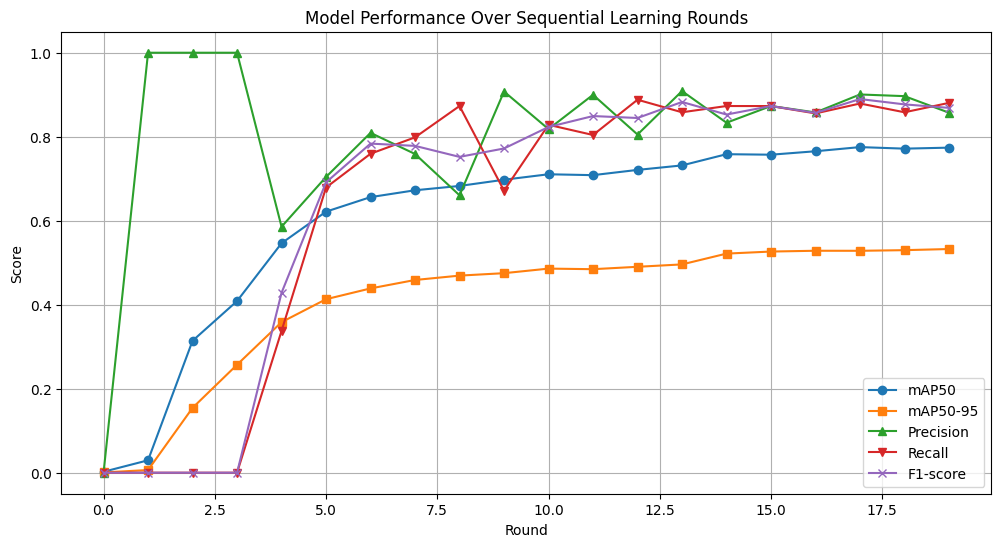

In [4]:
# 6. Active Learning Loop
train_images_folder = '/content/drive/MyDrive/AL Data/train/images'
train_labels_folder = '/content/drive/MyDrive/AL Data/train/labels'
unlabeled_images_folder = '/content/Laudare_AL/images/unlabeled'
unlabeled_labels_folder = '/content/Laudare_AL/labels/unlabeled'
val_data_yaml = '/content/Laudare_AL/data.yaml'

progress_tracker = []
round_num = 0
k_per_round = 15
patience = 5
no_improve_counter = 0
best_map50 = 0.0

while True:
    print(f"\n🚀 Round {round_num}")

    if round_num == 0:
        model = YOLO('yolov8n.yaml')
        model.train(data=val_data_yaml, imgsz=640, epochs=150, batch=8,
                    project='/content/Laudare_AL/yolo_runs', name='round_0')
    else:
        if len(os.listdir(unlabeled_images_folder)) == 0:
            print("✅ No more unlabeled images. Stopping.")
            break

        latest_model_path = f'/content/Laudare_AL/yolo_runs/round_{round_num-1}/weights/best.pt'


        selected_images = select_sequential_images(unlabeled_images_folder, k=k_per_round)
        if not selected_images:
            print("✅ No uncertain images left. Stopping.")
            break

        with open(f"/content/Laudare_AL/round_{round_num}_selected_images.txt", 'w') as f:
            for img in selected_images:
                f.write(f"{img}\n")

        move_selected_images(selected_images, unlabeled_images_folder, train_images_folder,
                             unlabeled_labels_folder, train_labels_folder)

        model = YOLO(latest_model_path)
        model.train(data=val_data_yaml, imgsz=640, epochs=150, batch=8,
                    project='/content/Laudare_AL/yolo_runs', name=f'round_{round_num}')

    # Evaluate
    final_model_path = f'/content/Laudare_AL/yolo_runs/round_{round_num}/weights/best.pt'
    eval_model = YOLO(final_model_path)
    metrics = evaluate_model(eval_model, val_data_yaml)

    num_images = len(os.listdir(train_images_folder))
    progress_tracker.append({
        'Round': round_num,
        '#Images Labeled': num_images,
        'mAP50': round(metrics['mAP50'], 4),
        'mAP50-95': round(metrics['mAP50-95'], 4),
        'Precision': round(metrics['Precision'], 4),
        'Recall': round(metrics['Recall'], 4),
        'F1-score': round(metrics['F1'], 4),
    })

    if metrics['mAP50'] > best_map50:
        best_map50 = metrics['mAP50']
        no_improve_counter = 0
        print(f"✅ Improved mAP50: {best_map50:.4f}")
    else:
        no_improve_counter += 1
        print(f"No improvement. Patience count: {no_improve_counter}")

    if no_improve_counter >= patience:
        print("❌ Patience exceeded. Stopping.")
        break

    round_num += 1

# 7. Show results
df_progress = pd.DataFrame(progress_tracker)
print(df_progress)

# 8. Plot metrics
plt.figure(figsize=(12, 6))
plt.plot(df_progress['Round'], df_progress['mAP50'], label='mAP50', marker='o')
plt.plot(df_progress['Round'], df_progress['mAP50-95'], label='mAP50-95', marker='s')
plt.plot(df_progress['Round'], df_progress['Precision'], label='Precision', marker='^')
plt.plot(df_progress['Round'], df_progress['Recall'], label='Recall', marker='v')
plt.plot(df_progress['Round'], df_progress['F1-score'], label='F1-score', marker='x')
plt.xlabel("Round")
plt.ylabel("Score")
plt.title("Model Performance Over Sequential Learning Rounds")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
from google.colab import files
import shutil

# Create a ZIP file of the folder
shutil.make_archive('/content/runs', 'zip', '/content/runs')

# Download the ZIP file
files.download('/content/runs.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>